In [1]:
%reset -f
import ROOT, numpy
import traceback
from datetime import datetime

import math
import array
import copy

from MyCommonAnalysisFunction_richcap import *

    

print(color.BOLD, "\nStarting Creation of C++ Binning Code for RG-A SIDIS Analysis\n", color.END)


# getting current date
datetime_object_full = datetime.now()
# print(datetime_object)

startMin_full = datetime_object_full.minute
startHr_full = datetime_object_full.hour

if(datetime_object_full.minute <10):
    timeMin_full = "".join(["0", str(datetime_object_full.minute)])
else:
    timeMin_full = str(datetime_object_full.minute)

    
Date_Day = "".join(["\nStarted running on ", color.BOLD, str(datetime_object_full.month), "-", str(datetime_object_full.day), "-", str(datetime_object_full.year), color.END, " at "])
# printing current time
if(datetime_object_full.hour > 12 and datetime_object_full.hour < 24):
    print("".join([Date_Day, color.BOLD, str((datetime_object_full.hour)-12), ":", timeMin_full, " p.m.", color.END]))
if(datetime_object_full.hour < 12 and datetime_object_full.hour > 0):
    print("".join([Date_Day, color.BOLD, str(datetime_object_full.hour), ":", timeMin_full, " a.m.", color.END]))
if(datetime_object_full.hour == 12):
    print("".join([Date_Day, color.BOLD, str(datetime_object_full.hour), ":", timeMin_full, " p.m.", color.END]))
if(datetime_object_full.hour == 0 or datetime_object_full.hour == 24):
    print("".join([Date_Day, color.BOLD, "12:", str(timeMin_full), " a.m.", color.END]))
print("")

Welcome to JupyROOT 6.22/06
 
Starting Creation of C++ Binning Code for RG-A SIDIS Analysis
 

Started running on 4-5-2024 at 12:26 p.m.



.

.

.

## Canvas Functions

In [2]:
def Canvas_Create(Name, Num_Columns=1, Num_Rows=1, Size_X=600, Size_Y=800, cd_Space=0):
    canvas_test = ROOT.TCanvas(str(Name), str(Name), Size_X, Size_Y)
    canvas_test.Divide(Num_Columns, Num_Rows, cd_Space, cd_Space)
    canvas_test.SetGrid()
    ROOT.gStyle.SetAxisColor(16, 'xy')
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetOptFit(1)

    return canvas_test

def Draw_Canvas(canvas, cd_num, left_add=0.05, right_add=0.05, up_add=0.1, down_add=0.1):
    canvas.cd(cd_num)
    try:
        canvas.cd(cd_num).SetLeftMargin(left_add)
        canvas.cd(cd_num).SetRightMargin(right_add)
        canvas.cd(cd_num).SetTopMargin(up_add)
        canvas.cd(cd_num).SetBottomMargin(down_add)
    except Exception as e:
        print("".join([color.RED, "ERROR: ", str(e), color.END]))


def palette_move(canvas, histo, x_left=0.905, x_right=0.925, y_up=0.9, y_down=0.1):
    canvas.Modified()
    canvas.Update()
    palette_test = 0
    while(palette_test < 4 and palette_test != -1):
        try:
            palette_histo = histo.GetListOfFunctions().FindObject("palette")
            palette_histo.SetX1NDC(x_left)
            palette_histo.SetX2NDC(x_right)
            palette_histo.SetY1NDC(y_down)
            palette_histo.SetY2NDC(y_up)
            canvas.Modified()
            canvas.Update()
            palette_test = -1
        except:
            palette_test += 1
    if(palette_test > 0):
            print("\nFailed to move palette...")


def statbox_move(Histogram, Canvas, Default_Stat_Obj="", Y1_add=0.05, Y2_add=0.25, X1_add=0.05, X2_add=0.35, Print_Method="norm"):
    finding, search = 0, 0
    while(finding == 0 and search < 5):
        if(Default_Stat_Obj == ""):
            Default_Stat_Obj = Histogram.GetListOfFunctions().FindObject("stats")
        if("TPaveStats" not in str(type(Default_Stat_Obj))):
            try:
                Default_Stat_Obj = Histogram.GetListOfFunctions().FindObject("stats")# Default_Stat_Obj.FindObject("stats")
            except Exception as e:
                print("".join([color.RED, str(e), "\nTRACEBACK:\n", str(traceback.format_exc()), color.END]))
        try:
            if(Print_Method == "norm"):
                Default_Stat_Obj.SetY1NDC(Y1_add)
                Default_Stat_Obj.SetY2NDC(Y2_add)
                Default_Stat_Obj.SetX1NDC(X1_add)
                Default_Stat_Obj.SetX2NDC(X2_add)
            if(Print_Method == "off"):
                Default_Stat_Obj.SetY1NDC(0)
                Default_Stat_Obj.SetY2NDC(0)
                Default_Stat_Obj.SetX1NDC(0)
                Default_Stat_Obj.SetX2NDC(0)
            Default_Stat_Obj.Draw("same")
            Canvas.Modified()
            Canvas.Update()
            finding += 1
        except:
            Canvas.Modified()
            Canvas.Update()
            finding = 0
            search += 1
    if(search > 4):
        print("Failed search")
        
        
def print_rounded_str(number, rounding=0):
    try:
        if(rounding != 0 and abs(number) >= 0.001):
            output = round(number, rounding)
            output = "".join(["{:.", str(rounding), "}"]).format(number)
            # print("round")
        elif(rounding != 0):
            output = "".join(["{:.", str(rounding-1), "e}"]).format(number)
            # print("science")
        else:
            # print("other")
            output = number
            
        return output
    
    except Exception as e:
        print("".join([color.BOLD, color.RED, "Error: number = ", str(output), " is not accepted", " --> failed to round input..." if(rounding != 0) else "", "\nERROR Output Is: \n", str(e), color.END]))
        print("".join([color.RED, "TRACEBACK:\n", str(traceback.format_exc()), color.END]))
        return number


def Error_Propagation(Type_of_Prop, Error1, Error2=0, Number1=0, Number2=0, Result=False):
    Error = False
    try:
        if("ave" in Type_of_Prop or "Ave" in Type_of_Prop or "average" in Type_of_Prop or "Average" in Type_of_Prop):
            # Average of given numbers
            if(type(Error1) is list):
                for x in Error1:
                    Error += (x - np.average(Error1))**2
                Error /= (len(Error1) - 1)
                Error *= 1/2
            else:
                ave = (Error1 + Error2)/2
                Error = ((Error1 - ave)**2 + (Error2 - ave)**2)**0.5
        if("add" in Type_of_Prop or "Add" in Type_of_Prop or "subtract" in Type_of_Prop or "Subtract" in Type_of_Prop or "sub" in Type_of_Prop or "Sub" in Type_of_Prop):
            # Addition or Subtraction
            Error = ((Error1)**2 + (Error2)**2)**0.5
        if("mult" in Type_of_Prop or "Mult" in Type_of_Prop or "multiply" in Type_of_Prop or "Multiply" in Type_of_Prop):
            # Multiplication
            if(not Result):
                Error = (Number1*Number2)*((Error1/Number1)**2 + (Error2/Number2)**2)**0.5
            else:
                Error = Result*((Error1/Number1)**2 + (Error2/Number2)**2)**0.5
        if("div" in Type_of_Prop or "Div" in Type_of_Prop or "divide" in Type_of_Prop or "Divide" in Type_of_Prop):
            # Division
            if(not Result):
                Error = (Number1/Number2)*((Error1/Number1)**2 + (Error2/Number2)**2)**0.5
            else:
                Error = Result*((Error1/Number1)**2 + (Error2/Number2)**2)**0.5
        if(not Error):
            print("ERROR: error not calculated... (See option selection for 'Type_of_Prop')")
        else:
            return Error
    
    except Exception as e:
        print("".join([color.RED, "Error taking Error Propagation with inputs:\n", color.END, "Type_of_Prop = ", str(Type_of_Prop), ", Error1 = ", str(Error1), ", Error2 = ", str(Error2), ", Number1 = ", str(Number1), ", Number2 = ", str(Number2), "".join([", Result = ", str(Result)]) if(not Result) else ""]))
        print("Error is: \n\t" + str(e))
        print("".join([color.RED, "TRACEBACK:\n", str(traceback.format_exc()), color.END]))
        
        
def Get_Max_Y_Histo_1D(Histo_List, Norm_Q="Default"):
    try:
        if(type(Histo_List) is not list):
            Histo_List = [Histo_List]
        Max_Y = 0
        for Histo in Histo_List:
            # print("".join([color.BOLD, color.BLUE, "\n'", str(Histo.GetName()), "' Maximum = ", str(Histo.GetMaximum()), " Total = ", str(Histo.Integral()), color.END]))
            if(Histo.Integral() != 0 and Histo.GetMaximum() != 0):
                Test_Y = (Histo.GetMaximum()) if((Norm_Q not in ["Normalized", "Norm"]) or (Norm_Q == "Default")) else ((Histo.GetMaximum())/(Histo.Integral()))
            else:
                Test_Y = 0
                print("".join([color.BOLD, color.RED, "\n EMPTY HISTOGRAM: '", str(Histo.GetName()), "'\n\tMaximum = ", str(Histo.GetMaximum()), "\n\tTotal = ", str(Histo.Integral()), color.END]))
            if(Test_Y > Max_Y):
                Max_Y = Test_Y
                
        return Max_Y
            
    except:
        print("".join([color.BOLD, color.RED, "\nERROR IN GETTING THE MAX Y OF THE 1D HISTOGRAMS...", color.END]))
        print("".join([color.BOLD, color.RED, "ERROR:\n", color.END, color.RED, str(traceback.format_exc()), color.END]))
        return "ERROR"

    
    
    
    
    
    
def draw_info_box(Total_Num="None", Cut_Num="None", RATIO_Val="None", Min_Q2="None", Max_Q2="None", Min_Y="None", Max_Y="None", Variables="Q2_y"):
    # Define the position of the box: x1, y1, x2, y2
    # Adjust these values to move and size the box as needed
    x1, y1, x2, y2 = 0.125, 0.5, 0.35, 0.7
    if(str(Variables) not in ["Q2_y"]):
        x1, y1, x2, y2 = 0.625, 0.3, 0.85, 0.5
        x1, y1, x2, y2 = 0.625, 0.3, 0.88, 0.5
    
    # Create the TPaveText object
    pave = ROOT.TPaveText(x1, y1, x2, y2, "NDC") # NDC means "Normalized Device Coordinates", between 0 and 1
    # pave.SetBorderSize(0)    # no border
    # pave.SetFillStyle(0)     # transparent background
    pave.SetBorderSize(1)
    pave.SetFillStyle(1001)
    pave.SetFillColor(0)
    pave.SetTextAlign(12)    # left aligned
    # pave.SetTextFont(42)     # font code, change as needed
    pave.SetTextFont(62)     # font code, change as needed
    pave.SetTextSize(0.02)   # text size, change as needed

    # Add lines of text
    if(type("string") not in [type(Total_Num), type(Cut_Num), type(RATIO_Val), type(Min_Q2), type(Max_Q2), type(Min_Y), type(Max_Y)]):
        # All inputs are numbers
        formatted_total = "{:.3e}".format(Total_Num)
        formatted_cut = "{:.3e}".format(Cut_Num)
        pave.AddText(f"Events before cuts = {formatted_total}")
        pave.AddText(f"Events after cuts  = {formatted_cut}")
        pave.AddText(f"% of Data here = {RATIO_Val:.2f}%")
        pave.AddText(f"")
        if(str(Variables) in ["Q2_y"]):
            pave.AddText(f"Q2 ranges are: {Min_Q2:.2f} to {Max_Q2:.2f}")
            pave.AddText(f"y   ranges are: {Min_Y:.2f} to {Max_Y:.2f}")
        else:
            pave.AddText(f"z   ranges are: {Min_Q2:.2f} to {Max_Q2:.2f}")
            pave.AddText(f"pT ranges are: {Min_Y:.2f} to {Max_Y:.2f}")
    else:
        # At least one input was a string
        pave.AddText(f"Events (before cuts) = {Total_Num}")
        pave.AddText(f"Events (after cuts)  = {Cut_Num}")
        pave.AddText(f"% of Data in this bin = {RATIO_Val}%")
        if(str(Variables) in ["Q2_y"]):
            pave.AddText(f"Q2 ranges are: {Min_Q2} to {Max_Q2}")
            pave.AddText(f"y   ranges are: {Min_Y} to {Max_Y}")
        else:
            pave.AddText(f"z   ranges are: {Min_Q2:.2f} to {Max_Q2:.2f}")
            pave.AddText(f"pT ranges are: {Min_Y:.2f} to {Max_Y:.2f}")

    # Draw the box on the histogram
    pave.Draw()
    return pave  # return the TPaveText so it's not garbage collected
    
    
print("\nDone\n")


Done



# Test Function for Q2-y Bins
New_Q2_y_Bin_Test(...)

In [3]:
# Rounded Q2 to the nearest 0.05 increment of the bin border
def New_Q2_y_Bin_Test(Bin_In):
    Q2_min, Q2_max = 2.00, 2.40
    y_min,  y_max  = 0.65, 0.75
    ####=====######################=====####
    ####=====####  Q2 Group 1  ####=====####
    ####=====######################=====####
    if(Bin_In in range(1, 5, 1)):
        Q2_min, Q2_max = 2.00, 2.40
    ####=====######################=====####
    ####=====####  Q2 Group 2  ####=====####
    ####=====######################=====####
    if(Bin_In in range(5, 9, 1)):
        Q2_min, Q2_max = 2.40, 2.90
    ####=====######################=====####
    ####=====####  Q2 Group 3  ####=====####
    ####=====######################=====####
    if(Bin_In in range(9, 13, 1)):
        Q2_min, Q2_max = 2.90, 3.70
    ####=====######################=====####
    ####=====####  Q2 Group 4  ####=====####
    ####=====######################=====####
    if(Bin_In in range(13, 16, 1)):
        Q2_min, Q2_max = 3.70, 5.30
    ####=====######################=====####
    ####=====####  Q2 Group 5  ####=====####
    ####=====######################=====####
    if(Bin_In in range(16, 18, 1)):
        Q2_min, Q2_max = 5.30, 7.90
        
    ####=====#########################################=====####
    ####=====####  Q2 Group 0  -  Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(18, 24, 1)):
        Q2_min, Q2_max = 0.00, 2.00
    ####=====#########################################=====####
    ####=====####  Q2 Group 1.5 - Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(24, 26, 1)):
        Q2_min, Q2_max = 2.00, 2.40
    ####=====#########################################=====####
    ####=====####  Q2 Group 2.5 - Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(26, 28, 1)):
        Q2_min, Q2_max = 2.40, 2.90
    ####=====#########################################=====####
    ####=====####  Q2 Group 3.5 - Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(28, 30, 1)):
        Q2_min, Q2_max = 2.90, 3.70
    ####=====#########################################=====####
    ####=====####  Q2 Group 4.5 - Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(30, 33, 1)):
        Q2_min, Q2_max = 3.70, 5.30
    ####=====#########################################=====####
    ####=====####  Q2 Group 5.5 - Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(33, 36, 1)):
        Q2_min, Q2_max = 5.30, 7.90
    ####=====#########################################=====####
    ####=====####  Q2 Group 6  -  Migration Bins  ####=====####
    ####=====#########################################=====####
    if(Bin_In in range(36, 40, 1)):
        Q2_min, Q2_max = 7.90, 14.00
        
        
    ####=====######################=====####
    ####=====####  y  Group 1  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [1, 5,  9, 13, 16,            19, 37]):
        y_min, y_max = 0.65, 0.75
    ####=====######################=====####
    ####=====####  y  Group 2  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [2, 6, 10, 14, 17,            20, 38]):
        y_min, y_max = 0.55, 0.65
    ####=====######################=====####
    ####=====####  y  Group 3  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [3, 7, 11, 15,                21, 34, 39]):
        y_min, y_max = 0.45, 0.55
    ####=====######################=====####
    ####=====####  y  Group 4  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [4, 8, 12,                    22, 31, 35]):
        y_min, y_max = 0.35, 0.45
        
    ####=====#######################################=====####
    ####=====####  y  Group 0 - Migration Bins  ####=====####
    ####=====#######################################=====####
    if(Bin_In in [18, 24, 26, 28, 30, 33, 36]):
        y_min, y_max = 0.75, 0.99
    ####=====#######################################=====####
    ####=====####  y  Group 5 - Migration Bins  ####=====####
    ####=====#######################################=====####
    if(Bin_In in [23, 25, 27, 29, 32]):
        y_min, y_max = 0.1, 0.35
        
        
        
        
    return [Q2_max, Q2_min, y_max, y_min]


print("".join([color.BOLD, color.BLUE, color_bg.RED, "\n\t\t\t\t\t\t\t\t\n\t", color_bg.YELLOW, "  Done Making the New_Q2_y_Bin_Test(...) function  ", color_bg.RED, "\t\n\t\t\t\t\t\t\t\t\n", color.END]))


								
	  Done Making the New_Q2_y_Bin_Test(...) function  	
								



# Test Function for z-pT Bins
New_z_pT_Bin_Test(...)

In [26]:
# Rounded z and pT to the nearest 0.01 increment of the bin border
def New_z_pT_Bin_Test(Q2_y_Bin_In):
    # Defining Borders for z and pT Bins (based on the test version of 'Q2_y_Bin')

    # For Q2-y Bin 1
    if(Q2_y_Bin_In == 1):
        z_Borders  = [0.15, 0.20, 0.24, 0.29, 0.40, 0.73]
        z_Borders  = [0.16, 0.20, 0.24, 0.31, 0.41, 0.70]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.60, 0.75, 1.0]
#         pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.60, 0.75, 0.98]

        z_Borders  = [0.16, 0.19, 0.23, 0.29, 0.40, 0.71]
        pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.52, 0.63, 0.75, 0.99]

    # For Q2-y Bin 2
    if(Q2_y_Bin_In == 2):
        z_Borders  = [0.18, 0.23, 0.26, 0.31, 0.38, 0.50, 0.74]
        z_Borders  = [0.19, 0.23, 0.26, 0.31, 0.38, 0.50, 0.73]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.60, 0.75, 1.0]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.50, 0.60, 0.75, 0.95]
        
        z_Borders  = [0.19, 0.23, 0.26, 0.31, 0.38, 0.50, 0.75]
        pT_Borders = [0.05, 0.25, 0.35, 0.45, 0.54, 0.67, 0.93]
        
    # For Q2-y Bin 3
    if(Q2_y_Bin_In == 3):
        z_Borders  = [0.22, 0.28, 0.35, 0.45, 0.60, 0.78]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.60, 0.75, 1.0]
        
        z_Borders  = [0.22, 0.28, 0.35, 0.45, 0.70]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.60, 0.75]
        
        z_Borders  = [0.22, 0.28, 0.33, 0.41, 0.56, 0.75]
        pT_Borders = [0.05, 0.20, 0.30, 0.39, 0.49, 0.59, 0.76]

    # For Q2-y Bin 4
    if(Q2_y_Bin_In == 4):
        z_Borders  = [0.26, 0.32, 0.37, 0.43, 0.50, 0.60, 0.71]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.60, 0.80]
        
        z_Borders  = [0.26, 0.34, 0.38, 0.43, 0.50, 0.60]
        pT_Borders = [0.05, 0.21, 0.30, 0.39, 0.49, 0.60]
        
        z_Borders  = [0.26, 0.34, 0.38, 0.43, 0.50, 0.60]
        pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.61]
        
        z_Borders  = [0.26, 0.33, 0.38, 0.43, 0.50, 0.59, 0.71]
        pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.61, 0.85]

    # For Q2-y Bin 5
    if(Q2_y_Bin_In == 5):
        z_Borders  = [0.15, 0.19, 0.24, 0.29, 0.38, 0.50, 0.73]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.30, 0.38, 0.49, 0.72]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 0.98]

    # For Q2-y Bin 6
    if(Q2_y_Bin_In == 6):
        z_Borders  = [0.18, 0.23, 0.30, 0.39, 0.50, 0.78]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]
        
        z_Borders  = [0.18, 0.23, 0.28, 0.37, 0.49, 0.75]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]
        
        z_Borders  = [0.18, 0.24, 0.29, 0.36, 0.46, 0.75]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.05]
        
        z_Borders  = [0.18, 0.23, 0.28, 0.35, 0.45, 0.75]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.05]
        
        z_Borders  = [0.18, 0.23, 0.28, 0.35, 0.45, 0.72]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]
        
    # For Q2-y Bin 7
    if(Q2_y_Bin_In == 7):
        z_Borders  = [0.21, 0.26, 0.30, 0.44, 0.55, 0.78]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.65, 1.0]
        
        z_Borders  = [0.21, 0.29, 0.36, 0.44, 0.55, 0.70]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.70, 0.8]
        
        z_Borders  = [0.22, 0.28, 0.33, 0.40, 0.51, 0.70]
        pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.60, 0.83]
        
        z_Borders  = [0.22, 0.28, 0.33, 0.40, 0.51, 0.70, 0.80]
        pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.60, 0.83]
        
        z_Borders  = [0.22, 0.27, 0.31, 0.37, 0.45, 0.58, 0.77]
        pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.60, 0.83]
        
    # For Q2-y Bin 8
    if(Q2_y_Bin_In in [8]):
        z_Borders  = [0.26, 0.32, 0.36, 0.40, 0.45, 0.53, 0.72]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.52, 0.75]
        
        z_Borders  = [0.27, 0.32, 0.36, 0.40, 0.45, 0.50, 0.72]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.75]
        
        z_Borders  = [0.27, 0.32, 0.36, 0.40, 0.45, 0.50, 0.60, 0.72]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.75]
        
        z_Borders  = [0.27, 0.32, 0.36, 0.40, 0.45, 0.50, 0.60]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50]
        
        z_Borders  = [0.27, 0.32, 0.36, 0.40, 0.45, 0.50, 0.60, 0.70]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.60]
        
        z_Borders  = [0.27, 0.33, 0.36, 0.39, 0.44, 0.49, 0.56, 0.70]
        pT_Borders = [0.05, 0.20, 0.29, 0.37, 0.46, 0.60]
        
    # For Q2-y Bin 9
    if(Q2_y_Bin_In in [9]):
        z_Borders  = [0.15, 0.20, 0.24, 0.30, 0.38, 0.48, 0.72]
        pT_Borders = [0.05, 0.22, 0.30, 0.38, 0.46, 0.60, 0.95]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.30, 0.42, 0.70]
        pT_Borders = [0.05, 0.22, 0.30, 0.38, 0.46, 0.58, 0.74, 0.95]
        
    # For Q2-y Bin 10
    if(Q2_y_Bin_In in [10]):
        z_Borders  = [0.18, 0.23, 0.26, 0.32, 0.40, 0.50, 0.72]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.00]
        
        z_Borders  = [0.19, 0.23, 0.26, 0.32, 0.40, 0.50, 0.72]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]
        
    # For Q2-y Bin 11
    if(Q2_y_Bin_In in [11]):
        z_Borders  = [0.21, 0.26, 0.32, 0.40, 0.50, 0.70]
        pT_Borders = [0.05, 0.20, 0.31, 0.40, 0.50, 0.64, 0.95]
        
        z_Borders  = [0.22, 0.26, 0.32, 0.40, 0.50, 0.60, 0.70]
        pT_Borders = [0.05, 0.20, 0.31, 0.40, 0.50, 0.60, 0.72]
        
        z_Borders  = [0.23, 0.28, 0.35, 0.44, 0.54, 0.70]
        pT_Borders = [0.05, 0.20, 0.31, 0.40, 0.50, 0.60, 0.72]
        
        z_Borders  = [0.22, 0.61, 0.70]
        pT_Borders = [0.05, 0.20, 0.58]
        
        z_Borders  = [0.22, 0.27, 0.32, 0.40, 0.53, 0.69]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.54, 0.69]
        
        z_Borders  = [0.22, 0.27, 0.32, 0.39, 0.52, 0.73]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.53, 0.69]
        
    # For Q2-y Bin 12
    if(Q2_y_Bin_In in [12]):
        z_Borders  = [0.26, 0.32, 0.40, 0.50, 0.70]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.67]
        
        z_Borders  = [0.27, 0.32, 0.40, 0.50, 0.70]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.67]
        
        z_Borders  = [0.27, 0.31, 0.35, 0.40, 0.50, 0.70]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.67]
        
        z_Borders  = [0.27, 0.31, 0.35, 0.40, 0.50]
        pT_Borders = [0.05, 0.22, 0.32, 0.41]
        
        z_Borders  = [0.27, 0.31, 0.35, 0.40, 0.50, 0.70]
        pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.50, 0.60]
        
        z_Borders  = [0.27, 0.33, 0.37, 0.43, 0.51, 0.70]
        pT_Borders = [0.05, 0.20, 0.28, 0.36, 0.45, 0.60]
        
    # For Q2-y Bin 13
    if(Q2_y_Bin_In in [13]):
        z_Borders  = [0.15, 0.20, 0.24, 0.30, 0.40, 0.72]
        pT_Borders = [0.05, 0.23, 0.34, 0.43, 0.55, 0.90]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.30, 0.40, 0.72]
        pT_Borders = [0.05, 0.23, 0.34, 0.43, 0.55, 0.90]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.29, 0.36, 0.51, 0.72]
        pT_Borders = [0.05, 0.22]
        pT_Borders = [0.60, 0.90]
        
        pT_Borders = [0.05, 0.22, 0.35, 0.45, 0.60, 0.90]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.29, 0.35, 0.46, 0.72]
        pT_Borders = [0.05, 0.22, 0.34, 0.44, 0.58, 0.90]

    # For Q2-y Bin 14
    if(Q2_y_Bin_In in [14]):
        z_Borders  = [0.18, 0.23, 0.27, 0.33, 0.44, 0.74]
        pT_Borders = [0.05, 0.23, 0.34, 0.44, 0.55, 0.90]
        
        z_Borders  = [0.19, 0.23, 0.27, 0.33, 0.44, 0.70]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.80]
        
        z_Borders  = [0.19, 0.23, 0.27, 0.33, 0.44, 0.60, 0.70]
        pT_Borders = [0.50, 0.65, 0.80]
        
        z_Borders  = [0.19, 0.23, 0.27, 0.33, 0.44, 0.57, 0.70]
        pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.50, 0.65, 0.80]
        
        z_Borders  = [0.19, 0.23, 0.27, 0.32, 0.39, 0.52, 0.74]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.65, 0.80]
        
        z_Borders  = [0.19, 0.23, 0.27, 0.32, 0.39, 0.50, 0.71]
        pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]
        
    # For Q2-y Bin 15
    if(Q2_y_Bin_In in [15]):
        z_Borders  = [0.21, 0.28, 0.35, 0.47, 0.72]
        pT_Borders = [0.05, 0.23, 0.34, 0.45, 0.58, 0.90]
        
        z_Borders  = [0.22, 0.28, 0.35, 0.46, 0.72]
        z_Borders  = [0.22, 0.26, 0.33, 0.44, 0.52, 0.72]
        
        z_Borders  = [0.22, 0.28, 0.33, 0.40, 0.51, 0.72]
        pT_Borders = [0.05, 0.23, 0.33, 0.47, 0.90]
        
        z_Borders  = [0.22, 0.28, 0.33, 0.40, 0.51]
        pT_Borders = [0.05, 0.23, 0.33, 0.47]
        
        
        z_Borders  = [0.22, 0.27, 0.32, 0.40, 0.49, 0.73]
        pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.55, 0.80]
        
    # For Q2-y Bin 16
    if(Q2_y_Bin_In in [16]):
        z_Borders  = [0.15, 0.20, 0.25, 0.32, 0.41, 0.71]
        pT_Borders = [0.05, 0.24, 0.36, 0.55, 0.80]
        
        z_Borders  = [0.16, 0.20, 0.25, 0.32, 0.41, 0.71]
        
        z_Borders  = [0.16, 0.20]
        z_Borders  = [0.20, 0.25]
        z_Borders  = [0.25, 0.32]
        z_Borders  = [0.32, 0.40]
        z_Borders  = [0.40, 0.50]
        
        z_Borders  = [0.16, 0.20, 0.25, 0.32, 0.40, 0.50, 0.65]
        pT_Borders = [0.05, 0.20, 0.31, 0.44, 0.70, 1.00]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.29, 0.36, 0.45, 0.62]
        pT_Borders = [0.05, 0.22, 0.31, 0.44, 0.70, 1.00]
        
        pT_Borders = [0.05, 0.22, 0.31, 0.44, 0.70]
        
        z_Borders  = [0.16, 0.20, 0.24, 0.29, 0.36, 0.45, 0.67]
        pT_Borders = [0.05, 0.22, 0.31, 0.44, 0.65, 0.85]
        
        z_Borders  = [0.16, 0.20, 0.25, 0.33, 0.44, 0.67]
        z_Borders  = [0.16, 0.20, 0.24, 0.31, 0.42, 0.67]
        pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.52, 0.66, 0.90]
    
    # For Q2-y Bin 17
    if(Q2_y_Bin_In in [17]):
        z_Borders  = [0.18, 0.23, 0.30, 0.38, 0.48, 0.72]
        pT_Borders = [0.05, 0.23, 0.36, 0.51, 0.85]
        
        z_Borders  = [0.19, 0.23, 0.30, 0.37, 0.45, 0.72]
        pT_Borders = [0.05, 0.19, 0.28, 0.36, 0.85]
        
        z_Borders  = [0.19, 0.23, 0.29, 0.35, 0.45, 0.72]
        pT_Borders = [0.05, 0.19, 0.28, 0.37, 0.85]
        
        z_Borders  = [0.19, 0.23, 0.29, 0.35, 0.45]
        pT_Borders = [0.05, 0.19, 0.28, 0.37]
        
        
        z_Borders  = [0.19, 0.23, 0.28, 0.34, 0.44, 0.68]
        pT_Borders = [0.05, 0.19, 0.28, 0.37, 0.45, 0.55, 0.73]
        
    Num_z_Borders  = len(z_Borders)
    Num_pT_Borders = len(pT_Borders)
        
        
    # For Q2-y Bin 0 and -1
    if(Q2_y_Bin_In < 1):
        z_Borders      = [0.15, 0.70]
        Num_z_Borders  = 1
        pT_Borders     = [0.05, 1.0]
        Num_pT_Borders = 1
        
    if(Q2_y_Bin_In == 0):
        print("ERROR")
        
    z_Borders.reverse()

                    # Info about z bins              # Info about pT bins         # Total number of z-pT bins
    output = [['z', Num_z_Borders, z_Borders], ['pT', Num_pT_Borders, pT_Borders], (Num_z_Borders-1)*(Num_pT_Borders-1)]
    
    return output

print("".join([color.BOLD, color.BLUE, color_bg.YELLOW, "\n\t\t\t\t\t\t\t\t\n\t", color_bg.RED, "  Done Making the New_z_pT_Bin_Test(...) function  ", color_bg.YELLOW, "\t\n\t\t\t\t\t\t\t\t\n", color.END]))




List_Of_Overflow_Bins = {}

# List_Of_Overflow_Bins[f'{1}']  = [5,  6,  7,  13, 14, 21]
# List_Of_Overflow_Bins[f'{2}']  = [5,  6,  12, 18]
# List_Of_Overflow_Bins[f'{3}']  = [6,  24]
# List_Of_Overflow_Bins[f'{4}']  = [25]
# List_Of_Overflow_Bins[f'{5}']  = [5,  6,  12, 18]
# List_Of_Overflow_Bins[f'{6}']  = [5,  6,  12, 18, 30]
# List_Of_Overflow_Bins[f'{7}']  = [6,  12, 29, 30]
# List_Of_Overflow_Bins[f'{7}']  = [6,  12, 36]
# List_Of_Overflow_Bins[f'{8}']  = [23, 24]
# List_Of_Overflow_Bins[f'{9}']  = [6,  7,  13, 14]
# List_Of_Overflow_Bins[f'{10}'] = [5,  6,  12, 18, 36]
# List_Of_Overflow_Bins[f'{11}'] = [5,  23, 24, 25]
# List_Of_Overflow_Bins[f'{12}'] = [11, 12]
# List_Of_Overflow_Bins[f'{13}'] = [4,  5,  10, 15, 30]
# List_Of_Overflow_Bins[f'{14}'] = [5,  6,  12, 18, 30, 34, 35, 36]
# List_Of_Overflow_Bins[f'{15}'] = [12]
# List_Of_Overflow_Bins[f'{16}'] = [4,  8,  24]
# List_Of_Overflow_Bins[f'{17}'] = [11, 12]


List_Of_Overflow_Bins[f'{1}']  = [21, 27, 28, 33, 34, 35]
List_Of_Overflow_Bins[f'{2}']  = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{3}']  = [30]
List_Of_Overflow_Bins[f'{4}']  = [6,  30, 36]
List_Of_Overflow_Bins[f'{5}']  = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{6}']  = [18, 24, 29, 30]
List_Of_Overflow_Bins[f'{7}']  = [6,  30, 36]
List_Of_Overflow_Bins[f'{8}']  = []
List_Of_Overflow_Bins[f'{9}']  = [21, 27, 28, 33, 34, 35]
List_Of_Overflow_Bins[f'{10}'] = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{11}'] = [25]
List_Of_Overflow_Bins[f'{12}'] = [5]
List_Of_Overflow_Bins[f'{13}'] = [20, 25, 29, 30]
List_Of_Overflow_Bins[f'{14}'] = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{15}'] = [5,  20, 25]
List_Of_Overflow_Bins[f'{16}'] = [18, 23, 24, 28, 29, 30]
List_Of_Overflow_Bins[f'{17}'] = [24, 29, 30]

print("\nDone defining overflow...")

List_Of_Overflow_Bins = {}
for ii in range(1, 18):
    List_Of_Overflow_Bins[f'{ii}'] = []
def New_z_pT_Bin_Test(Q2_y_Bin_In):
    return z_pT_Border_Lines(Q2_y_Bin_Select=Q2_y_Bin_In, Binning_Method_Input=Binning_Method)


								
	  Done Making the New_z_pT_Bin_Test(...) function  	
								


Done defining overflow...


## Simple Histogram Cut function

In [5]:
def Histo_2D_Cut(Histogram_IN, x_cut_min=0, x_cut_max=1, y_cut_min=0, y_cut_max=12, Cut_Name=""):
    Histogram = Histogram_IN.Clone("".join([str(Histogram_IN.GetName()), "_Cut", str(Cut_Name)]))
    print_x_min, print_x_max, print_y_min, print_y_max = True, True, True, True
    for binx in range(0, Histogram.GetNbinsX() + 1):
        for biny in range(0, Histogram.GetNbinsY() + 1):
            x_low  = round(Histogram.GetXaxis().GetBinLowEdge(binx),  5)
            x_high = round(Histogram.GetXaxis().GetBinUpEdge(binx),   5)
            y_low  = round(Histogram.GetYaxis().GetBinLowEdge(biny),  5)
            y_high = round(Histogram.GetYaxis().GetBinUpEdge(biny),   5)

            # Check if x and/or y edges are out of the desired range:
            if(((x_high <= x_cut_min) or (x_low >= x_cut_max)) or ((y_high <= y_cut_min) or (y_low >= y_cut_max))):
                Histogram.SetBinContent(binx, biny, 0)  # Set bin content to zero if it's out of the range

            # Check if cuts are inside a bin
            if(((x_cut_min > x_low) and (x_cut_min < x_high)) and (x_cut_min not in [x_low, x_high])):
                if(print_x_min):
                    print(f"X (min) cut at {x_cut_min} lies inside bin {binx} (i.e., {x_low} < X < {x_high} ({round(Histogram.GetXaxis().GetBinCenter(binx), 4)}))")
                    print_x_min = False
                Histogram.SetBinContent(binx, biny, 0)
            if(((x_cut_max > x_low) and (x_cut_max < x_high)) and (x_cut_max not in [x_low, x_high])):
                if(print_x_max):
                    print(f"X (max) cut at {x_cut_max} lies inside bin {binx} (i.e., {x_low} < X < {x_high} ({round(Histogram.GetXaxis().GetBinCenter(binx), 4)}))")
                    print_x_max = False
                Histogram.SetBinContent(binx, biny, 0)
            if(((y_cut_min > y_low) and (y_cut_min < y_high)) and (y_cut_min not in [y_low, y_high])):
                if(print_y_min):
                    print(f"Y (min) cut at {y_cut_min} lies inside bin {biny} (i.e., {y_low} < Y < {y_high} ({round(Histogram.GetYaxis().GetBinCenter(biny), 4)}))")
                    print_y_min = False
                Histogram.SetBinContent(binx, biny, 0)
            if(((y_cut_max > y_low) and (y_cut_max < y_high)) and (y_cut_max not in [y_low, y_high])):
                if(print_y_max):
                    print(f"Y (max) cut at {y_cut_max} lies inside bin {biny} (i.e., {y_low} < Y < {y_high} ({round(Histogram.GetYaxis().GetBinCenter(biny), 4)}))")
                    print_y_max = False
                Histogram.SetBinContent(binx, biny, 0)
                
    return Histogram

print("Done")

Done


.

.

.

# Setup DataFrames (for testing)

In [6]:
RUN_TESTS = True

if(RUN_TESTS):
    def FileLocation(FileName, Datatype):
        # location = "/lustre19/expphy/volatile/clas12/richcap/SIDIS_Analysis/Histo_Files_ROOT/"
        location = "Histo_Files_ROOT/"

        if(str(Datatype) == 'rdf'):
            file = "".join(["REAL_Data/SIDIS_epip_Data_REC_", str(FileName), ".root"])
        if(str(Datatype) == 'mdf'):
            file = "".join(["Matching_REC_MC/SIDIS_epip_MC_Matched_", str(FileName), ".root"])
        if(str(Datatype) == 'gdf'):
            file = "".join(["GEN_MC/SIDIS_epip_MC_GEN_", str(FileName), ".root"])

        loading = "".join([location, file])
        # print(loading)

        return loading


    ################################################################################################################################################################
    ##==========##==========##     Names of Requested File(s)     ##==========##==========##==========##==========##==========##==========##==========##==========##
    ################################################################################################################################################################
    Common_Name = "New_Bin_Tests_V3_All"

    # Common_Name = "New_Bin_Tests_V4_All"
    # Common_Name = "Gen_Cuts_V8_All"

    # Common_Name = "New_Binning_Schemes_V8_All"

    # Common_Name = "Sec_Cut_Test_V1_All"
    # Common_Name = "Sec_Cut_Test_V2_All"

    # Common_Name = "New_Smearing_V4_All"

    Common_Name = "New_Q2_Y_Bins_V2_All"
    Common_Name = "MultiDim_Bin_Test_V1_All"


    REAL_File_Name   = Common_Name
    MC_REC_File_Name = Common_Name
    MC_GEN_File_Name = Common_Name

    ################################################################################################################################################################
    ##==========##==========##     Names of Requested File(s)     ##==========##==========##==========##==========##==========##==========##==========##==========##
    ################################################################################################################################################################





    ################################################################################################################################################################
    ##==========##==========##     Loading Requested File(s)     ##==========##==========##==========##==========##==========##==========##==========##==========##
    ################################################################################################################################################################
    try:
        rdf = ROOT.TFile(str(FileLocation(str(REAL_File_Name), "rdf")), "READ")
        print("".join(["The total number of histograms available for the", color.BLUE , " Real (Experimental) Data", color.END, " in       '", color.BOLD, REAL_File_Name, color.END, "' is ", color.BOLD, str(len(rdf.GetListOfKeys())), color.END]))
    except:
        print("".join([color.RED, color.BOLD, "\nERROR IN GETTING THE 'rdf' DATAFRAME...\nTraceback:\n", color.END, color.RED, str(traceback.format_exc()), color.END]))
    try:
        mdf = ROOT.TFile(str(FileLocation(str(MC_REC_File_Name), "mdf")), "READ")
        print("".join(["The total number of histograms available for the", color.RED , " Reconstructed Monte Carlo Data", color.END, " in '", color.BOLD, MC_REC_File_Name, color.END, "' is ", color.BOLD, str(len(mdf.GetListOfKeys())), color.END]))
    except:
        print("".join([color.RED, color.BOLD, "\nERROR IN GETTING THE 'mdf' DATAFRAME...\nTraceback:\n", color.END, color.RED, str(traceback.format_exc()), color.END]))
    try:
        gdf = ROOT.TFile(str(FileLocation(str(MC_GEN_File_Name), "gdf")), "READ")
        print("".join(["The total number of histograms available for the", color.GREEN , " Generated Monte Carlo Data", color.END, " in     '", color.BOLD, MC_GEN_File_Name, color.END, "' is ", color.BOLD, str(len(gdf.GetListOfKeys())), color.END]))
    except:
        print("".join([color.RED, color.BOLD, "\nERROR IN GETTING THE 'gdf' DATAFRAME...\nTraceback:\n", color.END, color.RED, str(traceback.format_exc()), color.END]))
    ################################################################################################################################################################
    ##==========##==========##     Loading Requested File(s)     ##==========##==========##==========##==========##==========##==========##==========##==========##
    ################################################################################################################################################################

    print("".join(["\n\n", color.BOLD, "Done Loading RDataFrame files...\n", color.END]))
else:
    print(f"{color.Error}RUN_TESTS = {RUN_TESTS}...{color.END}\n\n{color.BOLD}Must set this value to 'True' in order to run this cell (and the two cells below it){color.END}")

The total number of histograms available for the Real (Experimental) Data in       'MultiDim_Bin_Test_V1_All' is 360
The total number of histograms available for the Reconstructed Monte Carlo Data in 'MultiDim_Bin_Test_V1_All' is 504
The total number of histograms available for the Generated Monte Carlo Data in     'MultiDim_Bin_Test_V1_All' is 198


Done Loading RDataFrame files...



# Code for setting up z-pT Bins (tests and final)

In [27]:
RUN_SET_BINS = not True
if(RUN_TESTS and not RUN_SET_BINS):
    print(f"{color.BOLD}{color.GREEN}RUN_TESTS = {RUN_TESTS}\nRunning the Test versions of the z-pT bins with 'New_z_pT_Bin_Test(...)'{color.END}")
    
    def Get_z_pT_Bin_Corners(z_pT_Bin_Num="All", Q2_y_Bin_Num=1):
        New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num)
        z_Borders  = New_z_pT_Bin_Test_List[0][2]
        pT_Borders = New_z_pT_Bin_Test_List[1][2]
        if(str(z_pT_Bin_Num) in ["All", "0"]):
            return ["z", z_Borders, "pT", pT_Borders]
        rows    = len(z_Borders)  - 1
        columns = len(pT_Borders) - 1
        Number_Analysis_Bins = (rows)*(columns)
        Number_Overflow_Bins = ((rows + 2)*(columns + 2)) - Number_Analysis_Bins
        Number_Overflow_Bins = 0
        if(z_pT_Bin_Num < 1):
            raise ValueError("".join(["Invalid bin number. z_pT_Bin_Num = ", str(z_pT_Bin_Num)]))
        if(z_pT_Bin_Num > Number_Analysis_Bins):
            if(z_pT_Bin_Num > (Number_Overflow_Bins + Number_Analysis_Bins)):
                raise ValueError("".join(["Invalid bin number. z_pT_Bin_Num = ", str(z_pT_Bin_Num)]))
            else:
                z_min_Overflow,  z_max_Overflow  = 0, 10
                pT_min_Overflow, pT_max_Overflow = 0, 10
                z_min  = z_min_Overflow
                z_max  = z_max_Overflow
                pT_min = pT_min_Overflow
                pT_max = pT_max_Overflow
                OverFlow_Bin = z_pT_Bin_Num - Number_Analysis_Bins
                if(OverFlow_Bin <= (columns + 2)):
                    z_min = z_Borders[0]
                    z_max = z_max_Overflow
                    if(OverFlow_Bin == 1):
                        pT_min = pT_min_Overflow
                        pT_max = pT_Borders[0]
                    elif(OverFlow_Bin == (columns + 2)):
                        pT_min = pT_Borders[columns]
                        pT_max = pT_max_Overflow
                    else:
                        pT_min = pT_Borders[OverFlow_Bin-2]
                        pT_max = pT_Borders[OverFlow_Bin-1]
                else:
                    Total_OverFlow_Left = OverFlow_Bin - (columns + 2)
                    for OverFlow_Row in range(0, rows, 1):
                        z_min = z_Borders[OverFlow_Row + 1]
                        z_max = z_Borders[OverFlow_Row]
                        for OverFlow_pT in [[0, pT_Borders[0]], [pT_Borders[columns], 10]]:
                            Total_OverFlow_Left += -1
                            pT_min, pT_max = OverFlow_pT
                            if(Total_OverFlow_Left == 0):
                                break
                        if(Total_OverFlow_Left == 0):
                            break
                    if(Total_OverFlow_Left != 0):
                        z_min = z_min_Overflow
                        z_max = z_Borders[rows]
                        if(Total_OverFlow_Left == 1):
                            pT_min = pT_min_Overflow
                            pT_max = pT_Borders[0]
                        elif(Total_OverFlow_Left == (columns + 2)):
                            pT_min = pT_Borders[columns]
                            pT_max = pT_max_Overflow
                        else:
                            pT_min = pT_Borders[Total_OverFlow_Left-2]
                            pT_max = pT_Borders[Total_OverFlow_Left-1]
                return [z_max, z_min, pT_max, pT_min]
        else:
            row = (z_pT_Bin_Num - 1) // columns
            col = (z_pT_Bin_Num - 1) %  columns

            # Fetch the coordinates using the row and column indices
            pT_min = pT_Borders[col]
            pT_max = pT_Borders[col + 1]
            z_min = z_Borders[row]
            z_max = z_Borders[row   + 1]
            
            if(z_min > z_max):
                z_min = z_Borders[row   + 1]
                z_max = z_Borders[row]

            return [z_max, z_min, pT_max, pT_min]
        
        
    print(color.BOLD, color.BLUE, "\nDone making function for grabbing individual z-pT bins\n", color.END)
    
    
    def z_pT_Bin_Colors_with_Migration(z_pT_Bin_Num="All", Q2_y_Bin_Num=1):
        New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num)
        z_Borders  = New_z_pT_Bin_Test_List[0][2]
        pT_Borders = New_z_pT_Bin_Test_List[1][2]
        if(str(z_pT_Bin_Num) in ["All", "0"]):
            return root_color.Black
        rows    = len(z_Borders)  - 1
        columns = len(pT_Borders) - 1
        Number_Analysis_Bins = (rows)*(columns)
        Number_Overflow_Bins = ((rows + 2)*(columns + 2)) - Number_Analysis_Bins
        if((Number_Analysis_Bins + 1) > z_pT_Bin_Num):
            if(z_pT_Bin_Num in List_Of_Overflow_Bins[f"{Q2_y_Bin_Num}"]):
                # This Bin is set to be an overflow bin
                return 41
            else:
                return root_color.Black
        else:
            return root_color.Red

    print(color.BLUE, "\nDone making function for grabbing the color of individual z-pT (MIGRATION) bins\n", color.END)
    
    
    def Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=1):

        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin_Num_In)
        
        New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num_In)
        z_Borders  = New_z_pT_Bin_Test_List[0][2]
        pT_Borders = New_z_pT_Bin_Test_List[1][2]
        rows    = len(z_Borders)  - 1
        columns = len(pT_Borders) - 1
        Number_Analysis_Bins = (rows)*(columns)
        Number_Overflow_Bins = ((rows + 2)*(columns + 2)) - Number_Analysis_Bins
        Number_Overflow_Bins = 0
        z_pT_Bins_Borders = {}
        for z_pT in range(1, (Number_Analysis_Bins + Number_Overflow_Bins) + 1, 1):
            bin_color = z_pT_Bin_Colors_with_Migration(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin_Num_In)
            line_size = 4 if(bin_color not in [41, root_color.Red]) else 1
            y_max, y_min, x_max, x_min = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin_Num_In)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_max, x_min, y_max)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_max, x_min, y_min)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_min, x_max, y_min)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_min, x_max, y_max)
        del z_pT_Bins_Borders
    
    
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################
else:
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################
    print(f"{color.BOLD}RUN_TESTS = {RUN_TESTS}\nRunning the Final Version of the z-pT bins with 'Bin_Definition_Array'{color.END}")
    if(RUN_TESTS and RUN_SET_BINS):
        print(f"{color.BOLD}{color.BLUE}\nRUN_SET_BINS = {RUN_SET_BINS}...\n\tWILL RUN TESTS STILL{color.END}")
        
    Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.71, 0.4, 0.22, 0.05], 'Q2-y=1, z-pT=2': [0.71, 0.4, 0.32, 0.22], 'Q2-y=1, z-pT=3': [0.71, 0.4, 0.42, 0.32], 'Q2-y=1, z-pT=4': [0.71, 0.4, 0.52, 0.42], 'Q2-y=1, z-pT=5': [0.71, 0.4, 0.63, 0.52], 'Q2-y=1, z-pT=6': [0.71, 0.4, 0.75, 0.63], 'Q2-y=1, z-pT=7': [0.71, 0.4, 0.99, 0.75], 'Q2-y=1, z-pT=8': [0.4, 0.29, 0.22, 0.05], 'Q2-y=1, z-pT=9': [0.4, 0.29, 0.32, 0.22], 'Q2-y=1, z-pT=10': [0.4, 0.29, 0.42, 0.32], 'Q2-y=1, z-pT=11': [0.4, 0.29, 0.52, 0.42], 'Q2-y=1, z-pT=12': [0.4, 0.29, 0.63, 0.52], 'Q2-y=1, z-pT=13': [0.4, 0.29, 0.75, 0.63], 'Q2-y=1, z-pT=14': [0.4, 0.29, 0.99, 0.75], 'Q2-y=1, z-pT=15': [0.29, 0.23, 0.22, 0.05], 'Q2-y=1, z-pT=16': [0.29, 0.23, 0.32, 0.22], 'Q2-y=1, z-pT=17': [0.29, 0.23, 0.42, 0.32], 'Q2-y=1, z-pT=18': [0.29, 0.23, 0.52, 0.42], 'Q2-y=1, z-pT=19': [0.29, 0.23, 0.63, 0.52], 'Q2-y=1, z-pT=20': [0.29, 0.23, 0.75, 0.63], 'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.23, 0.99, 0.75], 'Q2-y=1, z-pT=22': [0.23, 0.19, 0.22, 0.05], 'Q2-y=1, z-pT=23': [0.23, 0.19, 0.32, 0.22], 'Q2-y=1, z-pT=24': [0.23, 0.19, 0.42, 0.32], 'Q2-y=1, z-pT=25': [0.23, 0.19, 0.52, 0.42], 'Q2-y=1, z-pT=26': [0.23, 0.19, 0.63, 0.52], 'Q2-y=1, z-pT=27 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.75, 0.63], 'Q2-y=1, z-pT=28 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.99, 0.75], 'Q2-y=1, z-pT=29': [0.19, 0.16, 0.22, 0.05], 'Q2-y=1, z-pT=30': [0.19, 0.16, 0.32, 0.22], 'Q2-y=1, z-pT=31': [0.19, 0.16, 0.42, 0.32], 'Q2-y=1, z-pT=32': [0.19, 0.16, 0.52, 0.42], 'Q2-y=1, z-pT=33 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.63, 0.52], 'Q2-y=1, z-pT=34 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.75, 0.63], 'Q2-y=1, z-pT=35 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.99, 0.75], 'Q2-y=2, z-pT=1': [0.75, 0.5, 0.25, 0.05], 'Q2-y=2, z-pT=2': [0.75, 0.5, 0.35, 0.25], 'Q2-y=2, z-pT=3': [0.75, 0.5, 0.45, 0.35], 'Q2-y=2, z-pT=4': [0.75, 0.5, 0.54, 0.45], 'Q2-y=2, z-pT=5': [0.75, 0.5, 0.67, 0.54], 'Q2-y=2, z-pT=6': [0.75, 0.5, 0.93, 0.67], 'Q2-y=2, z-pT=7': [0.5, 0.38, 0.25, 0.05], 'Q2-y=2, z-pT=8': [0.5, 0.38, 0.35, 0.25], 'Q2-y=2, z-pT=9': [0.5, 0.38, 0.45, 0.35], 'Q2-y=2, z-pT=10': [0.5, 0.38, 0.54, 0.45], 'Q2-y=2, z-pT=11': [0.5, 0.38, 0.67, 0.54], 'Q2-y=2, z-pT=12': [0.5, 0.38, 0.93, 0.67], 'Q2-y=2, z-pT=13': [0.38, 0.31, 0.25, 0.05], 'Q2-y=2, z-pT=14': [0.38, 0.31, 0.35, 0.25], 'Q2-y=2, z-pT=15': [0.38, 0.31, 0.45, 0.35], 'Q2-y=2, z-pT=16': [0.38, 0.31, 0.54, 0.45], 'Q2-y=2, z-pT=17': [0.38, 0.31, 0.67, 0.54], 'Q2-y=2, z-pT=18': [0.38, 0.31, 0.93, 0.67], 'Q2-y=2, z-pT=19': [0.31, 0.26, 0.25, 0.05], 'Q2-y=2, z-pT=20': [0.31, 0.26, 0.35, 0.25], 'Q2-y=2, z-pT=21': [0.31, 0.26, 0.45, 0.35], 'Q2-y=2, z-pT=22': [0.31, 0.26, 0.54, 0.45], 'Q2-y=2, z-pT=23': [0.31, 0.26, 0.67, 0.54], 'Q2-y=2, z-pT=24 - REMOVE - MIGRATION BIN': [0.31, 0.26, 0.93, 0.67], 'Q2-y=2, z-pT=25': [0.26, 0.23, 0.25, 0.05], 'Q2-y=2, z-pT=26': [0.26, 0.23, 0.35, 0.25], 'Q2-y=2, z-pT=27': [0.26, 0.23, 0.45, 0.35], 'Q2-y=2, z-pT=28': [0.26, 0.23, 0.54, 0.45], 'Q2-y=2, z-pT=29': [0.26, 0.23, 0.67, 0.54], 'Q2-y=2, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.93, 0.67], 'Q2-y=2, z-pT=31': [0.23, 0.19, 0.25, 0.05], 'Q2-y=2, z-pT=32': [0.23, 0.19, 0.35, 0.25], 'Q2-y=2, z-pT=33': [0.23, 0.19, 0.45, 0.35], 'Q2-y=2, z-pT=34': [0.23, 0.19, 0.54, 0.45], 'Q2-y=2, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.67, 0.54], 'Q2-y=2, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.93, 0.67], 'Q2-y=3, z-pT=1': [0.75, 0.56, 0.2, 0.05], 'Q2-y=3, z-pT=2': [0.75, 0.56, 0.3, 0.2], 'Q2-y=3, z-pT=3': [0.75, 0.56, 0.39, 0.3], 'Q2-y=3, z-pT=4': [0.75, 0.56, 0.49, 0.39], 'Q2-y=3, z-pT=5': [0.75, 0.56, 0.59, 0.49], 'Q2-y=3, z-pT=6': [0.75, 0.56, 0.76, 0.59], 'Q2-y=3, z-pT=7': [0.56, 0.41, 0.2, 0.05], 'Q2-y=3, z-pT=8': [0.56, 0.41, 0.3, 0.2], 'Q2-y=3, z-pT=9': [0.56, 0.41, 0.39, 0.3], 'Q2-y=3, z-pT=10': [0.56, 0.41, 0.49, 0.39], 'Q2-y=3, z-pT=11': [0.56, 0.41, 0.59, 0.49], 'Q2-y=3, z-pT=12': [0.56, 0.41, 0.76, 0.59], 'Q2-y=3, z-pT=13': [0.41, 0.33, 0.2, 0.05], 'Q2-y=3, z-pT=14': [0.41, 0.33, 0.3, 0.2], 'Q2-y=3, z-pT=15': [0.41, 0.33, 0.39, 0.3], 'Q2-y=3, z-pT=16': [0.41, 0.33, 0.49, 0.39], 'Q2-y=3, z-pT=17': [0.41, 0.33, 0.59, 0.49], 'Q2-y=3, z-pT=18': [0.41, 0.33, 0.76, 0.59], 'Q2-y=3, z-pT=19': [0.33, 0.28, 0.2, 0.05], 'Q2-y=3, z-pT=20': [0.33, 0.28, 0.3, 0.2], 'Q2-y=3, z-pT=21': [0.33, 0.28, 0.39, 0.3], 'Q2-y=3, z-pT=22': [0.33, 0.28, 0.49, 0.39], 'Q2-y=3, z-pT=23': [0.33, 0.28, 0.59, 0.49], 'Q2-y=3, z-pT=24': [0.33, 0.28, 0.76, 0.59], 'Q2-y=3, z-pT=25': [0.28, 0.22, 0.2, 0.05], 'Q2-y=3, z-pT=26': [0.28, 0.22, 0.3, 0.2], 'Q2-y=3, z-pT=27': [0.28, 0.22, 0.39, 0.3], 'Q2-y=3, z-pT=28': [0.28, 0.22, 0.49, 0.39], 'Q2-y=3, z-pT=29': [0.28, 0.22, 0.59, 0.49], 'Q2-y=3, z-pT=30 - REMOVE - MIGRATION BIN': [0.28, 0.22, 0.76, 0.59], 'Q2-y=4, z-pT=1': [0.71, 0.59, 0.2, 0.05], 'Q2-y=4, z-pT=2': [0.71, 0.59, 0.29, 0.2], 'Q2-y=4, z-pT=3': [0.71, 0.59, 0.38, 0.29], 'Q2-y=4, z-pT=4': [0.71, 0.59, 0.48, 0.38], 'Q2-y=4, z-pT=5': [0.71, 0.59, 0.61, 0.48], 'Q2-y=4, z-pT=6 - REMOVE - MIGRATION BIN': [0.71, 0.59, 0.85, 0.61], 'Q2-y=4, z-pT=7': [0.59, 0.5, 0.2, 0.05], 'Q2-y=4, z-pT=8': [0.59, 0.5, 0.29, 0.2], 'Q2-y=4, z-pT=9': [0.59, 0.5, 0.38, 0.29], 'Q2-y=4, z-pT=10': [0.59, 0.5, 0.48, 0.38], 'Q2-y=4, z-pT=11': [0.59, 0.5, 0.61, 0.48], 'Q2-y=4, z-pT=12': [0.59, 0.5, 0.85, 0.61], 'Q2-y=4, z-pT=13': [0.5, 0.43, 0.2, 0.05], 'Q2-y=4, z-pT=14': [0.5, 0.43, 0.29, 0.2], 'Q2-y=4, z-pT=15': [0.5, 0.43, 0.38, 0.29], 'Q2-y=4, z-pT=16': [0.5, 0.43, 0.48, 0.38], 'Q2-y=4, z-pT=17': [0.5, 0.43, 0.61, 0.48], 'Q2-y=4, z-pT=18': [0.5, 0.43, 0.85, 0.61], 'Q2-y=4, z-pT=19': [0.43, 0.38, 0.2, 0.05], 'Q2-y=4, z-pT=20': [0.43, 0.38, 0.29, 0.2], 'Q2-y=4, z-pT=21': [0.43, 0.38, 0.38, 0.29], 'Q2-y=4, z-pT=22': [0.43, 0.38, 0.48, 0.38], 'Q2-y=4, z-pT=23': [0.43, 0.38, 0.61, 0.48], 'Q2-y=4, z-pT=24': [0.43, 0.38, 0.85, 0.61], 'Q2-y=4, z-pT=25': [0.38, 0.33, 0.2, 0.05], 'Q2-y=4, z-pT=26': [0.38, 0.33, 0.29, 0.2], 'Q2-y=4, z-pT=27': [0.38, 0.33, 0.38, 0.29], 'Q2-y=4, z-pT=28': [0.38, 0.33, 0.48, 0.38], 'Q2-y=4, z-pT=29': [0.38, 0.33, 0.61, 0.48], 'Q2-y=4, z-pT=30 - REMOVE - MIGRATION BIN': [0.38, 0.33, 0.85, 0.61], 'Q2-y=4, z-pT=31': [0.33, 0.26, 0.2, 0.05], 'Q2-y=4, z-pT=32': [0.33, 0.26, 0.29, 0.2], 'Q2-y=4, z-pT=33': [0.33, 0.26, 0.38, 0.29], 'Q2-y=4, z-pT=34': [0.33, 0.26, 0.48, 0.38], 'Q2-y=4, z-pT=35': [0.33, 0.26, 0.61, 0.48], 'Q2-y=4, z-pT=36 - REMOVE - MIGRATION BIN': [0.33, 0.26, 0.85, 0.61], 'Q2-y=5, z-pT=1': [0.72, 0.49, 0.22, 0.05], 'Q2-y=5, z-pT=2': [0.72, 0.49, 0.32, 0.22], 'Q2-y=5, z-pT=3': [0.72, 0.49, 0.41, 0.32], 'Q2-y=5, z-pT=4': [0.72, 0.49, 0.51, 0.41], 'Q2-y=5, z-pT=5': [0.72, 0.49, 0.65, 0.51], 'Q2-y=5, z-pT=6': [0.72, 0.49, 0.98, 0.65], 'Q2-y=5, z-pT=7': [0.49, 0.38, 0.22, 0.05], 'Q2-y=5, z-pT=8': [0.49, 0.38, 0.32, 0.22], 'Q2-y=5, z-pT=9': [0.49, 0.38, 0.41, 0.32], 'Q2-y=5, z-pT=10': [0.49, 0.38, 0.51, 0.41], 'Q2-y=5, z-pT=11': [0.49, 0.38, 0.65, 0.51], 'Q2-y=5, z-pT=12': [0.49, 0.38, 0.98, 0.65], 'Q2-y=5, z-pT=13': [0.38, 0.3, 0.22, 0.05], 'Q2-y=5, z-pT=14': [0.38, 0.3, 0.32, 0.22], 'Q2-y=5, z-pT=15': [0.38, 0.3, 0.41, 0.32], 'Q2-y=5, z-pT=16': [0.38, 0.3, 0.51, 0.41], 'Q2-y=5, z-pT=17': [0.38, 0.3, 0.65, 0.51], 'Q2-y=5, z-pT=18': [0.38, 0.3, 0.98, 0.65], 'Q2-y=5, z-pT=19': [0.3, 0.24, 0.22, 0.05], 'Q2-y=5, z-pT=20': [0.3, 0.24, 0.32, 0.22], 'Q2-y=5, z-pT=21': [0.3, 0.24, 0.41, 0.32], 'Q2-y=5, z-pT=22': [0.3, 0.24, 0.51, 0.41], 'Q2-y=5, z-pT=23': [0.3, 0.24, 0.65, 0.51], 'Q2-y=5, z-pT=24 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.98, 0.65], 'Q2-y=5, z-pT=25': [0.24, 0.2, 0.22, 0.05], 'Q2-y=5, z-pT=26': [0.24, 0.2, 0.32, 0.22], 'Q2-y=5, z-pT=27': [0.24, 0.2, 0.41, 0.32], 'Q2-y=5, z-pT=28': [0.24, 0.2, 0.51, 0.41], 'Q2-y=5, z-pT=29': [0.24, 0.2, 0.65, 0.51], 'Q2-y=5, z-pT=30 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.98, 0.65], 'Q2-y=5, z-pT=31': [0.2, 0.16, 0.22, 0.05], 'Q2-y=5, z-pT=32': [0.2, 0.16, 0.32, 0.22], 'Q2-y=5, z-pT=33': [0.2, 0.16, 0.41, 0.32], 'Q2-y=5, z-pT=34': [0.2, 0.16, 0.51, 0.41], 'Q2-y=5, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.65, 0.51], 'Q2-y=5, z-pT=36 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.98, 0.65], 'Q2-y=6, z-pT=1': [0.72, 0.45, 0.22, 0.05], 'Q2-y=6, z-pT=2': [0.72, 0.45, 0.32, 0.22], 'Q2-y=6, z-pT=3': [0.72, 0.45, 0.41, 0.32], 'Q2-y=6, z-pT=4': [0.72, 0.45, 0.51, 0.41], 'Q2-y=6, z-pT=5': [0.72, 0.45, 0.65, 0.51], 'Q2-y=6, z-pT=6': [0.72, 0.45, 1.0, 0.65], 'Q2-y=6, z-pT=7': [0.45, 0.35, 0.22, 0.05], 'Q2-y=6, z-pT=8': [0.45, 0.35, 0.32, 0.22], 'Q2-y=6, z-pT=9': [0.45, 0.35, 0.41, 0.32], 'Q2-y=6, z-pT=10': [0.45, 0.35, 0.51, 0.41], 'Q2-y=6, z-pT=11': [0.45, 0.35, 0.65, 0.51], 'Q2-y=6, z-pT=12': [0.45, 0.35, 1.0, 0.65], 'Q2-y=6, z-pT=13': [0.35, 0.28, 0.22, 0.05], 'Q2-y=6, z-pT=14': [0.35, 0.28, 0.32, 0.22], 'Q2-y=6, z-pT=15': [0.35, 0.28, 0.41, 0.32], 'Q2-y=6, z-pT=16': [0.35, 0.28, 0.51, 0.41], 'Q2-y=6, z-pT=17': [0.35, 0.28, 0.65, 0.51], 'Q2-y=6, z-pT=18 - REMOVE - MIGRATION BIN': [0.35, 0.28, 1.0, 0.65], 'Q2-y=6, z-pT=19': [0.28, 0.23, 0.22, 0.05], 'Q2-y=6, z-pT=20': [0.28, 0.23, 0.32, 0.22], 'Q2-y=6, z-pT=21': [0.28, 0.23, 0.41, 0.32], 'Q2-y=6, z-pT=22': [0.28, 0.23, 0.51, 0.41], 'Q2-y=6, z-pT=23': [0.28, 0.23, 0.65, 0.51], 'Q2-y=6, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 1.0, 0.65], 'Q2-y=6, z-pT=25': [0.23, 0.18, 0.22, 0.05], 'Q2-y=6, z-pT=26': [0.23, 0.18, 0.32, 0.22], 'Q2-y=6, z-pT=27': [0.23, 0.18, 0.41, 0.32], 'Q2-y=6, z-pT=28': [0.23, 0.18, 0.51, 0.41], 'Q2-y=6, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.18, 0.65, 0.51], 'Q2-y=6, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.18, 1.0, 0.65], 'Q2-y=7, z-pT=1': [0.77, 0.58, 0.2, 0.05], 'Q2-y=7, z-pT=2': [0.77, 0.58, 0.29, 0.2], 'Q2-y=7, z-pT=3': [0.77, 0.58, 0.38, 0.29], 'Q2-y=7, z-pT=4': [0.77, 0.58, 0.48, 0.38], 'Q2-y=7, z-pT=5': [0.77, 0.58, 0.6, 0.48], 'Q2-y=7, z-pT=6 - REMOVE - MIGRATION BIN': [0.77, 0.58, 0.83, 0.6], 'Q2-y=7, z-pT=7': [0.58, 0.45, 0.2, 0.05], 'Q2-y=7, z-pT=8': [0.58, 0.45, 0.29, 0.2], 'Q2-y=7, z-pT=9': [0.58, 0.45, 0.38, 0.29], 'Q2-y=7, z-pT=10': [0.58, 0.45, 0.48, 0.38], 'Q2-y=7, z-pT=11': [0.58, 0.45, 0.6, 0.48], 'Q2-y=7, z-pT=12': [0.58, 0.45, 0.83, 0.6], 'Q2-y=7, z-pT=13': [0.45, 0.37, 0.2, 0.05], 'Q2-y=7, z-pT=14': [0.45, 0.37, 0.29, 0.2], 'Q2-y=7, z-pT=15': [0.45, 0.37, 0.38, 0.29], 'Q2-y=7, z-pT=16': [0.45, 0.37, 0.48, 0.38], 'Q2-y=7, z-pT=17': [0.45, 0.37, 0.6, 0.48], 'Q2-y=7, z-pT=18': [0.45, 0.37, 0.83, 0.6], 'Q2-y=7, z-pT=19': [0.37, 0.31, 0.2, 0.05], 'Q2-y=7, z-pT=20': [0.37, 0.31, 0.29, 0.2], 'Q2-y=7, z-pT=21': [0.37, 0.31, 0.38, 0.29], 'Q2-y=7, z-pT=22': [0.37, 0.31, 0.48, 0.38], 'Q2-y=7, z-pT=23': [0.37, 0.31, 0.6, 0.48], 'Q2-y=7, z-pT=24': [0.37, 0.31, 0.83, 0.6], 'Q2-y=7, z-pT=25': [0.31, 0.27, 0.2, 0.05], 'Q2-y=7, z-pT=26': [0.31, 0.27, 0.29, 0.2], 'Q2-y=7, z-pT=27': [0.31, 0.27, 0.38, 0.29], 'Q2-y=7, z-pT=28': [0.31, 0.27, 0.48, 0.38], 'Q2-y=7, z-pT=29': [0.31, 0.27, 0.6, 0.48], 'Q2-y=7, z-pT=30 - REMOVE - MIGRATION BIN': [0.31, 0.27, 0.83, 0.6], 'Q2-y=7, z-pT=31': [0.27, 0.22, 0.2, 0.05], 'Q2-y=7, z-pT=32': [0.27, 0.22, 0.29, 0.2], 'Q2-y=7, z-pT=33': [0.27, 0.22, 0.38, 0.29], 'Q2-y=7, z-pT=34': [0.27, 0.22, 0.48, 0.38], 'Q2-y=7, z-pT=35': [0.27, 0.22, 0.6, 0.48], 'Q2-y=7, z-pT=36 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.83, 0.6], 'Q2-y=8, z-pT=1': [0.7, 0.56, 0.2, 0.05], 'Q2-y=8, z-pT=2': [0.7, 0.56, 0.29, 0.2], 'Q2-y=8, z-pT=3': [0.7, 0.56, 0.37, 0.29], 'Q2-y=8, z-pT=4': [0.7, 0.56, 0.46, 0.37], 'Q2-y=8, z-pT=5': [0.7, 0.56, 0.6, 0.46], 'Q2-y=8, z-pT=6': [0.56, 0.49, 0.2, 0.05], 'Q2-y=8, z-pT=7': [0.56, 0.49, 0.29, 0.2], 'Q2-y=8, z-pT=8': [0.56, 0.49, 0.37, 0.29], 'Q2-y=8, z-pT=9': [0.56, 0.49, 0.46, 0.37], 'Q2-y=8, z-pT=10': [0.56, 0.49, 0.6, 0.46], 'Q2-y=8, z-pT=11': [0.49, 0.44, 0.2, 0.05], 'Q2-y=8, z-pT=12': [0.49, 0.44, 0.29, 0.2], 'Q2-y=8, z-pT=13': [0.49, 0.44, 0.37, 0.29], 'Q2-y=8, z-pT=14': [0.49, 0.44, 0.46, 0.37], 'Q2-y=8, z-pT=15': [0.49, 0.44, 0.6, 0.46], 'Q2-y=8, z-pT=16': [0.44, 0.39, 0.2, 0.05], 'Q2-y=8, z-pT=17': [0.44, 0.39, 0.29, 0.2], 'Q2-y=8, z-pT=18': [0.44, 0.39, 0.37, 0.29], 'Q2-y=8, z-pT=19': [0.44, 0.39, 0.46, 0.37], 'Q2-y=8, z-pT=20': [0.44, 0.39, 0.6, 0.46], 'Q2-y=8, z-pT=21': [0.39, 0.36, 0.2, 0.05], 'Q2-y=8, z-pT=22': [0.39, 0.36, 0.29, 0.2], 'Q2-y=8, z-pT=23': [0.39, 0.36, 0.37, 0.29], 'Q2-y=8, z-pT=24': [0.39, 0.36, 0.46, 0.37], 'Q2-y=8, z-pT=25': [0.39, 0.36, 0.6, 0.46], 'Q2-y=8, z-pT=26': [0.36, 0.33, 0.2, 0.05], 'Q2-y=8, z-pT=27': [0.36, 0.33, 0.29, 0.2], 'Q2-y=8, z-pT=28': [0.36, 0.33, 0.37, 0.29], 'Q2-y=8, z-pT=29': [0.36, 0.33, 0.46, 0.37], 'Q2-y=8, z-pT=30': [0.36, 0.33, 0.6, 0.46], 'Q2-y=8, z-pT=31': [0.33, 0.27, 0.2, 0.05], 'Q2-y=8, z-pT=32': [0.33, 0.27, 0.29, 0.2], 'Q2-y=8, z-pT=33': [0.33, 0.27, 0.37, 0.29], 'Q2-y=8, z-pT=34': [0.33, 0.27, 0.46, 0.37], 'Q2-y=8, z-pT=35': [0.33, 0.27, 0.6, 0.46], 'Q2-y=9, z-pT=1': [0.7, 0.42, 0.22, 0.05], 'Q2-y=9, z-pT=2': [0.7, 0.42, 0.3, 0.22], 'Q2-y=9, z-pT=3': [0.7, 0.42, 0.38, 0.3], 'Q2-y=9, z-pT=4': [0.7, 0.42, 0.46, 0.38], 'Q2-y=9, z-pT=5': [0.7, 0.42, 0.58, 0.46], 'Q2-y=9, z-pT=6': [0.7, 0.42, 0.74, 0.58], 'Q2-y=9, z-pT=7': [0.7, 0.42, 0.95, 0.74], 'Q2-y=9, z-pT=8': [0.42, 0.3, 0.22, 0.05], 'Q2-y=9, z-pT=9': [0.42, 0.3, 0.3, 0.22], 'Q2-y=9, z-pT=10': [0.42, 0.3, 0.38, 0.3], 'Q2-y=9, z-pT=11': [0.42, 0.3, 0.46, 0.38], 'Q2-y=9, z-pT=12': [0.42, 0.3, 0.58, 0.46], 'Q2-y=9, z-pT=13': [0.42, 0.3, 0.74, 0.58], 'Q2-y=9, z-pT=14': [0.42, 0.3, 0.95, 0.74], 'Q2-y=9, z-pT=15': [0.3, 0.24, 0.22, 0.05], 'Q2-y=9, z-pT=16': [0.3, 0.24, 0.3, 0.22], 'Q2-y=9, z-pT=17': [0.3, 0.24, 0.38, 0.3], 'Q2-y=9, z-pT=18': [0.3, 0.24, 0.46, 0.38], 'Q2-y=9, z-pT=19': [0.3, 0.24, 0.58, 0.46], 'Q2-y=9, z-pT=20': [0.3, 0.24, 0.74, 0.58], 'Q2-y=9, z-pT=21 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.95, 0.74], 'Q2-y=9, z-pT=22': [0.24, 0.2, 0.22, 0.05], 'Q2-y=9, z-pT=23': [0.24, 0.2, 0.3, 0.22], 'Q2-y=9, z-pT=24': [0.24, 0.2, 0.38, 0.3], 'Q2-y=9, z-pT=25': [0.24, 0.2, 0.46, 0.38], 'Q2-y=9, z-pT=26': [0.24, 0.2, 0.58, 0.46], 'Q2-y=9, z-pT=27 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.74, 0.58], 'Q2-y=9, z-pT=28 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.95, 0.74], 'Q2-y=9, z-pT=29': [0.2, 0.16, 0.22, 0.05], 'Q2-y=9, z-pT=30': [0.2, 0.16, 0.3, 0.22], 'Q2-y=9, z-pT=31': [0.2, 0.16, 0.38, 0.3], 'Q2-y=9, z-pT=32': [0.2, 0.16, 0.46, 0.38], 'Q2-y=9, z-pT=33 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.46], 'Q2-y=9, z-pT=34 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.74, 0.58], 'Q2-y=9, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.95, 0.74], 'Q2-y=10, z-pT=1': [0.72, 0.5, 0.21, 0.05], 'Q2-y=10, z-pT=2': [0.72, 0.5, 0.31, 0.21], 'Q2-y=10, z-pT=3': [0.72, 0.5, 0.4, 0.31], 'Q2-y=10, z-pT=4': [0.72, 0.5, 0.5, 0.4], 'Q2-y=10, z-pT=5': [0.72, 0.5, 0.64, 0.5], 'Q2-y=10, z-pT=6': [0.72, 0.5, 0.9, 0.64], 'Q2-y=10, z-pT=7': [0.5, 0.4, 0.21, 0.05], 'Q2-y=10, z-pT=8': [0.5, 0.4, 0.31, 0.21], 'Q2-y=10, z-pT=9': [0.5, 0.4, 0.4, 0.31], 'Q2-y=10, z-pT=10': [0.5, 0.4, 0.5, 0.4], 'Q2-y=10, z-pT=11': [0.5, 0.4, 0.64, 0.5], 'Q2-y=10, z-pT=12': [0.5, 0.4, 0.9, 0.64], 'Q2-y=10, z-pT=13': [0.4, 0.32, 0.21, 0.05], 'Q2-y=10, z-pT=14': [0.4, 0.32, 0.31, 0.21], 'Q2-y=10, z-pT=15': [0.4, 0.32, 0.4, 0.31], 'Q2-y=10, z-pT=16': [0.4, 0.32, 0.5, 0.4], 'Q2-y=10, z-pT=17': [0.4, 0.32, 0.64, 0.5], 'Q2-y=10, z-pT=18': [0.4, 0.32, 0.9, 0.64], 'Q2-y=10, z-pT=19': [0.32, 0.26, 0.21, 0.05], 'Q2-y=10, z-pT=20': [0.32, 0.26, 0.31, 0.21], 'Q2-y=10, z-pT=21': [0.32, 0.26, 0.4, 0.31], 'Q2-y=10, z-pT=22': [0.32, 0.26, 0.5, 0.4], 'Q2-y=10, z-pT=23': [0.32, 0.26, 0.64, 0.5], 'Q2-y=10, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.26, 0.9, 0.64], 'Q2-y=10, z-pT=25': [0.26, 0.23, 0.21, 0.05], 'Q2-y=10, z-pT=26': [0.26, 0.23, 0.31, 0.21], 'Q2-y=10, z-pT=27': [0.26, 0.23, 0.4, 0.31], 'Q2-y=10, z-pT=28': [0.26, 0.23, 0.5, 0.4], 'Q2-y=10, z-pT=29': [0.26, 0.23, 0.64, 0.5], 'Q2-y=10, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.9, 0.64], 'Q2-y=10, z-pT=31': [0.23, 0.19, 0.21, 0.05], 'Q2-y=10, z-pT=32': [0.23, 0.19, 0.31, 0.21], 'Q2-y=10, z-pT=33': [0.23, 0.19, 0.4, 0.31], 'Q2-y=10, z-pT=34': [0.23, 0.19, 0.5, 0.4], 'Q2-y=10, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5], 'Q2-y=10, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64], 'Q2-y=11, z-pT=1': [0.73, 0.52, 0.2, 0.05], 'Q2-y=11, z-pT=2': [0.73, 0.52, 0.3, 0.2], 'Q2-y=11, z-pT=3': [0.73, 0.52, 0.4, 0.3], 'Q2-y=11, z-pT=4': [0.73, 0.52, 0.53, 0.4], 'Q2-y=11, z-pT=5': [0.73, 0.52, 0.69, 0.53], 'Q2-y=11, z-pT=6': [0.52, 0.39, 0.2, 0.05], 'Q2-y=11, z-pT=7': [0.52, 0.39, 0.3, 0.2], 'Q2-y=11, z-pT=8': [0.52, 0.39, 0.4, 0.3], 'Q2-y=11, z-pT=9': [0.52, 0.39, 0.53, 0.4], 'Q2-y=11, z-pT=10': [0.52, 0.39, 0.69, 0.53], 'Q2-y=11, z-pT=11': [0.39, 0.32, 0.2, 0.05], 'Q2-y=11, z-pT=12': [0.39, 0.32, 0.3, 0.2], 'Q2-y=11, z-pT=13': [0.39, 0.32, 0.4, 0.3], 'Q2-y=11, z-pT=14': [0.39, 0.32, 0.53, 0.4], 'Q2-y=11, z-pT=15': [0.39, 0.32, 0.69, 0.53], 'Q2-y=11, z-pT=16': [0.32, 0.27, 0.2, 0.05], 'Q2-y=11, z-pT=17': [0.32, 0.27, 0.3, 0.2], 'Q2-y=11, z-pT=18': [0.32, 0.27, 0.4, 0.3], 'Q2-y=11, z-pT=19': [0.32, 0.27, 0.53, 0.4], 'Q2-y=11, z-pT=20': [0.32, 0.27, 0.69, 0.53], 'Q2-y=11, z-pT=21': [0.27, 0.22, 0.2, 0.05], 'Q2-y=11, z-pT=22': [0.27, 0.22, 0.3, 0.2], 'Q2-y=11, z-pT=23': [0.27, 0.22, 0.4, 0.3], 'Q2-y=11, z-pT=24': [0.27, 0.22, 0.53, 0.4], 'Q2-y=11, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.69, 0.53], 'Q2-y=12, z-pT=1': [0.7, 0.51, 0.2, 0.05], 'Q2-y=12, z-pT=2': [0.7, 0.51, 0.28, 0.2], 'Q2-y=12, z-pT=3': [0.7, 0.51, 0.36, 0.28], 'Q2-y=12, z-pT=4': [0.7, 0.51, 0.45, 0.36], 'Q2-y=12, z-pT=5 - REMOVE - MIGRATION BIN': [0.7, 0.51, 0.6, 0.45], 'Q2-y=12, z-pT=6': [0.51, 0.43, 0.2, 0.05], 'Q2-y=12, z-pT=7': [0.51, 0.43, 0.28, 0.2], 'Q2-y=12, z-pT=8': [0.51, 0.43, 0.36, 0.28], 'Q2-y=12, z-pT=9': [0.51, 0.43, 0.45, 0.36], 'Q2-y=12, z-pT=10': [0.51, 0.43, 0.6, 0.45], 'Q2-y=12, z-pT=11': [0.43, 0.37, 0.2, 0.05], 'Q2-y=12, z-pT=12': [0.43, 0.37, 0.28, 0.2], 'Q2-y=12, z-pT=13': [0.43, 0.37, 0.36, 0.28], 'Q2-y=12, z-pT=14': [0.43, 0.37, 0.45, 0.36], 'Q2-y=12, z-pT=15': [0.43, 0.37, 0.6, 0.45], 'Q2-y=12, z-pT=16': [0.37, 0.33, 0.2, 0.05], 'Q2-y=12, z-pT=17': [0.37, 0.33, 0.28, 0.2], 'Q2-y=12, z-pT=18': [0.37, 0.33, 0.36, 0.28], 'Q2-y=12, z-pT=19': [0.37, 0.33, 0.45, 0.36], 'Q2-y=12, z-pT=20': [0.37, 0.33, 0.6, 0.45], 'Q2-y=12, z-pT=21': [0.33, 0.27, 0.2, 0.05], 'Q2-y=12, z-pT=22': [0.33, 0.27, 0.28, 0.2], 'Q2-y=12, z-pT=23': [0.33, 0.27, 0.36, 0.28], 'Q2-y=12, z-pT=24': [0.33, 0.27, 0.45, 0.36], 'Q2-y=12, z-pT=25': [0.33, 0.27, 0.6, 0.45], 'Q2-y=13, z-pT=1': [0.72, 0.46, 0.22, 0.05], 'Q2-y=13, z-pT=2': [0.72, 0.46, 0.34, 0.22], 'Q2-y=13, z-pT=3': [0.72, 0.46, 0.44, 0.34], 'Q2-y=13, z-pT=4': [0.72, 0.46, 0.58, 0.44], 'Q2-y=13, z-pT=5': [0.72, 0.46, 0.9, 0.58], 'Q2-y=13, z-pT=6': [0.46, 0.35, 0.22, 0.05], 'Q2-y=13, z-pT=7': [0.46, 0.35, 0.34, 0.22], 'Q2-y=13, z-pT=8': [0.46, 0.35, 0.44, 0.34], 'Q2-y=13, z-pT=9': [0.46, 0.35, 0.58, 0.44], 'Q2-y=13, z-pT=10': [0.46, 0.35, 0.9, 0.58], 'Q2-y=13, z-pT=11': [0.35, 0.29, 0.22, 0.05], 'Q2-y=13, z-pT=12': [0.35, 0.29, 0.34, 0.22], 'Q2-y=13, z-pT=13': [0.35, 0.29, 0.44, 0.34], 'Q2-y=13, z-pT=14': [0.35, 0.29, 0.58, 0.44], 'Q2-y=13, z-pT=15': [0.35, 0.29, 0.9, 0.58], 'Q2-y=13, z-pT=16': [0.29, 0.24, 0.22, 0.05], 'Q2-y=13, z-pT=17': [0.29, 0.24, 0.34, 0.22], 'Q2-y=13, z-pT=18': [0.29, 0.24, 0.44, 0.34], 'Q2-y=13, z-pT=19': [0.29, 0.24, 0.58, 0.44], 'Q2-y=13, z-pT=20 - REMOVE - MIGRATION BIN': [0.29, 0.24, 0.9, 0.58], 'Q2-y=13, z-pT=21': [0.24, 0.2, 0.22, 0.05], 'Q2-y=13, z-pT=22': [0.24, 0.2, 0.34, 0.22], 'Q2-y=13, z-pT=23': [0.24, 0.2, 0.44, 0.34], 'Q2-y=13, z-pT=24': [0.24, 0.2, 0.58, 0.44], 'Q2-y=13, z-pT=25 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.58], 'Q2-y=13, z-pT=26': [0.2, 0.16, 0.22, 0.05], 'Q2-y=13, z-pT=27': [0.2, 0.16, 0.34, 0.22], 'Q2-y=13, z-pT=28': [0.2, 0.16, 0.44, 0.34], 'Q2-y=13, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.44], 'Q2-y=13, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.58], 'Q2-y=14, z-pT=1': [0.71, 0.5, 0.21, 0.05], 'Q2-y=14, z-pT=2': [0.71, 0.5, 0.31, 0.21], 'Q2-y=14, z-pT=3': [0.71, 0.5, 0.4, 0.31], 'Q2-y=14, z-pT=4': [0.71, 0.5, 0.5, 0.4], 'Q2-y=14, z-pT=5': [0.71, 0.5, 0.64, 0.5], 'Q2-y=14, z-pT=6': [0.71, 0.5, 0.9, 0.64], 'Q2-y=14, z-pT=7': [0.5, 0.39, 0.21, 0.05], 'Q2-y=14, z-pT=8': [0.5, 0.39, 0.31, 0.21], 'Q2-y=14, z-pT=9': [0.5, 0.39, 0.4, 0.31], 'Q2-y=14, z-pT=10': [0.5, 0.39, 0.5, 0.4], 'Q2-y=14, z-pT=11': [0.5, 0.39, 0.64, 0.5], 'Q2-y=14, z-pT=12': [0.5, 0.39, 0.9, 0.64], 'Q2-y=14, z-pT=13': [0.39, 0.32, 0.21, 0.05], 'Q2-y=14, z-pT=14': [0.39, 0.32, 0.31, 0.21], 'Q2-y=14, z-pT=15': [0.39, 0.32, 0.4, 0.31], 'Q2-y=14, z-pT=16': [0.39, 0.32, 0.5, 0.4], 'Q2-y=14, z-pT=17': [0.39, 0.32, 0.64, 0.5], 'Q2-y=14, z-pT=18': [0.39, 0.32, 0.9, 0.64], 'Q2-y=14, z-pT=19': [0.32, 0.27, 0.21, 0.05], 'Q2-y=14, z-pT=20': [0.32, 0.27, 0.31, 0.21], 'Q2-y=14, z-pT=21': [0.32, 0.27, 0.4, 0.31], 'Q2-y=14, z-pT=22': [0.32, 0.27, 0.5, 0.4], 'Q2-y=14, z-pT=23': [0.32, 0.27, 0.64, 0.5], 'Q2-y=14, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.9, 0.64], 'Q2-y=14, z-pT=25': [0.27, 0.23, 0.21, 0.05], 'Q2-y=14, z-pT=26': [0.27, 0.23, 0.31, 0.21], 'Q2-y=14, z-pT=27': [0.27, 0.23, 0.4, 0.31], 'Q2-y=14, z-pT=28': [0.27, 0.23, 0.5, 0.4], 'Q2-y=14, z-pT=29': [0.27, 0.23, 0.64, 0.5], 'Q2-y=14, z-pT=30 - REMOVE - MIGRATION BIN': [0.27, 0.23, 0.9, 0.64], 'Q2-y=14, z-pT=31': [0.23, 0.19, 0.21, 0.05], 'Q2-y=14, z-pT=32': [0.23, 0.19, 0.31, 0.21], 'Q2-y=14, z-pT=33': [0.23, 0.19, 0.4, 0.31], 'Q2-y=14, z-pT=34': [0.23, 0.19, 0.5, 0.4], 'Q2-y=14, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5], 'Q2-y=14, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64], 'Q2-y=15, z-pT=1': [0.73, 0.49, 0.22, 0.05], 'Q2-y=15, z-pT=2': [0.73, 0.49, 0.32, 0.22], 'Q2-y=15, z-pT=3': [0.73, 0.49, 0.42, 0.32], 'Q2-y=15, z-pT=4': [0.73, 0.49, 0.55, 0.42], 'Q2-y=15, z-pT=5 - REMOVE - MIGRATION BIN': [0.73, 0.49, 0.8, 0.55], 'Q2-y=15, z-pT=6': [0.49, 0.4, 0.22, 0.05], 'Q2-y=15, z-pT=7': [0.49, 0.4, 0.32, 0.22], 'Q2-y=15, z-pT=8': [0.49, 0.4, 0.42, 0.32], 'Q2-y=15, z-pT=9': [0.49, 0.4, 0.55, 0.42], 'Q2-y=15, z-pT=10': [0.49, 0.4, 0.8, 0.55], 'Q2-y=15, z-pT=11': [0.4, 0.32, 0.22, 0.05], 'Q2-y=15, z-pT=12': [0.4, 0.32, 0.32, 0.22], 'Q2-y=15, z-pT=13': [0.4, 0.32, 0.42, 0.32], 'Q2-y=15, z-pT=14': [0.4, 0.32, 0.55, 0.42], 'Q2-y=15, z-pT=15': [0.4, 0.32, 0.8, 0.55], 'Q2-y=15, z-pT=16': [0.32, 0.27, 0.22, 0.05], 'Q2-y=15, z-pT=17': [0.32, 0.27, 0.32, 0.22], 'Q2-y=15, z-pT=18': [0.32, 0.27, 0.42, 0.32], 'Q2-y=15, z-pT=19': [0.32, 0.27, 0.55, 0.42], 'Q2-y=15, z-pT=20 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.8, 0.55], 'Q2-y=15, z-pT=21': [0.27, 0.22, 0.22, 0.05], 'Q2-y=15, z-pT=22': [0.27, 0.22, 0.32, 0.22], 'Q2-y=15, z-pT=23': [0.27, 0.22, 0.42, 0.32], 'Q2-y=15, z-pT=24': [0.27, 0.22, 0.55, 0.42], 'Q2-y=15, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.8, 0.55], 'Q2-y=16, z-pT=1': [0.67, 0.42, 0.22, 0.05], 'Q2-y=16, z-pT=2': [0.67, 0.42, 0.32, 0.22], 'Q2-y=16, z-pT=3': [0.67, 0.42, 0.42, 0.32], 'Q2-y=16, z-pT=4': [0.67, 0.42, 0.52, 0.42], 'Q2-y=16, z-pT=5': [0.67, 0.42, 0.66, 0.52], 'Q2-y=16, z-pT=6': [0.67, 0.42, 0.9, 0.66], 'Q2-y=16, z-pT=7': [0.42, 0.31, 0.22, 0.05], 'Q2-y=16, z-pT=8': [0.42, 0.31, 0.32, 0.22], 'Q2-y=16, z-pT=9': [0.42, 0.31, 0.42, 0.32], 'Q2-y=16, z-pT=10': [0.42, 0.31, 0.52, 0.42], 'Q2-y=16, z-pT=11': [0.42, 0.31, 0.66, 0.52], 'Q2-y=16, z-pT=12': [0.42, 0.31, 0.9, 0.66], 'Q2-y=16, z-pT=13': [0.31, 0.24, 0.22, 0.05], 'Q2-y=16, z-pT=14': [0.31, 0.24, 0.32, 0.22], 'Q2-y=16, z-pT=15': [0.31, 0.24, 0.42, 0.32], 'Q2-y=16, z-pT=16': [0.31, 0.24, 0.52, 0.42], 'Q2-y=16, z-pT=17': [0.31, 0.24, 0.66, 0.52], 'Q2-y=16, z-pT=18 - REMOVE - MIGRATION BIN': [0.31, 0.24, 0.9, 0.66], 'Q2-y=16, z-pT=19': [0.24, 0.2, 0.22, 0.05], 'Q2-y=16, z-pT=20': [0.24, 0.2, 0.32, 0.22], 'Q2-y=16, z-pT=21': [0.24, 0.2, 0.42, 0.32], 'Q2-y=16, z-pT=22': [0.24, 0.2, 0.52, 0.42], 'Q2-y=16, z-pT=23 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.66, 0.52], 'Q2-y=16, z-pT=24 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.66], 'Q2-y=16, z-pT=25': [0.2, 0.16, 0.22, 0.05], 'Q2-y=16, z-pT=26': [0.2, 0.16, 0.32, 0.22], 'Q2-y=16, z-pT=27': [0.2, 0.16, 0.42, 0.32], 'Q2-y=16, z-pT=28 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.52, 0.42], 'Q2-y=16, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.66, 0.52], 'Q2-y=16, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.66], 'Q2-y=17, z-pT=1': [0.68, 0.44, 0.19, 0.05], 'Q2-y=17, z-pT=2': [0.68, 0.44, 0.28, 0.19], 'Q2-y=17, z-pT=3': [0.68, 0.44, 0.37, 0.28], 'Q2-y=17, z-pT=4': [0.68, 0.44, 0.45, 0.37], 'Q2-y=17, z-pT=5': [0.68, 0.44, 0.55, 0.45], 'Q2-y=17, z-pT=6': [0.68, 0.44, 0.73, 0.55], 'Q2-y=17, z-pT=7': [0.44, 0.34, 0.19, 0.05], 'Q2-y=17, z-pT=8': [0.44, 0.34, 0.28, 0.19], 'Q2-y=17, z-pT=9': [0.44, 0.34, 0.37, 0.28], 'Q2-y=17, z-pT=10': [0.44, 0.34, 0.45, 0.37], 'Q2-y=17, z-pT=11': [0.44, 0.34, 0.55, 0.45], 'Q2-y=17, z-pT=12': [0.44, 0.34, 0.73, 0.55], 'Q2-y=17, z-pT=13': [0.34, 0.28, 0.19, 0.05], 'Q2-y=17, z-pT=14': [0.34, 0.28, 0.28, 0.19], 'Q2-y=17, z-pT=15': [0.34, 0.28, 0.37, 0.28], 'Q2-y=17, z-pT=16': [0.34, 0.28, 0.45, 0.37], 'Q2-y=17, z-pT=17': [0.34, 0.28, 0.55, 0.45], 'Q2-y=17, z-pT=18': [0.34, 0.28, 0.73, 0.55], 'Q2-y=17, z-pT=19': [0.28, 0.23, 0.19, 0.05], 'Q2-y=17, z-pT=20': [0.28, 0.23, 0.28, 0.19], 'Q2-y=17, z-pT=21': [0.28, 0.23, 0.37, 0.28], 'Q2-y=17, z-pT=22': [0.28, 0.23, 0.45, 0.37], 'Q2-y=17, z-pT=23': [0.28, 0.23, 0.55, 0.45], 'Q2-y=17, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 0.73, 0.55], 'Q2-y=17, z-pT=25': [0.23, 0.19, 0.19, 0.05], 'Q2-y=17, z-pT=26': [0.23, 0.19, 0.28, 0.19], 'Q2-y=17, z-pT=27': [0.23, 0.19, 0.37, 0.28], 'Q2-y=17, z-pT=28': [0.23, 0.19, 0.45, 0.37], 'Q2-y=17, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.55, 0.45], 'Q2-y=17, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.73, 0.55], 'Q2-y=18': 'end'}
    def Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=1):
        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = 1, 1, 2
        if(str(Q2_y_Bin_Num_In) in ['1']):
            Migration_Bin_2 = [21, 27, 28, 33, 34, 35]
            Migration_Bin_1 = 35
            Total_Number_of_Bins = 35
        if(str(Q2_y_Bin_Num_In) in ['2']):
            Migration_Bin_2 = [24, 30, 35, 36]
            Migration_Bin_1 = 36
            Total_Number_of_Bins = 36
        if(str(Q2_y_Bin_Num_In) in ['3']):
            Migration_Bin_2 = [30]
            Migration_Bin_1 = 30
            Total_Number_of_Bins = 30
        if(str(Q2_y_Bin_Num_In) in ['4']):
            Migration_Bin_2 = [6, 30, 36]
            Migration_Bin_1 = 36
            Total_Number_of_Bins = 36
        if(str(Q2_y_Bin_Num_In) in ['5']):
            Migration_Bin_2 = [24, 30, 35, 36]
            Migration_Bin_1 = 36
            Total_Number_of_Bins = 36
        if(str(Q2_y_Bin_Num_In) in ['6']):
            Migration_Bin_2 = [18, 24, 29, 30]
            Migration_Bin_1 = 30
            Total_Number_of_Bins = 30
        if(str(Q2_y_Bin_Num_In) in ['7']):
            Migration_Bin_2 = [6, 30, 36]
            Migration_Bin_1 = 36
            Total_Number_of_Bins = 36
        if(str(Q2_y_Bin_Num_In) in ['8']):
            Migration_Bin_2 = []
            Migration_Bin_1 = 35
            Total_Number_of_Bins = 35
        if(str(Q2_y_Bin_Num_In) in ['9']):
            Migration_Bin_2 = [21, 27, 28, 33, 34, 35]
            Migration_Bin_1 = 35
            Total_Number_of_Bins = 35
        if(str(Q2_y_Bin_Num_In) in ['10']):
            Migration_Bin_2 = [24, 30, 35, 36]
            Migration_Bin_1 = 36
            Total_Number_of_Bins = 36
        if(str(Q2_y_Bin_Num_In) in ['11']):
            Migration_Bin_2 = [25]
            Migration_Bin_1 = 25
            Total_Number_of_Bins = 25
        if(str(Q2_y_Bin_Num_In) in ['12']):
            Migration_Bin_2 = [5]
            Migration_Bin_1 = 25
            Total_Number_of_Bins = 25
        if(str(Q2_y_Bin_Num_In) in ['13']):
            Migration_Bin_2 = [20, 25, 29, 30]
            Migration_Bin_1 = 30
            Total_Number_of_Bins = 30
        if(str(Q2_y_Bin_Num_In) in ['14']):
            Migration_Bin_2 = [24, 30, 35, 36]
            Migration_Bin_1 = 36
            Total_Number_of_Bins = 36
        if(str(Q2_y_Bin_Num_In) in ['15']):
            Migration_Bin_2 = [5, 20, 25]
            Migration_Bin_1 = 25
            Total_Number_of_Bins = 25
        if(str(Q2_y_Bin_Num_In) in ['16']):
            Migration_Bin_2 = [18, 23, 24, 28, 29, 30]
            Migration_Bin_1 = 30
            Total_Number_of_Bins = 30
        if(str(Q2_y_Bin_Num_In) in ['17']):
            Migration_Bin_2 = [24, 29, 30]
            Migration_Bin_1 = 30
            Total_Number_of_Bins = 30
        return [Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2]


    def Get_z_pT_Bin_Corners(z_pT_Bin_Num="All", Q2_y_Bin_Num=1):
        if(str(z_pT_Bin_Num) in ["All", "0"]):
            New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num)
            z_Borders  = New_z_pT_Bin_Test_List[0][2]
            pT_Borders = New_z_pT_Bin_Test_List[1][2]
            return ["z", z_Borders, "pT", pT_Borders]
        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin_Num)
        Bin_Definition_Array_str = "end"
        if(z_pT_Bin_Num  in Migration_Bin_2):
            Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num} - REMOVE - MIGRATION BIN'
        elif(z_pT_Bin_Num > Migration_Bin_1):
            Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num} - MIGRATION BIN'
        else:
            Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num}'
        
        return Bin_Definition_Array[Bin_Definition_Array_str]
        ###### return [z_max, z_min, pT_max, pT_min]

    def Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=1):

        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin_Num_In)

        z_pT_Bins_Borders = {}

        for z_pT in range(1, Total_Number_of_Bins + 1, 1):
            bin_color = 41 if(z_pT in Migration_Bin_2) else root_color.Black if(z_pT < (Migration_Bin_1 + 1)) else root_color.Red
            if(bin_color == root_color.Red):
                break
            line_size =  1 if(z_pT in Migration_Bin_2) else 4 if(z_pT < (Migration_Bin_1 + 1)) else 2
            y_max, y_min, x_max, x_min = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin_Num_In)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_max, x_min, y_max)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_max, x_min, y_min)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_min, x_max, y_min)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_min, x_max, y_max)

        del z_pT_Bins_Borders

    print(color.BLUE, "\nDone making function for Drawing Migration z-pT bins\n", color.END)
    
print(f"{color.BOLD}\n\tDONE\n{color.END}")

RUN_TESTS = True
Running the Test versions of the z-pT bins with 'New_z_pT_Bin_Test(...)'
  
Done making function for grabbing individual z-pT bins
 
 
Done making function for grabbing the color of individual z-pT (MIGRATION) bins
 

	DONE



### Setting up text_of_bin_info

In [8]:
# if(RUN_TESTS):
#     Q2_y_Bin_Num_to_find = 3
#     New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num_to_find)
#     z_rows = len(New_z_pT_Bin_Test_List[0][2])
#     pT_col = len(New_z_pT_Bin_Test_List[1][2])
#     # print(f"z_rows = {z_rows}")
#     # print(f"pT_col = {pT_col}")
#     text_of_bin_info = ""
#     ii = 0
#     for rows in range(1, z_rows, 1):
#         text_of_bin_row = ""
#         for columns in range(1, pT_col, 1):
#             ii += 1
#             # text_of_bin_row = "".join([str(text_of_bin_row), "Bin_", str(ii), "_Left,", " " if(ii < 10) else "", " Bin_", str(ii), "_Info,", " " if(ii < 10) else "", " Bin_", str(ii), "_Right", ", " if(ii%7 != 0) else "", " " if(ii < 10) else ""])
#             text_of_bin_row = "".join([str(text_of_bin_row), "Column_", str(columns), "_Left, Bin_", str(ii), "_Info, ", " " if(ii < 10) else ""])
#         text_of_bin_info = "".join([str(text_of_bin_row), "Column_", str(columns), "_Right, |, |, Row_Lower_Bin_", str(ii), "_Edge", ", " if(ii < 10) else ",", " Row_Upper_Bin_", str(ii), "_Edge\n", str(text_of_bin_info)])
#     print(text_of_bin_info)
#     print(f"\n{color.BOLD}Created 'text_of_bin_row' for Q2_y_Bin_Num_to_find = {color.BLUE}'{Q2_y_Bin_Num_to_find}'{color.END}\n")
# else:
#     print(f"{color.Error}RUN_TESTS = {RUN_TESTS}{color.END}{color.BOLD}\n\tNot Running Bin Tests...{color.END}")

In [9]:
if(RUN_TESTS and True):
    Q2_y_Bin_Num_to_find = 17
    
    New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num_to_find)
    z_rows = len(New_z_pT_Bin_Test_List[0][2])
    pT_col = len(New_z_pT_Bin_Test_List[1][2])
    
    # print(f"z_rows = {z_rows}")
    # print(f"pT_col = {pT_col}")
    
    text_of_bin_info = ""
    ii = 0
    for rows in range(1, z_rows, 1):
        text_of_bin_row = ""
        for columns in range(1, pT_col, 1):
            ii += 1
            text_of_bin_row = "".join([str(text_of_bin_row), "Column_", str(columns), "_Left, Bin_", str(ii), "_Info, ", " " if(ii < 10) else ""])
        text_of_bin_info = "".join([str(text_of_bin_info), "\n", str(text_of_bin_row), "Column_", str(columns), "_Right, |, |, Row_Lower_Bin_", str(ii), "_Edge", ", " if(ii < 10) else ",", " Row_Upper_Bin_", str(ii), "_Edge"])
    # print(text_of_bin_info)
    print(f"\n{color.BOLD}Created 'text_of_bin_row' for Q2_y_Bin_Num_to_find = {color.BLUE}'{Q2_y_Bin_Num_to_find}'{color.END}\n")
    
    print(f"\n(z_rows-1)*(pT_col-1) = {(z_rows-1)*(pT_col-1)}")
    Max_Bins_With_Info = (z_rows-1)*(pT_col-1)
else:
    print(f"{color.Error}RUN_TESTS = {RUN_TESTS}{color.END}{color.BOLD}\n\tNot Running Bin Tests...{color.END}")


Created 'text_of_bin_row' for Q2_y_Bin_Num_to_find = '17'


(z_rows-1)*(pT_col-1) = 20


# Testing New z-pT Bins

 
out_print (for z vs pT) =
	  ((Histo-Group='Normal_2D'), (Data-Type='rdf'), (Data-Cut='cut_Complete_SIDIS'), (Smear-Type=''), (Binning-Type='y_bin'-[Q2-y-Bin=5, z-PT-Bin=All]), (Var-D1='z'-[NumBins=120, MinBin=0, MaxBin=1.2]), (Var-D2='pT'-[NumBins=200, MinBin=0, MaxBin=2.0]))
'text_of_bin_info' is not defined...
 
Saving Save_Name_z_pT =
	   Histo_2D_rdf_cut_Complete_SIDIS_no_smear_Q2_y_Bin_5_z_vs_pT_New_Bin_16.root 

Made a total of 1 Histograms (canvases to print)
DONE


Info in <TCanvas::SaveAs>: ROOT file Histo_2D_rdf_cut_Complete_SIDIS_no_smear_Q2_y_Bin_5_z_vs_pT_New_Bin_16.root has been created


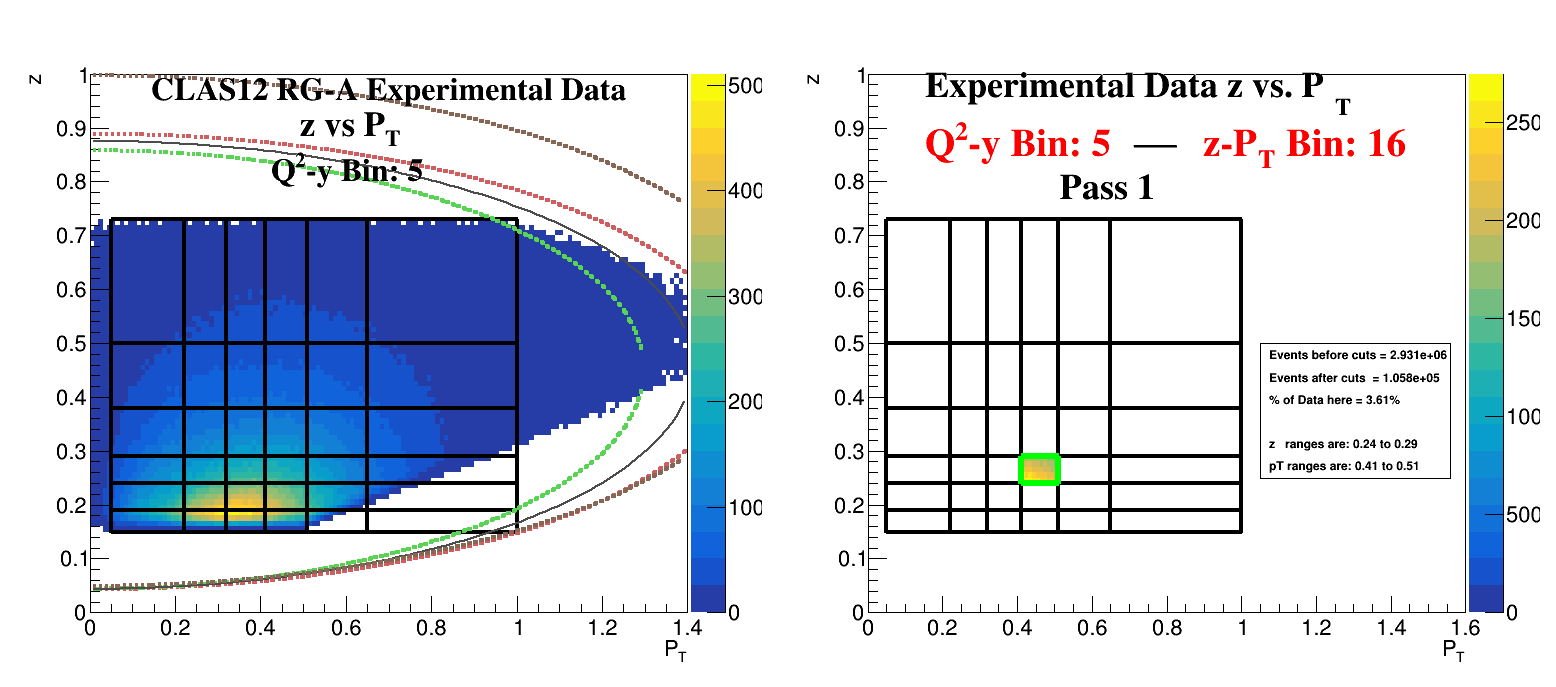

In [32]:
if(RUN_TESTS):
    Q2_y_Bin_List = range(0, 4, 1)
    Q2_y_Bin_List = range(1, 18, 1)
    # Q2_y_Bin_List = [4, 8, 12]

    # # Q2_y_Bin_List = [0, 1, 2]
    # Q2_y_Bin_List = [4, 5, 6, 7, 8]
    # Q2_y_Bin_List = [4]

    # z_pT_Range = range(-1, 0, 1)

    # Q2_y_Bin_List = [1, 2, 3, 4, 6, 7, 10]
    # z_pT_Range = [2, 14, 31]
    # z_pT_Range = [31]

    Q2_y_Bin_List = [5]

    # Q2_y_Bin_List = range(1, 18, 1)
    # z_pT_Range = [7, 31]

    z_pT_Range = range(-1, 43, 1)
    
#     z_pT_Range = range(-1, 65, 1)
    
#     z_pT_Range = range(-1, 37, 1)
    
#     z_pT_Range = range(-1, 31, 1)

    # # # z_pT_Range = range(30, 55, 1)
    # # # z_pT_Range = range(16, 30, 1)
    # # # z_pT_Range = [16, 17, 18, 19, 20, 21, 22, 29, 30, 31, 32, 33, 34, 35]
    # # z_pT_Range = [-1, 14, 21, 31, 33]
    # # z_pT_Range = [-1, 14, 31]
    # z_pT_Range = [14, 31]
    z_pT_Range = [22]
#     z_pT_Range = range(36, 65, 4)

    # z_pT_Range = range(1, 30, 7)
#     z_pT_Range = [1, 2]
    # # z_pT_Range = range(1, 37, 1)
    # # z_pT_Range = [14, 31]
    
    try:
        z_pT_Range = range(-1, Max_Bins_With_Info + 1, 1)
    except:
        print("Error with 'Max_Bins_With_Info' definition...")

    z_pT_Range = [16]

    count = 0
    histo, canvas, num_events, pave = {}, {}, {}, {}
    Fit_Function_List = {}

    Cut_First_Q = True


    #####==========###################################################==========#####
    #####==========#####     Data Selection (Type/Cut/Smear)     #####==========#####
    #####==========###################################################==========#####

    # Data_Type = "rdf"
    # Data_Type = "mdf"
    # Data_Type = "gdf"

    Data_Type_List = ["rdf"]

    # Data_Type_List = []

    for Data_Type in Data_Type_List:

        Data_Cut_List = ["'cut_Complete_SIDIS'"]
    #     Data_Cut_List = ["'cut_Complete_SIDIS_eS1o'", "'cut_Complete_SIDIS_eS2o'", "'cut_Complete_SIDIS_eS3o'", "'cut_Complete_SIDIS_eS4o'", "'cut_Complete_SIDIS_eS5o'", "'cut_Complete_SIDIS_eS6o'"]
    #     Data_Cut_List = ["'cut_Complete_SIDIS'", "'cut_Complete_SIDIS_eS1o'", "'cut_Complete_SIDIS_eS2o'"]
    #     Data_Cut_List = ["'cut_Complete_SIDIS_eS1o'"]
    #     Data_Cut_List = ["'cut_Complete_SIDIS_Exgen'"]
        # Data_Cut_List = ["cut_Complete_MM"]
    #     Data_Cut_List = ["no_cut"]

        Smear_Type = "(Smear-Type='')"
        # Smear_Type = "smear"

        for Data_Cut in Data_Cut_List:

            DataFrame          =   rdf
            if(Data_Type      in ["rdf"]):
                DataFrame      =   rdf
                Data_Cut       = Data_Cut.replace("_Gen",   "")
                Data_Cut       = Data_Cut.replace("_Exgen", "")
                Smear_Type     = "(Smear-Type='')"
            elif(Data_Type    in ["mdf", "adf", "bbb", "sbsc", "sdf"]):
                DataFrame      =   mdf
            elif(Data_Type    in ["gdf"]):
                DataFrame      =   gdf
                if("_Gen"     in Data_Cut):
                    Data_Cut   = "cut_Gen"
                elif("_Exgen" in Data_Cut):
                    Data_Cut   = "cut_Exgen"
                elif("cut_Complete_SIDIS_eS" in Data_Cut):
                    Data_Cut   = str(Data_Cut).replace("cut_Complete_SIDIS", "no_cut")
                    Data_Cut   = "'no_cut'"
                else:
                    Data_Cut   = "'no_cut'"
                Smear_Type     = "(Smear-Type='')"


            if(any(Cut_Condition in str(Data_Cut) for Cut_Condition in ["eS1a", "eS1o", "eS2a", "eS2o", "eS3a", "eS3o", "eS4a", "eS4o", "eS5a", "eS5o", "eS6a", "eS6o"])):
                if(Common_Name == "Sec_Cut_Test_V1_All"):
                    Cut_Sector_Title     = "Sector Cut: Excluding El Sector 1" if("eS1o" in Data_Cut) else "Sector Cut: Only El Sector 1" if("eS1a" in Data_Cut) else "Sector Cut: ERROR"
                else:
                    for sec in range(1, 7, 1):
                        Cut_Sector_Title = "".join(["Sector Cut: Excluding El Sector ", str(sec)]) if("".join(["eS", str(sec), "a"]) in Data_Cut) else "".join(["Sector Cut: Only El Sector ", str(sec)])
                        if("".join(["eS", str(sec)]) in Data_Cut):
                            break
            else:
                Cut_Sector_Title         = ""
            #####==========###################################################==========#####
            #####==========#####     Data Selection (Type/Cut/Smear)     #####==========#####
            #####==========###################################################==========#####


            Run_Test_Of_New_Bins = not False
            Number_of_Test_Bins  = 39
            # Number_of_Test_Bins  = 17

            # Q2_y_Bin_List = range(0, Number_of_Test_Bins + 1, 1)

            MM_z_pT_borders, MM_z_pT_legend = {}, {}

            for key in DataFrame.GetListOfKeys():
                out_print = str(key.GetName())

#                 if(("Normal_2D" not in str(out_print)) and not (elPhi_vs_phi_t or pipPhi_vs_phi_t)):
#                     # Skip the non-2D histograms (remove this condition for Response matrices or other similar plots)
#                     continue


                if(not all(Data_Conditions in str(out_print) for Data_Conditions in [Data_Type if(("adf" not in [str(Data_Type)]) and ("bbb" not in [str(Data_Type)]) and ("sdf" not in [str(Data_Type)]) and ("sbsc" not in [str(Data_Type)])) else "mdf", Data_Cut, Smear_Type])):
                    # Missing one or more of the Data Conditions (from above)
                    continue

                Q2_y_Bin  = "error"
                for Q2_y in range(-3, Number_of_Test_Bins + 1, 1):
                    if("".join(["Q2-y-Bin=", str(Q2_y) if(Q2_y != 0) else "All", ","]) in str(out_print)):
                        Q2_y_Bin = Q2_y
                        break
                if(Q2_y_Bin not in Q2_y_Bin_List):
                    continue
                # print("out_print =", out_print)

        #########################################################################################################################################################################################################################################################################################################################
        #########################################################################################################################################################################################################################################################################################################################
        #######################################################=======================#######################################################===============#####################################################################################################################################################################
        #####=====#####=====#####=====#####=====#####=====#####     z vs pT Plots     #####=====#####=====#####=====#####=====#####=====#####===============#####################################################################################################################################################################
        #######################################################=======================#######################################################===============#####################################################################################################################################################################
        #########################################################################################################################################################################################################################################################################################################################
        #########################################################################################################################################################################################################################################################################################################################
                if((all(z_vs_pT_Conditions  in str(out_print) for z_vs_pT_Conditions  in ["Var-D1='z'",  "Var-D2='pT'"]))):
                    ROOT.gStyle.SetOptStat(0)
                    print(color.BOLD, "\nout_print (for z vs pT) =\n\t", color.END, str(out_print))
                    if(Data_Type not in ["adf"]):
                        histo[out_print] = DataFrame.Get(str(out_print))
                    else:
                        histo[out_print], histo[str(out_print).replace("mdf", "Acceptance")] = Bin_Acceptance_2D(Name_mdf=str(out_print))

                    for z_pT in z_pT_Range:
                        if(Run_Test_Of_New_Bins and (z_pT in [-1, 0])):
                            continue
                        try:
                            Canvas_Name  = "".join(["cd_Q2_y_Bin_",    str(Q2_y_Bin), "_", str(out_print), "_New_Bin_", str(z_pT)])
                            Histo_Slice  = "".join(["3D_cd_Q2_y_Bin_", str(Q2_y_Bin), "_", str(out_print), "_New_Bin_", str(z_pT)])
                            canvas[Canvas_Name] = ROOT.TCanvas(str(Canvas_Name), str(Canvas_Name), 1560, 715)
                            ##################################################################...,  720, 790)
                            if(Run_Test_Of_New_Bins):
                                histo[out_print].GetXaxis().SetRangeUser(-3, 53)
                                histo[Histo_Slice] = histo[out_print].Project3D("yz")
                            elif(z_pT   in [-2]):
                                histo[out_print].GetXaxis().SetRangeUser(1, 50)
                                histo[Histo_Slice] = histo[out_print].Project3D("yz")
                            elif(z_pT in [-1]):
                                histo[out_print].GetXaxis().SetRangeUser(-3, 53)
                                histo[Histo_Slice] = histo[out_print].Project3D("yz")
                            else:
                                histo[out_print].GetXaxis().SetRangeUser(z_pT, z_pT)
                                histo[Histo_Slice] = histo[out_print].Project3D("yz")

                            Total_Num_of_Events = histo[Histo_Slice].Integral()

                            histo[Histo_Slice].GetXaxis().SetRangeUser(0, 1.8)
                            histo[Histo_Slice].GetYaxis().SetRangeUser(0, 1.1)

                            if(str(Q2_y_Bin) not in ["0"]):
                                Bin_Title = "".join(["Q^{2}-y Bin: ", str(Q2_y_Bin) if(str(Q2_y_Bin) not in ["0"]) else "All", "" if(z_pT in [-1]) else "".join([" - z-P_{T} Bin: ", str(z_pT) if(z_pT not in [-2, -1, 0]) else "Binned Only" if(z_pT in [-2]) else "All" if(z_pT in [-1]) else "Unbinned"])])
                            else:
                                Bin_Title = ""

                            Title = "".join([root_color.Bold, "{#splitline{#splitline{#scale[1.75]{CLAS12 RG-A Experimental Data}}{#scale[1.9]{          (Test) z vs P_{T}           }}}{#scale[1.75]{               ", str(Bin_Title), "           }}}"])
                            if(Cut_Sector_Title not in [""]):
                                Title = "".join(["#splitline{", str(Title), "}{", str(Cut_Sector_Title), "}"])

                            if(Data_Type == "mdf"):
                                Title = Title.replace("CLAS12 RG-A Experimental", "Monte Carlo Reconstructed")
                            if(Data_Type == "gdf"):
                                Title = Title.replace("CLAS12 RG-A Experimental", "Monte Carlo Generated")
                            if(Data_Type == "adf"):
                                Title = Title.replace("CLAS12 RG-A Experimental", "Acceptance Corrected")

                            if((z_pT > 0) and Run_Test_Of_New_Bins):
                                # Testing new bin cuts
                                y_max, y_min, x_max, x_min = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin)
                                # y_min, y_max, x_max, x_min = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin)

                                histo["".join([str(Histo_Slice), "_CUT_Num_", str(z_pT)])] = Histo_2D_Cut(histo[Histo_Slice], x_cut_min=x_min, x_cut_max=x_max, y_cut_min=y_min, y_cut_max=y_max, Cut_Name="".join(["_Num_", str(z_pT)]))
                                Bin_Title = "".join(["Q^{2}-y Bin: ",  str(Q2_y_Bin), "" if(z_pT in [-1]) else "".join([" #topbar z-P_{T} Bin: ", str(z_pT) if(z_pT not in [-2, -1, 0]) else "Binned Only" if(z_pT in [-2]) else "All" if(z_pT in [-1]) else "Unbinned"])])
                                Title_CUT = "".join([root_color.Bold, "{#splitline{#splitline{#scale[1.75]{CLAS12 RG-A Experimental Data}}{#scale[1.9]{          (Test) z vs P_{T}           }}}{#scale[1.75]{               ", str(Bin_Title), "           }}}"])
                                if(Data_Type == "mdf"):
                                    Title_CUT = Title_CUT.replace("CLAS12 RG-A Experimental", "Monte Carlo Reconstructed")
                                if(Data_Type == "gdf"):
                                    Title_CUT = Title_CUT.replace("CLAS12 RG-A Experimental", "Monte Carlo Generated")
                                if(Data_Type == "adf"):
                                    Title_CUT = Title_CUT.replace("CLAS12 RG-A Experimental", "Acceptance Corrected")
                                Title_CUT = "".join([root_color.Bold, "{#splitline{#splitline{#scale[1.75]{Experimental Data z vs. P_{T}}}{#scale[1.9]{#color[", str(root_color.Red), "]{Q^{2}-y Bin: ",  str(Q2_y_Bin), "} #topbar #color[", str(root_color.Red), "]{z-P_{T} Bin: ", str(z_pT) if(z_pT not in [-2, -1, 0]) else "Binned Only" if(z_pT in [-2]) else "All" if(z_pT in [-1]) else "Unbinned", "}}}}{#scale[1.75]{               Pass 1           }}}"])
                                Cut_Num_of_Events = histo["".join([str(Histo_Slice), "_CUT_Num_", str(z_pT)])].Integral()

                                canvas[Canvas_Name].Divide(2, 1, 0.01, 0.01)
                                canvas[Canvas_Name].cd(2)
                                # ROOT.gPad.SetLogz()
                                histo["".join([str(Histo_Slice), "_CUT_Num_", str(z_pT)])].SetTitle(Title_CUT)
                                histo["".join([str(Histo_Slice), "_CUT_Num_", str(z_pT)])].GetXaxis().SetRangeUser(0, 1.6)
                                histo["".join([str(Histo_Slice), "_CUT_Num_", str(z_pT)])].GetYaxis().SetRangeUser(0, 1.0)
                                histo["".join([str(Histo_Slice), "_CUT_Num_", str(z_pT)])].Draw("colz")

                                z_pT_borders_Cut = {}
                                Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_y_Bin)

                                z_pT_borders_Cut["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
                                z_pT_borders_Cut["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineColor(root_color.Green)
                                z_pT_borders_Cut["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(6)
                                z_pT_borders_Cut["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_max, x_min, y_max)
                                z_pT_borders_Cut["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
                                z_pT_borders_Cut["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineColor(root_color.Green)
                                z_pT_borders_Cut["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(6)
                                z_pT_borders_Cut["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_max, x_min, y_min)
                                z_pT_borders_Cut["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
                                z_pT_borders_Cut["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineColor(root_color.Green)
                                z_pT_borders_Cut["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(6)
                                z_pT_borders_Cut["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_min, x_max, y_min)
                                z_pT_borders_Cut["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
                                z_pT_borders_Cut["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineColor(root_color.Green)
                                z_pT_borders_Cut["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(6)
                                z_pT_borders_Cut["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_min, x_max, y_max)

                                pave[Canvas_Name] = draw_info_box(Total_Num=Total_Num_of_Events, Cut_Num=Cut_Num_of_Events, RATIO_Val=round((Cut_Num_of_Events/Total_Num_of_Events)*100, 3), Min_Q2=y_min, Max_Q2=y_max, Min_Y=x_min, Max_Y=x_max, Variables="z_pT")
                                canvas[Canvas_Name].Update()
                                canvas[Canvas_Name].cd(1)
                                # ROOT.gPad.SetLogz()

                                try:
                                    text_of_bin_info = text_of_bin_info.replace("".join(["Bin_",           str(z_pT), "_Info"]),  "".join(["Bin ", str(z_pT), ": ", str(round((Cut_Num_of_Events/Total_Num_of_Events)*100, 3))]))
                                    text_of_bin_info = text_of_bin_info.replace("".join(["Column_",        str(z_pT), "_Left"]),  "".join(["pT Min Edge: ", str(x_min)]))
                                    text_of_bin_info = text_of_bin_info.replace("".join(["Column_",        str(z_pT), "_Right"]), "".join(["pT Max Edge: ", str(x_max)]))
                                    text_of_bin_info = text_of_bin_info.replace("".join(["Row_Lower_Bin_", str(z_pT), "_Edge"]),  "".join(["z Min Edge: ",  str(y_min)]))
                                    text_of_bin_info = text_of_bin_info.replace("".join(["Row_Upper_Bin_", str(z_pT), "_Edge"]),  "".join(["z Max Edge: ",  str(y_max)]))
                                    # print(text_of_bin_info)
                                except:
                                    print("'text_of_bin_info' is not defined...")
                            
                            
                            Title = Title.replace("(Test) z vs ", "       z vs ")
                            Title = Title.replace("".join([" - z-P_{T} Bin: ", str(z_pT)]), "")
                            histo[Histo_Slice].SetTitle(str(Title))
                            histo[Histo_Slice].GetXaxis().SetRangeUser(0, 1.4)
                            histo[Histo_Slice].GetYaxis().SetRangeUser(0, 1.0)
                            histo[Histo_Slice].Draw("colz")

                            Draw_MM_Cuts_Q = not False
                            if(str(Q2_y_Bin) not in ["0", "All", "-3"]):
                                z_pT_borders = {}
                                Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_y_Bin)
                                
                                if(Draw_MM_Cuts_Q):
                                    # Create the TLegend
                                    MM_z_pT_legend["".join(["Q2_y_Bin_",  str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])] = ROOT.TLegend(0.65, 0.1, 0.95, 0.25)  # (x1, y1, x2, y2)
                                    MM_z_pT_legend["".join(["Q2_y_Bin_",  str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])].SetNColumns(2)
                                    MM_z_pT_borders["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])] = {}
                                    MM_z_pT_borders["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])], MM_z_pT_legend["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])] = Draw_the_MM_Cut_Lines(MM_z_pT_legend["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])], MM_z_pT_borders=MM_z_pT_borders["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])], Q2_Y_Bin=Q2_y_Bin, Plot_Orientation="z_pT")
                                    del MM_z_pT_legend["".join(["Q2_y_Bin_",  str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])]

                                    for MM_lines in MM_z_pT_borders["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])]:
                                        MM_z_pT_borders["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])][MM_lines].Draw("same")
                                    # MM_z_pT_legend["".join(["Q2_y_Bin_", str(Q2_y_Bin), "_z_pT_Bin_", str(z_pT)])].Draw("same")

                            canvas[Canvas_Name].Draw()
                            canvas[Canvas_Name].Update()
                            if(False and (z_pT in [16])):
                                Save_Name_z_pT     = Canvas_Name.replace("".join(["cd_Q2_y_Bin_", str(Q2_y_Bin), "_((Histo-Group='Normal_2D'), (Data-Type='"]), "Histo_2D_")
                                Save_Name_z_pT     = Save_Name_z_pT.replace("'), (Data-Cut='", "_")
                                Save_Name_z_pT     = Save_Name_z_pT.replace("'), (Smear-Type=", "_")
                                Save_Name_z_pT     = Save_Name_z_pT.replace("''", "no_smear")
                                Save_Name_z_pT     = Save_Name_z_pT.replace("".join(["), (Binning-Type='Y_bin'-[Q2-y-Bin=", str(Q2_y_Bin), ", z-PT-Bin=All]), (Var-D1='z'-[NumBins=120, MinBin=0, MaxBin=1.2]), (Var-D2='pT'-[NumBins=200, MinBin=0, MaxBin=2.0]))"]), "".join(["_Q2_y_Bin_", str(Q2_y_Bin), "_z_vs_pT"]))
                                Save_Name_z_pT     = Save_Name_z_pT.replace("".join(["), (Binning-Type='y_bin'-[Q2-y-Bin=", str(Q2_y_Bin), ", z-PT-Bin=All]), (Var-D1='z'-[NumBins=120, MinBin=0, MaxBin=1.2]), (Var-D2='pT'-[NumBins=200, MinBin=0, MaxBin=2.0]))"]), "".join(["_Q2_y_Bin_", str(Q2_y_Bin), "_z_vs_pT"]))
                                # Save_Name_z_pT     = "".join([Save_Name_z_pT, ".png"])
                                Save_Name_z_pT     = "".join([Save_Name_z_pT, ".root"])
                                if(Data_Type in ["adf"]):
                                    Save_Name_z_pT = Save_Name_z_pT.replace("mdf", "adf")
                                print(color.GREEN, "\nSaving Save_Name_z_pT =\n\t", color.END, color.BOLD, Save_Name_z_pT, color.END)
                                canvas[Canvas_Name].SaveAs(Save_Name_z_pT)
                            count += 1
                        except:
                            print("".join([color.ERROR, "\nFailed to run z-pT Bin code for Q2_y_Bin_", str(Q2_y_Bin), " and z_pT_Bin_", str(z_pT), "...", color.END]))
                            print(str(traceback.format_exc()).replace("\n", "\n\t"))
                            break
        #########################################################################################################################################################################################################################################################################################################################
        #########################################################################################################################################################################################################################################################################################################################
        #######################################################=======================#######################################################===============#####################################################################################################################################################################
        #####=====#####=====#####=====#####=====#####=====#####   z vs pT Plots (End) #####=====#####=====#####=====#####=====#####=====#####===============#####################################################################################################################################################################
        #######################################################=======================#######################################################===============#####################################################################################################################################################################
        #########################################################################################################################################################################################################################################################################################################################
        #########################################################################################################################################################################################################################################################################################################################

    print("\nMade a total of", count, "Histograms (canvases to print)")
    print("DONE")
else:
    print(f"{color.Error}RUN_TESTS = {RUN_TESTS}...{color.END}\n\n{color.BOLD}Must set this value to 'True' in order to run this cell (see the cells above){color.END}")

.

.



## text_of_bin_info print
Copy the output of this cell into excel to break down the content of each z-pT bin

In [11]:
try:
    text_of_bin_info = text_of_bin_info.replace(", ", ",")
    text_of_bin_info = text_of_bin_info.replace("6,|,|,z Min", "6,|,|,|,|,z Min")
    print(text_of_bin_info.replace(", ", ","))
except:
    print("'text_of_bin_info' is not defined yet...")


Column_1_Left,Bin_1_Info,Column_2_Left,Bin_2_Info,Column_3_Left,Bin_3_Info,Column_4_Left,Bin_4_Info,Column_4_Right,|,|,Row_Lower_Bin_4_Edge,Row_Upper_Bin_4_Edge
Column_1_Left,Bin_5_Info,Column_2_Left,Bin_6_Info,Column_3_Left,Bin_7_Info,Column_4_Left,Bin_8_Info,Column_4_Right,|,|,Row_Lower_Bin_8_Edge,Row_Upper_Bin_8_Edge
Column_1_Left,Bin_9_Info,Column_2_Left,Bin_10_Info,Column_3_Left,Bin_11_Info,Column_4_Left,Bin_12_Info,Column_4_Right,|,|,Row_Lower_Bin_12_Edge,Row_Upper_Bin_12_Edge
Column_1_Left,Bin_13_Info,Column_2_Left,Bin_14_Info,Column_3_Left,Bin_15_Info,Column_4_Left,Bin 16: 3.609,Column_4_Right,|,|,z Min Edge: 0.24,z Max Edge: 0.29
Column_1_Left,Bin_17_Info,Column_2_Left,Bin_18_Info,Column_3_Left,Bin_19_Info,Column_4_Left,Bin_20_Info,Column_4_Right,|,|,Row_Lower_Bin_20_Edge,Row_Upper_Bin_20_Edge


In [12]:
del text_of_bin_info

.

.

.

# Creating text of Bin_Definition_Array

In [13]:
if(RUN_TESTS and not RUN_SET_BINS):
    print_OUTPUT = "".join([color.BOLD, "New Bin_Definition_Array Definition:\n\n", color.END, "Bin_Definition_Array = {"])
    Start_Q2_y_Bin = 1
    End___Q2_y_Bin = 17
    for Q2_y_ii in range(Start_Q2_y_Bin, End___Q2_y_Bin + 1, 1):
        New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_ii)
        z_Borders  = New_z_pT_Bin_Test_List[0][2]
        pT_Borders = New_z_pT_Bin_Test_List[1][2]
        rows    = len(z_Borders)  - 1
        columns = len(pT_Borders) - 1
        Number_Analysis_Bins = (rows)*(columns)
        Number_Overflow_Bins = ((rows + 2)*(columns + 2)) - Number_Analysis_Bins
        Number_Overflow_Bins = 0
        for z_pT_ii in range(1, (Number_Analysis_Bins + Number_Overflow_Bins) + 1, 1):
            print_OUTPUT = "".join([print_OUTPUT, f"'Q2-y={Q2_y_ii}, z-pT={z_pT_ii}", " - REMOVE - MIGRATION BIN" if(z_pT_Bin_Colors_with_Migration(z_pT_Bin_Num=z_pT_ii, Q2_y_Bin_Num=Q2_y_ii) in [41]) else " - MIGRATION BIN" if(z_pT_ii > Number_Analysis_Bins) else "", f"': {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_ii, Q2_y_Bin_Num=Q2_y_ii)},\n"])
#             # break
#         # print("".join([f"'Q2-y={Q2_y_ii}, z-pT={z_pT_ii}", " - REMOVE, MIGRATION BIN" if(z_pT_Bin_Colors_with_Migration(z_pT_Bin_Num=z_pT_ii, Q2_y_Bin_Num=Q2_y_ii) in [41]) else " - MIGRATION BIN" if(z_pT_ii > Number_Analysis_Bins) else "", f"': {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_ii, Q2_y_Bin_Num=Q2_y_ii)},"]))
    print(f"{print_OUTPUT}'Q2-y=18': 'end'"+"}")
else:
    print(f"{color.Error}(RUN_TESTS = {RUN_TESTS}) AND ((not RUN_SET_BINS) = {not RUN_SET_BINS}){color.END}{color.BOLD}\n\tNot Running New Bin Tests...{color.END}")

New Bin_Definition_Array Definition:

Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.2, 0.15, 0.2, 0.05],
'Q2-y=1, z-pT=2': [0.2, 0.15, 0.3, 0.2],
'Q2-y=1, z-pT=3': [0.2, 0.15, 0.4, 0.3],
'Q2-y=1, z-pT=4': [0.2, 0.15, 0.5, 0.4],
'Q2-y=1, z-pT=5': [0.2, 0.15, 0.6, 0.5],
'Q2-y=1, z-pT=6': [0.2, 0.15, 0.75, 0.6],
'Q2-y=1, z-pT=7': [0.2, 0.15, 1.0, 0.75],
'Q2-y=1, z-pT=8': [0.24, 0.2, 0.2, 0.05],
'Q2-y=1, z-pT=9': [0.24, 0.2, 0.3, 0.2],
'Q2-y=1, z-pT=10': [0.24, 0.2, 0.4, 0.3],
'Q2-y=1, z-pT=11': [0.24, 0.2, 0.5, 0.4],
'Q2-y=1, z-pT=12': [0.24, 0.2, 0.6, 0.5],
'Q2-y=1, z-pT=13': [0.24, 0.2, 0.75, 0.6],
'Q2-y=1, z-pT=14': [0.24, 0.2, 1.0, 0.75],
'Q2-y=1, z-pT=15': [0.29, 0.24, 0.2, 0.05],
'Q2-y=1, z-pT=16': [0.29, 0.24, 0.3, 0.2],
'Q2-y=1, z-pT=17': [0.29, 0.24, 0.4, 0.3],
'Q2-y=1, z-pT=18': [0.29, 0.24, 0.5, 0.4],
'Q2-y=1, z-pT=19': [0.29, 0.24, 0.6, 0.5],
'Q2-y=1, z-pT=20': [0.29, 0.24, 0.75, 0.6],
'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.24, 1.0, 0.75],
'Q2-y=1, z-pT=22': [0.4,

## Define Bin_Definition_Array
Copy and Paste the output text of the cell above

In [14]:
Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.71, 0.4, 0.22, 0.05],
'Q2-y=1, z-pT=2': [0.71, 0.4, 0.32, 0.22],
'Q2-y=1, z-pT=3': [0.71, 0.4, 0.42, 0.32],
'Q2-y=1, z-pT=4': [0.71, 0.4, 0.52, 0.42],
'Q2-y=1, z-pT=5': [0.71, 0.4, 0.63, 0.52],
'Q2-y=1, z-pT=6': [0.71, 0.4, 0.75, 0.63],
'Q2-y=1, z-pT=7': [0.71, 0.4, 0.99, 0.75],
'Q2-y=1, z-pT=8': [0.4, 0.29, 0.22, 0.05],
'Q2-y=1, z-pT=9': [0.4, 0.29, 0.32, 0.22],
'Q2-y=1, z-pT=10': [0.4, 0.29, 0.42, 0.32],
'Q2-y=1, z-pT=11': [0.4, 0.29, 0.52, 0.42],
'Q2-y=1, z-pT=12': [0.4, 0.29, 0.63, 0.52],
'Q2-y=1, z-pT=13': [0.4, 0.29, 0.75, 0.63],
'Q2-y=1, z-pT=14': [0.4, 0.29, 0.99, 0.75],
'Q2-y=1, z-pT=15': [0.29, 0.23, 0.22, 0.05],
'Q2-y=1, z-pT=16': [0.29, 0.23, 0.32, 0.22],
'Q2-y=1, z-pT=17': [0.29, 0.23, 0.42, 0.32],
'Q2-y=1, z-pT=18': [0.29, 0.23, 0.52, 0.42],
'Q2-y=1, z-pT=19': [0.29, 0.23, 0.63, 0.52],
'Q2-y=1, z-pT=20': [0.29, 0.23, 0.75, 0.63],
'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.23, 0.99, 0.75],
'Q2-y=1, z-pT=22': [0.23, 0.19, 0.22, 0.05],
'Q2-y=1, z-pT=23': [0.23, 0.19, 0.32, 0.22],
'Q2-y=1, z-pT=24': [0.23, 0.19, 0.42, 0.32],
'Q2-y=1, z-pT=25': [0.23, 0.19, 0.52, 0.42],
'Q2-y=1, z-pT=26': [0.23, 0.19, 0.63, 0.52],
'Q2-y=1, z-pT=27 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.75, 0.63],
'Q2-y=1, z-pT=28 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.99, 0.75],
'Q2-y=1, z-pT=29': [0.19, 0.16, 0.22, 0.05],
'Q2-y=1, z-pT=30': [0.19, 0.16, 0.32, 0.22],
'Q2-y=1, z-pT=31': [0.19, 0.16, 0.42, 0.32],
'Q2-y=1, z-pT=32': [0.19, 0.16, 0.52, 0.42],
'Q2-y=1, z-pT=33 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.63, 0.52],
'Q2-y=1, z-pT=34 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.75, 0.63],
'Q2-y=1, z-pT=35 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.99, 0.75],
'Q2-y=2, z-pT=1': [0.75, 0.5, 0.25, 0.05],
'Q2-y=2, z-pT=2': [0.75, 0.5, 0.35, 0.25],
'Q2-y=2, z-pT=3': [0.75, 0.5, 0.45, 0.35],
'Q2-y=2, z-pT=4': [0.75, 0.5, 0.54, 0.45],
'Q2-y=2, z-pT=5': [0.75, 0.5, 0.67, 0.54],
'Q2-y=2, z-pT=6': [0.75, 0.5, 0.93, 0.67],
'Q2-y=2, z-pT=7': [0.5, 0.38, 0.25, 0.05],
'Q2-y=2, z-pT=8': [0.5, 0.38, 0.35, 0.25],
'Q2-y=2, z-pT=9': [0.5, 0.38, 0.45, 0.35],
'Q2-y=2, z-pT=10': [0.5, 0.38, 0.54, 0.45],
'Q2-y=2, z-pT=11': [0.5, 0.38, 0.67, 0.54],
'Q2-y=2, z-pT=12': [0.5, 0.38, 0.93, 0.67],
'Q2-y=2, z-pT=13': [0.38, 0.31, 0.25, 0.05],
'Q2-y=2, z-pT=14': [0.38, 0.31, 0.35, 0.25],
'Q2-y=2, z-pT=15': [0.38, 0.31, 0.45, 0.35],
'Q2-y=2, z-pT=16': [0.38, 0.31, 0.54, 0.45],
'Q2-y=2, z-pT=17': [0.38, 0.31, 0.67, 0.54],
'Q2-y=2, z-pT=18': [0.38, 0.31, 0.93, 0.67],
'Q2-y=2, z-pT=19': [0.31, 0.26, 0.25, 0.05],
'Q2-y=2, z-pT=20': [0.31, 0.26, 0.35, 0.25],
'Q2-y=2, z-pT=21': [0.31, 0.26, 0.45, 0.35],
'Q2-y=2, z-pT=22': [0.31, 0.26, 0.54, 0.45],
'Q2-y=2, z-pT=23': [0.31, 0.26, 0.67, 0.54],
'Q2-y=2, z-pT=24 - REMOVE - MIGRATION BIN': [0.31, 0.26, 0.93, 0.67],
'Q2-y=2, z-pT=25': [0.26, 0.23, 0.25, 0.05],
'Q2-y=2, z-pT=26': [0.26, 0.23, 0.35, 0.25],
'Q2-y=2, z-pT=27': [0.26, 0.23, 0.45, 0.35],
'Q2-y=2, z-pT=28': [0.26, 0.23, 0.54, 0.45],
'Q2-y=2, z-pT=29': [0.26, 0.23, 0.67, 0.54],
'Q2-y=2, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.93, 0.67],
'Q2-y=2, z-pT=31': [0.23, 0.19, 0.25, 0.05],
'Q2-y=2, z-pT=32': [0.23, 0.19, 0.35, 0.25],
'Q2-y=2, z-pT=33': [0.23, 0.19, 0.45, 0.35],
'Q2-y=2, z-pT=34': [0.23, 0.19, 0.54, 0.45],
'Q2-y=2, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.67, 0.54],
'Q2-y=2, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.93, 0.67],
'Q2-y=3, z-pT=1': [0.75, 0.56, 0.2, 0.05],
'Q2-y=3, z-pT=2': [0.75, 0.56, 0.3, 0.2],
'Q2-y=3, z-pT=3': [0.75, 0.56, 0.39, 0.3],
'Q2-y=3, z-pT=4': [0.75, 0.56, 0.49, 0.39],
'Q2-y=3, z-pT=5': [0.75, 0.56, 0.59, 0.49],
'Q2-y=3, z-pT=6': [0.75, 0.56, 0.76, 0.59],
'Q2-y=3, z-pT=7': [0.56, 0.41, 0.2, 0.05],
'Q2-y=3, z-pT=8': [0.56, 0.41, 0.3, 0.2],
'Q2-y=3, z-pT=9': [0.56, 0.41, 0.39, 0.3],
'Q2-y=3, z-pT=10': [0.56, 0.41, 0.49, 0.39],
'Q2-y=3, z-pT=11': [0.56, 0.41, 0.59, 0.49],
'Q2-y=3, z-pT=12': [0.56, 0.41, 0.76, 0.59],
'Q2-y=3, z-pT=13': [0.41, 0.33, 0.2, 0.05],
'Q2-y=3, z-pT=14': [0.41, 0.33, 0.3, 0.2],
'Q2-y=3, z-pT=15': [0.41, 0.33, 0.39, 0.3],
'Q2-y=3, z-pT=16': [0.41, 0.33, 0.49, 0.39],
'Q2-y=3, z-pT=17': [0.41, 0.33, 0.59, 0.49],
'Q2-y=3, z-pT=18': [0.41, 0.33, 0.76, 0.59],
'Q2-y=3, z-pT=19': [0.33, 0.28, 0.2, 0.05],
'Q2-y=3, z-pT=20': [0.33, 0.28, 0.3, 0.2],
'Q2-y=3, z-pT=21': [0.33, 0.28, 0.39, 0.3],
'Q2-y=3, z-pT=22': [0.33, 0.28, 0.49, 0.39],
'Q2-y=3, z-pT=23': [0.33, 0.28, 0.59, 0.49],
'Q2-y=3, z-pT=24': [0.33, 0.28, 0.76, 0.59],
'Q2-y=3, z-pT=25': [0.28, 0.22, 0.2, 0.05],
'Q2-y=3, z-pT=26': [0.28, 0.22, 0.3, 0.2],
'Q2-y=3, z-pT=27': [0.28, 0.22, 0.39, 0.3],
'Q2-y=3, z-pT=28': [0.28, 0.22, 0.49, 0.39],
'Q2-y=3, z-pT=29': [0.28, 0.22, 0.59, 0.49],
'Q2-y=3, z-pT=30 - REMOVE - MIGRATION BIN': [0.28, 0.22, 0.76, 0.59],
'Q2-y=4, z-pT=1': [0.71, 0.59, 0.2, 0.05],
'Q2-y=4, z-pT=2': [0.71, 0.59, 0.29, 0.2],
'Q2-y=4, z-pT=3': [0.71, 0.59, 0.38, 0.29],
'Q2-y=4, z-pT=4': [0.71, 0.59, 0.48, 0.38],
'Q2-y=4, z-pT=5': [0.71, 0.59, 0.61, 0.48],
'Q2-y=4, z-pT=6 - REMOVE - MIGRATION BIN': [0.71, 0.59, 0.85, 0.61],
'Q2-y=4, z-pT=7': [0.59, 0.5, 0.2, 0.05],
'Q2-y=4, z-pT=8': [0.59, 0.5, 0.29, 0.2],
'Q2-y=4, z-pT=9': [0.59, 0.5, 0.38, 0.29],
'Q2-y=4, z-pT=10': [0.59, 0.5, 0.48, 0.38],
'Q2-y=4, z-pT=11': [0.59, 0.5, 0.61, 0.48],
'Q2-y=4, z-pT=12': [0.59, 0.5, 0.85, 0.61],
'Q2-y=4, z-pT=13': [0.5, 0.43, 0.2, 0.05],
'Q2-y=4, z-pT=14': [0.5, 0.43, 0.29, 0.2],
'Q2-y=4, z-pT=15': [0.5, 0.43, 0.38, 0.29],
'Q2-y=4, z-pT=16': [0.5, 0.43, 0.48, 0.38],
'Q2-y=4, z-pT=17': [0.5, 0.43, 0.61, 0.48],
'Q2-y=4, z-pT=18': [0.5, 0.43, 0.85, 0.61],
'Q2-y=4, z-pT=19': [0.43, 0.38, 0.2, 0.05],
'Q2-y=4, z-pT=20': [0.43, 0.38, 0.29, 0.2],
'Q2-y=4, z-pT=21': [0.43, 0.38, 0.38, 0.29],
'Q2-y=4, z-pT=22': [0.43, 0.38, 0.48, 0.38],
'Q2-y=4, z-pT=23': [0.43, 0.38, 0.61, 0.48],
'Q2-y=4, z-pT=24': [0.43, 0.38, 0.85, 0.61],
'Q2-y=4, z-pT=25': [0.38, 0.33, 0.2, 0.05],
'Q2-y=4, z-pT=26': [0.38, 0.33, 0.29, 0.2],
'Q2-y=4, z-pT=27': [0.38, 0.33, 0.38, 0.29],
'Q2-y=4, z-pT=28': [0.38, 0.33, 0.48, 0.38],
'Q2-y=4, z-pT=29': [0.38, 0.33, 0.61, 0.48],
'Q2-y=4, z-pT=30 - REMOVE - MIGRATION BIN': [0.38, 0.33, 0.85, 0.61],
'Q2-y=4, z-pT=31': [0.33, 0.26, 0.2, 0.05],
'Q2-y=4, z-pT=32': [0.33, 0.26, 0.29, 0.2],
'Q2-y=4, z-pT=33': [0.33, 0.26, 0.38, 0.29],
'Q2-y=4, z-pT=34': [0.33, 0.26, 0.48, 0.38],
'Q2-y=4, z-pT=35': [0.33, 0.26, 0.61, 0.48],
'Q2-y=4, z-pT=36 - REMOVE - MIGRATION BIN': [0.33, 0.26, 0.85, 0.61],
'Q2-y=5, z-pT=1': [0.72, 0.49, 0.22, 0.05],
'Q2-y=5, z-pT=2': [0.72, 0.49, 0.32, 0.22],
'Q2-y=5, z-pT=3': [0.72, 0.49, 0.41, 0.32],
'Q2-y=5, z-pT=4': [0.72, 0.49, 0.51, 0.41],
'Q2-y=5, z-pT=5': [0.72, 0.49, 0.65, 0.51],
'Q2-y=5, z-pT=6': [0.72, 0.49, 0.98, 0.65],
'Q2-y=5, z-pT=7': [0.49, 0.38, 0.22, 0.05],
'Q2-y=5, z-pT=8': [0.49, 0.38, 0.32, 0.22],
'Q2-y=5, z-pT=9': [0.49, 0.38, 0.41, 0.32],
'Q2-y=5, z-pT=10': [0.49, 0.38, 0.51, 0.41],
'Q2-y=5, z-pT=11': [0.49, 0.38, 0.65, 0.51],
'Q2-y=5, z-pT=12': [0.49, 0.38, 0.98, 0.65],
'Q2-y=5, z-pT=13': [0.38, 0.3, 0.22, 0.05],
'Q2-y=5, z-pT=14': [0.38, 0.3, 0.32, 0.22],
'Q2-y=5, z-pT=15': [0.38, 0.3, 0.41, 0.32],
'Q2-y=5, z-pT=16': [0.38, 0.3, 0.51, 0.41],
'Q2-y=5, z-pT=17': [0.38, 0.3, 0.65, 0.51],
'Q2-y=5, z-pT=18': [0.38, 0.3, 0.98, 0.65],
'Q2-y=5, z-pT=19': [0.3, 0.24, 0.22, 0.05],
'Q2-y=5, z-pT=20': [0.3, 0.24, 0.32, 0.22],
'Q2-y=5, z-pT=21': [0.3, 0.24, 0.41, 0.32],
'Q2-y=5, z-pT=22': [0.3, 0.24, 0.51, 0.41],
'Q2-y=5, z-pT=23': [0.3, 0.24, 0.65, 0.51],
'Q2-y=5, z-pT=24 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.98, 0.65],
'Q2-y=5, z-pT=25': [0.24, 0.2, 0.22, 0.05],
'Q2-y=5, z-pT=26': [0.24, 0.2, 0.32, 0.22],
'Q2-y=5, z-pT=27': [0.24, 0.2, 0.41, 0.32],
'Q2-y=5, z-pT=28': [0.24, 0.2, 0.51, 0.41],
'Q2-y=5, z-pT=29': [0.24, 0.2, 0.65, 0.51],
'Q2-y=5, z-pT=30 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.98, 0.65],
'Q2-y=5, z-pT=31': [0.2, 0.16, 0.22, 0.05],
'Q2-y=5, z-pT=32': [0.2, 0.16, 0.32, 0.22],
'Q2-y=5, z-pT=33': [0.2, 0.16, 0.41, 0.32],
'Q2-y=5, z-pT=34': [0.2, 0.16, 0.51, 0.41],
'Q2-y=5, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.65, 0.51],
'Q2-y=5, z-pT=36 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.98, 0.65],
'Q2-y=6, z-pT=1': [0.72, 0.45, 0.22, 0.05],
'Q2-y=6, z-pT=2': [0.72, 0.45, 0.32, 0.22],
'Q2-y=6, z-pT=3': [0.72, 0.45, 0.41, 0.32],
'Q2-y=6, z-pT=4': [0.72, 0.45, 0.51, 0.41],
'Q2-y=6, z-pT=5': [0.72, 0.45, 0.65, 0.51],
'Q2-y=6, z-pT=6': [0.72, 0.45, 1.0, 0.65],
'Q2-y=6, z-pT=7': [0.45, 0.35, 0.22, 0.05],
'Q2-y=6, z-pT=8': [0.45, 0.35, 0.32, 0.22],
'Q2-y=6, z-pT=9': [0.45, 0.35, 0.41, 0.32],
'Q2-y=6, z-pT=10': [0.45, 0.35, 0.51, 0.41],
'Q2-y=6, z-pT=11': [0.45, 0.35, 0.65, 0.51],
'Q2-y=6, z-pT=12': [0.45, 0.35, 1.0, 0.65],
'Q2-y=6, z-pT=13': [0.35, 0.28, 0.22, 0.05],
'Q2-y=6, z-pT=14': [0.35, 0.28, 0.32, 0.22],
'Q2-y=6, z-pT=15': [0.35, 0.28, 0.41, 0.32],
'Q2-y=6, z-pT=16': [0.35, 0.28, 0.51, 0.41],
'Q2-y=6, z-pT=17': [0.35, 0.28, 0.65, 0.51],
'Q2-y=6, z-pT=18 - REMOVE - MIGRATION BIN': [0.35, 0.28, 1.0, 0.65],
'Q2-y=6, z-pT=19': [0.28, 0.23, 0.22, 0.05],
'Q2-y=6, z-pT=20': [0.28, 0.23, 0.32, 0.22],
'Q2-y=6, z-pT=21': [0.28, 0.23, 0.41, 0.32],
'Q2-y=6, z-pT=22': [0.28, 0.23, 0.51, 0.41],
'Q2-y=6, z-pT=23': [0.28, 0.23, 0.65, 0.51],
'Q2-y=6, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 1.0, 0.65],
'Q2-y=6, z-pT=25': [0.23, 0.18, 0.22, 0.05],
'Q2-y=6, z-pT=26': [0.23, 0.18, 0.32, 0.22],
'Q2-y=6, z-pT=27': [0.23, 0.18, 0.41, 0.32],
'Q2-y=6, z-pT=28': [0.23, 0.18, 0.51, 0.41],
'Q2-y=6, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.18, 0.65, 0.51],
'Q2-y=6, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.18, 1.0, 0.65],
'Q2-y=7, z-pT=1': [0.77, 0.58, 0.2, 0.05],
'Q2-y=7, z-pT=2': [0.77, 0.58, 0.29, 0.2],
'Q2-y=7, z-pT=3': [0.77, 0.58, 0.38, 0.29],
'Q2-y=7, z-pT=4': [0.77, 0.58, 0.48, 0.38],
'Q2-y=7, z-pT=5': [0.77, 0.58, 0.6, 0.48],
'Q2-y=7, z-pT=6 - REMOVE - MIGRATION BIN': [0.77, 0.58, 0.83, 0.6],
'Q2-y=7, z-pT=7': [0.58, 0.45, 0.2, 0.05],
'Q2-y=7, z-pT=8': [0.58, 0.45, 0.29, 0.2],
'Q2-y=7, z-pT=9': [0.58, 0.45, 0.38, 0.29],
'Q2-y=7, z-pT=10': [0.58, 0.45, 0.48, 0.38],
'Q2-y=7, z-pT=11': [0.58, 0.45, 0.6, 0.48],
'Q2-y=7, z-pT=12': [0.58, 0.45, 0.83, 0.6],
'Q2-y=7, z-pT=13': [0.45, 0.37, 0.2, 0.05],
'Q2-y=7, z-pT=14': [0.45, 0.37, 0.29, 0.2],
'Q2-y=7, z-pT=15': [0.45, 0.37, 0.38, 0.29],
'Q2-y=7, z-pT=16': [0.45, 0.37, 0.48, 0.38],
'Q2-y=7, z-pT=17': [0.45, 0.37, 0.6, 0.48],
'Q2-y=7, z-pT=18': [0.45, 0.37, 0.83, 0.6],
'Q2-y=7, z-pT=19': [0.37, 0.31, 0.2, 0.05],
'Q2-y=7, z-pT=20': [0.37, 0.31, 0.29, 0.2],
'Q2-y=7, z-pT=21': [0.37, 0.31, 0.38, 0.29],
'Q2-y=7, z-pT=22': [0.37, 0.31, 0.48, 0.38],
'Q2-y=7, z-pT=23': [0.37, 0.31, 0.6, 0.48],
'Q2-y=7, z-pT=24': [0.37, 0.31, 0.83, 0.6],
'Q2-y=7, z-pT=25': [0.31, 0.27, 0.2, 0.05],
'Q2-y=7, z-pT=26': [0.31, 0.27, 0.29, 0.2],
'Q2-y=7, z-pT=27': [0.31, 0.27, 0.38, 0.29],
'Q2-y=7, z-pT=28': [0.31, 0.27, 0.48, 0.38],
'Q2-y=7, z-pT=29': [0.31, 0.27, 0.6, 0.48],
'Q2-y=7, z-pT=30 - REMOVE - MIGRATION BIN': [0.31, 0.27, 0.83, 0.6],
'Q2-y=7, z-pT=31': [0.27, 0.22, 0.2, 0.05],
'Q2-y=7, z-pT=32': [0.27, 0.22, 0.29, 0.2],
'Q2-y=7, z-pT=33': [0.27, 0.22, 0.38, 0.29],
'Q2-y=7, z-pT=34': [0.27, 0.22, 0.48, 0.38],
'Q2-y=7, z-pT=35': [0.27, 0.22, 0.6, 0.48],
'Q2-y=7, z-pT=36 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.83, 0.6],
'Q2-y=8, z-pT=1': [0.7, 0.56, 0.2, 0.05],
'Q2-y=8, z-pT=2': [0.7, 0.56, 0.29, 0.2],
'Q2-y=8, z-pT=3': [0.7, 0.56, 0.37, 0.29],
'Q2-y=8, z-pT=4': [0.7, 0.56, 0.46, 0.37],
'Q2-y=8, z-pT=5': [0.7, 0.56, 0.6, 0.46],
'Q2-y=8, z-pT=6': [0.56, 0.49, 0.2, 0.05],
'Q2-y=8, z-pT=7': [0.56, 0.49, 0.29, 0.2],
'Q2-y=8, z-pT=8': [0.56, 0.49, 0.37, 0.29],
'Q2-y=8, z-pT=9': [0.56, 0.49, 0.46, 0.37],
'Q2-y=8, z-pT=10': [0.56, 0.49, 0.6, 0.46],
'Q2-y=8, z-pT=11': [0.49, 0.44, 0.2, 0.05],
'Q2-y=8, z-pT=12': [0.49, 0.44, 0.29, 0.2],
'Q2-y=8, z-pT=13': [0.49, 0.44, 0.37, 0.29],
'Q2-y=8, z-pT=14': [0.49, 0.44, 0.46, 0.37],
'Q2-y=8, z-pT=15': [0.49, 0.44, 0.6, 0.46],
'Q2-y=8, z-pT=16': [0.44, 0.39, 0.2, 0.05],
'Q2-y=8, z-pT=17': [0.44, 0.39, 0.29, 0.2],
'Q2-y=8, z-pT=18': [0.44, 0.39, 0.37, 0.29],
'Q2-y=8, z-pT=19': [0.44, 0.39, 0.46, 0.37],
'Q2-y=8, z-pT=20': [0.44, 0.39, 0.6, 0.46],
'Q2-y=8, z-pT=21': [0.39, 0.36, 0.2, 0.05],
'Q2-y=8, z-pT=22': [0.39, 0.36, 0.29, 0.2],
'Q2-y=8, z-pT=23': [0.39, 0.36, 0.37, 0.29],
'Q2-y=8, z-pT=24': [0.39, 0.36, 0.46, 0.37],
'Q2-y=8, z-pT=25': [0.39, 0.36, 0.6, 0.46],
'Q2-y=8, z-pT=26': [0.36, 0.33, 0.2, 0.05],
'Q2-y=8, z-pT=27': [0.36, 0.33, 0.29, 0.2],
'Q2-y=8, z-pT=28': [0.36, 0.33, 0.37, 0.29],
'Q2-y=8, z-pT=29': [0.36, 0.33, 0.46, 0.37],
'Q2-y=8, z-pT=30': [0.36, 0.33, 0.6, 0.46],
'Q2-y=8, z-pT=31': [0.33, 0.27, 0.2, 0.05],
'Q2-y=8, z-pT=32': [0.33, 0.27, 0.29, 0.2],
'Q2-y=8, z-pT=33': [0.33, 0.27, 0.37, 0.29],
'Q2-y=8, z-pT=34': [0.33, 0.27, 0.46, 0.37],
'Q2-y=8, z-pT=35': [0.33, 0.27, 0.6, 0.46],
'Q2-y=9, z-pT=1': [0.7, 0.42, 0.22, 0.05],
'Q2-y=9, z-pT=2': [0.7, 0.42, 0.3, 0.22],
'Q2-y=9, z-pT=3': [0.7, 0.42, 0.38, 0.3],
'Q2-y=9, z-pT=4': [0.7, 0.42, 0.46, 0.38],
'Q2-y=9, z-pT=5': [0.7, 0.42, 0.58, 0.46],
'Q2-y=9, z-pT=6': [0.7, 0.42, 0.74, 0.58],
'Q2-y=9, z-pT=7': [0.7, 0.42, 0.95, 0.74],
'Q2-y=9, z-pT=8': [0.42, 0.3, 0.22, 0.05],
'Q2-y=9, z-pT=9': [0.42, 0.3, 0.3, 0.22],
'Q2-y=9, z-pT=10': [0.42, 0.3, 0.38, 0.3],
'Q2-y=9, z-pT=11': [0.42, 0.3, 0.46, 0.38],
'Q2-y=9, z-pT=12': [0.42, 0.3, 0.58, 0.46],
'Q2-y=9, z-pT=13': [0.42, 0.3, 0.74, 0.58],
'Q2-y=9, z-pT=14': [0.42, 0.3, 0.95, 0.74],
'Q2-y=9, z-pT=15': [0.3, 0.24, 0.22, 0.05],
'Q2-y=9, z-pT=16': [0.3, 0.24, 0.3, 0.22],
'Q2-y=9, z-pT=17': [0.3, 0.24, 0.38, 0.3],
'Q2-y=9, z-pT=18': [0.3, 0.24, 0.46, 0.38],
'Q2-y=9, z-pT=19': [0.3, 0.24, 0.58, 0.46],
'Q2-y=9, z-pT=20': [0.3, 0.24, 0.74, 0.58],
'Q2-y=9, z-pT=21 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.95, 0.74],
'Q2-y=9, z-pT=22': [0.24, 0.2, 0.22, 0.05],
'Q2-y=9, z-pT=23': [0.24, 0.2, 0.3, 0.22],
'Q2-y=9, z-pT=24': [0.24, 0.2, 0.38, 0.3],
'Q2-y=9, z-pT=25': [0.24, 0.2, 0.46, 0.38],
'Q2-y=9, z-pT=26': [0.24, 0.2, 0.58, 0.46],
'Q2-y=9, z-pT=27 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.74, 0.58],
'Q2-y=9, z-pT=28 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.95, 0.74],
'Q2-y=9, z-pT=29': [0.2, 0.16, 0.22, 0.05],
'Q2-y=9, z-pT=30': [0.2, 0.16, 0.3, 0.22],
'Q2-y=9, z-pT=31': [0.2, 0.16, 0.38, 0.3],
'Q2-y=9, z-pT=32': [0.2, 0.16, 0.46, 0.38],
'Q2-y=9, z-pT=33 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.46],
'Q2-y=9, z-pT=34 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.74, 0.58],
'Q2-y=9, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.95, 0.74],
'Q2-y=10, z-pT=1': [0.72, 0.5, 0.21, 0.05],
'Q2-y=10, z-pT=2': [0.72, 0.5, 0.31, 0.21],
'Q2-y=10, z-pT=3': [0.72, 0.5, 0.4, 0.31],
'Q2-y=10, z-pT=4': [0.72, 0.5, 0.5, 0.4],
'Q2-y=10, z-pT=5': [0.72, 0.5, 0.64, 0.5],
'Q2-y=10, z-pT=6': [0.72, 0.5, 0.9, 0.64],
'Q2-y=10, z-pT=7': [0.5, 0.4, 0.21, 0.05],
'Q2-y=10, z-pT=8': [0.5, 0.4, 0.31, 0.21],
'Q2-y=10, z-pT=9': [0.5, 0.4, 0.4, 0.31],
'Q2-y=10, z-pT=10': [0.5, 0.4, 0.5, 0.4],
'Q2-y=10, z-pT=11': [0.5, 0.4, 0.64, 0.5],
'Q2-y=10, z-pT=12': [0.5, 0.4, 0.9, 0.64],
'Q2-y=10, z-pT=13': [0.4, 0.32, 0.21, 0.05],
'Q2-y=10, z-pT=14': [0.4, 0.32, 0.31, 0.21],
'Q2-y=10, z-pT=15': [0.4, 0.32, 0.4, 0.31],
'Q2-y=10, z-pT=16': [0.4, 0.32, 0.5, 0.4],
'Q2-y=10, z-pT=17': [0.4, 0.32, 0.64, 0.5],
'Q2-y=10, z-pT=18': [0.4, 0.32, 0.9, 0.64],
'Q2-y=10, z-pT=19': [0.32, 0.26, 0.21, 0.05],
'Q2-y=10, z-pT=20': [0.32, 0.26, 0.31, 0.21],
'Q2-y=10, z-pT=21': [0.32, 0.26, 0.4, 0.31],
'Q2-y=10, z-pT=22': [0.32, 0.26, 0.5, 0.4],
'Q2-y=10, z-pT=23': [0.32, 0.26, 0.64, 0.5],
'Q2-y=10, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.26, 0.9, 0.64],
'Q2-y=10, z-pT=25': [0.26, 0.23, 0.21, 0.05],
'Q2-y=10, z-pT=26': [0.26, 0.23, 0.31, 0.21],
'Q2-y=10, z-pT=27': [0.26, 0.23, 0.4, 0.31],
'Q2-y=10, z-pT=28': [0.26, 0.23, 0.5, 0.4],
'Q2-y=10, z-pT=29': [0.26, 0.23, 0.64, 0.5],
'Q2-y=10, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.9, 0.64],
'Q2-y=10, z-pT=31': [0.23, 0.19, 0.21, 0.05],
'Q2-y=10, z-pT=32': [0.23, 0.19, 0.31, 0.21],
'Q2-y=10, z-pT=33': [0.23, 0.19, 0.4, 0.31],
'Q2-y=10, z-pT=34': [0.23, 0.19, 0.5, 0.4],
'Q2-y=10, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
'Q2-y=10, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
'Q2-y=11, z-pT=1': [0.73, 0.52, 0.2, 0.05],
'Q2-y=11, z-pT=2': [0.73, 0.52, 0.3, 0.2],
'Q2-y=11, z-pT=3': [0.73, 0.52, 0.4, 0.3],
'Q2-y=11, z-pT=4': [0.73, 0.52, 0.53, 0.4],
'Q2-y=11, z-pT=5': [0.73, 0.52, 0.69, 0.53],
'Q2-y=11, z-pT=6': [0.52, 0.39, 0.2, 0.05],
'Q2-y=11, z-pT=7': [0.52, 0.39, 0.3, 0.2],
'Q2-y=11, z-pT=8': [0.52, 0.39, 0.4, 0.3],
'Q2-y=11, z-pT=9': [0.52, 0.39, 0.53, 0.4],
'Q2-y=11, z-pT=10': [0.52, 0.39, 0.69, 0.53],
'Q2-y=11, z-pT=11': [0.39, 0.32, 0.2, 0.05],
'Q2-y=11, z-pT=12': [0.39, 0.32, 0.3, 0.2],
'Q2-y=11, z-pT=13': [0.39, 0.32, 0.4, 0.3],
'Q2-y=11, z-pT=14': [0.39, 0.32, 0.53, 0.4],
'Q2-y=11, z-pT=15': [0.39, 0.32, 0.69, 0.53],
'Q2-y=11, z-pT=16': [0.32, 0.27, 0.2, 0.05],
'Q2-y=11, z-pT=17': [0.32, 0.27, 0.3, 0.2],
'Q2-y=11, z-pT=18': [0.32, 0.27, 0.4, 0.3],
'Q2-y=11, z-pT=19': [0.32, 0.27, 0.53, 0.4],
'Q2-y=11, z-pT=20': [0.32, 0.27, 0.69, 0.53],
'Q2-y=11, z-pT=21': [0.27, 0.22, 0.2, 0.05],
'Q2-y=11, z-pT=22': [0.27, 0.22, 0.3, 0.2],
'Q2-y=11, z-pT=23': [0.27, 0.22, 0.4, 0.3],
'Q2-y=11, z-pT=24': [0.27, 0.22, 0.53, 0.4],
'Q2-y=11, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.69, 0.53],
'Q2-y=12, z-pT=1': [0.7, 0.51, 0.2, 0.05],
'Q2-y=12, z-pT=2': [0.7, 0.51, 0.28, 0.2],
'Q2-y=12, z-pT=3': [0.7, 0.51, 0.36, 0.28],
'Q2-y=12, z-pT=4': [0.7, 0.51, 0.45, 0.36],
'Q2-y=12, z-pT=5 - REMOVE - MIGRATION BIN': [0.7, 0.51, 0.6, 0.45],
'Q2-y=12, z-pT=6': [0.51, 0.43, 0.2, 0.05],
'Q2-y=12, z-pT=7': [0.51, 0.43, 0.28, 0.2],
'Q2-y=12, z-pT=8': [0.51, 0.43, 0.36, 0.28],
'Q2-y=12, z-pT=9': [0.51, 0.43, 0.45, 0.36],
'Q2-y=12, z-pT=10': [0.51, 0.43, 0.6, 0.45],
'Q2-y=12, z-pT=11': [0.43, 0.37, 0.2, 0.05],
'Q2-y=12, z-pT=12': [0.43, 0.37, 0.28, 0.2],
'Q2-y=12, z-pT=13': [0.43, 0.37, 0.36, 0.28],
'Q2-y=12, z-pT=14': [0.43, 0.37, 0.45, 0.36],
'Q2-y=12, z-pT=15': [0.43, 0.37, 0.6, 0.45],
'Q2-y=12, z-pT=16': [0.37, 0.33, 0.2, 0.05],
'Q2-y=12, z-pT=17': [0.37, 0.33, 0.28, 0.2],
'Q2-y=12, z-pT=18': [0.37, 0.33, 0.36, 0.28],
'Q2-y=12, z-pT=19': [0.37, 0.33, 0.45, 0.36],
'Q2-y=12, z-pT=20': [0.37, 0.33, 0.6, 0.45],
'Q2-y=12, z-pT=21': [0.33, 0.27, 0.2, 0.05],
'Q2-y=12, z-pT=22': [0.33, 0.27, 0.28, 0.2],
'Q2-y=12, z-pT=23': [0.33, 0.27, 0.36, 0.28],
'Q2-y=12, z-pT=24': [0.33, 0.27, 0.45, 0.36],
'Q2-y=12, z-pT=25': [0.33, 0.27, 0.6, 0.45],
'Q2-y=13, z-pT=1': [0.72, 0.46, 0.22, 0.05],
'Q2-y=13, z-pT=2': [0.72, 0.46, 0.34, 0.22],
'Q2-y=13, z-pT=3': [0.72, 0.46, 0.44, 0.34],
'Q2-y=13, z-pT=4': [0.72, 0.46, 0.58, 0.44],
'Q2-y=13, z-pT=5': [0.72, 0.46, 0.9, 0.58],
'Q2-y=13, z-pT=6': [0.46, 0.35, 0.22, 0.05],
'Q2-y=13, z-pT=7': [0.46, 0.35, 0.34, 0.22],
'Q2-y=13, z-pT=8': [0.46, 0.35, 0.44, 0.34],
'Q2-y=13, z-pT=9': [0.46, 0.35, 0.58, 0.44],
'Q2-y=13, z-pT=10': [0.46, 0.35, 0.9, 0.58],
'Q2-y=13, z-pT=11': [0.35, 0.29, 0.22, 0.05],
'Q2-y=13, z-pT=12': [0.35, 0.29, 0.34, 0.22],
'Q2-y=13, z-pT=13': [0.35, 0.29, 0.44, 0.34],
'Q2-y=13, z-pT=14': [0.35, 0.29, 0.58, 0.44],
'Q2-y=13, z-pT=15': [0.35, 0.29, 0.9, 0.58],
'Q2-y=13, z-pT=16': [0.29, 0.24, 0.22, 0.05],
'Q2-y=13, z-pT=17': [0.29, 0.24, 0.34, 0.22],
'Q2-y=13, z-pT=18': [0.29, 0.24, 0.44, 0.34],
'Q2-y=13, z-pT=19': [0.29, 0.24, 0.58, 0.44],
'Q2-y=13, z-pT=20 - REMOVE - MIGRATION BIN': [0.29, 0.24, 0.9, 0.58],
'Q2-y=13, z-pT=21': [0.24, 0.2, 0.22, 0.05],
'Q2-y=13, z-pT=22': [0.24, 0.2, 0.34, 0.22],
'Q2-y=13, z-pT=23': [0.24, 0.2, 0.44, 0.34],
'Q2-y=13, z-pT=24': [0.24, 0.2, 0.58, 0.44],
'Q2-y=13, z-pT=25 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.58],
'Q2-y=13, z-pT=26': [0.2, 0.16, 0.22, 0.05],
'Q2-y=13, z-pT=27': [0.2, 0.16, 0.34, 0.22],
'Q2-y=13, z-pT=28': [0.2, 0.16, 0.44, 0.34],
'Q2-y=13, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.44],
'Q2-y=13, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.58],
'Q2-y=14, z-pT=1': [0.71, 0.5, 0.21, 0.05],
'Q2-y=14, z-pT=2': [0.71, 0.5, 0.31, 0.21],
'Q2-y=14, z-pT=3': [0.71, 0.5, 0.4, 0.31],
'Q2-y=14, z-pT=4': [0.71, 0.5, 0.5, 0.4],
'Q2-y=14, z-pT=5': [0.71, 0.5, 0.64, 0.5],
'Q2-y=14, z-pT=6': [0.71, 0.5, 0.9, 0.64],
'Q2-y=14, z-pT=7': [0.5, 0.39, 0.21, 0.05],
'Q2-y=14, z-pT=8': [0.5, 0.39, 0.31, 0.21],
'Q2-y=14, z-pT=9': [0.5, 0.39, 0.4, 0.31],
'Q2-y=14, z-pT=10': [0.5, 0.39, 0.5, 0.4],
'Q2-y=14, z-pT=11': [0.5, 0.39, 0.64, 0.5],
'Q2-y=14, z-pT=12': [0.5, 0.39, 0.9, 0.64],
'Q2-y=14, z-pT=13': [0.39, 0.32, 0.21, 0.05],
'Q2-y=14, z-pT=14': [0.39, 0.32, 0.31, 0.21],
'Q2-y=14, z-pT=15': [0.39, 0.32, 0.4, 0.31],
'Q2-y=14, z-pT=16': [0.39, 0.32, 0.5, 0.4],
'Q2-y=14, z-pT=17': [0.39, 0.32, 0.64, 0.5],
'Q2-y=14, z-pT=18': [0.39, 0.32, 0.9, 0.64],
'Q2-y=14, z-pT=19': [0.32, 0.27, 0.21, 0.05],
'Q2-y=14, z-pT=20': [0.32, 0.27, 0.31, 0.21],
'Q2-y=14, z-pT=21': [0.32, 0.27, 0.4, 0.31],
'Q2-y=14, z-pT=22': [0.32, 0.27, 0.5, 0.4],
'Q2-y=14, z-pT=23': [0.32, 0.27, 0.64, 0.5],
'Q2-y=14, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.9, 0.64],
'Q2-y=14, z-pT=25': [0.27, 0.23, 0.21, 0.05],
'Q2-y=14, z-pT=26': [0.27, 0.23, 0.31, 0.21],
'Q2-y=14, z-pT=27': [0.27, 0.23, 0.4, 0.31],
'Q2-y=14, z-pT=28': [0.27, 0.23, 0.5, 0.4],
'Q2-y=14, z-pT=29': [0.27, 0.23, 0.64, 0.5],
'Q2-y=14, z-pT=30 - REMOVE - MIGRATION BIN': [0.27, 0.23, 0.9, 0.64],
'Q2-y=14, z-pT=31': [0.23, 0.19, 0.21, 0.05],
'Q2-y=14, z-pT=32': [0.23, 0.19, 0.31, 0.21],
'Q2-y=14, z-pT=33': [0.23, 0.19, 0.4, 0.31],
'Q2-y=14, z-pT=34': [0.23, 0.19, 0.5, 0.4],
'Q2-y=14, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
'Q2-y=14, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
'Q2-y=15, z-pT=1': [0.73, 0.49, 0.22, 0.05],
'Q2-y=15, z-pT=2': [0.73, 0.49, 0.32, 0.22],
'Q2-y=15, z-pT=3': [0.73, 0.49, 0.42, 0.32],
'Q2-y=15, z-pT=4': [0.73, 0.49, 0.55, 0.42],
'Q2-y=15, z-pT=5 - REMOVE - MIGRATION BIN': [0.73, 0.49, 0.8, 0.55],
'Q2-y=15, z-pT=6': [0.49, 0.4, 0.22, 0.05],
'Q2-y=15, z-pT=7': [0.49, 0.4, 0.32, 0.22],
'Q2-y=15, z-pT=8': [0.49, 0.4, 0.42, 0.32],
'Q2-y=15, z-pT=9': [0.49, 0.4, 0.55, 0.42],
'Q2-y=15, z-pT=10': [0.49, 0.4, 0.8, 0.55],
'Q2-y=15, z-pT=11': [0.4, 0.32, 0.22, 0.05],
'Q2-y=15, z-pT=12': [0.4, 0.32, 0.32, 0.22],
'Q2-y=15, z-pT=13': [0.4, 0.32, 0.42, 0.32],
'Q2-y=15, z-pT=14': [0.4, 0.32, 0.55, 0.42],
'Q2-y=15, z-pT=15': [0.4, 0.32, 0.8, 0.55],
'Q2-y=15, z-pT=16': [0.32, 0.27, 0.22, 0.05],
'Q2-y=15, z-pT=17': [0.32, 0.27, 0.32, 0.22],
'Q2-y=15, z-pT=18': [0.32, 0.27, 0.42, 0.32],
'Q2-y=15, z-pT=19': [0.32, 0.27, 0.55, 0.42],
'Q2-y=15, z-pT=20 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.8, 0.55],
'Q2-y=15, z-pT=21': [0.27, 0.22, 0.22, 0.05],
'Q2-y=15, z-pT=22': [0.27, 0.22, 0.32, 0.22],
'Q2-y=15, z-pT=23': [0.27, 0.22, 0.42, 0.32],
'Q2-y=15, z-pT=24': [0.27, 0.22, 0.55, 0.42],
'Q2-y=15, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.8, 0.55],
'Q2-y=16, z-pT=1': [0.67, 0.42, 0.22, 0.05],
'Q2-y=16, z-pT=2': [0.67, 0.42, 0.32, 0.22],
'Q2-y=16, z-pT=3': [0.67, 0.42, 0.42, 0.32],
'Q2-y=16, z-pT=4': [0.67, 0.42, 0.52, 0.42],
'Q2-y=16, z-pT=5': [0.67, 0.42, 0.66, 0.52],
'Q2-y=16, z-pT=6': [0.67, 0.42, 0.9, 0.66],
'Q2-y=16, z-pT=7': [0.42, 0.31, 0.22, 0.05],
'Q2-y=16, z-pT=8': [0.42, 0.31, 0.32, 0.22],
'Q2-y=16, z-pT=9': [0.42, 0.31, 0.42, 0.32],
'Q2-y=16, z-pT=10': [0.42, 0.31, 0.52, 0.42],
'Q2-y=16, z-pT=11': [0.42, 0.31, 0.66, 0.52],
'Q2-y=16, z-pT=12': [0.42, 0.31, 0.9, 0.66],
'Q2-y=16, z-pT=13': [0.31, 0.24, 0.22, 0.05],
'Q2-y=16, z-pT=14': [0.31, 0.24, 0.32, 0.22],
'Q2-y=16, z-pT=15': [0.31, 0.24, 0.42, 0.32],
'Q2-y=16, z-pT=16': [0.31, 0.24, 0.52, 0.42],
'Q2-y=16, z-pT=17': [0.31, 0.24, 0.66, 0.52],
'Q2-y=16, z-pT=18 - REMOVE - MIGRATION BIN': [0.31, 0.24, 0.9, 0.66],
'Q2-y=16, z-pT=19': [0.24, 0.2, 0.22, 0.05],
'Q2-y=16, z-pT=20': [0.24, 0.2, 0.32, 0.22],
'Q2-y=16, z-pT=21': [0.24, 0.2, 0.42, 0.32],
'Q2-y=16, z-pT=22': [0.24, 0.2, 0.52, 0.42],
'Q2-y=16, z-pT=23 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.66, 0.52],
'Q2-y=16, z-pT=24 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.66],
'Q2-y=16, z-pT=25': [0.2, 0.16, 0.22, 0.05],
'Q2-y=16, z-pT=26': [0.2, 0.16, 0.32, 0.22],
'Q2-y=16, z-pT=27': [0.2, 0.16, 0.42, 0.32],
'Q2-y=16, z-pT=28 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.52, 0.42],
'Q2-y=16, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.66, 0.52],
'Q2-y=16, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.66],
'Q2-y=17, z-pT=1': [0.68, 0.44, 0.19, 0.05],
'Q2-y=17, z-pT=2': [0.68, 0.44, 0.28, 0.19],
'Q2-y=17, z-pT=3': [0.68, 0.44, 0.37, 0.28],
'Q2-y=17, z-pT=4': [0.68, 0.44, 0.45, 0.37],
'Q2-y=17, z-pT=5': [0.68, 0.44, 0.55, 0.45],
'Q2-y=17, z-pT=6': [0.68, 0.44, 0.73, 0.55],
'Q2-y=17, z-pT=7': [0.44, 0.34, 0.19, 0.05],
'Q2-y=17, z-pT=8': [0.44, 0.34, 0.28, 0.19],
'Q2-y=17, z-pT=9': [0.44, 0.34, 0.37, 0.28],
'Q2-y=17, z-pT=10': [0.44, 0.34, 0.45, 0.37],
'Q2-y=17, z-pT=11': [0.44, 0.34, 0.55, 0.45],
'Q2-y=17, z-pT=12': [0.44, 0.34, 0.73, 0.55],
'Q2-y=17, z-pT=13': [0.34, 0.28, 0.19, 0.05],
'Q2-y=17, z-pT=14': [0.34, 0.28, 0.28, 0.19],
'Q2-y=17, z-pT=15': [0.34, 0.28, 0.37, 0.28],
'Q2-y=17, z-pT=16': [0.34, 0.28, 0.45, 0.37],
'Q2-y=17, z-pT=17': [0.34, 0.28, 0.55, 0.45],
'Q2-y=17, z-pT=18': [0.34, 0.28, 0.73, 0.55],
'Q2-y=17, z-pT=19': [0.28, 0.23, 0.19, 0.05],
'Q2-y=17, z-pT=20': [0.28, 0.23, 0.28, 0.19],
'Q2-y=17, z-pT=21': [0.28, 0.23, 0.37, 0.28],
'Q2-y=17, z-pT=22': [0.28, 0.23, 0.45, 0.37],
'Q2-y=17, z-pT=23': [0.28, 0.23, 0.55, 0.45],
'Q2-y=17, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 0.73, 0.55],
'Q2-y=17, z-pT=25': [0.23, 0.19, 0.19, 0.05],
'Q2-y=17, z-pT=26': [0.23, 0.19, 0.28, 0.19],
'Q2-y=17, z-pT=27': [0.23, 0.19, 0.37, 0.28],
'Q2-y=17, z-pT=28': [0.23, 0.19, 0.45, 0.37],
'Q2-y=17, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.55, 0.45],
'Q2-y=17, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.73, 0.55],
'Q2-y=18': 'end'}
# Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.71, 0.4, 0.22, 0.05],
# 'Q2-y=1, z-pT=2': [0.71, 0.4, 0.32, 0.22],
# 'Q2-y=1, z-pT=3': [0.71, 0.4, 0.42, 0.32],
# 'Q2-y=1, z-pT=4': [0.71, 0.4, 0.52, 0.42],
# 'Q2-y=1, z-pT=5': [0.71, 0.4, 0.63, 0.52],
# 'Q2-y=1, z-pT=6': [0.71, 0.4, 0.75, 0.63],
# 'Q2-y=1, z-pT=7': [0.71, 0.4, 0.99, 0.75],
# 'Q2-y=1, z-pT=8': [0.4, 0.29, 0.22, 0.05],
# 'Q2-y=1, z-pT=9': [0.4, 0.29, 0.32, 0.22],
# 'Q2-y=1, z-pT=10': [0.4, 0.29, 0.42, 0.32],
# 'Q2-y=1, z-pT=11': [0.4, 0.29, 0.52, 0.42],
# 'Q2-y=1, z-pT=12': [0.4, 0.29, 0.63, 0.52],
# 'Q2-y=1, z-pT=13': [0.4, 0.29, 0.75, 0.63],
# 'Q2-y=1, z-pT=14': [0.4, 0.29, 0.99, 0.75],
# 'Q2-y=1, z-pT=15': [0.29, 0.23, 0.22, 0.05],
# 'Q2-y=1, z-pT=16': [0.29, 0.23, 0.32, 0.22],
# 'Q2-y=1, z-pT=17': [0.29, 0.23, 0.42, 0.32],
# 'Q2-y=1, z-pT=18': [0.29, 0.23, 0.52, 0.42],
# 'Q2-y=1, z-pT=19': [0.29, 0.23, 0.63, 0.52],
# 'Q2-y=1, z-pT=20': [0.29, 0.23, 0.75, 0.63],
# 'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.23, 0.99, 0.75],
# 'Q2-y=1, z-pT=22': [0.23, 0.19, 0.22, 0.05],
# 'Q2-y=1, z-pT=23': [0.23, 0.19, 0.32, 0.22],
# 'Q2-y=1, z-pT=24': [0.23, 0.19, 0.42, 0.32],
# 'Q2-y=1, z-pT=25': [0.23, 0.19, 0.52, 0.42],
# 'Q2-y=1, z-pT=26': [0.23, 0.19, 0.63, 0.52],
# 'Q2-y=1, z-pT=27 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.75, 0.63],
# 'Q2-y=1, z-pT=28 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.99, 0.75],
# 'Q2-y=1, z-pT=29': [0.19, 0.16, 0.22, 0.05],
# 'Q2-y=1, z-pT=30': [0.19, 0.16, 0.32, 0.22],
# 'Q2-y=1, z-pT=31': [0.19, 0.16, 0.42, 0.32],
# 'Q2-y=1, z-pT=32': [0.19, 0.16, 0.52, 0.42],
# 'Q2-y=1, z-pT=33 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.63, 0.52],
# 'Q2-y=1, z-pT=34 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.75, 0.63],
# 'Q2-y=1, z-pT=35 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.99, 0.75],
# 'Q2-y=1, z-pT=36 - MIGRATION BIN': [10, 0.71, 0.05, 0],
# 'Q2-y=1, z-pT=37 - MIGRATION BIN': [10, 0.71, 0.22, 0.05],
# 'Q2-y=1, z-pT=38 - MIGRATION BIN': [10, 0.71, 0.32, 0.22],
# 'Q2-y=1, z-pT=39 - MIGRATION BIN': [10, 0.71, 0.42, 0.32],
# 'Q2-y=1, z-pT=40 - MIGRATION BIN': [10, 0.71, 0.52, 0.42],
# 'Q2-y=1, z-pT=41 - MIGRATION BIN': [10, 0.71, 0.63, 0.52],
# 'Q2-y=1, z-pT=42 - MIGRATION BIN': [10, 0.71, 0.75, 0.63],
# 'Q2-y=1, z-pT=43 - MIGRATION BIN': [10, 0.71, 0.99, 0.75],
# 'Q2-y=1, z-pT=44 - MIGRATION BIN': [10, 0.71, 10, 0.99],
# 'Q2-y=1, z-pT=45 - MIGRATION BIN': [0.71, 0.4, 0.05, 0],
# 'Q2-y=1, z-pT=46 - MIGRATION BIN': [0.71, 0.4, 10, 0.99],
# 'Q2-y=1, z-pT=47 - MIGRATION BIN': [0.4, 0.29, 0.05, 0],
# 'Q2-y=1, z-pT=48 - MIGRATION BIN': [0.4, 0.29, 10, 0.99],
# 'Q2-y=1, z-pT=49 - MIGRATION BIN': [0.29, 0.23, 0.05, 0],
# 'Q2-y=1, z-pT=50 - MIGRATION BIN': [0.29, 0.23, 10, 0.99],
# 'Q2-y=1, z-pT=51 - MIGRATION BIN': [0.23, 0.19, 0.05, 0],
# 'Q2-y=1, z-pT=52 - MIGRATION BIN': [0.23, 0.19, 10, 0.99],
# 'Q2-y=1, z-pT=53 - MIGRATION BIN': [0.19, 0.16, 0.05, 0],
# 'Q2-y=1, z-pT=54 - MIGRATION BIN': [0.19, 0.16, 10, 0.99],
# 'Q2-y=1, z-pT=55 - MIGRATION BIN': [0.16, 0, 0.05, 0],
# 'Q2-y=1, z-pT=56 - MIGRATION BIN': [0.16, 0, 0.22, 0.05],
# 'Q2-y=1, z-pT=57 - MIGRATION BIN': [0.16, 0, 0.32, 0.22],
# 'Q2-y=1, z-pT=58 - MIGRATION BIN': [0.16, 0, 0.42, 0.32],
# 'Q2-y=1, z-pT=59 - MIGRATION BIN': [0.16, 0, 0.52, 0.42],
# 'Q2-y=1, z-pT=60 - MIGRATION BIN': [0.16, 0, 0.63, 0.52],
# 'Q2-y=1, z-pT=61 - MIGRATION BIN': [0.16, 0, 0.75, 0.63],
# 'Q2-y=1, z-pT=62 - MIGRATION BIN': [0.16, 0, 0.99, 0.75],
# 'Q2-y=1, z-pT=63 - MIGRATION BIN': [0.16, 0, 10, 0.99],
# 'Q2-y=2, z-pT=1': [0.75, 0.5, 0.25, 0.05],
# 'Q2-y=2, z-pT=2': [0.75, 0.5, 0.35, 0.25],
# 'Q2-y=2, z-pT=3': [0.75, 0.5, 0.45, 0.35],
# 'Q2-y=2, z-pT=4': [0.75, 0.5, 0.54, 0.45],
# 'Q2-y=2, z-pT=5': [0.75, 0.5, 0.67, 0.54],
# 'Q2-y=2, z-pT=6': [0.75, 0.5, 0.93, 0.67],
# 'Q2-y=2, z-pT=7': [0.5, 0.38, 0.25, 0.05],
# 'Q2-y=2, z-pT=8': [0.5, 0.38, 0.35, 0.25],
# 'Q2-y=2, z-pT=9': [0.5, 0.38, 0.45, 0.35],
# 'Q2-y=2, z-pT=10': [0.5, 0.38, 0.54, 0.45],
# 'Q2-y=2, z-pT=11': [0.5, 0.38, 0.67, 0.54],
# 'Q2-y=2, z-pT=12': [0.5, 0.38, 0.93, 0.67],
# 'Q2-y=2, z-pT=13': [0.38, 0.31, 0.25, 0.05],
# 'Q2-y=2, z-pT=14': [0.38, 0.31, 0.35, 0.25],
# 'Q2-y=2, z-pT=15': [0.38, 0.31, 0.45, 0.35],
# 'Q2-y=2, z-pT=16': [0.38, 0.31, 0.54, 0.45],
# 'Q2-y=2, z-pT=17': [0.38, 0.31, 0.67, 0.54],
# 'Q2-y=2, z-pT=18': [0.38, 0.31, 0.93, 0.67],
# 'Q2-y=2, z-pT=19': [0.31, 0.26, 0.25, 0.05],
# 'Q2-y=2, z-pT=20': [0.31, 0.26, 0.35, 0.25],
# 'Q2-y=2, z-pT=21': [0.31, 0.26, 0.45, 0.35],
# 'Q2-y=2, z-pT=22': [0.31, 0.26, 0.54, 0.45],
# 'Q2-y=2, z-pT=23': [0.31, 0.26, 0.67, 0.54],
# 'Q2-y=2, z-pT=24 - REMOVE - MIGRATION BIN': [0.31, 0.26, 0.93, 0.67],
# 'Q2-y=2, z-pT=25': [0.26, 0.23, 0.25, 0.05],
# 'Q2-y=2, z-pT=26': [0.26, 0.23, 0.35, 0.25],
# 'Q2-y=2, z-pT=27': [0.26, 0.23, 0.45, 0.35],
# 'Q2-y=2, z-pT=28': [0.26, 0.23, 0.54, 0.45],
# 'Q2-y=2, z-pT=29': [0.26, 0.23, 0.67, 0.54],
# 'Q2-y=2, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.93, 0.67],
# 'Q2-y=2, z-pT=31': [0.23, 0.19, 0.25, 0.05],
# 'Q2-y=2, z-pT=32': [0.23, 0.19, 0.35, 0.25],
# 'Q2-y=2, z-pT=33': [0.23, 0.19, 0.45, 0.35],
# 'Q2-y=2, z-pT=34': [0.23, 0.19, 0.54, 0.45],
# 'Q2-y=2, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.67, 0.54],
# 'Q2-y=2, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.93, 0.67],
# 'Q2-y=2, z-pT=37 - MIGRATION BIN': [10, 0.75, 0.05, 0],
# 'Q2-y=2, z-pT=38 - MIGRATION BIN': [10, 0.75, 0.25, 0.05],
# 'Q2-y=2, z-pT=39 - MIGRATION BIN': [10, 0.75, 0.35, 0.25],
# 'Q2-y=2, z-pT=40 - MIGRATION BIN': [10, 0.75, 0.45, 0.35],
# 'Q2-y=2, z-pT=41 - MIGRATION BIN': [10, 0.75, 0.54, 0.45],
# 'Q2-y=2, z-pT=42 - MIGRATION BIN': [10, 0.75, 0.67, 0.54],
# 'Q2-y=2, z-pT=43 - MIGRATION BIN': [10, 0.75, 0.93, 0.67],
# 'Q2-y=2, z-pT=44 - MIGRATION BIN': [10, 0.75, 10, 0.93],
# 'Q2-y=2, z-pT=45 - MIGRATION BIN': [0.75, 0.5, 0.05, 0],
# 'Q2-y=2, z-pT=46 - MIGRATION BIN': [0.75, 0.5, 10, 0.93],
# 'Q2-y=2, z-pT=47 - MIGRATION BIN': [0.5, 0.38, 0.05, 0],
# 'Q2-y=2, z-pT=48 - MIGRATION BIN': [0.5, 0.38, 10, 0.93],
# 'Q2-y=2, z-pT=49 - MIGRATION BIN': [0.38, 0.31, 0.05, 0],
# 'Q2-y=2, z-pT=50 - MIGRATION BIN': [0.38, 0.31, 10, 0.93],
# 'Q2-y=2, z-pT=51 - MIGRATION BIN': [0.31, 0.26, 0.05, 0],
# 'Q2-y=2, z-pT=52 - MIGRATION BIN': [0.31, 0.26, 10, 0.93],
# 'Q2-y=2, z-pT=53 - MIGRATION BIN': [0.26, 0.23, 0.05, 0],
# 'Q2-y=2, z-pT=54 - MIGRATION BIN': [0.26, 0.23, 10, 0.93],
# 'Q2-y=2, z-pT=55 - MIGRATION BIN': [0.23, 0.19, 0.05, 0],
# 'Q2-y=2, z-pT=56 - MIGRATION BIN': [0.23, 0.19, 10, 0.93],
# 'Q2-y=2, z-pT=57 - MIGRATION BIN': [0.19, 0, 0.05, 0],
# 'Q2-y=2, z-pT=58 - MIGRATION BIN': [0.19, 0, 0.25, 0.05],
# 'Q2-y=2, z-pT=59 - MIGRATION BIN': [0.19, 0, 0.35, 0.25],
# 'Q2-y=2, z-pT=60 - MIGRATION BIN': [0.19, 0, 0.45, 0.35],
# 'Q2-y=2, z-pT=61 - MIGRATION BIN': [0.19, 0, 0.54, 0.45],
# 'Q2-y=2, z-pT=62 - MIGRATION BIN': [0.19, 0, 0.67, 0.54],
# 'Q2-y=2, z-pT=63 - MIGRATION BIN': [0.19, 0, 0.93, 0.67],
# 'Q2-y=2, z-pT=64 - MIGRATION BIN': [0.19, 0, 10, 0.93],
# 'Q2-y=3, z-pT=1': [0.75, 0.56, 0.2, 0.05],
# 'Q2-y=3, z-pT=2': [0.75, 0.56, 0.3, 0.2],
# 'Q2-y=3, z-pT=3': [0.75, 0.56, 0.39, 0.3],
# 'Q2-y=3, z-pT=4': [0.75, 0.56, 0.49, 0.39],
# 'Q2-y=3, z-pT=5': [0.75, 0.56, 0.59, 0.49],
# 'Q2-y=3, z-pT=6': [0.75, 0.56, 0.76, 0.59],
# 'Q2-y=3, z-pT=7': [0.56, 0.41, 0.2, 0.05],
# 'Q2-y=3, z-pT=8': [0.56, 0.41, 0.3, 0.2],
# 'Q2-y=3, z-pT=9': [0.56, 0.41, 0.39, 0.3],
# 'Q2-y=3, z-pT=10': [0.56, 0.41, 0.49, 0.39],
# 'Q2-y=3, z-pT=11': [0.56, 0.41, 0.59, 0.49],
# 'Q2-y=3, z-pT=12': [0.56, 0.41, 0.76, 0.59],
# 'Q2-y=3, z-pT=13': [0.41, 0.33, 0.2, 0.05],
# 'Q2-y=3, z-pT=14': [0.41, 0.33, 0.3, 0.2],
# 'Q2-y=3, z-pT=15': [0.41, 0.33, 0.39, 0.3],
# 'Q2-y=3, z-pT=16': [0.41, 0.33, 0.49, 0.39],
# 'Q2-y=3, z-pT=17': [0.41, 0.33, 0.59, 0.49],
# 'Q2-y=3, z-pT=18': [0.41, 0.33, 0.76, 0.59],
# 'Q2-y=3, z-pT=19': [0.33, 0.28, 0.2, 0.05],
# 'Q2-y=3, z-pT=20': [0.33, 0.28, 0.3, 0.2],
# 'Q2-y=3, z-pT=21': [0.33, 0.28, 0.39, 0.3],
# 'Q2-y=3, z-pT=22': [0.33, 0.28, 0.49, 0.39],
# 'Q2-y=3, z-pT=23': [0.33, 0.28, 0.59, 0.49],
# 'Q2-y=3, z-pT=24': [0.33, 0.28, 0.76, 0.59],
# 'Q2-y=3, z-pT=25': [0.28, 0.22, 0.2, 0.05],
# 'Q2-y=3, z-pT=26': [0.28, 0.22, 0.3, 0.2],
# 'Q2-y=3, z-pT=27': [0.28, 0.22, 0.39, 0.3],
# 'Q2-y=3, z-pT=28': [0.28, 0.22, 0.49, 0.39],
# 'Q2-y=3, z-pT=29': [0.28, 0.22, 0.59, 0.49],
# 'Q2-y=3, z-pT=30 - REMOVE - MIGRATION BIN': [0.28, 0.22, 0.76, 0.59],
# 'Q2-y=3, z-pT=31 - MIGRATION BIN': [10, 0.75, 0.05, 0],
# 'Q2-y=3, z-pT=32 - MIGRATION BIN': [10, 0.75, 0.2, 0.05],
# 'Q2-y=3, z-pT=33 - MIGRATION BIN': [10, 0.75, 0.3, 0.2],
# 'Q2-y=3, z-pT=34 - MIGRATION BIN': [10, 0.75, 0.39, 0.3],
# 'Q2-y=3, z-pT=35 - MIGRATION BIN': [10, 0.75, 0.49, 0.39],
# 'Q2-y=3, z-pT=36 - MIGRATION BIN': [10, 0.75, 0.59, 0.49],
# 'Q2-y=3, z-pT=37 - MIGRATION BIN': [10, 0.75, 0.76, 0.59],
# 'Q2-y=3, z-pT=38 - MIGRATION BIN': [10, 0.75, 10, 0.76],
# 'Q2-y=3, z-pT=39 - MIGRATION BIN': [0.75, 0.56, 0.05, 0],
# 'Q2-y=3, z-pT=40 - MIGRATION BIN': [0.75, 0.56, 10, 0.76],
# 'Q2-y=3, z-pT=41 - MIGRATION BIN': [0.56, 0.41, 0.05, 0],
# 'Q2-y=3, z-pT=42 - MIGRATION BIN': [0.56, 0.41, 10, 0.76],
# 'Q2-y=3, z-pT=43 - MIGRATION BIN': [0.41, 0.33, 0.05, 0],
# 'Q2-y=3, z-pT=44 - MIGRATION BIN': [0.41, 0.33, 10, 0.76],
# 'Q2-y=3, z-pT=45 - MIGRATION BIN': [0.33, 0.28, 0.05, 0],
# 'Q2-y=3, z-pT=46 - MIGRATION BIN': [0.33, 0.28, 10, 0.76],
# 'Q2-y=3, z-pT=47 - MIGRATION BIN': [0.28, 0.22, 0.05, 0],
# 'Q2-y=3, z-pT=48 - MIGRATION BIN': [0.28, 0.22, 10, 0.76],
# 'Q2-y=3, z-pT=49 - MIGRATION BIN': [0.22, 0, 0.05, 0],
# 'Q2-y=3, z-pT=50 - MIGRATION BIN': [0.22, 0, 0.2, 0.05],
# 'Q2-y=3, z-pT=51 - MIGRATION BIN': [0.22, 0, 0.3, 0.2],
# 'Q2-y=3, z-pT=52 - MIGRATION BIN': [0.22, 0, 0.39, 0.3],
# 'Q2-y=3, z-pT=53 - MIGRATION BIN': [0.22, 0, 0.49, 0.39],
# 'Q2-y=3, z-pT=54 - MIGRATION BIN': [0.22, 0, 0.59, 0.49],
# 'Q2-y=3, z-pT=55 - MIGRATION BIN': [0.22, 0, 0.76, 0.59],
# 'Q2-y=3, z-pT=56 - MIGRATION BIN': [0.22, 0, 10, 0.76],
# 'Q2-y=4, z-pT=1': [0.71, 0.59, 0.2, 0.05],
# 'Q2-y=4, z-pT=2': [0.71, 0.59, 0.29, 0.2],
# 'Q2-y=4, z-pT=3': [0.71, 0.59, 0.38, 0.29],
# 'Q2-y=4, z-pT=4': [0.71, 0.59, 0.48, 0.38],
# 'Q2-y=4, z-pT=5': [0.71, 0.59, 0.61, 0.48],
# 'Q2-y=4, z-pT=6 - REMOVE - MIGRATION BIN': [0.71, 0.59, 0.85, 0.61],
# 'Q2-y=4, z-pT=7': [0.59, 0.5, 0.2, 0.05],
# 'Q2-y=4, z-pT=8': [0.59, 0.5, 0.29, 0.2],
# 'Q2-y=4, z-pT=9': [0.59, 0.5, 0.38, 0.29],
# 'Q2-y=4, z-pT=10': [0.59, 0.5, 0.48, 0.38],
# 'Q2-y=4, z-pT=11': [0.59, 0.5, 0.61, 0.48],
# 'Q2-y=4, z-pT=12': [0.59, 0.5, 0.85, 0.61],
# 'Q2-y=4, z-pT=13': [0.5, 0.43, 0.2, 0.05],
# 'Q2-y=4, z-pT=14': [0.5, 0.43, 0.29, 0.2],
# 'Q2-y=4, z-pT=15': [0.5, 0.43, 0.38, 0.29],
# 'Q2-y=4, z-pT=16': [0.5, 0.43, 0.48, 0.38],
# 'Q2-y=4, z-pT=17': [0.5, 0.43, 0.61, 0.48],
# 'Q2-y=4, z-pT=18': [0.5, 0.43, 0.85, 0.61],
# 'Q2-y=4, z-pT=19': [0.43, 0.38, 0.2, 0.05],
# 'Q2-y=4, z-pT=20': [0.43, 0.38, 0.29, 0.2],
# 'Q2-y=4, z-pT=21': [0.43, 0.38, 0.38, 0.29],
# 'Q2-y=4, z-pT=22': [0.43, 0.38, 0.48, 0.38],
# 'Q2-y=4, z-pT=23': [0.43, 0.38, 0.61, 0.48],
# 'Q2-y=4, z-pT=24': [0.43, 0.38, 0.85, 0.61],
# 'Q2-y=4, z-pT=25': [0.38, 0.33, 0.2, 0.05],
# 'Q2-y=4, z-pT=26': [0.38, 0.33, 0.29, 0.2],
# 'Q2-y=4, z-pT=27': [0.38, 0.33, 0.38, 0.29],
# 'Q2-y=4, z-pT=28': [0.38, 0.33, 0.48, 0.38],
# 'Q2-y=4, z-pT=29': [0.38, 0.33, 0.61, 0.48],
# 'Q2-y=4, z-pT=30 - REMOVE - MIGRATION BIN': [0.38, 0.33, 0.85, 0.61],
# 'Q2-y=4, z-pT=31': [0.33, 0.26, 0.2, 0.05],
# 'Q2-y=4, z-pT=32': [0.33, 0.26, 0.29, 0.2],
# 'Q2-y=4, z-pT=33': [0.33, 0.26, 0.38, 0.29],
# 'Q2-y=4, z-pT=34': [0.33, 0.26, 0.48, 0.38],
# 'Q2-y=4, z-pT=35': [0.33, 0.26, 0.61, 0.48],
# 'Q2-y=4, z-pT=36 - REMOVE - MIGRATION BIN': [0.33, 0.26, 0.85, 0.61],
# 'Q2-y=4, z-pT=37 - MIGRATION BIN': [10, 0.71, 0.05, 0],
# 'Q2-y=4, z-pT=38 - MIGRATION BIN': [10, 0.71, 0.2, 0.05],
# 'Q2-y=4, z-pT=39 - MIGRATION BIN': [10, 0.71, 0.29, 0.2],
# 'Q2-y=4, z-pT=40 - MIGRATION BIN': [10, 0.71, 0.38, 0.29],
# 'Q2-y=4, z-pT=41 - MIGRATION BIN': [10, 0.71, 0.48, 0.38],
# 'Q2-y=4, z-pT=42 - MIGRATION BIN': [10, 0.71, 0.61, 0.48],
# 'Q2-y=4, z-pT=43 - MIGRATION BIN': [10, 0.71, 0.85, 0.61],
# 'Q2-y=4, z-pT=44 - MIGRATION BIN': [10, 0.71, 10, 0.85],
# 'Q2-y=4, z-pT=45 - MIGRATION BIN': [0.71, 0.59, 0.05, 0],
# 'Q2-y=4, z-pT=46 - MIGRATION BIN': [0.71, 0.59, 10, 0.85],
# 'Q2-y=4, z-pT=47 - MIGRATION BIN': [0.59, 0.5, 0.05, 0],
# 'Q2-y=4, z-pT=48 - MIGRATION BIN': [0.59, 0.5, 10, 0.85],
# 'Q2-y=4, z-pT=49 - MIGRATION BIN': [0.5, 0.43, 0.05, 0],
# 'Q2-y=4, z-pT=50 - MIGRATION BIN': [0.5, 0.43, 10, 0.85],
# 'Q2-y=4, z-pT=51 - MIGRATION BIN': [0.43, 0.38, 0.05, 0],
# 'Q2-y=4, z-pT=52 - MIGRATION BIN': [0.43, 0.38, 10, 0.85],
# 'Q2-y=4, z-pT=53 - MIGRATION BIN': [0.38, 0.33, 0.05, 0],
# 'Q2-y=4, z-pT=54 - MIGRATION BIN': [0.38, 0.33, 10, 0.85],
# 'Q2-y=4, z-pT=55 - MIGRATION BIN': [0.33, 0.26, 0.05, 0],
# 'Q2-y=4, z-pT=56 - MIGRATION BIN': [0.33, 0.26, 10, 0.85],
# 'Q2-y=4, z-pT=57 - MIGRATION BIN': [0.26, 0, 0.05, 0],
# 'Q2-y=4, z-pT=58 - MIGRATION BIN': [0.26, 0, 0.2, 0.05],
# 'Q2-y=4, z-pT=59 - MIGRATION BIN': [0.26, 0, 0.29, 0.2],
# 'Q2-y=4, z-pT=60 - MIGRATION BIN': [0.26, 0, 0.38, 0.29],
# 'Q2-y=4, z-pT=61 - MIGRATION BIN': [0.26, 0, 0.48, 0.38],
# 'Q2-y=4, z-pT=62 - MIGRATION BIN': [0.26, 0, 0.61, 0.48],
# 'Q2-y=4, z-pT=63 - MIGRATION BIN': [0.26, 0, 0.85, 0.61],
# 'Q2-y=4, z-pT=64 - MIGRATION BIN': [0.26, 0, 10, 0.85],
# 'Q2-y=5, z-pT=1': [0.72, 0.49, 0.22, 0.05],
# 'Q2-y=5, z-pT=2': [0.72, 0.49, 0.32, 0.22],
# 'Q2-y=5, z-pT=3': [0.72, 0.49, 0.41, 0.32],
# 'Q2-y=5, z-pT=4': [0.72, 0.49, 0.51, 0.41],
# 'Q2-y=5, z-pT=5': [0.72, 0.49, 0.65, 0.51],
# 'Q2-y=5, z-pT=6': [0.72, 0.49, 0.98, 0.65],
# 'Q2-y=5, z-pT=7': [0.49, 0.38, 0.22, 0.05],
# 'Q2-y=5, z-pT=8': [0.49, 0.38, 0.32, 0.22],
# 'Q2-y=5, z-pT=9': [0.49, 0.38, 0.41, 0.32],
# 'Q2-y=5, z-pT=10': [0.49, 0.38, 0.51, 0.41],
# 'Q2-y=5, z-pT=11': [0.49, 0.38, 0.65, 0.51],
# 'Q2-y=5, z-pT=12': [0.49, 0.38, 0.98, 0.65],
# 'Q2-y=5, z-pT=13': [0.38, 0.3, 0.22, 0.05],
# 'Q2-y=5, z-pT=14': [0.38, 0.3, 0.32, 0.22],
# 'Q2-y=5, z-pT=15': [0.38, 0.3, 0.41, 0.32],
# 'Q2-y=5, z-pT=16': [0.38, 0.3, 0.51, 0.41],
# 'Q2-y=5, z-pT=17': [0.38, 0.3, 0.65, 0.51],
# 'Q2-y=5, z-pT=18': [0.38, 0.3, 0.98, 0.65],
# 'Q2-y=5, z-pT=19': [0.3, 0.24, 0.22, 0.05],
# 'Q2-y=5, z-pT=20': [0.3, 0.24, 0.32, 0.22],
# 'Q2-y=5, z-pT=21': [0.3, 0.24, 0.41, 0.32],
# 'Q2-y=5, z-pT=22': [0.3, 0.24, 0.51, 0.41],
# 'Q2-y=5, z-pT=23': [0.3, 0.24, 0.65, 0.51],
# 'Q2-y=5, z-pT=24 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.98, 0.65],
# 'Q2-y=5, z-pT=25': [0.24, 0.2, 0.22, 0.05],
# 'Q2-y=5, z-pT=26': [0.24, 0.2, 0.32, 0.22],
# 'Q2-y=5, z-pT=27': [0.24, 0.2, 0.41, 0.32],
# 'Q2-y=5, z-pT=28': [0.24, 0.2, 0.51, 0.41],
# 'Q2-y=5, z-pT=29': [0.24, 0.2, 0.65, 0.51],
# 'Q2-y=5, z-pT=30 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.98, 0.65],
# 'Q2-y=5, z-pT=31': [0.2, 0.16, 0.22, 0.05],
# 'Q2-y=5, z-pT=32': [0.2, 0.16, 0.32, 0.22],
# 'Q2-y=5, z-pT=33': [0.2, 0.16, 0.41, 0.32],
# 'Q2-y=5, z-pT=34': [0.2, 0.16, 0.51, 0.41],
# 'Q2-y=5, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.65, 0.51],
# 'Q2-y=5, z-pT=36 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.98, 0.65],
# 'Q2-y=5, z-pT=37 - MIGRATION BIN': [10, 0.72, 0.05, 0],
# 'Q2-y=5, z-pT=38 - MIGRATION BIN': [10, 0.72, 0.22, 0.05],
# 'Q2-y=5, z-pT=39 - MIGRATION BIN': [10, 0.72, 0.32, 0.22],
# 'Q2-y=5, z-pT=40 - MIGRATION BIN': [10, 0.72, 0.41, 0.32],
# 'Q2-y=5, z-pT=41 - MIGRATION BIN': [10, 0.72, 0.51, 0.41],
# 'Q2-y=5, z-pT=42 - MIGRATION BIN': [10, 0.72, 0.65, 0.51],
# 'Q2-y=5, z-pT=43 - MIGRATION BIN': [10, 0.72, 0.98, 0.65],
# 'Q2-y=5, z-pT=44 - MIGRATION BIN': [10, 0.72, 10, 0.98],
# 'Q2-y=5, z-pT=45 - MIGRATION BIN': [0.72, 0.49, 0.05, 0],
# 'Q2-y=5, z-pT=46 - MIGRATION BIN': [0.72, 0.49, 10, 0.98],
# 'Q2-y=5, z-pT=47 - MIGRATION BIN': [0.49, 0.38, 0.05, 0],
# 'Q2-y=5, z-pT=48 - MIGRATION BIN': [0.49, 0.38, 10, 0.98],
# 'Q2-y=5, z-pT=49 - MIGRATION BIN': [0.38, 0.3, 0.05, 0],
# 'Q2-y=5, z-pT=50 - MIGRATION BIN': [0.38, 0.3, 10, 0.98],
# 'Q2-y=5, z-pT=51 - MIGRATION BIN': [0.3, 0.24, 0.05, 0],
# 'Q2-y=5, z-pT=52 - MIGRATION BIN': [0.3, 0.24, 10, 0.98],
# 'Q2-y=5, z-pT=53 - MIGRATION BIN': [0.24, 0.2, 0.05, 0],
# 'Q2-y=5, z-pT=54 - MIGRATION BIN': [0.24, 0.2, 10, 0.98],
# 'Q2-y=5, z-pT=55 - MIGRATION BIN': [0.2, 0.16, 0.05, 0],
# 'Q2-y=5, z-pT=56 - MIGRATION BIN': [0.2, 0.16, 10, 0.98],
# 'Q2-y=5, z-pT=57 - MIGRATION BIN': [0.16, 0, 0.05, 0],
# 'Q2-y=5, z-pT=58 - MIGRATION BIN': [0.16, 0, 0.22, 0.05],
# 'Q2-y=5, z-pT=59 - MIGRATION BIN': [0.16, 0, 0.32, 0.22],
# 'Q2-y=5, z-pT=60 - MIGRATION BIN': [0.16, 0, 0.41, 0.32],
# 'Q2-y=5, z-pT=61 - MIGRATION BIN': [0.16, 0, 0.51, 0.41],
# 'Q2-y=5, z-pT=62 - MIGRATION BIN': [0.16, 0, 0.65, 0.51],
# 'Q2-y=5, z-pT=63 - MIGRATION BIN': [0.16, 0, 0.98, 0.65],
# 'Q2-y=5, z-pT=64 - MIGRATION BIN': [0.16, 0, 10, 0.98],
# 'Q2-y=6, z-pT=1': [0.72, 0.45, 0.22, 0.05],
# 'Q2-y=6, z-pT=2': [0.72, 0.45, 0.32, 0.22],
# 'Q2-y=6, z-pT=3': [0.72, 0.45, 0.41, 0.32],
# 'Q2-y=6, z-pT=4': [0.72, 0.45, 0.51, 0.41],
# 'Q2-y=6, z-pT=5': [0.72, 0.45, 0.65, 0.51],
# 'Q2-y=6, z-pT=6': [0.72, 0.45, 1.0, 0.65],
# 'Q2-y=6, z-pT=7': [0.45, 0.35, 0.22, 0.05],
# 'Q2-y=6, z-pT=8': [0.45, 0.35, 0.32, 0.22],
# 'Q2-y=6, z-pT=9': [0.45, 0.35, 0.41, 0.32],
# 'Q2-y=6, z-pT=10': [0.45, 0.35, 0.51, 0.41],
# 'Q2-y=6, z-pT=11': [0.45, 0.35, 0.65, 0.51],
# 'Q2-y=6, z-pT=12': [0.45, 0.35, 1.0, 0.65],
# 'Q2-y=6, z-pT=13': [0.35, 0.28, 0.22, 0.05],
# 'Q2-y=6, z-pT=14': [0.35, 0.28, 0.32, 0.22],
# 'Q2-y=6, z-pT=15': [0.35, 0.28, 0.41, 0.32],
# 'Q2-y=6, z-pT=16': [0.35, 0.28, 0.51, 0.41],
# 'Q2-y=6, z-pT=17': [0.35, 0.28, 0.65, 0.51],
# 'Q2-y=6, z-pT=18 - REMOVE - MIGRATION BIN': [0.35, 0.28, 1.0, 0.65],
# 'Q2-y=6, z-pT=19': [0.28, 0.23, 0.22, 0.05],
# 'Q2-y=6, z-pT=20': [0.28, 0.23, 0.32, 0.22],
# 'Q2-y=6, z-pT=21': [0.28, 0.23, 0.41, 0.32],
# 'Q2-y=6, z-pT=22': [0.28, 0.23, 0.51, 0.41],
# 'Q2-y=6, z-pT=23': [0.28, 0.23, 0.65, 0.51],
# 'Q2-y=6, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 1.0, 0.65],
# 'Q2-y=6, z-pT=25': [0.23, 0.18, 0.22, 0.05],
# 'Q2-y=6, z-pT=26': [0.23, 0.18, 0.32, 0.22],
# 'Q2-y=6, z-pT=27': [0.23, 0.18, 0.41, 0.32],
# 'Q2-y=6, z-pT=28': [0.23, 0.18, 0.51, 0.41],
# 'Q2-y=6, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.18, 0.65, 0.51],
# 'Q2-y=6, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.18, 1.0, 0.65],
# 'Q2-y=6, z-pT=31 - MIGRATION BIN': [10, 0.72, 0.05, 0],
# 'Q2-y=6, z-pT=32 - MIGRATION BIN': [10, 0.72, 0.22, 0.05],
# 'Q2-y=6, z-pT=33 - MIGRATION BIN': [10, 0.72, 0.32, 0.22],
# 'Q2-y=6, z-pT=34 - MIGRATION BIN': [10, 0.72, 0.41, 0.32],
# 'Q2-y=6, z-pT=35 - MIGRATION BIN': [10, 0.72, 0.51, 0.41],
# 'Q2-y=6, z-pT=36 - MIGRATION BIN': [10, 0.72, 0.65, 0.51],
# 'Q2-y=6, z-pT=37 - MIGRATION BIN': [10, 0.72, 1.0, 0.65],
# 'Q2-y=6, z-pT=38 - MIGRATION BIN': [10, 0.72, 10, 1.0],
# 'Q2-y=6, z-pT=39 - MIGRATION BIN': [0.72, 0.45, 0.05, 0],
# 'Q2-y=6, z-pT=40 - MIGRATION BIN': [0.72, 0.45, 10, 1.0],
# 'Q2-y=6, z-pT=41 - MIGRATION BIN': [0.45, 0.35, 0.05, 0],
# 'Q2-y=6, z-pT=42 - MIGRATION BIN': [0.45, 0.35, 10, 1.0],
# 'Q2-y=6, z-pT=43 - MIGRATION BIN': [0.35, 0.28, 0.05, 0],
# 'Q2-y=6, z-pT=44 - MIGRATION BIN': [0.35, 0.28, 10, 1.0],
# 'Q2-y=6, z-pT=45 - MIGRATION BIN': [0.28, 0.23, 0.05, 0],
# 'Q2-y=6, z-pT=46 - MIGRATION BIN': [0.28, 0.23, 10, 1.0],
# 'Q2-y=6, z-pT=47 - MIGRATION BIN': [0.23, 0.18, 0.05, 0],
# 'Q2-y=6, z-pT=48 - MIGRATION BIN': [0.23, 0.18, 10, 1.0],
# 'Q2-y=6, z-pT=49 - MIGRATION BIN': [0.18, 0, 0.05, 0],
# 'Q2-y=6, z-pT=50 - MIGRATION BIN': [0.18, 0, 0.22, 0.05],
# 'Q2-y=6, z-pT=51 - MIGRATION BIN': [0.18, 0, 0.32, 0.22],
# 'Q2-y=6, z-pT=52 - MIGRATION BIN': [0.18, 0, 0.41, 0.32],
# 'Q2-y=6, z-pT=53 - MIGRATION BIN': [0.18, 0, 0.51, 0.41],
# 'Q2-y=6, z-pT=54 - MIGRATION BIN': [0.18, 0, 0.65, 0.51],
# 'Q2-y=6, z-pT=55 - MIGRATION BIN': [0.18, 0, 1.0, 0.65],
# 'Q2-y=6, z-pT=56 - MIGRATION BIN': [0.18, 0, 10, 1.0],
# 'Q2-y=7, z-pT=1': [0.77, 0.58, 0.2, 0.05],
# 'Q2-y=7, z-pT=2': [0.77, 0.58, 0.29, 0.2],
# 'Q2-y=7, z-pT=3': [0.77, 0.58, 0.38, 0.29],
# 'Q2-y=7, z-pT=4': [0.77, 0.58, 0.48, 0.38],
# 'Q2-y=7, z-pT=5': [0.77, 0.58, 0.6, 0.48],
# 'Q2-y=7, z-pT=6 - REMOVE - MIGRATION BIN': [0.77, 0.58, 0.83, 0.6],
# 'Q2-y=7, z-pT=7': [0.58, 0.45, 0.2, 0.05],
# 'Q2-y=7, z-pT=8': [0.58, 0.45, 0.29, 0.2],
# 'Q2-y=7, z-pT=9': [0.58, 0.45, 0.38, 0.29],
# 'Q2-y=7, z-pT=10': [0.58, 0.45, 0.48, 0.38],
# 'Q2-y=7, z-pT=11': [0.58, 0.45, 0.6, 0.48],
# 'Q2-y=7, z-pT=12': [0.58, 0.45, 0.83, 0.6],
# 'Q2-y=7, z-pT=13': [0.45, 0.37, 0.2, 0.05],
# 'Q2-y=7, z-pT=14': [0.45, 0.37, 0.29, 0.2],
# 'Q2-y=7, z-pT=15': [0.45, 0.37, 0.38, 0.29],
# 'Q2-y=7, z-pT=16': [0.45, 0.37, 0.48, 0.38],
# 'Q2-y=7, z-pT=17': [0.45, 0.37, 0.6, 0.48],
# 'Q2-y=7, z-pT=18': [0.45, 0.37, 0.83, 0.6],
# 'Q2-y=7, z-pT=19': [0.37, 0.31, 0.2, 0.05],
# 'Q2-y=7, z-pT=20': [0.37, 0.31, 0.29, 0.2],
# 'Q2-y=7, z-pT=21': [0.37, 0.31, 0.38, 0.29],
# 'Q2-y=7, z-pT=22': [0.37, 0.31, 0.48, 0.38],
# 'Q2-y=7, z-pT=23': [0.37, 0.31, 0.6, 0.48],
# 'Q2-y=7, z-pT=24': [0.37, 0.31, 0.83, 0.6],
# 'Q2-y=7, z-pT=25': [0.31, 0.27, 0.2, 0.05],
# 'Q2-y=7, z-pT=26': [0.31, 0.27, 0.29, 0.2],
# 'Q2-y=7, z-pT=27': [0.31, 0.27, 0.38, 0.29],
# 'Q2-y=7, z-pT=28': [0.31, 0.27, 0.48, 0.38],
# 'Q2-y=7, z-pT=29': [0.31, 0.27, 0.6, 0.48],
# 'Q2-y=7, z-pT=30 - REMOVE - MIGRATION BIN': [0.31, 0.27, 0.83, 0.6],
# 'Q2-y=7, z-pT=31': [0.27, 0.22, 0.2, 0.05],
# 'Q2-y=7, z-pT=32': [0.27, 0.22, 0.29, 0.2],
# 'Q2-y=7, z-pT=33': [0.27, 0.22, 0.38, 0.29],
# 'Q2-y=7, z-pT=34': [0.27, 0.22, 0.48, 0.38],
# 'Q2-y=7, z-pT=35': [0.27, 0.22, 0.6, 0.48],
# 'Q2-y=7, z-pT=36 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.83, 0.6],
# 'Q2-y=7, z-pT=37 - MIGRATION BIN': [10, 0.77, 0.05, 0],
# 'Q2-y=7, z-pT=38 - MIGRATION BIN': [10, 0.77, 0.2, 0.05],
# 'Q2-y=7, z-pT=39 - MIGRATION BIN': [10, 0.77, 0.29, 0.2],
# 'Q2-y=7, z-pT=40 - MIGRATION BIN': [10, 0.77, 0.38, 0.29],
# 'Q2-y=7, z-pT=41 - MIGRATION BIN': [10, 0.77, 0.48, 0.38],
# 'Q2-y=7, z-pT=42 - MIGRATION BIN': [10, 0.77, 0.6, 0.48],
# 'Q2-y=7, z-pT=43 - MIGRATION BIN': [10, 0.77, 0.83, 0.6],
# 'Q2-y=7, z-pT=44 - MIGRATION BIN': [10, 0.77, 10, 0.83],
# 'Q2-y=7, z-pT=45 - MIGRATION BIN': [0.77, 0.58, 0.05, 0],
# 'Q2-y=7, z-pT=46 - MIGRATION BIN': [0.77, 0.58, 10, 0.83],
# 'Q2-y=7, z-pT=47 - MIGRATION BIN': [0.58, 0.45, 0.05, 0],
# 'Q2-y=7, z-pT=48 - MIGRATION BIN': [0.58, 0.45, 10, 0.83],
# 'Q2-y=7, z-pT=49 - MIGRATION BIN': [0.45, 0.37, 0.05, 0],
# 'Q2-y=7, z-pT=50 - MIGRATION BIN': [0.45, 0.37, 10, 0.83],
# 'Q2-y=7, z-pT=51 - MIGRATION BIN': [0.37, 0.31, 0.05, 0],
# 'Q2-y=7, z-pT=52 - MIGRATION BIN': [0.37, 0.31, 10, 0.83],
# 'Q2-y=7, z-pT=53 - MIGRATION BIN': [0.31, 0.27, 0.05, 0],
# 'Q2-y=7, z-pT=54 - MIGRATION BIN': [0.31, 0.27, 10, 0.83],
# 'Q2-y=7, z-pT=55 - MIGRATION BIN': [0.27, 0.22, 0.05, 0],
# 'Q2-y=7, z-pT=56 - MIGRATION BIN': [0.27, 0.22, 10, 0.83],
# 'Q2-y=7, z-pT=57 - MIGRATION BIN': [0.22, 0, 0.05, 0],
# 'Q2-y=7, z-pT=58 - MIGRATION BIN': [0.22, 0, 0.2, 0.05],
# 'Q2-y=7, z-pT=59 - MIGRATION BIN': [0.22, 0, 0.29, 0.2],
# 'Q2-y=7, z-pT=60 - MIGRATION BIN': [0.22, 0, 0.38, 0.29],
# 'Q2-y=7, z-pT=61 - MIGRATION BIN': [0.22, 0, 0.48, 0.38],
# 'Q2-y=7, z-pT=62 - MIGRATION BIN': [0.22, 0, 0.6, 0.48],
# 'Q2-y=7, z-pT=63 - MIGRATION BIN': [0.22, 0, 0.83, 0.6],
# 'Q2-y=7, z-pT=64 - MIGRATION BIN': [0.22, 0, 10, 0.83],
# 'Q2-y=8, z-pT=1': [0.7, 0.56, 0.2, 0.05],
# 'Q2-y=8, z-pT=2': [0.7, 0.56, 0.29, 0.2],
# 'Q2-y=8, z-pT=3': [0.7, 0.56, 0.37, 0.29],
# 'Q2-y=8, z-pT=4': [0.7, 0.56, 0.46, 0.37],
# 'Q2-y=8, z-pT=5': [0.7, 0.56, 0.6, 0.46],
# 'Q2-y=8, z-pT=6': [0.56, 0.49, 0.2, 0.05],
# 'Q2-y=8, z-pT=7': [0.56, 0.49, 0.29, 0.2],
# 'Q2-y=8, z-pT=8': [0.56, 0.49, 0.37, 0.29],
# 'Q2-y=8, z-pT=9': [0.56, 0.49, 0.46, 0.37],
# 'Q2-y=8, z-pT=10': [0.56, 0.49, 0.6, 0.46],
# 'Q2-y=8, z-pT=11': [0.49, 0.44, 0.2, 0.05],
# 'Q2-y=8, z-pT=12': [0.49, 0.44, 0.29, 0.2],
# 'Q2-y=8, z-pT=13': [0.49, 0.44, 0.37, 0.29],
# 'Q2-y=8, z-pT=14': [0.49, 0.44, 0.46, 0.37],
# 'Q2-y=8, z-pT=15': [0.49, 0.44, 0.6, 0.46],
# 'Q2-y=8, z-pT=16': [0.44, 0.39, 0.2, 0.05],
# 'Q2-y=8, z-pT=17': [0.44, 0.39, 0.29, 0.2],
# 'Q2-y=8, z-pT=18': [0.44, 0.39, 0.37, 0.29],
# 'Q2-y=8, z-pT=19': [0.44, 0.39, 0.46, 0.37],
# 'Q2-y=8, z-pT=20': [0.44, 0.39, 0.6, 0.46],
# 'Q2-y=8, z-pT=21': [0.39, 0.36, 0.2, 0.05],
# 'Q2-y=8, z-pT=22': [0.39, 0.36, 0.29, 0.2],
# 'Q2-y=8, z-pT=23': [0.39, 0.36, 0.37, 0.29],
# 'Q2-y=8, z-pT=24': [0.39, 0.36, 0.46, 0.37],
# 'Q2-y=8, z-pT=25': [0.39, 0.36, 0.6, 0.46],
# 'Q2-y=8, z-pT=26': [0.36, 0.33, 0.2, 0.05],
# 'Q2-y=8, z-pT=27': [0.36, 0.33, 0.29, 0.2],
# 'Q2-y=8, z-pT=28': [0.36, 0.33, 0.37, 0.29],
# 'Q2-y=8, z-pT=29': [0.36, 0.33, 0.46, 0.37],
# 'Q2-y=8, z-pT=30': [0.36, 0.33, 0.6, 0.46],
# 'Q2-y=8, z-pT=31': [0.33, 0.27, 0.2, 0.05],
# 'Q2-y=8, z-pT=32': [0.33, 0.27, 0.29, 0.2],
# 'Q2-y=8, z-pT=33': [0.33, 0.27, 0.37, 0.29],
# 'Q2-y=8, z-pT=34': [0.33, 0.27, 0.46, 0.37],
# 'Q2-y=8, z-pT=35': [0.33, 0.27, 0.6, 0.46],
# 'Q2-y=8, z-pT=36 - MIGRATION BIN': [10, 0.7, 0.05, 0],
# 'Q2-y=8, z-pT=37 - MIGRATION BIN': [10, 0.7, 0.2, 0.05],
# 'Q2-y=8, z-pT=38 - MIGRATION BIN': [10, 0.7, 0.29, 0.2],
# 'Q2-y=8, z-pT=39 - MIGRATION BIN': [10, 0.7, 0.37, 0.29],
# 'Q2-y=8, z-pT=40 - MIGRATION BIN': [10, 0.7, 0.46, 0.37],
# 'Q2-y=8, z-pT=41 - MIGRATION BIN': [10, 0.7, 0.6, 0.46],
# 'Q2-y=8, z-pT=42 - MIGRATION BIN': [10, 0.7, 10, 0.6],
# 'Q2-y=8, z-pT=43 - MIGRATION BIN': [0.7, 0.56, 0.05, 0],
# 'Q2-y=8, z-pT=44 - MIGRATION BIN': [0.7, 0.56, 10, 0.6],
# 'Q2-y=8, z-pT=45 - MIGRATION BIN': [0.56, 0.49, 0.05, 0],
# 'Q2-y=8, z-pT=46 - MIGRATION BIN': [0.56, 0.49, 10, 0.6],
# 'Q2-y=8, z-pT=47 - MIGRATION BIN': [0.49, 0.44, 0.05, 0],
# 'Q2-y=8, z-pT=48 - MIGRATION BIN': [0.49, 0.44, 10, 0.6],
# 'Q2-y=8, z-pT=49 - MIGRATION BIN': [0.44, 0.39, 0.05, 0],
# 'Q2-y=8, z-pT=50 - MIGRATION BIN': [0.44, 0.39, 10, 0.6],
# 'Q2-y=8, z-pT=51 - MIGRATION BIN': [0.39, 0.36, 0.05, 0],
# 'Q2-y=8, z-pT=52 - MIGRATION BIN': [0.39, 0.36, 10, 0.6],
# 'Q2-y=8, z-pT=53 - MIGRATION BIN': [0.36, 0.33, 0.05, 0],
# 'Q2-y=8, z-pT=54 - MIGRATION BIN': [0.36, 0.33, 10, 0.6],
# 'Q2-y=8, z-pT=55 - MIGRATION BIN': [0.33, 0.27, 0.05, 0],
# 'Q2-y=8, z-pT=56 - MIGRATION BIN': [0.33, 0.27, 10, 0.6],
# 'Q2-y=8, z-pT=57 - MIGRATION BIN': [0.27, 0, 0.05, 0],
# 'Q2-y=8, z-pT=58 - MIGRATION BIN': [0.27, 0, 0.2, 0.05],
# 'Q2-y=8, z-pT=59 - MIGRATION BIN': [0.27, 0, 0.29, 0.2],
# 'Q2-y=8, z-pT=60 - MIGRATION BIN': [0.27, 0, 0.37, 0.29],
# 'Q2-y=8, z-pT=61 - MIGRATION BIN': [0.27, 0, 0.46, 0.37],
# 'Q2-y=8, z-pT=62 - MIGRATION BIN': [0.27, 0, 0.6, 0.46],
# 'Q2-y=8, z-pT=63 - MIGRATION BIN': [0.27, 0, 10, 0.6],
# 'Q2-y=9, z-pT=1': [0.7, 0.42, 0.22, 0.05],
# 'Q2-y=9, z-pT=2': [0.7, 0.42, 0.3, 0.22],
# 'Q2-y=9, z-pT=3': [0.7, 0.42, 0.38, 0.3],
# 'Q2-y=9, z-pT=4': [0.7, 0.42, 0.46, 0.38],
# 'Q2-y=9, z-pT=5': [0.7, 0.42, 0.58, 0.46],
# 'Q2-y=9, z-pT=6': [0.7, 0.42, 0.74, 0.58],
# 'Q2-y=9, z-pT=7': [0.7, 0.42, 0.95, 0.74],
# 'Q2-y=9, z-pT=8': [0.42, 0.3, 0.22, 0.05],
# 'Q2-y=9, z-pT=9': [0.42, 0.3, 0.3, 0.22],
# 'Q2-y=9, z-pT=10': [0.42, 0.3, 0.38, 0.3],
# 'Q2-y=9, z-pT=11': [0.42, 0.3, 0.46, 0.38],
# 'Q2-y=9, z-pT=12': [0.42, 0.3, 0.58, 0.46],
# 'Q2-y=9, z-pT=13': [0.42, 0.3, 0.74, 0.58],
# 'Q2-y=9, z-pT=14': [0.42, 0.3, 0.95, 0.74],
# 'Q2-y=9, z-pT=15': [0.3, 0.24, 0.22, 0.05],
# 'Q2-y=9, z-pT=16': [0.3, 0.24, 0.3, 0.22],
# 'Q2-y=9, z-pT=17': [0.3, 0.24, 0.38, 0.3],
# 'Q2-y=9, z-pT=18': [0.3, 0.24, 0.46, 0.38],
# 'Q2-y=9, z-pT=19': [0.3, 0.24, 0.58, 0.46],
# 'Q2-y=9, z-pT=20': [0.3, 0.24, 0.74, 0.58],
# 'Q2-y=9, z-pT=21 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.95, 0.74],
# 'Q2-y=9, z-pT=22': [0.24, 0.2, 0.22, 0.05],
# 'Q2-y=9, z-pT=23': [0.24, 0.2, 0.3, 0.22],
# 'Q2-y=9, z-pT=24': [0.24, 0.2, 0.38, 0.3],
# 'Q2-y=9, z-pT=25': [0.24, 0.2, 0.46, 0.38],
# 'Q2-y=9, z-pT=26': [0.24, 0.2, 0.58, 0.46],
# 'Q2-y=9, z-pT=27 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.74, 0.58],
# 'Q2-y=9, z-pT=28 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.95, 0.74],
# 'Q2-y=9, z-pT=29': [0.2, 0.16, 0.22, 0.05],
# 'Q2-y=9, z-pT=30': [0.2, 0.16, 0.3, 0.22],
# 'Q2-y=9, z-pT=31': [0.2, 0.16, 0.38, 0.3],
# 'Q2-y=9, z-pT=32': [0.2, 0.16, 0.46, 0.38],
# 'Q2-y=9, z-pT=33 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.46],
# 'Q2-y=9, z-pT=34 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.74, 0.58],
# 'Q2-y=9, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.95, 0.74],
# 'Q2-y=9, z-pT=36 - MIGRATION BIN': [10, 0.7, 0.05, 0],
# 'Q2-y=9, z-pT=37 - MIGRATION BIN': [10, 0.7, 0.22, 0.05],
# 'Q2-y=9, z-pT=38 - MIGRATION BIN': [10, 0.7, 0.3, 0.22],
# 'Q2-y=9, z-pT=39 - MIGRATION BIN': [10, 0.7, 0.38, 0.3],
# 'Q2-y=9, z-pT=40 - MIGRATION BIN': [10, 0.7, 0.46, 0.38],
# 'Q2-y=9, z-pT=41 - MIGRATION BIN': [10, 0.7, 0.58, 0.46],
# 'Q2-y=9, z-pT=42 - MIGRATION BIN': [10, 0.7, 0.74, 0.58],
# 'Q2-y=9, z-pT=43 - MIGRATION BIN': [10, 0.7, 0.95, 0.74],
# 'Q2-y=9, z-pT=44 - MIGRATION BIN': [10, 0.7, 10, 0.95],
# 'Q2-y=9, z-pT=45 - MIGRATION BIN': [0.7, 0.42, 0.05, 0],
# 'Q2-y=9, z-pT=46 - MIGRATION BIN': [0.7, 0.42, 10, 0.95],
# 'Q2-y=9, z-pT=47 - MIGRATION BIN': [0.42, 0.3, 0.05, 0],
# 'Q2-y=9, z-pT=48 - MIGRATION BIN': [0.42, 0.3, 10, 0.95],
# 'Q2-y=9, z-pT=49 - MIGRATION BIN': [0.3, 0.24, 0.05, 0],
# 'Q2-y=9, z-pT=50 - MIGRATION BIN': [0.3, 0.24, 10, 0.95],
# 'Q2-y=9, z-pT=51 - MIGRATION BIN': [0.24, 0.2, 0.05, 0],
# 'Q2-y=9, z-pT=52 - MIGRATION BIN': [0.24, 0.2, 10, 0.95],
# 'Q2-y=9, z-pT=53 - MIGRATION BIN': [0.2, 0.16, 0.05, 0],
# 'Q2-y=9, z-pT=54 - MIGRATION BIN': [0.2, 0.16, 10, 0.95],
# 'Q2-y=9, z-pT=55 - MIGRATION BIN': [0.16, 0, 0.05, 0],
# 'Q2-y=9, z-pT=56 - MIGRATION BIN': [0.16, 0, 0.22, 0.05],
# 'Q2-y=9, z-pT=57 - MIGRATION BIN': [0.16, 0, 0.3, 0.22],
# 'Q2-y=9, z-pT=58 - MIGRATION BIN': [0.16, 0, 0.38, 0.3],
# 'Q2-y=9, z-pT=59 - MIGRATION BIN': [0.16, 0, 0.46, 0.38],
# 'Q2-y=9, z-pT=60 - MIGRATION BIN': [0.16, 0, 0.58, 0.46],
# 'Q2-y=9, z-pT=61 - MIGRATION BIN': [0.16, 0, 0.74, 0.58],
# 'Q2-y=9, z-pT=62 - MIGRATION BIN': [0.16, 0, 0.95, 0.74],
# 'Q2-y=9, z-pT=63 - MIGRATION BIN': [0.16, 0, 10, 0.95],
# 'Q2-y=10, z-pT=1': [0.72, 0.5, 0.21, 0.05],
# 'Q2-y=10, z-pT=2': [0.72, 0.5, 0.31, 0.21],
# 'Q2-y=10, z-pT=3': [0.72, 0.5, 0.4, 0.31],
# 'Q2-y=10, z-pT=4': [0.72, 0.5, 0.5, 0.4],
# 'Q2-y=10, z-pT=5': [0.72, 0.5, 0.64, 0.5],
# 'Q2-y=10, z-pT=6': [0.72, 0.5, 0.9, 0.64],
# 'Q2-y=10, z-pT=7': [0.5, 0.4, 0.21, 0.05],
# 'Q2-y=10, z-pT=8': [0.5, 0.4, 0.31, 0.21],
# 'Q2-y=10, z-pT=9': [0.5, 0.4, 0.4, 0.31],
# 'Q2-y=10, z-pT=10': [0.5, 0.4, 0.5, 0.4],
# 'Q2-y=10, z-pT=11': [0.5, 0.4, 0.64, 0.5],
# 'Q2-y=10, z-pT=12': [0.5, 0.4, 0.9, 0.64],
# 'Q2-y=10, z-pT=13': [0.4, 0.32, 0.21, 0.05],
# 'Q2-y=10, z-pT=14': [0.4, 0.32, 0.31, 0.21],
# 'Q2-y=10, z-pT=15': [0.4, 0.32, 0.4, 0.31],
# 'Q2-y=10, z-pT=16': [0.4, 0.32, 0.5, 0.4],
# 'Q2-y=10, z-pT=17': [0.4, 0.32, 0.64, 0.5],
# 'Q2-y=10, z-pT=18': [0.4, 0.32, 0.9, 0.64],
# 'Q2-y=10, z-pT=19': [0.32, 0.26, 0.21, 0.05],
# 'Q2-y=10, z-pT=20': [0.32, 0.26, 0.31, 0.21],
# 'Q2-y=10, z-pT=21': [0.32, 0.26, 0.4, 0.31],
# 'Q2-y=10, z-pT=22': [0.32, 0.26, 0.5, 0.4],
# 'Q2-y=10, z-pT=23': [0.32, 0.26, 0.64, 0.5],
# 'Q2-y=10, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.26, 0.9, 0.64],
# 'Q2-y=10, z-pT=25': [0.26, 0.23, 0.21, 0.05],
# 'Q2-y=10, z-pT=26': [0.26, 0.23, 0.31, 0.21],
# 'Q2-y=10, z-pT=27': [0.26, 0.23, 0.4, 0.31],
# 'Q2-y=10, z-pT=28': [0.26, 0.23, 0.5, 0.4],
# 'Q2-y=10, z-pT=29': [0.26, 0.23, 0.64, 0.5],
# 'Q2-y=10, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.9, 0.64],
# 'Q2-y=10, z-pT=31': [0.23, 0.19, 0.21, 0.05],
# 'Q2-y=10, z-pT=32': [0.23, 0.19, 0.31, 0.21],
# 'Q2-y=10, z-pT=33': [0.23, 0.19, 0.4, 0.31],
# 'Q2-y=10, z-pT=34': [0.23, 0.19, 0.5, 0.4],
# 'Q2-y=10, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
# 'Q2-y=10, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
# 'Q2-y=10, z-pT=37 - MIGRATION BIN': [10, 0.72, 0.05, 0],
# 'Q2-y=10, z-pT=38 - MIGRATION BIN': [10, 0.72, 0.21, 0.05],
# 'Q2-y=10, z-pT=39 - MIGRATION BIN': [10, 0.72, 0.31, 0.21],
# 'Q2-y=10, z-pT=40 - MIGRATION BIN': [10, 0.72, 0.4, 0.31],
# 'Q2-y=10, z-pT=41 - MIGRATION BIN': [10, 0.72, 0.5, 0.4],
# 'Q2-y=10, z-pT=42 - MIGRATION BIN': [10, 0.72, 0.64, 0.5],
# 'Q2-y=10, z-pT=43 - MIGRATION BIN': [10, 0.72, 0.9, 0.64],
# 'Q2-y=10, z-pT=44 - MIGRATION BIN': [10, 0.72, 10, 0.9],
# 'Q2-y=10, z-pT=45 - MIGRATION BIN': [0.72, 0.5, 0.05, 0],
# 'Q2-y=10, z-pT=46 - MIGRATION BIN': [0.72, 0.5, 10, 0.9],
# 'Q2-y=10, z-pT=47 - MIGRATION BIN': [0.5, 0.4, 0.05, 0],
# 'Q2-y=10, z-pT=48 - MIGRATION BIN': [0.5, 0.4, 10, 0.9],
# 'Q2-y=10, z-pT=49 - MIGRATION BIN': [0.4, 0.32, 0.05, 0],
# 'Q2-y=10, z-pT=50 - MIGRATION BIN': [0.4, 0.32, 10, 0.9],
# 'Q2-y=10, z-pT=51 - MIGRATION BIN': [0.32, 0.26, 0.05, 0],
# 'Q2-y=10, z-pT=52 - MIGRATION BIN': [0.32, 0.26, 10, 0.9],
# 'Q2-y=10, z-pT=53 - MIGRATION BIN': [0.26, 0.23, 0.05, 0],
# 'Q2-y=10, z-pT=54 - MIGRATION BIN': [0.26, 0.23, 10, 0.9],
# 'Q2-y=10, z-pT=55 - MIGRATION BIN': [0.23, 0.19, 0.05, 0],
# 'Q2-y=10, z-pT=56 - MIGRATION BIN': [0.23, 0.19, 10, 0.9],
# 'Q2-y=10, z-pT=57 - MIGRATION BIN': [0.19, 0, 0.05, 0],
# 'Q2-y=10, z-pT=58 - MIGRATION BIN': [0.19, 0, 0.21, 0.05],
# 'Q2-y=10, z-pT=59 - MIGRATION BIN': [0.19, 0, 0.31, 0.21],
# 'Q2-y=10, z-pT=60 - MIGRATION BIN': [0.19, 0, 0.4, 0.31],
# 'Q2-y=10, z-pT=61 - MIGRATION BIN': [0.19, 0, 0.5, 0.4],
# 'Q2-y=10, z-pT=62 - MIGRATION BIN': [0.19, 0, 0.64, 0.5],
# 'Q2-y=10, z-pT=63 - MIGRATION BIN': [0.19, 0, 0.9, 0.64],
# 'Q2-y=10, z-pT=64 - MIGRATION BIN': [0.19, 0, 10, 0.9],
# 'Q2-y=11, z-pT=1': [0.73, 0.52, 0.2, 0.05],
# 'Q2-y=11, z-pT=2': [0.73, 0.52, 0.3, 0.2],
# 'Q2-y=11, z-pT=3': [0.73, 0.52, 0.4, 0.3],
# 'Q2-y=11, z-pT=4': [0.73, 0.52, 0.53, 0.4],
# 'Q2-y=11, z-pT=5': [0.73, 0.52, 0.69, 0.53],
# 'Q2-y=11, z-pT=6': [0.52, 0.39, 0.2, 0.05],
# 'Q2-y=11, z-pT=7': [0.52, 0.39, 0.3, 0.2],
# 'Q2-y=11, z-pT=8': [0.52, 0.39, 0.4, 0.3],
# 'Q2-y=11, z-pT=9': [0.52, 0.39, 0.53, 0.4],
# 'Q2-y=11, z-pT=10': [0.52, 0.39, 0.69, 0.53],
# 'Q2-y=11, z-pT=11': [0.39, 0.32, 0.2, 0.05],
# 'Q2-y=11, z-pT=12': [0.39, 0.32, 0.3, 0.2],
# 'Q2-y=11, z-pT=13': [0.39, 0.32, 0.4, 0.3],
# 'Q2-y=11, z-pT=14': [0.39, 0.32, 0.53, 0.4],
# 'Q2-y=11, z-pT=15': [0.39, 0.32, 0.69, 0.53],
# 'Q2-y=11, z-pT=16': [0.32, 0.27, 0.2, 0.05],
# 'Q2-y=11, z-pT=17': [0.32, 0.27, 0.3, 0.2],
# 'Q2-y=11, z-pT=18': [0.32, 0.27, 0.4, 0.3],
# 'Q2-y=11, z-pT=19': [0.32, 0.27, 0.53, 0.4],
# 'Q2-y=11, z-pT=20': [0.32, 0.27, 0.69, 0.53],
# 'Q2-y=11, z-pT=21': [0.27, 0.22, 0.2, 0.05],
# 'Q2-y=11, z-pT=22': [0.27, 0.22, 0.3, 0.2],
# 'Q2-y=11, z-pT=23': [0.27, 0.22, 0.4, 0.3],
# 'Q2-y=11, z-pT=24': [0.27, 0.22, 0.53, 0.4],
# 'Q2-y=11, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.69, 0.53],
# 'Q2-y=11, z-pT=26 - MIGRATION BIN': [10, 0.73, 0.05, 0],
# 'Q2-y=11, z-pT=27 - MIGRATION BIN': [10, 0.73, 0.2, 0.05],
# 'Q2-y=11, z-pT=28 - MIGRATION BIN': [10, 0.73, 0.3, 0.2],
# 'Q2-y=11, z-pT=29 - MIGRATION BIN': [10, 0.73, 0.4, 0.3],
# 'Q2-y=11, z-pT=30 - MIGRATION BIN': [10, 0.73, 0.53, 0.4],
# 'Q2-y=11, z-pT=31 - MIGRATION BIN': [10, 0.73, 0.69, 0.53],
# 'Q2-y=11, z-pT=32 - MIGRATION BIN': [10, 0.73, 10, 0.69],
# 'Q2-y=11, z-pT=33 - MIGRATION BIN': [0.73, 0.52, 0.05, 0],
# 'Q2-y=11, z-pT=34 - MIGRATION BIN': [0.73, 0.52, 10, 0.69],
# 'Q2-y=11, z-pT=35 - MIGRATION BIN': [0.52, 0.39, 0.05, 0],
# 'Q2-y=11, z-pT=36 - MIGRATION BIN': [0.52, 0.39, 10, 0.69],
# 'Q2-y=11, z-pT=37 - MIGRATION BIN': [0.39, 0.32, 0.05, 0],
# 'Q2-y=11, z-pT=38 - MIGRATION BIN': [0.39, 0.32, 10, 0.69],
# 'Q2-y=11, z-pT=39 - MIGRATION BIN': [0.32, 0.27, 0.05, 0],
# 'Q2-y=11, z-pT=40 - MIGRATION BIN': [0.32, 0.27, 10, 0.69],
# 'Q2-y=11, z-pT=41 - MIGRATION BIN': [0.27, 0.22, 0.05, 0],
# 'Q2-y=11, z-pT=42 - MIGRATION BIN': [0.27, 0.22, 10, 0.69],
# 'Q2-y=11, z-pT=43 - MIGRATION BIN': [0.22, 0, 0.05, 0],
# 'Q2-y=11, z-pT=44 - MIGRATION BIN': [0.22, 0, 0.2, 0.05],
# 'Q2-y=11, z-pT=45 - MIGRATION BIN': [0.22, 0, 0.3, 0.2],
# 'Q2-y=11, z-pT=46 - MIGRATION BIN': [0.22, 0, 0.4, 0.3],
# 'Q2-y=11, z-pT=47 - MIGRATION BIN': [0.22, 0, 0.53, 0.4],
# 'Q2-y=11, z-pT=48 - MIGRATION BIN': [0.22, 0, 0.69, 0.53],
# 'Q2-y=11, z-pT=49 - MIGRATION BIN': [0.22, 0, 10, 0.69],
# 'Q2-y=12, z-pT=1': [0.7, 0.51, 0.2, 0.05],
# 'Q2-y=12, z-pT=2': [0.7, 0.51, 0.28, 0.2],
# 'Q2-y=12, z-pT=3': [0.7, 0.51, 0.36, 0.28],
# 'Q2-y=12, z-pT=4': [0.7, 0.51, 0.45, 0.36],
# 'Q2-y=12, z-pT=5 - REMOVE - MIGRATION BIN': [0.7, 0.51, 0.6, 0.45],
# 'Q2-y=12, z-pT=6': [0.51, 0.43, 0.2, 0.05],
# 'Q2-y=12, z-pT=7': [0.51, 0.43, 0.28, 0.2],
# 'Q2-y=12, z-pT=8': [0.51, 0.43, 0.36, 0.28],
# 'Q2-y=12, z-pT=9': [0.51, 0.43, 0.45, 0.36],
# 'Q2-y=12, z-pT=10': [0.51, 0.43, 0.6, 0.45],
# 'Q2-y=12, z-pT=11': [0.43, 0.37, 0.2, 0.05],
# 'Q2-y=12, z-pT=12': [0.43, 0.37, 0.28, 0.2],
# 'Q2-y=12, z-pT=13': [0.43, 0.37, 0.36, 0.28],
# 'Q2-y=12, z-pT=14': [0.43, 0.37, 0.45, 0.36],
# 'Q2-y=12, z-pT=15': [0.43, 0.37, 0.6, 0.45],
# 'Q2-y=12, z-pT=16': [0.37, 0.33, 0.2, 0.05],
# 'Q2-y=12, z-pT=17': [0.37, 0.33, 0.28, 0.2],
# 'Q2-y=12, z-pT=18': [0.37, 0.33, 0.36, 0.28],
# 'Q2-y=12, z-pT=19': [0.37, 0.33, 0.45, 0.36],
# 'Q2-y=12, z-pT=20': [0.37, 0.33, 0.6, 0.45],
# 'Q2-y=12, z-pT=21': [0.33, 0.27, 0.2, 0.05],
# 'Q2-y=12, z-pT=22': [0.33, 0.27, 0.28, 0.2],
# 'Q2-y=12, z-pT=23': [0.33, 0.27, 0.36, 0.28],
# 'Q2-y=12, z-pT=24': [0.33, 0.27, 0.45, 0.36],
# 'Q2-y=12, z-pT=25': [0.33, 0.27, 0.6, 0.45],
# 'Q2-y=12, z-pT=26 - MIGRATION BIN': [10, 0.7, 0.05, 0],
# 'Q2-y=12, z-pT=27 - MIGRATION BIN': [10, 0.7, 0.2, 0.05],
# 'Q2-y=12, z-pT=28 - MIGRATION BIN': [10, 0.7, 0.28, 0.2],
# 'Q2-y=12, z-pT=29 - MIGRATION BIN': [10, 0.7, 0.36, 0.28],
# 'Q2-y=12, z-pT=30 - MIGRATION BIN': [10, 0.7, 0.45, 0.36],
# 'Q2-y=12, z-pT=31 - MIGRATION BIN': [10, 0.7, 0.6, 0.45],
# 'Q2-y=12, z-pT=32 - MIGRATION BIN': [10, 0.7, 10, 0.6],
# 'Q2-y=12, z-pT=33 - MIGRATION BIN': [0.7, 0.51, 0.05, 0],
# 'Q2-y=12, z-pT=34 - MIGRATION BIN': [0.7, 0.51, 10, 0.6],
# 'Q2-y=12, z-pT=35 - MIGRATION BIN': [0.51, 0.43, 0.05, 0],
# 'Q2-y=12, z-pT=36 - MIGRATION BIN': [0.51, 0.43, 10, 0.6],
# 'Q2-y=12, z-pT=37 - MIGRATION BIN': [0.43, 0.37, 0.05, 0],
# 'Q2-y=12, z-pT=38 - MIGRATION BIN': [0.43, 0.37, 10, 0.6],
# 'Q2-y=12, z-pT=39 - MIGRATION BIN': [0.37, 0.33, 0.05, 0],
# 'Q2-y=12, z-pT=40 - MIGRATION BIN': [0.37, 0.33, 10, 0.6],
# 'Q2-y=12, z-pT=41 - MIGRATION BIN': [0.33, 0.27, 0.05, 0],
# 'Q2-y=12, z-pT=42 - MIGRATION BIN': [0.33, 0.27, 10, 0.6],
# 'Q2-y=12, z-pT=43 - MIGRATION BIN': [0.27, 0, 0.05, 0],
# 'Q2-y=12, z-pT=44 - MIGRATION BIN': [0.27, 0, 0.2, 0.05],
# 'Q2-y=12, z-pT=45 - MIGRATION BIN': [0.27, 0, 0.28, 0.2],
# 'Q2-y=12, z-pT=46 - MIGRATION BIN': [0.27, 0, 0.36, 0.28],
# 'Q2-y=12, z-pT=47 - MIGRATION BIN': [0.27, 0, 0.45, 0.36],
# 'Q2-y=12, z-pT=48 - MIGRATION BIN': [0.27, 0, 0.6, 0.45],
# 'Q2-y=12, z-pT=49 - MIGRATION BIN': [0.27, 0, 10, 0.6],
# 'Q2-y=13, z-pT=1': [0.72, 0.46, 0.22, 0.05],
# 'Q2-y=13, z-pT=2': [0.72, 0.46, 0.34, 0.22],
# 'Q2-y=13, z-pT=3': [0.72, 0.46, 0.44, 0.34],
# 'Q2-y=13, z-pT=4': [0.72, 0.46, 0.58, 0.44],
# 'Q2-y=13, z-pT=5': [0.72, 0.46, 0.9, 0.58],
# 'Q2-y=13, z-pT=6': [0.46, 0.35, 0.22, 0.05],
# 'Q2-y=13, z-pT=7': [0.46, 0.35, 0.34, 0.22],
# 'Q2-y=13, z-pT=8': [0.46, 0.35, 0.44, 0.34],
# 'Q2-y=13, z-pT=9': [0.46, 0.35, 0.58, 0.44],
# 'Q2-y=13, z-pT=10': [0.46, 0.35, 0.9, 0.58],
# 'Q2-y=13, z-pT=11': [0.35, 0.29, 0.22, 0.05],
# 'Q2-y=13, z-pT=12': [0.35, 0.29, 0.34, 0.22],
# 'Q2-y=13, z-pT=13': [0.35, 0.29, 0.44, 0.34],
# 'Q2-y=13, z-pT=14': [0.35, 0.29, 0.58, 0.44],
# 'Q2-y=13, z-pT=15': [0.35, 0.29, 0.9, 0.58],
# 'Q2-y=13, z-pT=16': [0.29, 0.24, 0.22, 0.05],
# 'Q2-y=13, z-pT=17': [0.29, 0.24, 0.34, 0.22],
# 'Q2-y=13, z-pT=18': [0.29, 0.24, 0.44, 0.34],
# 'Q2-y=13, z-pT=19': [0.29, 0.24, 0.58, 0.44],
# 'Q2-y=13, z-pT=20 - REMOVE - MIGRATION BIN': [0.29, 0.24, 0.9, 0.58],
# 'Q2-y=13, z-pT=21': [0.24, 0.2, 0.22, 0.05],
# 'Q2-y=13, z-pT=22': [0.24, 0.2, 0.34, 0.22],
# 'Q2-y=13, z-pT=23': [0.24, 0.2, 0.44, 0.34],
# 'Q2-y=13, z-pT=24': [0.24, 0.2, 0.58, 0.44],
# 'Q2-y=13, z-pT=25 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.58],
# 'Q2-y=13, z-pT=26': [0.2, 0.16, 0.22, 0.05],
# 'Q2-y=13, z-pT=27': [0.2, 0.16, 0.34, 0.22],
# 'Q2-y=13, z-pT=28': [0.2, 0.16, 0.44, 0.34],
# 'Q2-y=13, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.44],
# 'Q2-y=13, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.58],
# 'Q2-y=13, z-pT=31 - MIGRATION BIN': [10, 0.72, 0.05, 0],
# 'Q2-y=13, z-pT=32 - MIGRATION BIN': [10, 0.72, 0.22, 0.05],
# 'Q2-y=13, z-pT=33 - MIGRATION BIN': [10, 0.72, 0.34, 0.22],
# 'Q2-y=13, z-pT=34 - MIGRATION BIN': [10, 0.72, 0.44, 0.34],
# 'Q2-y=13, z-pT=35 - MIGRATION BIN': [10, 0.72, 0.58, 0.44],
# 'Q2-y=13, z-pT=36 - MIGRATION BIN': [10, 0.72, 0.9, 0.58],
# 'Q2-y=13, z-pT=37 - MIGRATION BIN': [10, 0.72, 10, 0.9],
# 'Q2-y=13, z-pT=38 - MIGRATION BIN': [0.72, 0.46, 0.05, 0],
# 'Q2-y=13, z-pT=39 - MIGRATION BIN': [0.72, 0.46, 10, 0.9],
# 'Q2-y=13, z-pT=40 - MIGRATION BIN': [0.46, 0.35, 0.05, 0],
# 'Q2-y=13, z-pT=41 - MIGRATION BIN': [0.46, 0.35, 10, 0.9],
# 'Q2-y=13, z-pT=42 - MIGRATION BIN': [0.35, 0.29, 0.05, 0],
# 'Q2-y=13, z-pT=43 - MIGRATION BIN': [0.35, 0.29, 10, 0.9],
# 'Q2-y=13, z-pT=44 - MIGRATION BIN': [0.29, 0.24, 0.05, 0],
# 'Q2-y=13, z-pT=45 - MIGRATION BIN': [0.29, 0.24, 10, 0.9],
# 'Q2-y=13, z-pT=46 - MIGRATION BIN': [0.24, 0.2, 0.05, 0],
# 'Q2-y=13, z-pT=47 - MIGRATION BIN': [0.24, 0.2, 10, 0.9],
# 'Q2-y=13, z-pT=48 - MIGRATION BIN': [0.2, 0.16, 0.05, 0],
# 'Q2-y=13, z-pT=49 - MIGRATION BIN': [0.2, 0.16, 10, 0.9],
# 'Q2-y=13, z-pT=50 - MIGRATION BIN': [0.16, 0, 0.05, 0],
# 'Q2-y=13, z-pT=51 - MIGRATION BIN': [0.16, 0, 0.22, 0.05],
# 'Q2-y=13, z-pT=52 - MIGRATION BIN': [0.16, 0, 0.34, 0.22],
# 'Q2-y=13, z-pT=53 - MIGRATION BIN': [0.16, 0, 0.44, 0.34],
# 'Q2-y=13, z-pT=54 - MIGRATION BIN': [0.16, 0, 0.58, 0.44],
# 'Q2-y=13, z-pT=55 - MIGRATION BIN': [0.16, 0, 0.9, 0.58],
# 'Q2-y=13, z-pT=56 - MIGRATION BIN': [0.16, 0, 10, 0.9],
# 'Q2-y=14, z-pT=1': [0.71, 0.5, 0.21, 0.05],
# 'Q2-y=14, z-pT=2': [0.71, 0.5, 0.31, 0.21],
# 'Q2-y=14, z-pT=3': [0.71, 0.5, 0.4, 0.31],
# 'Q2-y=14, z-pT=4': [0.71, 0.5, 0.5, 0.4],
# 'Q2-y=14, z-pT=5': [0.71, 0.5, 0.64, 0.5],
# 'Q2-y=14, z-pT=6': [0.71, 0.5, 0.9, 0.64],
# 'Q2-y=14, z-pT=7': [0.5, 0.39, 0.21, 0.05],
# 'Q2-y=14, z-pT=8': [0.5, 0.39, 0.31, 0.21],
# 'Q2-y=14, z-pT=9': [0.5, 0.39, 0.4, 0.31],
# 'Q2-y=14, z-pT=10': [0.5, 0.39, 0.5, 0.4],
# 'Q2-y=14, z-pT=11': [0.5, 0.39, 0.64, 0.5],
# 'Q2-y=14, z-pT=12': [0.5, 0.39, 0.9, 0.64],
# 'Q2-y=14, z-pT=13': [0.39, 0.32, 0.21, 0.05],
# 'Q2-y=14, z-pT=14': [0.39, 0.32, 0.31, 0.21],
# 'Q2-y=14, z-pT=15': [0.39, 0.32, 0.4, 0.31],
# 'Q2-y=14, z-pT=16': [0.39, 0.32, 0.5, 0.4],
# 'Q2-y=14, z-pT=17': [0.39, 0.32, 0.64, 0.5],
# 'Q2-y=14, z-pT=18': [0.39, 0.32, 0.9, 0.64],
# 'Q2-y=14, z-pT=19': [0.32, 0.27, 0.21, 0.05],
# 'Q2-y=14, z-pT=20': [0.32, 0.27, 0.31, 0.21],
# 'Q2-y=14, z-pT=21': [0.32, 0.27, 0.4, 0.31],
# 'Q2-y=14, z-pT=22': [0.32, 0.27, 0.5, 0.4],
# 'Q2-y=14, z-pT=23': [0.32, 0.27, 0.64, 0.5],
# 'Q2-y=14, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.9, 0.64],
# 'Q2-y=14, z-pT=25': [0.27, 0.23, 0.21, 0.05],
# 'Q2-y=14, z-pT=26': [0.27, 0.23, 0.31, 0.21],
# 'Q2-y=14, z-pT=27': [0.27, 0.23, 0.4, 0.31],
# 'Q2-y=14, z-pT=28': [0.27, 0.23, 0.5, 0.4],
# 'Q2-y=14, z-pT=29': [0.27, 0.23, 0.64, 0.5],
# 'Q2-y=14, z-pT=30 - REMOVE - MIGRATION BIN': [0.27, 0.23, 0.9, 0.64],
# 'Q2-y=14, z-pT=31': [0.23, 0.19, 0.21, 0.05],
# 'Q2-y=14, z-pT=32': [0.23, 0.19, 0.31, 0.21],
# 'Q2-y=14, z-pT=33': [0.23, 0.19, 0.4, 0.31],
# 'Q2-y=14, z-pT=34': [0.23, 0.19, 0.5, 0.4],
# 'Q2-y=14, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
# 'Q2-y=14, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
# 'Q2-y=14, z-pT=37 - MIGRATION BIN': [10, 0.71, 0.05, 0],
# 'Q2-y=14, z-pT=38 - MIGRATION BIN': [10, 0.71, 0.21, 0.05],
# 'Q2-y=14, z-pT=39 - MIGRATION BIN': [10, 0.71, 0.31, 0.21],
# 'Q2-y=14, z-pT=40 - MIGRATION BIN': [10, 0.71, 0.4, 0.31],
# 'Q2-y=14, z-pT=41 - MIGRATION BIN': [10, 0.71, 0.5, 0.4],
# 'Q2-y=14, z-pT=42 - MIGRATION BIN': [10, 0.71, 0.64, 0.5],
# 'Q2-y=14, z-pT=43 - MIGRATION BIN': [10, 0.71, 0.9, 0.64],
# 'Q2-y=14, z-pT=44 - MIGRATION BIN': [10, 0.71, 10, 0.9],
# 'Q2-y=14, z-pT=45 - MIGRATION BIN': [0.71, 0.5, 0.05, 0],
# 'Q2-y=14, z-pT=46 - MIGRATION BIN': [0.71, 0.5, 10, 0.9],
# 'Q2-y=14, z-pT=47 - MIGRATION BIN': [0.5, 0.39, 0.05, 0],
# 'Q2-y=14, z-pT=48 - MIGRATION BIN': [0.5, 0.39, 10, 0.9],
# 'Q2-y=14, z-pT=49 - MIGRATION BIN': [0.39, 0.32, 0.05, 0],
# 'Q2-y=14, z-pT=50 - MIGRATION BIN': [0.39, 0.32, 10, 0.9],
# 'Q2-y=14, z-pT=51 - MIGRATION BIN': [0.32, 0.27, 0.05, 0],
# 'Q2-y=14, z-pT=52 - MIGRATION BIN': [0.32, 0.27, 10, 0.9],
# 'Q2-y=14, z-pT=53 - MIGRATION BIN': [0.27, 0.23, 0.05, 0],
# 'Q2-y=14, z-pT=54 - MIGRATION BIN': [0.27, 0.23, 10, 0.9],
# 'Q2-y=14, z-pT=55 - MIGRATION BIN': [0.23, 0.19, 0.05, 0],
# 'Q2-y=14, z-pT=56 - MIGRATION BIN': [0.23, 0.19, 10, 0.9],
# 'Q2-y=14, z-pT=57 - MIGRATION BIN': [0.19, 0, 0.05, 0],
# 'Q2-y=14, z-pT=58 - MIGRATION BIN': [0.19, 0, 0.21, 0.05],
# 'Q2-y=14, z-pT=59 - MIGRATION BIN': [0.19, 0, 0.31, 0.21],
# 'Q2-y=14, z-pT=60 - MIGRATION BIN': [0.19, 0, 0.4, 0.31],
# 'Q2-y=14, z-pT=61 - MIGRATION BIN': [0.19, 0, 0.5, 0.4],
# 'Q2-y=14, z-pT=62 - MIGRATION BIN': [0.19, 0, 0.64, 0.5],
# 'Q2-y=14, z-pT=63 - MIGRATION BIN': [0.19, 0, 0.9, 0.64],
# 'Q2-y=14, z-pT=64 - MIGRATION BIN': [0.19, 0, 10, 0.9],
# 'Q2-y=15, z-pT=1': [0.73, 0.49, 0.22, 0.05],
# 'Q2-y=15, z-pT=2': [0.73, 0.49, 0.32, 0.22],
# 'Q2-y=15, z-pT=3': [0.73, 0.49, 0.42, 0.32],
# 'Q2-y=15, z-pT=4': [0.73, 0.49, 0.55, 0.42],
# 'Q2-y=15, z-pT=5 - REMOVE - MIGRATION BIN': [0.73, 0.49, 0.8, 0.55],
# 'Q2-y=15, z-pT=6': [0.49, 0.4, 0.22, 0.05],
# 'Q2-y=15, z-pT=7': [0.49, 0.4, 0.32, 0.22],
# 'Q2-y=15, z-pT=8': [0.49, 0.4, 0.42, 0.32],
# 'Q2-y=15, z-pT=9': [0.49, 0.4, 0.55, 0.42],
# 'Q2-y=15, z-pT=10': [0.49, 0.4, 0.8, 0.55],
# 'Q2-y=15, z-pT=11': [0.4, 0.32, 0.22, 0.05],
# 'Q2-y=15, z-pT=12': [0.4, 0.32, 0.32, 0.22],
# 'Q2-y=15, z-pT=13': [0.4, 0.32, 0.42, 0.32],
# 'Q2-y=15, z-pT=14': [0.4, 0.32, 0.55, 0.42],
# 'Q2-y=15, z-pT=15': [0.4, 0.32, 0.8, 0.55],
# 'Q2-y=15, z-pT=16': [0.32, 0.27, 0.22, 0.05],
# 'Q2-y=15, z-pT=17': [0.32, 0.27, 0.32, 0.22],
# 'Q2-y=15, z-pT=18': [0.32, 0.27, 0.42, 0.32],
# 'Q2-y=15, z-pT=19': [0.32, 0.27, 0.55, 0.42],
# 'Q2-y=15, z-pT=20 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.8, 0.55],
# 'Q2-y=15, z-pT=21': [0.27, 0.22, 0.22, 0.05],
# 'Q2-y=15, z-pT=22': [0.27, 0.22, 0.32, 0.22],
# 'Q2-y=15, z-pT=23': [0.27, 0.22, 0.42, 0.32],
# 'Q2-y=15, z-pT=24': [0.27, 0.22, 0.55, 0.42],
# 'Q2-y=15, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.8, 0.55],
# 'Q2-y=15, z-pT=26 - MIGRATION BIN': [10, 0.73, 0.05, 0],
# 'Q2-y=15, z-pT=27 - MIGRATION BIN': [10, 0.73, 0.22, 0.05],
# 'Q2-y=15, z-pT=28 - MIGRATION BIN': [10, 0.73, 0.32, 0.22],
# 'Q2-y=15, z-pT=29 - MIGRATION BIN': [10, 0.73, 0.42, 0.32],
# 'Q2-y=15, z-pT=30 - MIGRATION BIN': [10, 0.73, 0.55, 0.42],
# 'Q2-y=15, z-pT=31 - MIGRATION BIN': [10, 0.73, 0.8, 0.55],
# 'Q2-y=15, z-pT=32 - MIGRATION BIN': [10, 0.73, 10, 0.8],
# 'Q2-y=15, z-pT=33 - MIGRATION BIN': [0.73, 0.49, 0.05, 0],
# 'Q2-y=15, z-pT=34 - MIGRATION BIN': [0.73, 0.49, 10, 0.8],
# 'Q2-y=15, z-pT=35 - MIGRATION BIN': [0.49, 0.4, 0.05, 0],
# 'Q2-y=15, z-pT=36 - MIGRATION BIN': [0.49, 0.4, 10, 0.8],
# 'Q2-y=15, z-pT=37 - MIGRATION BIN': [0.4, 0.32, 0.05, 0],
# 'Q2-y=15, z-pT=38 - MIGRATION BIN': [0.4, 0.32, 10, 0.8],
# 'Q2-y=15, z-pT=39 - MIGRATION BIN': [0.32, 0.27, 0.05, 0],
# 'Q2-y=15, z-pT=40 - MIGRATION BIN': [0.32, 0.27, 10, 0.8],
# 'Q2-y=15, z-pT=41 - MIGRATION BIN': [0.27, 0.22, 0.05, 0],
# 'Q2-y=15, z-pT=42 - MIGRATION BIN': [0.27, 0.22, 10, 0.8],
# 'Q2-y=15, z-pT=43 - MIGRATION BIN': [0.22, 0, 0.05, 0],
# 'Q2-y=15, z-pT=44 - MIGRATION BIN': [0.22, 0, 0.22, 0.05],
# 'Q2-y=15, z-pT=45 - MIGRATION BIN': [0.22, 0, 0.32, 0.22],
# 'Q2-y=15, z-pT=46 - MIGRATION BIN': [0.22, 0, 0.42, 0.32],
# 'Q2-y=15, z-pT=47 - MIGRATION BIN': [0.22, 0, 0.55, 0.42],
# 'Q2-y=15, z-pT=48 - MIGRATION BIN': [0.22, 0, 0.8, 0.55],
# 'Q2-y=15, z-pT=49 - MIGRATION BIN': [0.22, 0, 10, 0.8],
# 'Q2-y=16, z-pT=1': [0.67, 0.42, 0.22, 0.05],
# 'Q2-y=16, z-pT=2': [0.67, 0.42, 0.32, 0.22],
# 'Q2-y=16, z-pT=3': [0.67, 0.42, 0.42, 0.32],
# 'Q2-y=16, z-pT=4': [0.67, 0.42, 0.52, 0.42],
# 'Q2-y=16, z-pT=5': [0.67, 0.42, 0.66, 0.52],
# 'Q2-y=16, z-pT=6': [0.67, 0.42, 0.9, 0.66],
# 'Q2-y=16, z-pT=7': [0.42, 0.31, 0.22, 0.05],
# 'Q2-y=16, z-pT=8': [0.42, 0.31, 0.32, 0.22],
# 'Q2-y=16, z-pT=9': [0.42, 0.31, 0.42, 0.32],
# 'Q2-y=16, z-pT=10': [0.42, 0.31, 0.52, 0.42],
# 'Q2-y=16, z-pT=11': [0.42, 0.31, 0.66, 0.52],
# 'Q2-y=16, z-pT=12': [0.42, 0.31, 0.9, 0.66],
# 'Q2-y=16, z-pT=13': [0.31, 0.24, 0.22, 0.05],
# 'Q2-y=16, z-pT=14': [0.31, 0.24, 0.32, 0.22],
# 'Q2-y=16, z-pT=15': [0.31, 0.24, 0.42, 0.32],
# 'Q2-y=16, z-pT=16': [0.31, 0.24, 0.52, 0.42],
# 'Q2-y=16, z-pT=17': [0.31, 0.24, 0.66, 0.52],
# 'Q2-y=16, z-pT=18 - REMOVE - MIGRATION BIN': [0.31, 0.24, 0.9, 0.66],
# 'Q2-y=16, z-pT=19': [0.24, 0.2, 0.22, 0.05],
# 'Q2-y=16, z-pT=20': [0.24, 0.2, 0.32, 0.22],
# 'Q2-y=16, z-pT=21': [0.24, 0.2, 0.42, 0.32],
# 'Q2-y=16, z-pT=22': [0.24, 0.2, 0.52, 0.42],
# 'Q2-y=16, z-pT=23 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.66, 0.52],
# 'Q2-y=16, z-pT=24 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.66],
# 'Q2-y=16, z-pT=25': [0.2, 0.16, 0.22, 0.05],
# 'Q2-y=16, z-pT=26': [0.2, 0.16, 0.32, 0.22],
# 'Q2-y=16, z-pT=27': [0.2, 0.16, 0.42, 0.32],
# 'Q2-y=16, z-pT=28 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.52, 0.42],
# 'Q2-y=16, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.66, 0.52],
# 'Q2-y=16, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.66],
# 'Q2-y=16, z-pT=31 - MIGRATION BIN': [10, 0.67, 0.05, 0],
# 'Q2-y=16, z-pT=32 - MIGRATION BIN': [10, 0.67, 0.22, 0.05],
# 'Q2-y=16, z-pT=33 - MIGRATION BIN': [10, 0.67, 0.32, 0.22],
# 'Q2-y=16, z-pT=34 - MIGRATION BIN': [10, 0.67, 0.42, 0.32],
# 'Q2-y=16, z-pT=35 - MIGRATION BIN': [10, 0.67, 0.52, 0.42],
# 'Q2-y=16, z-pT=36 - MIGRATION BIN': [10, 0.67, 0.66, 0.52],
# 'Q2-y=16, z-pT=37 - MIGRATION BIN': [10, 0.67, 0.9, 0.66],
# 'Q2-y=16, z-pT=38 - MIGRATION BIN': [10, 0.67, 10, 0.9],
# 'Q2-y=16, z-pT=39 - MIGRATION BIN': [0.67, 0.42, 0.05, 0],
# 'Q2-y=16, z-pT=40 - MIGRATION BIN': [0.67, 0.42, 10, 0.9],
# 'Q2-y=16, z-pT=41 - MIGRATION BIN': [0.42, 0.31, 0.05, 0],
# 'Q2-y=16, z-pT=42 - MIGRATION BIN': [0.42, 0.31, 10, 0.9],
# 'Q2-y=16, z-pT=43 - MIGRATION BIN': [0.31, 0.24, 0.05, 0],
# 'Q2-y=16, z-pT=44 - MIGRATION BIN': [0.31, 0.24, 10, 0.9],
# 'Q2-y=16, z-pT=45 - MIGRATION BIN': [0.24, 0.2, 0.05, 0],
# 'Q2-y=16, z-pT=46 - MIGRATION BIN': [0.24, 0.2, 10, 0.9],
# 'Q2-y=16, z-pT=47 - MIGRATION BIN': [0.2, 0.16, 0.05, 0],
# 'Q2-y=16, z-pT=48 - MIGRATION BIN': [0.2, 0.16, 10, 0.9],
# 'Q2-y=16, z-pT=49 - MIGRATION BIN': [0.16, 0, 0.05, 0],
# 'Q2-y=16, z-pT=50 - MIGRATION BIN': [0.16, 0, 0.22, 0.05],
# 'Q2-y=16, z-pT=51 - MIGRATION BIN': [0.16, 0, 0.32, 0.22],
# 'Q2-y=16, z-pT=52 - MIGRATION BIN': [0.16, 0, 0.42, 0.32],
# 'Q2-y=16, z-pT=53 - MIGRATION BIN': [0.16, 0, 0.52, 0.42],
# 'Q2-y=16, z-pT=54 - MIGRATION BIN': [0.16, 0, 0.66, 0.52],
# 'Q2-y=16, z-pT=55 - MIGRATION BIN': [0.16, 0, 0.9, 0.66],
# 'Q2-y=16, z-pT=56 - MIGRATION BIN': [0.16, 0, 10, 0.9],
# 'Q2-y=17, z-pT=1': [0.68, 0.44, 0.19, 0.05],
# 'Q2-y=17, z-pT=2': [0.68, 0.44, 0.28, 0.19],
# 'Q2-y=17, z-pT=3': [0.68, 0.44, 0.37, 0.28],
# 'Q2-y=17, z-pT=4': [0.68, 0.44, 0.45, 0.37],
# 'Q2-y=17, z-pT=5': [0.68, 0.44, 0.55, 0.45],
# 'Q2-y=17, z-pT=6': [0.68, 0.44, 0.73, 0.55],
# 'Q2-y=17, z-pT=7': [0.44, 0.34, 0.19, 0.05],
# 'Q2-y=17, z-pT=8': [0.44, 0.34, 0.28, 0.19],
# 'Q2-y=17, z-pT=9': [0.44, 0.34, 0.37, 0.28],
# 'Q2-y=17, z-pT=10': [0.44, 0.34, 0.45, 0.37],
# 'Q2-y=17, z-pT=11': [0.44, 0.34, 0.55, 0.45],
# 'Q2-y=17, z-pT=12': [0.44, 0.34, 0.73, 0.55],
# 'Q2-y=17, z-pT=13': [0.34, 0.28, 0.19, 0.05],
# 'Q2-y=17, z-pT=14': [0.34, 0.28, 0.28, 0.19],
# 'Q2-y=17, z-pT=15': [0.34, 0.28, 0.37, 0.28],
# 'Q2-y=17, z-pT=16': [0.34, 0.28, 0.45, 0.37],
# 'Q2-y=17, z-pT=17': [0.34, 0.28, 0.55, 0.45],
# 'Q2-y=17, z-pT=18': [0.34, 0.28, 0.73, 0.55],
# 'Q2-y=17, z-pT=19': [0.28, 0.23, 0.19, 0.05],
# 'Q2-y=17, z-pT=20': [0.28, 0.23, 0.28, 0.19],
# 'Q2-y=17, z-pT=21': [0.28, 0.23, 0.37, 0.28],
# 'Q2-y=17, z-pT=22': [0.28, 0.23, 0.45, 0.37],
# 'Q2-y=17, z-pT=23': [0.28, 0.23, 0.55, 0.45],
# 'Q2-y=17, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 0.73, 0.55],
# 'Q2-y=17, z-pT=25': [0.23, 0.19, 0.19, 0.05],
# 'Q2-y=17, z-pT=26': [0.23, 0.19, 0.28, 0.19],
# 'Q2-y=17, z-pT=27': [0.23, 0.19, 0.37, 0.28],
# 'Q2-y=17, z-pT=28': [0.23, 0.19, 0.45, 0.37],
# 'Q2-y=17, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.55, 0.45],
# 'Q2-y=17, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.73, 0.55],
# 'Q2-y=17, z-pT=31 - MIGRATION BIN': [10, 0.68, 0.05, 0],
# 'Q2-y=17, z-pT=32 - MIGRATION BIN': [10, 0.68, 0.19, 0.05],
# 'Q2-y=17, z-pT=33 - MIGRATION BIN': [10, 0.68, 0.28, 0.19],
# 'Q2-y=17, z-pT=34 - MIGRATION BIN': [10, 0.68, 0.37, 0.28],
# 'Q2-y=17, z-pT=35 - MIGRATION BIN': [10, 0.68, 0.45, 0.37],
# 'Q2-y=17, z-pT=36 - MIGRATION BIN': [10, 0.68, 0.55, 0.45],
# 'Q2-y=17, z-pT=37 - MIGRATION BIN': [10, 0.68, 0.73, 0.55],
# 'Q2-y=17, z-pT=38 - MIGRATION BIN': [10, 0.68, 10, 0.73],
# 'Q2-y=17, z-pT=39 - MIGRATION BIN': [0.68, 0.44, 0.05, 0],
# 'Q2-y=17, z-pT=40 - MIGRATION BIN': [0.68, 0.44, 10, 0.73],
# 'Q2-y=17, z-pT=41 - MIGRATION BIN': [0.44, 0.34, 0.05, 0],
# 'Q2-y=17, z-pT=42 - MIGRATION BIN': [0.44, 0.34, 10, 0.73],
# 'Q2-y=17, z-pT=43 - MIGRATION BIN': [0.34, 0.28, 0.05, 0],
# 'Q2-y=17, z-pT=44 - MIGRATION BIN': [0.34, 0.28, 10, 0.73],
# 'Q2-y=17, z-pT=45 - MIGRATION BIN': [0.28, 0.23, 0.05, 0],
# 'Q2-y=17, z-pT=46 - MIGRATION BIN': [0.28, 0.23, 10, 0.73],
# 'Q2-y=17, z-pT=47 - MIGRATION BIN': [0.23, 0.19, 0.05, 0],
# 'Q2-y=17, z-pT=48 - MIGRATION BIN': [0.23, 0.19, 10, 0.73],
# 'Q2-y=17, z-pT=49 - MIGRATION BIN': [0.19, 0, 0.05, 0],
# 'Q2-y=17, z-pT=50 - MIGRATION BIN': [0.19, 0, 0.19, 0.05],
# 'Q2-y=17, z-pT=51 - MIGRATION BIN': [0.19, 0, 0.28, 0.19],
# 'Q2-y=17, z-pT=52 - MIGRATION BIN': [0.19, 0, 0.37, 0.28],
# 'Q2-y=17, z-pT=53 - MIGRATION BIN': [0.19, 0, 0.45, 0.37],
# 'Q2-y=17, z-pT=54 - MIGRATION BIN': [0.19, 0, 0.55, 0.45],
# 'Q2-y=17, z-pT=55 - MIGRATION BIN': [0.19, 0, 0.73, 0.55],
# 'Q2-y=17, z-pT=56 - MIGRATION BIN': [0.19, 0, 10, 0.73],
# 'Q2-y=18': 'end'}

print(f"{color.BOLD}\nBin_Definition_Array has been defined...{color.END}\n")


Bin_Definition_Array has been defined...



.

.

.

In [15]:
import re

def extract_numbers(string_input):
    string_input = str(string_input).replace("Q2-y=", "")
    # Find all occurrences of one or more digits
    numbers = re.findall(r'\d+', string_input)
    # Convert extracted strings to integers
    return [int(num) for num in numbers]

# # Example usage
# s = 'Q2-y=12, z-pT=34'
# numbers = extract_numbers(s)
# print(numbers)  # Output will be [12, 34]
print(f"\nDone defining {color.BOLD}'extract_numbers(string_input)'{color.END}\n")


Done defining 'extract_numbers(string_input)'



## Writing New version of Get_Num_of_z_pT_Bins_w_Migrations()

In [16]:
if(True):
    print(f"    Bin_Definition_Array = {Bin_Definition_Array}")
    print("    def Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=1):\n        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = 1, 1, 2")
    Start_Q2_y_Bin = 1
    End___Q2_y_Bin = 17
    for Q2_y_ii in range(Start_Q2_y_Bin, End___Q2_y_Bin + 1, 1):
        New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_ii)
        z_Borders  = New_z_pT_Bin_Test_List[0][2]
        pT_Borders = New_z_pT_Bin_Test_List[1][2]
        rows    = len(z_Borders)  - 1
        columns = len(pT_Borders) - 1
        Number_Analysis_Bins = (rows)*(columns)
        Number_Overflow_Bins = ((rows + 2)*(columns + 2)) - Number_Analysis_Bins
        Number_Overflow_Bins = 0
        print(f"""        if(str(Q2_y_Bin_Num_In) in ['{Q2_y_ii}']):
            Migration_Bin_2 = {List_Of_Overflow_Bins[f'{Q2_y_ii}']}
            Migration_Bin_1 = {Number_Analysis_Bins}
            Total_Number_of_Bins = {Number_Analysis_Bins + Number_Overflow_Bins}""")

    print("        return [Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2]\n")
    
    print("""
    def Get_z_pT_Bin_Corners(z_pT_Bin_Num="All", Q2_y_Bin_Num=1):
        if(str(z_pT_Bin_Num) in ["All", "0"]):
            New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_Bin_Num)
            z_Borders  = New_z_pT_Bin_Test_List[0][2]
            pT_Borders = New_z_pT_Bin_Test_List[1][2]
            return ["z", z_Borders, "pT", pT_Borders]
        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin_Num)
        Bin_Definition_Array_str = "end"
        if(z_pT_Bin_Num  in Migration_Bin_2):
            Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num} - REMOVE - MIGRATION BIN'
        elif(z_pT_Bin_Num > Migration_Bin_1):
            Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num} - MIGRATION BIN'
        else:
            Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num}'
        
        return Bin_Definition_Array[Bin_Definition_Array_str]
        ###### return [z_max, z_min, pT_max, pT_min]

    def Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=1, Set_Max_Y=False, Set_Max_X=False):

        Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin_Num_In)

        z_pT_Bins_Borders = {}

        for z_pT in range(1, Total_Number_of_Bins + 1, 1):
            bin_color = 41 if(z_pT in Migration_Bin_2) else root_color.Black if(z_pT < (Migration_Bin_1 + 1)) else root_color.Red
            if(bin_color == root_color.Red):
                break
            line_size =  3 if(z_pT in Migration_Bin_2) else 4 if(z_pT < (Migration_Bin_1 + 1)) else 2
            y_max, y_min, x_max, x_min = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin_Num_In)
            if(Set_Max_Y):
                if(Set_Max_Y < y_max):
                    y_max = Set_Max_Y
            if(Set_Max_X):
                if(Set_Max_X < x_max):
                    x_max = Set_Max_X
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_max, x_min, y_max)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_max, x_min, y_min)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_min, x_max, y_min)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
            z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_min, x_max, y_max)

        del z_pT_Bins_Borders""")
    
    
    if(RUN_TESTS and not RUN_SET_BINS):
        print_OUTPUT = """
    def Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=1):
        if((str(Q2_Y_Bin_Input) in ["All", "all", "0", "-1", "-2", "-3"])):
            columns, rows = 1, 1"""
        Start_Q2_y_Bin = 1
        End___Q2_y_Bin = 17
        
        for Q2_y_ii in range(Start_Q2_y_Bin, End___Q2_y_Bin + 1, 1):
            New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_ii)
            z_Borders  = New_z_pT_Bin_Test_List[0][2]
            pT_Borders = New_z_pT_Bin_Test_List[1][2]
            rows    = len(z_Borders)  - 1
            columns = len(pT_Borders) - 1
            print_OUTPUT = f"""{print_OUTPUT}
        if(str(Q2_Y_Bin_Input) == "{Q2_y_ii}"):
            columns, rows = {columns}, {rows}"""
        print_OUTPUT = f"""{print_OUTPUT}
        return [rows, columns]"""   
        
        print(print_OUTPUT)
        
    else:
        print(f"\n\n\n{color.Error}(RUN_TESTS = {RUN_TESTS}) AND ((not RUN_SET_BINS) = {not RUN_SET_BINS}){color.END}{color.BOLD}\n\tNot Running New Bin Tests...{color.END}")

else:
    print(f"\n{color.BOLD}This cell was not set to run.{color.END}\n\tRun if you need to redefine Get_Num_of_z_pT_Bins_w_Migrations(...)\n")

    Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.71, 0.4, 0.22, 0.05], 'Q2-y=1, z-pT=2': [0.71, 0.4, 0.32, 0.22], 'Q2-y=1, z-pT=3': [0.71, 0.4, 0.42, 0.32], 'Q2-y=1, z-pT=4': [0.71, 0.4, 0.52, 0.42], 'Q2-y=1, z-pT=5': [0.71, 0.4, 0.63, 0.52], 'Q2-y=1, z-pT=6': [0.71, 0.4, 0.75, 0.63], 'Q2-y=1, z-pT=7': [0.71, 0.4, 0.99, 0.75], 'Q2-y=1, z-pT=8': [0.4, 0.29, 0.22, 0.05], 'Q2-y=1, z-pT=9': [0.4, 0.29, 0.32, 0.22], 'Q2-y=1, z-pT=10': [0.4, 0.29, 0.42, 0.32], 'Q2-y=1, z-pT=11': [0.4, 0.29, 0.52, 0.42], 'Q2-y=1, z-pT=12': [0.4, 0.29, 0.63, 0.52], 'Q2-y=1, z-pT=13': [0.4, 0.29, 0.75, 0.63], 'Q2-y=1, z-pT=14': [0.4, 0.29, 0.99, 0.75], 'Q2-y=1, z-pT=15': [0.29, 0.23, 0.22, 0.05], 'Q2-y=1, z-pT=16': [0.29, 0.23, 0.32, 0.22], 'Q2-y=1, z-pT=17': [0.29, 0.23, 0.42, 0.32], 'Q2-y=1, z-pT=18': [0.29, 0.23, 0.52, 0.42], 'Q2-y=1, z-pT=19': [0.29, 0.23, 0.63, 0.52], 'Q2-y=1, z-pT=20': [0.29, 0.23, 0.75, 0.63], 'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.23, 0.99, 0.75], 'Q2-y=1, z-pT=22': [0.23,

In [17]:
if(True):
    print("")
    total = 0
    total_phi = 0
    Start_Q2_y_Bin = 1
    End___Q2_y_Bin = 17
    max_z_pT_Bin_Max = 0
    Text_to_Include_In_Cpp_Code_str = ""
    for Q2_y_ii in range(Start_Q2_y_Bin, End___Q2_y_Bin + 1, 1):
        New_z_pT_Bin_Test_List = New_z_pT_Bin_Test(Q2_y_ii)
        z_Borders  = New_z_pT_Bin_Test_List[0][2]
        pT_Borders = New_z_pT_Bin_Test_List[1][2]
        rows    = len(z_Borders)  - 1
        columns = len(pT_Borders) - 1
        Number_Analysis_Bins = (rows)*(columns)
        Number_Overflow_Bins = ((rows + 2)*(columns + 2)) - Number_Analysis_Bins
        Number_Overflow_Bins = 0
        total     +=     Number_Analysis_Bins  # + Number_Overflow_Bins
        total_phi += (24*Number_Analysis_Bins) # + Number_Overflow_Bins
        # print(f"\nQ2_y_ii = {Q2_y_ii}")
        # print(f"\tNumber_Analysis_Bins = {Number_Analysis_Bins}")
        # print(f"\tNumber_Overflow_Bins = {Number_Overflow_Bins}")
        # print(f"\tTotal Bins = {Number_Analysis_Bins + Number_Overflow_Bins}")
        Text_to_Include_In_Cpp_Code_str = "".join([str(Text_to_Include_In_Cpp_Code_str), "\n    if(Q2_y_Bin_Num_Value == ", "" if(Q2_y_ii > 9) else " ", str(Q2_y_ii), "){z_pT_Bin_Max = ", str(Number_Analysis_Bins + Number_Overflow_Bins), ";}"])
        if(max_z_pT_Bin_Max < Number_Analysis_Bins + Number_Overflow_Bins):
            max_z_pT_Bin_Max = Number_Analysis_Bins + Number_Overflow_Bins
            
    print(Text_to_Include_In_Cpp_Code_str)
    print("")

    total_phi += (39 - 17)
    print(f"total     = {total}")
    print(f"total_phi = {total_phi}")
    
    print(f"max_z_pT_Bin_Max = {max_z_pT_Bin_Max}")
    
else:
    print(f"\n{color.BOLD}This cell was not set to run.{color.END}\n\tRun if you need to redefine the z_pT_Bin_Max numbers for each Q2-y bin for the cell below.\n")



    if(Q2_y_Bin_Num_Value ==  1){z_pT_Bin_Max = 35;}
    if(Q2_y_Bin_Num_Value ==  2){z_pT_Bin_Max = 42;}
    if(Q2_y_Bin_Num_Value ==  3){z_pT_Bin_Max = 35;}
    if(Q2_y_Bin_Num_Value ==  4){z_pT_Bin_Max = 36;}
    if(Q2_y_Bin_Num_Value ==  5){z_pT_Bin_Max = 36;}
    if(Q2_y_Bin_Num_Value ==  6){z_pT_Bin_Max = 30;}
    if(Q2_y_Bin_Num_Value ==  7){z_pT_Bin_Max = 30;}
    if(Q2_y_Bin_Num_Value ==  8){z_pT_Bin_Max = 30;}
    if(Q2_y_Bin_Num_Value ==  9){z_pT_Bin_Max = 36;}
    if(Q2_y_Bin_Num_Value == 10){z_pT_Bin_Max = 36;}
    if(Q2_y_Bin_Num_Value == 11){z_pT_Bin_Max = 30;}
    if(Q2_y_Bin_Num_Value == 12){z_pT_Bin_Max = 20;}
    if(Q2_y_Bin_Num_Value == 13){z_pT_Bin_Max = 25;}
    if(Q2_y_Bin_Num_Value == 14){z_pT_Bin_Max = 25;}
    if(Q2_y_Bin_Num_Value == 15){z_pT_Bin_Max = 20;}
    if(Q2_y_Bin_Num_Value == 16){z_pT_Bin_Max = 20;}
    if(Q2_y_Bin_Num_Value == 17){z_pT_Bin_Max = 20;}

total     = 506
total_phi = 12166
max_z_pT_Bin_Max = 42


In [18]:
dif = 12268-13580
print(11396 + dif)
print((11396 + dif)*(11396 + dif) - (67108863*2))
ROOT.sqrt(67108863)
# print(ROOT.sqrt(12268*12268 - 67108863.875))
63+64+56+64+64+56+64+63+63+64+49+49+56+64+49+56+56

10084
-32530670


1000

In [19]:
(10942*10942) - (67108863*2)

-14490362

.

.

.

# Writing Bin Code for the RDataFrame (and python)

In [20]:
python_convert = {}
try:
    max_z_pT_Bin_Max += 1
    print(f"max_z_pT_Bin_Max + 1 = {max_z_pT_Bin_Max}\n")
except:
    max_z_pT_Bin_Max = 65
    print(f"max_z_pT_Bin_Max not defined... Default value = {max_z_pT_Bin_Max}\n")
    
try:
    Text_to_Include_In_Cpp_Code_str
    # print(f"Text_to_Include_In_Cpp_Code_str = {Text_to_Include_In_Cpp_Code_str}")
except:
    Text_to_Include_In_Cpp_Code_str = """    
    if(Q2_y_Bin_Num_Value ==  1){z_pT_Bin_Max = 63;}
    if(Q2_y_Bin_Num_Value ==  2){z_pT_Bin_Max = 64;}
    if(Q2_y_Bin_Num_Value ==  3){z_pT_Bin_Max = 56;}
    if(Q2_y_Bin_Num_Value ==  4){z_pT_Bin_Max = 64;}
    if(Q2_y_Bin_Num_Value ==  5){z_pT_Bin_Max = 64;}
    if(Q2_y_Bin_Num_Value ==  6){z_pT_Bin_Max = 56;}
    if(Q2_y_Bin_Num_Value ==  7){z_pT_Bin_Max = 64;}
    if(Q2_y_Bin_Num_Value ==  8){z_pT_Bin_Max = 63;}
    if(Q2_y_Bin_Num_Value ==  9){z_pT_Bin_Max = 63;}
    if(Q2_y_Bin_Num_Value == 10){z_pT_Bin_Max = 64;}
    if(Q2_y_Bin_Num_Value == 11){z_pT_Bin_Max = 49;}
    if(Q2_y_Bin_Num_Value == 12){z_pT_Bin_Max = 49;}
    if(Q2_y_Bin_Num_Value == 13){z_pT_Bin_Max = 56;}
    if(Q2_y_Bin_Num_Value == 14){z_pT_Bin_Max = 64;}
    if(Q2_y_Bin_Num_Value == 15){z_pT_Bin_Max = 49;}
    if(Q2_y_Bin_Num_Value == 16){z_pT_Bin_Max = 56;}
    if(Q2_y_Bin_Num_Value == 17){z_pT_Bin_Max = 56;}"""
    
Cpp_Code_str   = f"""

float z_pT_Bin_Borders[18][{max_z_pT_Bin_Max}][4];
   // z_pT_Bin_Borders[Q2_y_Bin][z_pT_Bin][Border_Num]
    // Border_Num = 0 -> z_max
    // Border_Num = 1 -> z_min
    // Border_Num = 2 -> pT_max
    // Border_Num = 4 -> pT_min
    // (Total of 17 Q2-y bins with defined z-pT borders)
int Phi_h_Bin_Values[40][{max_z_pT_Bin_Max}][3];
 // Phi_h_Bin_Values[Q2_y_Bin][z_pT_Bin][Dimension]
    // Dimension = 0 -> Number of phi_h bins (either 24 or 1)
    // Dimension = 1 -> Number of combined z_pT + phi_h bins        (used for 3D unfolding - add the appropiate phi_h bin number to these values to get the 3D bin number - resets with every new Q2-y bin)
    // Dimension = 2 -> Number of combined Q2_y + z_pT + phi_h bins (used for 5D unfolding - add the appropiate phi_h bin number to these values to get the 5D bin number - does not resets with new bins)
    // (Total of 39 Q2-y bins including overflow bins)
"""

Q2_y_Last, z_pT_NUM, phi_Number = 0, 0, 0
Q2_y_Bin,  z_pT_Bin, migrationQ = 0, 0, 0
for Name in Bin_Definition_Array:
    if(Name in ['Q2-y=18']):
        continue
    # try:
    z_max, z_min, pT_max, pT_min = Bin_Definition_Array[Name]
    # except:
    #     print(f"Bin_Definition_Array[Name] = Bin_Definition_Array[{Name}] = {Bin_Definition_Array[Name]}")
    migrationQ = 24 if("MIGRATION" not in str(Name)) else 1
    
    if(("MIGRATION" in str(Name)) and ("REMOVE" not in str(Name))):
        continue # Do NOT include custom overflow bins
    
    Name = str(str(Name).replace(" - REMOVE", "")).replace("- MIGRATION BIN", "")
    Q2_y_Bin, z_pT_Bin = extract_numbers(str(Name))
    
    if(Q2_y_Bin != Q2_y_Last):
        z_pT_NUM  = 0
        Q2_y_Last = Q2_y_Bin
    
#     Cpp_Code_str = "".join([Cpp_Code_str, f"""
# z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][0] = {z_max}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][1] = {z_min}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][2] = {pT_max}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][3] = {pT_min};
# Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][0] =  {migrationQ}; Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][1] = {z_pT_NUM}; Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][2] = {phi_Number};
# """])
    Q2_y_Bin_space = "" if(Q2_y_Bin > 9) else " "
    z_pT_Bin_space = "" if(z_pT_Bin > 9) else " "
    Bin_space = f"{Q2_y_Bin_space}{z_pT_Bin_space}"
    Cpp_Code_str = "".join([Cpp_Code_str, f"""
z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][0] {Bin_space}= {z_max};\tz_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][1] {Bin_space}= {z_min};\tz_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][2] {Bin_space}= {pT_max};\tz_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][3] {Bin_space}= {pT_min};\tPhi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][0] {Bin_space}=  {migrationQ};\tPhi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][1] {Bin_space}= {z_pT_NUM};\tPhi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][2] {Bin_space}= {phi_Number};
"""])
#     Cpp_Code_str = "".join([Cpp_Code_str, f"""
# z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}] {Q2_y_Bin_space}{z_pT_Bin_space}= """, "{", f"""{z_max},\t{z_min},\t{pT_max},\t{pT_min}""",  "}", f""";\t\tPhi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}] {Q2_y_Bin_space}{z_pT_Bin_space}= """, "{", f"""{migrationQ},\t{z_pT_NUM},\t{phi_Number}""", "}", f""";
# """])
    
    
    python_convert[f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin} -> MultiDim_z_pT_phi_h"]      = z_pT_NUM
    python_convert[f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin} -> MultiDim_Q2_y_z_pT_phi_h"] = phi_Number
    for ii in range(0, migrationQ, 1):
        python_convert[f"Q2-y={Q2_y_Bin}, MultiDim_z_pT_phi_h={z_pT_NUM+ii} -> z-pT"]                     = z_pT_Bin
        python_convert[f"Q2-y={Q2_y_Bin}, MultiDim_z_pT_phi_h={z_pT_NUM+ii} -> MultiDim_Q2_y_z_pT_phi_h"] = phi_Number + ii
        # python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> [Q2-y, z-pT]"]                       = [Q2_y_Bin, z_pT_Bin]
        # python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> [Q2-y, MultiDim_z_pT_phi_h]"]        = [Q2_y_Bin, z_pT_NUM + ii]
        python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> Q2-y"]                               = Q2_y_Bin
        python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> z-pT"]                               = z_pT_Bin
        python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> MultiDim_z_pT_phi_h"]                = z_pT_NUM + ii
    
    z_pT_NUM   += migrationQ
    phi_Number += migrationQ
    

for Q2_y_bin in range(18, 40, 1):
    python_convert[f"Q2-y={Q2_y_bin}, z-pT=1 -> MultiDim_Q2_y_z_pT_phi_h"]                  = phi_Number
    python_convert[f"Q2-y={Q2_y_bin}, MultiDim_z_pT_phi_h=1 -> MultiDim_Q2_y_z_pT_phi_h"]   = phi_Number
    python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number} -> Q2-y"]                        = Q2_y_bin
    Cpp_Code_str = "".join([Cpp_Code_str, f"""
Phi_h_Bin_Values[{Q2_y_bin}][1][0] = 1; Phi_h_Bin_Values[{Q2_y_bin}][1][1] = 1; Phi_h_Bin_Values[{Q2_y_bin}][1][2] = {phi_Number};"""])
    phi_Number  += 1

    
    
    
Cpp_Code_str = "".join([Cpp_Code_str, """

auto Find_z_pT_Bin = [&](int Q2_y_Bin_Num_Value, double Z_Value, double PT_Value){
    int z_pT_Bin_Max = 1;
    // 'z_pT_Bin_Max' Includes both the main kinematic bins AND the overflow/migration bins""", Text_to_Include_In_Cpp_Code_str, """
    
    if(Q2_y_Bin_Num_Value < 1 || Q2_y_Bin_Num_Value > 17){return 0;} // The overflow Q2-y bins do not have defined z-pT bins
    double z_max  = 0;
    double z_min  = 0;
    double pT_max = 0;
    double pT_min = 0;
    for(int Z_PT_BIN = 1; Z_PT_BIN < (z_pT_Bin_Max + 1); Z_PT_BIN++){
        z_max  = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][0];
        z_min  = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][1];
        pT_max = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][2];
        pT_min = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][3];
        if(((Z_Value <= z_max) && (Z_Value > z_min)) && ((PT_Value <= pT_max) && (PT_Value > pT_min))){
            return Z_PT_BIN;
            break;
        }
    }
    return 0; // Event to go into z-pT overflow bins
};

auto Find_phi_h_Bin  = [&](int Q2_y_Bin_Num_Value, int Z_PT_Bin_Num_Value, double PHI_H_Value){
    int Num_PHI_BINS = Phi_h_Bin_Values[Q2_y_Bin_Num_Value][Z_PT_Bin_Num_Value][0];
    if(Num_PHI_BINS <= 1){return Num_PHI_BINS;}
    else{
        double bin_size = 360/Num_PHI_BINS;
        int PHI_BIN     = (PHI_H_Value/bin_size) + 1;
        if(PHI_H_Value == 360){PHI_BIN = Num_PHI_BINS;} // Include 360 in the last phi_h bin
        return PHI_BIN;
    }
    return -1; // ERROR: Events should not return -1
};
"""])


Cpp_Code_str = Cpp_Code_str.replace("\n\n", "\n")

print(f"New_z_pT_and_MultiDim_Binning_Code = '''{Cpp_Code_str}'''")
# print(f"Convert_MultiDim_Kinematic_Bins = {python_convert}")

Convert_MultiDim_Kinematic_Bins = str(f"Convert_MultiDim_Kinematic_Bins = {python_convert}")


max_z_pT_Bin_Max + 1 = 43

New_z_pT_and_MultiDim_Binning_Code = '''
float z_pT_Bin_Borders[18][43][4];
   // z_pT_Bin_Borders[Q2_y_Bin][z_pT_Bin][Border_Num]
    // Border_Num = 0 -> z_max
    // Border_Num = 1 -> z_min
    // Border_Num = 2 -> pT_max
    // Border_Num = 4 -> pT_min
    // (Total of 17 Q2-y bins with defined z-pT borders)
int Phi_h_Bin_Values[40][43][3];
 // Phi_h_Bin_Values[Q2_y_Bin][z_pT_Bin][Dimension]
    // Dimension = 0 -> Number of phi_h bins (either 24 or 1)
    // Dimension = 1 -> Number of combined z_pT + phi_h bins        (used for 3D unfolding - add the appropiate phi_h bin number to these values to get the 3D bin number - resets with every new Q2-y bin)
    // Dimension = 2 -> Number of combined Q2_y + z_pT + phi_h bins (used for 5D unfolding - add the appropiate phi_h bin number to these values to get the 5D bin number - does not resets with new bins)
    // (Total of 39 Q2-y bins including overflow bins)
z_pT_Bin_Borders[1][1][0]   = 0.71;	z_pT_Bin_Borde

In [21]:
Convert_MultiDim_Kinematic_Bins

"Convert_MultiDim_Kinematic_Bins = {'Q2-y=1, z-pT=1 -> MultiDim_z_pT_phi_h': 0, 'Q2-y=1, z-pT=1 -> MultiDim_Q2_y_z_pT_phi_h': 0, 'Q2-y=1, MultiDim_z_pT_phi_h=0 -> z-pT': 1, 'Q2-y=1, MultiDim_z_pT_phi_h=0 -> MultiDim_Q2_y_z_pT_phi_h': 0, 'MultiDim_Q2_y_z_pT_phi_h=0 -> Q2-y': 1, 'MultiDim_Q2_y_z_pT_phi_h=0 -> z-pT': 1, 'MultiDim_Q2_y_z_pT_phi_h=0 -> MultiDim_z_pT_phi_h': 0, 'Q2-y=1, MultiDim_z_pT_phi_h=1 -> z-pT': 1, 'Q2-y=1, MultiDim_z_pT_phi_h=1 -> MultiDim_Q2_y_z_pT_phi_h': 1, 'MultiDim_Q2_y_z_pT_phi_h=1 -> Q2-y': 1, 'MultiDim_Q2_y_z_pT_phi_h=1 -> z-pT': 1, 'MultiDim_Q2_y_z_pT_phi_h=1 -> MultiDim_z_pT_phi_h': 1, 'Q2-y=1, MultiDim_z_pT_phi_h=2 -> z-pT': 1, 'Q2-y=1, MultiDim_z_pT_phi_h=2 -> MultiDim_Q2_y_z_pT_phi_h': 2, 'MultiDim_Q2_y_z_pT_phi_h=2 -> Q2-y': 1, 'MultiDim_Q2_y_z_pT_phi_h=2 -> z-pT': 1, 'MultiDim_Q2_y_z_pT_phi_h=2 -> MultiDim_z_pT_phi_h': 2, 'Q2-y=1, MultiDim_z_pT_phi_h=3 -> z-pT': 1, 'Q2-y=1, MultiDim_z_pT_phi_h=3 -> MultiDim_Q2_y_z_pT_phi_h': 3, 'MultiDim_Q2_y_z_pT_phi_h

In [22]:
stop

NameError: name 'stop' is not defined

In [ ]:
import ROOT
print(ROOT.sqrt(12268*12268 - 67108863.875))

In [ ]:
# python_convert = {}
# Cpp_Code_str   = """

# float z_pT_Bin_Borders[18][65][4];
#    // z_pT_Bin_Borders[Q2_y_Bin][z_pT_Bin][Border_Num]
#     // Border_Num = 0 -> z_max
#     // Border_Num = 1 -> z_min
#     // Border_Num = 2 -> pT_max
#     // Border_Num = 4 -> pT_min
#     // (Total of 17 Q2-y bins with defined z-pT borders)
# int Phi_h_Bin_Values[40][65][3];
#  // Phi_h_Bin_Values[Q2_y_Bin][z_pT_Bin][Dimension]
#     // Dimension = 0 -> Number of phi_h bins (either 24 or 1)
#     // Dimension = 1 -> Number of combined z_pT + phi_h bins        (used for 3D unfolding - add the appropiate phi_h bin number to these values to get the 3D bin number - resets with every new Q2-y bin)
#     // Dimension = 2 -> Number of combined Q2_y + z_pT + phi_h bins (used for 5D unfolding - add the appropiate phi_h bin number to these values to get the 5D bin number - does not resets with new bins)
#     // (Total of 39 Q2-y bins including migration bins)
# """

# Q2_y_Last, z_pT_NUM, phi_Number = 0, 0, 0
# Q2_y_Bin,  z_pT_Bin, migrationQ = 0, 0, 0
# for Name in Bin_Definition_Array:
#     z_max, z_min, pT_max, pT_min = Bin_Definition_Array[Name]
#     migrationQ = 24 if("MIGRATION" not in str(Name)) else 1
#     Name = str(str(Name).replace(" - REMOVE", "")).replace(", MIGRATION BIN", "")
#     Q2_y_Bin, z_pT_Bin = extract_numbers(str(Name))
    
#     if(Q2_y_Bin != Q2_y_Last):
#         z_pT_NUM  = 0
#         Q2_y_Last = Q2_y_Bin
    
#     Cpp_Code_str = "".join([Cpp_Code_str, f"""
# z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][0] = {z_max}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][1] = {z_min}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][2] = {pT_max}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][3] = {pT_min};
# Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][0] =  {migrationQ}; Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][1] = {z_pT_NUM}; Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][2] = {phi_Number};
# """])
    
#     python_convert[f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin} -> MultiDim_z_pT_phi_h"]      = z_pT_NUM
#     python_convert[f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin} -> MultiDim_Q2_y_z_pT_phi_h"] = phi_Number
#     for ii in range(0, migrationQ, 1):
#         python_convert[f"Q2-y={Q2_y_Bin}, MultiDim_z_pT_phi_h={z_pT_NUM+ii} -> z-pT"]                     = z_pT_Bin
#         python_convert[f"Q2-y={Q2_y_Bin}, MultiDim_z_pT_phi_h={z_pT_NUM+ii} -> MultiDim_Q2_y_z_pT_phi_h"] = phi_Number + ii
#         # python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> [Q2-y, z-pT]"]                       = [Q2_y_Bin, z_pT_Bin]
#         # python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> [Q2-y, MultiDim_z_pT_phi_h]"]        = [Q2_y_Bin, z_pT_NUM + ii]
#         python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> Q2-y"]                               = Q2_y_Bin
#         python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> z-pT"]                               = z_pT_Bin
#         python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> MultiDim_z_pT_phi_h"]                = z_pT_NUM + ii
    
    
#     z_pT_NUM   += migrationQ
#     phi_Number += migrationQ
    

    
# for Q2_y_bin in range(18, 40, 1):
#     python_convert[f"Q2-y={Q2_y_bin}, z-pT=1 -> MultiDim_Q2_y_z_pT_phi_h"]                  = phi_Number
#     python_convert[f"Q2-y={Q2_y_bin}, MultiDim_z_pT_phi_h=1 -> MultiDim_Q2_y_z_pT_phi_h"]   = phi_Number
#     python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number} -> Q2-y"]                        = Q2_y_bin
#     Cpp_Code_str = "".join([Cpp_Code_str, f"""
# Phi_h_Bin_Values[{Q2_y_bin}][1][0] = 1; Phi_h_Bin_Values[{Q2_y_bin}][1][1] = 1; Phi_h_Bin_Values[{Q2_y_bin}][1][2] = {phi_Number};"""])
#     phi_Number  += 1

    
    
    
# Cpp_Code_str = "".join([Cpp_Code_str, """

# auto Find_z_pT_Bin = [&](int Q2_y_Bin_Num_Value, double Z_Value, double PT_Value){
#     int z_pT_Bin_Max = 1;
    
#     if(Q2_y_Bin_Num_Value == 1){z_pT_Bin_Max = 63;}
#     if(Q2_y_Bin_Num_Value == 2){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 3){z_pT_Bin_Max = 48;}
#     if(Q2_y_Bin_Num_Value == 4){z_pT_Bin_Max = 49;}
#     if(Q2_y_Bin_Num_Value == 5){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 6){z_pT_Bin_Max = 56;}
#     if(Q2_y_Bin_Num_Value == 7){z_pT_Bin_Max = 56;}
#     if(Q2_y_Bin_Num_Value == 8){z_pT_Bin_Max = 48;}
#     if(Q2_y_Bin_Num_Value == 9){z_pT_Bin_Max = 63;}
#     if(Q2_y_Bin_Num_Value == 10){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 11){z_pT_Bin_Max = 49;}
#     if(Q2_y_Bin_Num_Value == 12){z_pT_Bin_Max = 30;}
#     if(Q2_y_Bin_Num_Value == 13){z_pT_Bin_Max = 56;}
#     if(Q2_y_Bin_Num_Value == 14){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 15){z_pT_Bin_Max = 30;}
#     if(Q2_y_Bin_Num_Value == 16){z_pT_Bin_Max = 48;}
#     if(Q2_y_Bin_Num_Value == 17){z_pT_Bin_Max = 30;}
    
#     if(Q2_y_Bin_Num_Value < 1 || Q2_y_Bin_Num_Value > 17){
#         return 1;
#     }
    
#     double z_max  = 0;
#     double z_min  = 0;
#     double pT_max = 0;
#     double pT_min = 0;
    
#     for(int Z_PT_BIN = 1; Z_PT_BIN < (z_pT_Bin_Max + 1); Z_PT_BIN++){
#         z_max  = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][0];
#         z_min  = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][1];
#         pT_max = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][2];
#         pT_min = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][3];
        
#         if(((Z_Value <= z_max) && (Z_Value > z_min)) && ((PT_Value <= pT_max) && (PT_Value > pT_min))){
#             return Z_PT_BIN;
#             break;
#         }
#     }
#     return 0; // ERROR: Events should not return 0 (missed all bin definitions)
# };

# auto Find_phi_h_Bin = [&](int Q2_y_Bin_Num_Value, int Z_PT_Bin_Num_Value, double PHI_H_Value){
#     int Num_PHI_BINS = Phi_h_Bin_Values[Q2_y_Bin_Num_Value][Z_PT_Bin_Num_Value][0];
#     if(Num_PHI_BINS == 1){
#         return Num_PHI_BINS;
#     }
#     else{
#         double bin_size = 360/Num_PHI_BINS;
#         int PHI_BIN     = (PHI_H_Value/bin_size) + 1;
#         if(PHI_H_Value == 360){PHI_BIN = Num_PHI_BINS;} // Include 360 in the last phi_h bin
#         return PHI_BIN;
#     }
#     return -1; // ERROR: Events should not return -1
# };
# """])
    
# # print(Cpp_Code_str)
# print(f"python_convert = {python_convert}")


In [ ]:
# Bin_Definition_Array["Q2-y=18"] = "end"

In [ ]:
# Q2_y = 1
# for Q2_y in range(1, 18, 1):
#     find1, find2, find3 = True, True, True
#     print(f"if(str(Q2_y_Bin_Num_In) in ['{Q2_y}']):")
#     last_ii = "ii"
#     for ii in Bin_Definition_Array:
#         if((f"Q2-y={Q2_y}" in str(ii)) or (f"Q2-y={Q2_y + 1}" in str(ii))):
#             ii = str(ii).replace(f"Q2-y={Q2_y}, z-pT=", "\tMigration_Bin_NUM = ")
#             if((find3) and (f"Q2-y={Q2_y + 1}" in str(ii))):
#                 last_ii = str(last_ii).replace(f"Q2-y={Q2_y}, z-pT=", "\tMigration_Bin_NUM = ")
#                 last_ii = str(last_ii).replace("Migration_Bin_NUM", "Total_Number_of_Bins")
#                 last_ii = str(last_ii).replace(" - REMOVE, MIGRATION BIN", "")
#                 print(str(last_ii))
#                 find3 = False
#             elif("REMOVE" in str(ii)):
#                 last_ii = ii
                
#             if((find1) and ("REMOVE"    in str(ii))):
#                 ii = str(ii).replace("NUM", "2")
#                 ii = str(ii).replace(" - REMOVE, MIGRATION BIN", "")
#                 print(str(ii))
#                 find1 = False
#                 continue
#             if((find2) and ("REMOVE" not in str(ii)) and ("MIGRATION" in str(ii))):
#                 ii = str(ii).replace("NUM", "1")
#                 ii = str(ii).replace(", MIGRATION BIN", "")
#                 print(str(ii))
#                 find2 = False
#                 continue

#             if((not find1) and (not find2) and (not find3)):
#                 break


In [ ]:
# Bin_Definition_Array

In [ ]:
# # Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.2, 0.16, 0.2, 0.05],  'Q2-y=1, z-pT=2': [0.2, 0.16, 0.3, 0.2],  'Q2-y=1, z-pT=3': [0.2, 0.16, 0.4, 0.3],  'Q2-y=1, z-pT=4': [0.2, 0.16, 0.5, 0.4],  'Q2-y=1, z-pT=51 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.6, 0.5],  'Q2-y=1, z-pT=52 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.75, 0.6],  'Q2-y=1, z-pT=53 - REMOVE, MIGRATION BIN': [0.2, 0.16, 1.0, 0.75],  'Q2-y=1, z-pT=5': [0.24, 0.2, 0.2, 0.05],  'Q2-y=1, z-pT=6': [0.24, 0.2, 0.3, 0.2],  'Q2-y=1, z-pT=7': [0.24, 0.2, 0.4, 0.3],  'Q2-y=1, z-pT=8': [0.24, 0.2, 0.5, 0.4],  'Q2-y=1, z-pT=9': [0.24, 0.2, 0.6, 0.5],  'Q2-y=1, z-pT=54 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.75, 0.6],  'Q2-y=1, z-pT=55 - REMOVE, MIGRATION BIN': [0.24, 0.2, 1.0, 0.75],  'Q2-y=1, z-pT=10': [0.31, 0.24, 0.2, 0.05],  'Q2-y=1, z-pT=11': [0.31, 0.24, 0.3, 0.2],  'Q2-y=1, z-pT=12': [0.31, 0.24, 0.4, 0.3],  'Q2-y=1, z-pT=13': [0.31, 0.24, 0.5, 0.4],  'Q2-y=1, z-pT=14': [0.31, 0.24, 0.6, 0.5],  'Q2-y=1, z-pT=15': [0.31, 0.24, 0.75, 0.6],  'Q2-y=1, z-pT=56 - REMOVE, MIGRATION BIN': [0.31, 0.24, 1.0, 0.75],  'Q2-y=1, z-pT=16': [0.41, 0.31, 0.2, 0.05],  'Q2-y=1, z-pT=17': [0.41, 0.31, 0.3, 0.2],  'Q2-y=1, z-pT=18': [0.41, 0.31, 0.4, 0.3],  'Q2-y=1, z-pT=19': [0.41, 0.31, 0.5, 0.4],  'Q2-y=1, z-pT=20': [0.41, 0.31, 0.6, 0.5],  'Q2-y=1, z-pT=21': [0.41, 0.31, 0.75, 0.6],  'Q2-y=1, z-pT=22': [0.41, 0.31, 1.0, 0.75],  'Q2-y=1, z-pT=23': [0.7, 0.41, 0.2, 0.05],  'Q2-y=1, z-pT=24': [0.7, 0.41, 0.3, 0.2],  'Q2-y=1, z-pT=25': [0.7, 0.41, 0.4, 0.3],  'Q2-y=1, z-pT=26': [0.7, 0.41, 0.5, 0.4],  'Q2-y=1, z-pT=27': [0.7, 0.41, 0.6, 0.5],  'Q2-y=1, z-pT=28': [0.7, 0.41, 0.75, 0.6],  'Q2-y=1, z-pT=29': [0.7, 0.41, 1.0, 0.75],  'Q2-y=1, z-pT=30, MIGRATION BIN': [0.16, 0, 0.05, 0],  'Q2-y=1, z-pT=31, MIGRATION BIN': [0.16, 0, 0.05, 0.2],  'Q2-y=1, z-pT=32, MIGRATION BIN': [0.16, 0, 0.2, 0.3],  'Q2-y=1, z-pT=33, MIGRATION BIN': [0.16, 0, 0.3, 0.4],  'Q2-y=1, z-pT=34, MIGRATION BIN': [0.16, 0, 0.4, 0.5],  'Q2-y=1, z-pT=35, MIGRATION BIN': [0.16, 0, 0.5, 0.6],  'Q2-y=1, z-pT=36, MIGRATION BIN': [0.16, 0, 0.6, 0.75],  'Q2-y=1, z-pT=37, MIGRATION BIN': [0.16, 0, 0.75, 1.0],  'Q2-y=1, z-pT=38, MIGRATION BIN': [0.16, 0.2, 10, 1.0],  'Q2-y=1, z-pT=39, MIGRATION BIN': [0.2, 0.24, 10, 1.0],  'Q2-y=1, z-pT=40, MIGRATION BIN': [0.24, 0.31, 10, 1.0],  'Q2-y=1, z-pT=41, MIGRATION BIN': [0.31, 0.41, 10, 1.0],  'Q2-y=1, z-pT=42, MIGRATION BIN': [0.41, 0.7, 10, 1.0],  'Q2-y=1, z-pT=43, MIGRATION BIN': [10, 0.7, 0.05, 0.2],  'Q2-y=1, z-pT=44, MIGRATION BIN': [10, 0.7, 0.2, 0.3],  'Q2-y=1, z-pT=45, MIGRATION BIN': [10, 0.7, 0.3, 0.4],  'Q2-y=1, z-pT=46, MIGRATION BIN': [10, 0.7, 0.4, 0.5],  'Q2-y=1, z-pT=47, MIGRATION BIN': [10, 0.7, 0.5, 0.6],  'Q2-y=1, z-pT=48, MIGRATION BIN': [10, 0.7, 0.6, 0.75],  'Q2-y=1, z-pT=49, MIGRATION BIN': [10, 0.7, 0.75, 1.0],  'Q2-y=1, z-pT=50, MIGRATION BIN': [10, 0.7, 10, 1.0],  'Q2-y=2, z-pT=1': [0.23, 0.19, 0.25, 0.05],  'Q2-y=2, z-pT=2': [0.23, 0.19, 0.35, 0.25],  'Q2-y=2, z-pT=3': [0.23, 0.19, 0.45, 0.35],  'Q2-y=2, z-pT=4': [0.23, 0.19, 0.54, 0.45],  'Q2-y=2, z-pT=52 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.67, 0.54],  'Q2-y=2, z-pT=53 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.93, 0.67],  'Q2-y=2, z-pT=5': [0.26, 0.23, 0.25, 0.05],  'Q2-y=2, z-pT=6': [0.26, 0.23, 0.35, 0.25],  'Q2-y=2, z-pT=7': [0.26, 0.23, 0.45, 0.35],  'Q2-y=2, z-pT=8': [0.26, 0.23, 0.54, 0.45],  'Q2-y=2, z-pT=9': [0.26, 0.23, 0.67, 0.54],  'Q2-y=2, z-pT=54 - REMOVE, MIGRATION BIN': [0.26, 0.23, 0.93, 0.67],  'Q2-y=2, z-pT=10': [0.31, 0.26, 0.25, 0.05],  'Q2-y=2, z-pT=11': [0.31, 0.26, 0.35, 0.25],  'Q2-y=2, z-pT=12': [0.31, 0.26, 0.45, 0.35],  'Q2-y=2, z-pT=13': [0.31, 0.26, 0.54, 0.45],  'Q2-y=2, z-pT=14': [0.31, 0.26, 0.67, 0.54],  'Q2-y=2, z-pT=55 - REMOVE, MIGRATION BIN': [0.31, 0.26, 0.93, 0.67],  'Q2-y=2, z-pT=15': [0.38, 0.31, 0.25, 0.05],  'Q2-y=2, z-pT=16': [0.38, 0.31, 0.35, 0.25],  'Q2-y=2, z-pT=17': [0.38, 0.31, 0.45, 0.35],  'Q2-y=2, z-pT=18': [0.38, 0.31, 0.54, 0.45],  'Q2-y=2, z-pT=19': [0.38, 0.31, 0.67, 0.54],  'Q2-y=2, z-pT=20': [0.38, 0.31, 0.93, 0.67],  'Q2-y=2, z-pT=21': [0.5, 0.38, 0.25, 0.05],  'Q2-y=2, z-pT=22': [0.5, 0.38, 0.35, 0.25],  'Q2-y=2, z-pT=23': [0.5, 0.38, 0.45, 0.35],  'Q2-y=2, z-pT=24': [0.5, 0.38, 0.54, 0.45],  'Q2-y=2, z-pT=25': [0.5, 0.38, 0.67, 0.54],  'Q2-y=2, z-pT=26': [0.5, 0.38, 0.93, 0.67],  'Q2-y=2, z-pT=27': [0.75, 0.5, 0.25, 0.05],  'Q2-y=2, z-pT=28': [0.75, 0.5, 0.35, 0.25],  'Q2-y=2, z-pT=29': [0.75, 0.5, 0.45, 0.35],  'Q2-y=2, z-pT=30': [0.75, 0.5, 0.54, 0.45],  'Q2-y=2, z-pT=31': [0.75, 0.5, 0.67, 0.54],  'Q2-y=2, z-pT=56 - REMOVE, MIGRATION BIN': [0.75, 0.5, 0.93, 0.67],  'Q2-y=2, z-pT=32, MIGRATION BIN': [0.19, 0, 0.05, 0],  'Q2-y=2, z-pT=33, MIGRATION BIN': [0.19, 0, 0.05, 0.25],  'Q2-y=2, z-pT=34, MIGRATION BIN': [0.19, 0, 0.25, 0.35],  'Q2-y=2, z-pT=35, MIGRATION BIN': [0.19, 0, 0.35, 0.45],  'Q2-y=2, z-pT=36, MIGRATION BIN': [0.19, 0, 0.45, 0.54],  'Q2-y=2, z-pT=37, MIGRATION BIN': [0.19, 0, 0.54, 0.67],  'Q2-y=2, z-pT=38, MIGRATION BIN': [0.19, 0, 0.67, 0.93],  'Q2-y=2, z-pT=39, MIGRATION BIN': [0.19, 0.23, 10, 0.93],  'Q2-y=2, z-pT=40, MIGRATION BIN': [0.23, 0.26, 10, 0.93],  'Q2-y=2, z-pT=41, MIGRATION BIN': [0.26, 0.31, 10, 0.93],  'Q2-y=2, z-pT=42, MIGRATION BIN': [0.31, 0.38, 10, 0.93],  'Q2-y=2, z-pT=43, MIGRATION BIN': [0.38, 0.5, 10, 0.93],  'Q2-y=2, z-pT=44, MIGRATION BIN': [0.5, 0.75, 10, 0.93],  'Q2-y=2, z-pT=45, MIGRATION BIN': [10, 0.75, 0.05, 0.25],  'Q2-y=2, z-pT=46, MIGRATION BIN': [10, 0.75, 0.25, 0.35],  'Q2-y=2, z-pT=47, MIGRATION BIN': [10, 0.75, 0.35, 0.45],  'Q2-y=2, z-pT=48, MIGRATION BIN': [10, 0.75, 0.45, 0.54],  'Q2-y=2, z-pT=49, MIGRATION BIN': [10, 0.75, 0.54, 0.67],  'Q2-y=2, z-pT=50, MIGRATION BIN': [10, 0.75, 0.67, 0.93],  'Q2-y=2, z-pT=51, MIGRATION BIN': [10, 0.75, 10, 0.93],  'Q2-y=3, z-pT=1': [0.28, 0.22, 0.2, 0.05],  'Q2-y=3, z-pT=2': [0.28, 0.22, 0.3, 0.2],  'Q2-y=3, z-pT=3': [0.28, 0.22, 0.4, 0.3],  'Q2-y=3, z-pT=4': [0.28, 0.22, 0.5, 0.4],  'Q2-y=3, z-pT=5': [0.28, 0.22, 0.6, 0.5],  'Q2-y=3, z-pT=41 - REMOVE, MIGRATION BIN': [0.28, 0.22, 0.75, 0.6],  'Q2-y=3, z-pT=6': [0.35, 0.28, 0.2, 0.05],  'Q2-y=3, z-pT=7': [0.35, 0.28, 0.3, 0.2],  'Q2-y=3, z-pT=8': [0.35, 0.28, 0.4, 0.3],  'Q2-y=3, z-pT=9': [0.35, 0.28, 0.5, 0.4],  'Q2-y=3, z-pT=10': [0.35, 0.28, 0.6, 0.5],  'Q2-y=3, z-pT=11': [0.35, 0.28, 0.75, 0.6],  'Q2-y=3, z-pT=12': [0.45, 0.35, 0.2, 0.05],  'Q2-y=3, z-pT=13': [0.45, 0.35, 0.3, 0.2],  'Q2-y=3, z-pT=14': [0.45, 0.35, 0.4, 0.3],  'Q2-y=3, z-pT=15': [0.45, 0.35, 0.5, 0.4],  'Q2-y=3, z-pT=16': [0.45, 0.35, 0.6, 0.5],  'Q2-y=3, z-pT=17': [0.45, 0.35, 0.75, 0.6],  'Q2-y=3, z-pT=18': [0.7, 0.45, 0.2, 0.05],  'Q2-y=3, z-pT=19': [0.7, 0.45, 0.3, 0.2],  'Q2-y=3, z-pT=20': [0.7, 0.45, 0.4, 0.3],  'Q2-y=3, z-pT=21': [0.7, 0.45, 0.5, 0.4],  'Q2-y=3, z-pT=22': [0.7, 0.45, 0.6, 0.5],  'Q2-y=3, z-pT=42 - REMOVE, MIGRATION BIN': [0.7, 0.45, 0.75, 0.6],  'Q2-y=3, z-pT=23, MIGRATION BIN': [0.22, 0, 0.05, 0],  'Q2-y=3, z-pT=24, MIGRATION BIN': [0.22, 0, 0.05, 0.2],  'Q2-y=3, z-pT=25, MIGRATION BIN': [0.22, 0, 0.2, 0.3],  'Q2-y=3, z-pT=26, MIGRATION BIN': [0.22, 0, 0.3, 0.4],  'Q2-y=3, z-pT=27, MIGRATION BIN': [0.22, 0, 0.4, 0.5],  'Q2-y=3, z-pT=28, MIGRATION BIN': [0.22, 0, 0.5, 0.6],  'Q2-y=3, z-pT=29, MIGRATION BIN': [0.22, 0, 0.6, 0.75],  'Q2-y=3, z-pT=30, MIGRATION BIN': [0.22, 0.28, 10, 0.75],  'Q2-y=3, z-pT=31, MIGRATION BIN': [0.28, 0.35, 10, 0.75],  'Q2-y=3, z-pT=32, MIGRATION BIN': [0.35, 0.45, 10, 0.75],  'Q2-y=3, z-pT=33, MIGRATION BIN': [0.45, 0.7, 10, 0.75],  'Q2-y=3, z-pT=34, MIGRATION BIN': [10, 0.7, 0.05, 0.2],  'Q2-y=3, z-pT=35, MIGRATION BIN': [10, 0.7, 0.2, 0.3],  'Q2-y=3, z-pT=36, MIGRATION BIN': [10, 0.7, 0.3, 0.4],  'Q2-y=3, z-pT=37, MIGRATION BIN': [10, 0.7, 0.4, 0.5],  'Q2-y=3, z-pT=38, MIGRATION BIN': [10, 0.7, 0.5, 0.6],  'Q2-y=3, z-pT=39, MIGRATION BIN': [10, 0.7, 0.6, 0.75],  'Q2-y=3, z-pT=40, MIGRATION BIN': [10, 0.7, 10, 0.75],  'Q2-y=4, z-pT=1': [0.34, 0.26, 0.2, 0.05],  'Q2-y=4, z-pT=2': [0.34, 0.26, 0.29, 0.2],  'Q2-y=4, z-pT=3': [0.34, 0.26, 0.38, 0.29],  'Q2-y=4, z-pT=4': [0.34, 0.26, 0.48, 0.38],  'Q2-y=4, z-pT=5': [0.34, 0.26, 0.61, 0.48],  'Q2-y=4, z-pT=6': [0.38, 0.34, 0.2, 0.05],  'Q2-y=4, z-pT=7': [0.38, 0.34, 0.29, 0.2],  'Q2-y=4, z-pT=8': [0.38, 0.34, 0.38, 0.29],  'Q2-y=4, z-pT=9': [0.38, 0.34, 0.48, 0.38],  'Q2-y=4, z-pT=10': [0.38, 0.34, 0.61, 0.48],  'Q2-y=4, z-pT=11': [0.43, 0.38, 0.2, 0.05],  'Q2-y=4, z-pT=12': [0.43, 0.38, 0.29, 0.2],  'Q2-y=4, z-pT=13': [0.43, 0.38, 0.38, 0.29],  'Q2-y=4, z-pT=14': [0.43, 0.38, 0.48, 0.38],  'Q2-y=4, z-pT=15': [0.43, 0.38, 0.61, 0.48],  'Q2-y=4, z-pT=16': [0.5, 0.43, 0.2, 0.05],  'Q2-y=4, z-pT=17': [0.5, 0.43, 0.29, 0.2],  'Q2-y=4, z-pT=18': [0.5, 0.43, 0.38, 0.29],  'Q2-y=4, z-pT=19': [0.5, 0.43, 0.48, 0.38],  'Q2-y=4, z-pT=20': [0.5, 0.43, 0.61, 0.48],  'Q2-y=4, z-pT=21': [0.6, 0.5, 0.2, 0.05],  'Q2-y=4, z-pT=22': [0.6, 0.5, 0.29, 0.2],  'Q2-y=4, z-pT=23': [0.6, 0.5, 0.38, 0.29],  'Q2-y=4, z-pT=24': [0.6, 0.5, 0.48, 0.38],  'Q2-y=4, z-pT=42 - REMOVE, MIGRATION BIN': [0.6, 0.5, 0.61, 0.48],  'Q2-y=4, z-pT=25, MIGRATION BIN': [0.26, 0, 0.05, 0],  'Q2-y=4, z-pT=26, MIGRATION BIN': [0.26, 0, 0.05, 0.2],  'Q2-y=4, z-pT=27, MIGRATION BIN': [0.26, 0, 0.2, 0.29],  'Q2-y=4, z-pT=28, MIGRATION BIN': [0.26, 0, 0.29, 0.38],  'Q2-y=4, z-pT=29, MIGRATION BIN': [0.26, 0, 0.38, 0.48],  'Q2-y=4, z-pT=30, MIGRATION BIN': [0.26, 0, 0.48, 0.61],  'Q2-y=4, z-pT=31, MIGRATION BIN': [0.26, 0.34, 10, 0.61],  'Q2-y=4, z-pT=32, MIGRATION BIN': [0.34, 0.38, 10, 0.61],  'Q2-y=4, z-pT=33, MIGRATION BIN': [0.38, 0.43, 10, 0.61],  'Q2-y=4, z-pT=34, MIGRATION BIN': [0.43, 0.5, 10, 0.61],  'Q2-y=4, z-pT=35, MIGRATION BIN': [0.5, 0.6, 10, 0.61],  'Q2-y=4, z-pT=36, MIGRATION BIN': [10, 0.6, 0.05, 0.2],  'Q2-y=4, z-pT=37, MIGRATION BIN': [10, 0.6, 0.2, 0.29],  'Q2-y=4, z-pT=38, MIGRATION BIN': [10, 0.6, 0.29, 0.38],  'Q2-y=4, z-pT=39, MIGRATION BIN': [10, 0.6, 0.38, 0.48],  'Q2-y=4, z-pT=40, MIGRATION BIN': [10, 0.6, 0.48, 0.61],  'Q2-y=4, z-pT=41, MIGRATION BIN': [10, 0.6, 10, 0.61],  'Q2-y=5, z-pT=1': [0.2, 0.16, 0.22, 0.05],  'Q2-y=5, z-pT=2': [0.2, 0.16, 0.32, 0.22],  'Q2-y=5, z-pT=3': [0.2, 0.16, 0.41, 0.32],  'Q2-y=5, z-pT=4': [0.2, 0.16, 0.51, 0.41],  'Q2-y=5, z-pT=53 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.65, 0.51],  'Q2-y=5, z-pT=54 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.98, 0.65],  'Q2-y=5, z-pT=5': [0.24, 0.2, 0.22, 0.05],  'Q2-y=5, z-pT=6': [0.24, 0.2, 0.32, 0.22],  'Q2-y=5, z-pT=7': [0.24, 0.2, 0.41, 0.32],  'Q2-y=5, z-pT=8': [0.24, 0.2, 0.51, 0.41],  'Q2-y=5, z-pT=9': [0.24, 0.2, 0.65, 0.51],  'Q2-y=5, z-pT=55 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.98, 0.65],  'Q2-y=5, z-pT=10': [0.3, 0.24, 0.22, 0.05],  'Q2-y=5, z-pT=11': [0.3, 0.24, 0.32, 0.22],  'Q2-y=5, z-pT=12': [0.3, 0.24, 0.41, 0.32],  'Q2-y=5, z-pT=13': [0.3, 0.24, 0.51, 0.41],  'Q2-y=5, z-pT=14': [0.3, 0.24, 0.65, 0.51],  'Q2-y=5, z-pT=56 - REMOVE, MIGRATION BIN': [0.3, 0.24, 0.98, 0.65],  'Q2-y=5, z-pT=15': [0.38, 0.3, 0.22, 0.05],  'Q2-y=5, z-pT=16': [0.38, 0.3, 0.32, 0.22],  'Q2-y=5, z-pT=17': [0.38, 0.3, 0.41, 0.32],  'Q2-y=5, z-pT=18': [0.38, 0.3, 0.51, 0.41],  'Q2-y=5, z-pT=19': [0.38, 0.3, 0.65, 0.51],  'Q2-y=5, z-pT=20': [0.38, 0.3, 0.98, 0.65],  'Q2-y=5, z-pT=21': [0.49, 0.38, 0.22, 0.05],  'Q2-y=5, z-pT=22': [0.49, 0.38, 0.32, 0.22],  'Q2-y=5, z-pT=23': [0.49, 0.38, 0.41, 0.32],  'Q2-y=5, z-pT=24': [0.49, 0.38, 0.51, 0.41],  'Q2-y=5, z-pT=25': [0.49, 0.38, 0.65, 0.51],  'Q2-y=5, z-pT=26': [0.49, 0.38, 0.98, 0.65],  'Q2-y=5, z-pT=27': [0.72, 0.49, 0.22, 0.05],  'Q2-y=5, z-pT=28': [0.72, 0.49, 0.32, 0.22],  'Q2-y=5, z-pT=29': [0.72, 0.49, 0.41, 0.32],  'Q2-y=5, z-pT=30': [0.72, 0.49, 0.51, 0.41],  'Q2-y=5, z-pT=31': [0.72, 0.49, 0.65, 0.51],  'Q2-y=5, z-pT=32': [0.72, 0.49, 0.98, 0.65],  'Q2-y=5, z-pT=33, MIGRATION BIN': [0.16, 0, 0.05, 0],  'Q2-y=5, z-pT=34, MIGRATION BIN': [0.16, 0, 0.05, 0.22],  'Q2-y=5, z-pT=35, MIGRATION BIN': [0.16, 0, 0.22, 0.32],  'Q2-y=5, z-pT=36, MIGRATION BIN': [0.16, 0, 0.32, 0.41],  'Q2-y=5, z-pT=37, MIGRATION BIN': [0.16, 0, 0.41, 0.51],  'Q2-y=5, z-pT=38, MIGRATION BIN': [0.16, 0, 0.51, 0.65],  'Q2-y=5, z-pT=39, MIGRATION BIN': [0.16, 0, 0.65, 0.98],  'Q2-y=5, z-pT=40, MIGRATION BIN': [0.16, 0.2, 10, 0.98],  'Q2-y=5, z-pT=41, MIGRATION BIN': [0.2, 0.24, 10, 0.98],  'Q2-y=5, z-pT=42, MIGRATION BIN': [0.24, 0.3, 10, 0.98],  'Q2-y=5, z-pT=43, MIGRATION BIN': [0.3, 0.38, 10, 0.98],  'Q2-y=5, z-pT=44, MIGRATION BIN': [0.38, 0.49, 10, 0.98],  'Q2-y=5, z-pT=45, MIGRATION BIN': [0.49, 0.72, 10, 0.98],  'Q2-y=5, z-pT=46, MIGRATION BIN': [10, 0.72, 0.05, 0.22],  'Q2-y=5, z-pT=47, MIGRATION BIN': [10, 0.72, 0.22, 0.32],  'Q2-y=5, z-pT=48, MIGRATION BIN': [10, 0.72, 0.32, 0.41],  'Q2-y=5, z-pT=49, MIGRATION BIN': [10, 0.72, 0.41, 0.51],  'Q2-y=5, z-pT=50, MIGRATION BIN': [10, 0.72, 0.51, 0.65],  'Q2-y=5, z-pT=51, MIGRATION BIN': [10, 0.72, 0.65, 0.98],  'Q2-y=5, z-pT=52, MIGRATION BIN': [10, 0.72, 10, 0.98],  'Q2-y=6, z-pT=1': [0.23, 0.18, 0.22, 0.05],  'Q2-y=6, z-pT=2': [0.23, 0.18, 0.32, 0.22],  'Q2-y=6, z-pT=3': [0.23, 0.18, 0.41, 0.32],  'Q2-y=6, z-pT=4': [0.23, 0.18, 0.51, 0.41],  'Q2-y=6, z-pT=45 - REMOVE, MIGRATION BIN': [0.23, 0.18, 0.65, 0.51],  'Q2-y=6, z-pT=46 - REMOVE, MIGRATION BIN': [0.23, 0.18, 1.05, 0.65],  'Q2-y=6, z-pT=5': [0.28, 0.23, 0.22, 0.05],  'Q2-y=6, z-pT=6': [0.28, 0.23, 0.32, 0.22],  'Q2-y=6, z-pT=7': [0.28, 0.23, 0.41, 0.32],  'Q2-y=6, z-pT=8': [0.28, 0.23, 0.51, 0.41],  'Q2-y=6, z-pT=9': [0.28, 0.23, 0.65, 0.51],  'Q2-y=6, z-pT=47 - REMOVE, MIGRATION BIN': [0.28, 0.23, 1.05, 0.65],  'Q2-y=6, z-pT=10': [0.35, 0.28, 0.22, 0.05],  'Q2-y=6, z-pT=11': [0.35, 0.28, 0.32, 0.22],  'Q2-y=6, z-pT=12': [0.35, 0.28, 0.41, 0.32],  'Q2-y=6, z-pT=13': [0.35, 0.28, 0.51, 0.41],  'Q2-y=6, z-pT=14': [0.35, 0.28, 0.65, 0.51],  'Q2-y=6, z-pT=48 - REMOVE, MIGRATION BIN': [0.35, 0.28, 1.05, 0.65],  'Q2-y=6, z-pT=15': [0.45, 0.35, 0.22, 0.05],  'Q2-y=6, z-pT=16': [0.45, 0.35, 0.32, 0.22],  'Q2-y=6, z-pT=17': [0.45, 0.35, 0.41, 0.32],  'Q2-y=6, z-pT=18': [0.45, 0.35, 0.51, 0.41],  'Q2-y=6, z-pT=19': [0.45, 0.35, 0.65, 0.51],  'Q2-y=6, z-pT=20': [0.45, 0.35, 1.05, 0.65],  'Q2-y=6, z-pT=21': [0.75, 0.45, 0.22, 0.05],  'Q2-y=6, z-pT=22': [0.75, 0.45, 0.32, 0.22],  'Q2-y=6, z-pT=23': [0.75, 0.45, 0.41, 0.32],  'Q2-y=6, z-pT=24': [0.75, 0.45, 0.51, 0.41],  'Q2-y=6, z-pT=25': [0.75, 0.45, 0.65, 0.51],  'Q2-y=6, z-pT=49 - REMOVE, MIGRATION BIN': [0.75, 0.45, 1.05, 0.65],  'Q2-y=6, z-pT=26, MIGRATION BIN': [0.18, 0, 0.05, 0],  'Q2-y=6, z-pT=27, MIGRATION BIN': [0.18, 0, 0.05, 0.22],  'Q2-y=6, z-pT=28, MIGRATION BIN': [0.18, 0, 0.22, 0.32],  'Q2-y=6, z-pT=29, MIGRATION BIN': [0.18, 0, 0.32, 0.41],  'Q2-y=6, z-pT=30, MIGRATION BIN': [0.18, 0, 0.41, 0.51],  'Q2-y=6, z-pT=31, MIGRATION BIN': [0.18, 0, 0.51, 0.65],  'Q2-y=6, z-pT=32, MIGRATION BIN': [0.18, 0, 0.65, 1.05],  'Q2-y=6, z-pT=33, MIGRATION BIN': [0.18, 0.23, 10, 1.05],  'Q2-y=6, z-pT=34, MIGRATION BIN': [0.23, 0.28, 10, 1.05],  'Q2-y=6, z-pT=35, MIGRATION BIN': [0.28, 0.35, 10, 1.05],  'Q2-y=6, z-pT=36, MIGRATION BIN': [0.35, 0.45, 10, 1.05],  'Q2-y=6, z-pT=37, MIGRATION BIN': [0.45, 0.75, 10, 1.05],  'Q2-y=6, z-pT=38, MIGRATION BIN': [10, 0.75, 0.05, 0.22],  'Q2-y=6, z-pT=39, MIGRATION BIN': [10, 0.75, 0.22, 0.32],  'Q2-y=6, z-pT=40, MIGRATION BIN': [10, 0.75, 0.32, 0.41],  'Q2-y=6, z-pT=41, MIGRATION BIN': [10, 0.75, 0.41, 0.51],  'Q2-y=6, z-pT=42, MIGRATION BIN': [10, 0.75, 0.51, 0.65],  'Q2-y=6, z-pT=43, MIGRATION BIN': [10, 0.75, 0.65, 1.05],  'Q2-y=6, z-pT=44, MIGRATION BIN': [10, 0.75, 10, 1.05],  'Q2-y=7, z-pT=1': [0.28, 0.22, 0.2, 0.05],  'Q2-y=7, z-pT=2': [0.28, 0.22, 0.29, 0.2],  'Q2-y=7, z-pT=3': [0.28, 0.22, 0.38, 0.29],  'Q2-y=7, z-pT=4': [0.28, 0.22, 0.48, 0.38],  'Q2-y=7, z-pT=5': [0.28, 0.22, 0.6, 0.48],  'Q2-y=7, z-pT=46 - REMOVE, MIGRATION BIN': [0.28, 0.22, 0.83, 0.6],  'Q2-y=7, z-pT=6': [0.33, 0.28, 0.2, 0.05],  'Q2-y=7, z-pT=7': [0.33, 0.28, 0.29, 0.2],  'Q2-y=7, z-pT=8': [0.33, 0.28, 0.38, 0.29],  'Q2-y=7, z-pT=9': [0.33, 0.28, 0.48, 0.38],  'Q2-y=7, z-pT=10': [0.33, 0.28, 0.6, 0.48],  'Q2-y=7, z-pT=47 - REMOVE, MIGRATION BIN': [0.33, 0.28, 0.83, 0.6],  'Q2-y=7, z-pT=11': [0.4, 0.33, 0.2, 0.05],  'Q2-y=7, z-pT=12': [0.4, 0.33, 0.29, 0.2],  'Q2-y=7, z-pT=13': [0.4, 0.33, 0.38, 0.29],  'Q2-y=7, z-pT=14': [0.4, 0.33, 0.48, 0.38],  'Q2-y=7, z-pT=15': [0.4, 0.33, 0.6, 0.48],  'Q2-y=7, z-pT=16': [0.4, 0.33, 0.83, 0.6],  'Q2-y=7, z-pT=17': [0.51, 0.4, 0.2, 0.05],  'Q2-y=7, z-pT=18': [0.51, 0.4, 0.29, 0.2],  'Q2-y=7, z-pT=19': [0.51, 0.4, 0.38, 0.29],  'Q2-y=7, z-pT=20': [0.51, 0.4, 0.48, 0.38],  'Q2-y=7, z-pT=21': [0.51, 0.4, 0.6, 0.48],  'Q2-y=7, z-pT=22': [0.51, 0.4, 0.83, 0.6],  'Q2-y=7, z-pT=23': [0.7, 0.51, 0.2, 0.05],  'Q2-y=7, z-pT=24': [0.7, 0.51, 0.29, 0.2],  'Q2-y=7, z-pT=25': [0.7, 0.51, 0.38, 0.29],  'Q2-y=7, z-pT=26': [0.7, 0.51, 0.48, 0.38],  'Q2-y=7, z-pT=48 - REMOVE, MIGRATION BIN': [0.7, 0.51, 0.6, 0.48],  'Q2-y=7, z-pT=49 - REMOVE, MIGRATION BIN': [0.7, 0.51, 0.83, 0.6],  'Q2-y=7, z-pT=27, MIGRATION BIN': [0.22, 0, 0.05, 0],  'Q2-y=7, z-pT=28, MIGRATION BIN': [0.22, 0, 0.05, 0.2],  'Q2-y=7, z-pT=29, MIGRATION BIN': [0.22, 0, 0.2, 0.29],  'Q2-y=7, z-pT=30, MIGRATION BIN': [0.22, 0, 0.29, 0.38],  'Q2-y=7, z-pT=31, MIGRATION BIN': [0.22, 0, 0.38, 0.48],  'Q2-y=7, z-pT=32, MIGRATION BIN': [0.22, 0, 0.48, 0.6],  'Q2-y=7, z-pT=33, MIGRATION BIN': [0.22, 0, 0.6, 0.83],  'Q2-y=7, z-pT=34, MIGRATION BIN': [0.22, 0.28, 10, 0.83],  'Q2-y=7, z-pT=35, MIGRATION BIN': [0.28, 0.33, 10, 0.83],  'Q2-y=7, z-pT=36, MIGRATION BIN': [0.33, 0.4, 10, 0.83],  'Q2-y=7, z-pT=37, MIGRATION BIN': [0.4, 0.51, 10, 0.83],  'Q2-y=7, z-pT=38, MIGRATION BIN': [0.51, 0.7, 10, 0.83],  'Q2-y=7, z-pT=39, MIGRATION BIN': [10, 0.7, 0.05, 0.2],  'Q2-y=7, z-pT=40, MIGRATION BIN': [10, 0.7, 0.2, 0.29],  'Q2-y=7, z-pT=41, MIGRATION BIN': [10, 0.7, 0.29, 0.38],  'Q2-y=7, z-pT=42, MIGRATION BIN': [10, 0.7, 0.38, 0.48],  'Q2-y=7, z-pT=43, MIGRATION BIN': [10, 0.7, 0.48, 0.6],  'Q2-y=7, z-pT=44, MIGRATION BIN': [10, 0.7, 0.6, 0.83],  'Q2-y=7, z-pT=45, MIGRATION BIN': [10, 0.7, 10, 0.83],  'Q2-y=8, z-pT=1': [0.32, 0.27, 0.21, 0.05],  'Q2-y=8, z-pT=2': [0.32, 0.27, 0.31, 0.21],  'Q2-y=8, z-pT=3': [0.32, 0.27, 0.4, 0.31],  'Q2-y=8, z-pT=4': [0.32, 0.27, 0.5, 0.4],  'Q2-y=8, z-pT=5': [0.36, 0.32, 0.21, 0.05],  'Q2-y=8, z-pT=6': [0.36, 0.32, 0.31, 0.21],  'Q2-y=8, z-pT=7': [0.36, 0.32, 0.4, 0.31],  'Q2-y=8, z-pT=8': [0.36, 0.32, 0.5, 0.4],  'Q2-y=8, z-pT=9': [0.4, 0.36, 0.21, 0.05],  'Q2-y=8, z-pT=10': [0.4, 0.36, 0.31, 0.21],  'Q2-y=8, z-pT=11': [0.4, 0.36, 0.4, 0.31],  'Q2-y=8, z-pT=12': [0.4, 0.36, 0.5, 0.4],  'Q2-y=8, z-pT=13': [0.45, 0.4, 0.21, 0.05],  'Q2-y=8, z-pT=14': [0.45, 0.4, 0.31, 0.21],  'Q2-y=8, z-pT=15': [0.45, 0.4, 0.4, 0.31],  'Q2-y=8, z-pT=16': [0.45, 0.4, 0.5, 0.4],  'Q2-y=8, z-pT=17': [0.5, 0.45, 0.21, 0.05],  'Q2-y=8, z-pT=18': [0.5, 0.45, 0.31, 0.21],  'Q2-y=8, z-pT=19': [0.5, 0.45, 0.4, 0.31],  'Q2-y=8, z-pT=20': [0.5, 0.45, 0.5, 0.4],  'Q2-y=8, z-pT=21': [0.6, 0.5, 0.21, 0.05],  'Q2-y=8, z-pT=22': [0.6, 0.5, 0.31, 0.21],  'Q2-y=8, z-pT=39 - REMOVE, MIGRATION BIN': [0.6, 0.5, 0.4, 0.31],  'Q2-y=8, z-pT=40 - REMOVE, MIGRATION BIN': [0.6, 0.5, 0.5, 0.4],  'Q2-y=8, z-pT=23, MIGRATION BIN': [0.27, 0, 0.05, 0],  'Q2-y=8, z-pT=24, MIGRATION BIN': [0.27, 0, 0.05, 0.21],  'Q2-y=8, z-pT=25, MIGRATION BIN': [0.27, 0, 0.21, 0.31],  'Q2-y=8, z-pT=26, MIGRATION BIN': [0.27, 0, 0.31, 0.4],  'Q2-y=8, z-pT=27, MIGRATION BIN': [0.27, 0, 0.4, 0.5],  'Q2-y=8, z-pT=28, MIGRATION BIN': [0.27, 0.32, 10, 0.5],  'Q2-y=8, z-pT=29, MIGRATION BIN': [0.32, 0.36, 10, 0.5],  'Q2-y=8, z-pT=30, MIGRATION BIN': [0.36, 0.4, 10, 0.5],  'Q2-y=8, z-pT=31, MIGRATION BIN': [0.4, 0.45, 10, 0.5],  'Q2-y=8, z-pT=32, MIGRATION BIN': [0.45, 0.5, 10, 0.5],  'Q2-y=8, z-pT=33, MIGRATION BIN': [0.5, 0.6, 10, 0.5],  'Q2-y=8, z-pT=34, MIGRATION BIN': [10, 0.6, 0.05, 0.21],  'Q2-y=8, z-pT=35, MIGRATION BIN': [10, 0.6, 0.21, 0.31],  'Q2-y=8, z-pT=36, MIGRATION BIN': [10, 0.6, 0.31, 0.4],  'Q2-y=8, z-pT=37, MIGRATION BIN': [10, 0.6, 0.4, 0.5],  'Q2-y=8, z-pT=38, MIGRATION BIN': [10, 0.6, 10, 0.5],  'Q2-y=9, z-pT=1': [0.2, 0.16, 0.22, 0.05],  'Q2-y=9, z-pT=2': [0.2, 0.16, 0.3, 0.22],  'Q2-y=9, z-pT=3': [0.2, 0.16, 0.38, 0.3],  'Q2-y=9, z-pT=4': [0.2, 0.16, 0.46, 0.38],  'Q2-y=9, z-pT=5': [0.2, 0.16, 0.58, 0.46],  'Q2-y=9, z-pT=52 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.74, 0.58],  'Q2-y=9, z-pT=53 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.95, 0.74],  'Q2-y=9, z-pT=6': [0.24, 0.2, 0.22, 0.05],  'Q2-y=9, z-pT=7': [0.24, 0.2, 0.3, 0.22],  'Q2-y=9, z-pT=8': [0.24, 0.2, 0.38, 0.3],  'Q2-y=9, z-pT=9': [0.24, 0.2, 0.46, 0.38],  'Q2-y=9, z-pT=10': [0.24, 0.2, 0.58, 0.46],  'Q2-y=9, z-pT=54 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.74, 0.58],  'Q2-y=9, z-pT=55 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.95, 0.74],  'Q2-y=9, z-pT=11': [0.3, 0.24, 0.22, 0.05],  'Q2-y=9, z-pT=12': [0.3, 0.24, 0.3, 0.22],  'Q2-y=9, z-pT=13': [0.3, 0.24, 0.38, 0.3],  'Q2-y=9, z-pT=14': [0.3, 0.24, 0.46, 0.38],  'Q2-y=9, z-pT=15': [0.3, 0.24, 0.58, 0.46],  'Q2-y=9, z-pT=16': [0.3, 0.24, 0.74, 0.58],  'Q2-y=9, z-pT=56 - REMOVE, MIGRATION BIN': [0.3, 0.24, 0.95, 0.74],  'Q2-y=9, z-pT=17': [0.42, 0.3, 0.22, 0.05],  'Q2-y=9, z-pT=18': [0.42, 0.3, 0.3, 0.22],  'Q2-y=9, z-pT=19': [0.42, 0.3, 0.38, 0.3],  'Q2-y=9, z-pT=20': [0.42, 0.3, 0.46, 0.38],  'Q2-y=9, z-pT=21': [0.42, 0.3, 0.58, 0.46],  'Q2-y=9, z-pT=22': [0.42, 0.3, 0.74, 0.58],  'Q2-y=9, z-pT=23': [0.42, 0.3, 0.95, 0.74],  'Q2-y=9, z-pT=24': [0.7, 0.42, 0.22, 0.05],  'Q2-y=9, z-pT=25': [0.7, 0.42, 0.3, 0.22],  'Q2-y=9, z-pT=26': [0.7, 0.42, 0.38, 0.3],  'Q2-y=9, z-pT=27': [0.7, 0.42, 0.46, 0.38],  'Q2-y=9, z-pT=28': [0.7, 0.42, 0.58, 0.46],  'Q2-y=9, z-pT=29': [0.7, 0.42, 0.74, 0.58],  'Q2-y=9, z-pT=30': [0.7, 0.42, 0.95, 0.74],  'Q2-y=9, z-pT=31, MIGRATION BIN': [0.16, 0, 0.05, 0],  'Q2-y=9, z-pT=32, MIGRATION BIN': [0.16, 0, 0.05, 0.22],  'Q2-y=9, z-pT=33, MIGRATION BIN': [0.16, 0, 0.22, 0.3],  'Q2-y=9, z-pT=34, MIGRATION BIN': [0.16, 0, 0.3, 0.38],  'Q2-y=9, z-pT=35, MIGRATION BIN': [0.16, 0, 0.38, 0.46],  'Q2-y=9, z-pT=36, MIGRATION BIN': [0.16, 0, 0.46, 0.58],  'Q2-y=9, z-pT=37, MIGRATION BIN': [0.16, 0, 0.58, 0.74],  'Q2-y=9, z-pT=38, MIGRATION BIN': [0.16, 0, 0.74, 0.95],  'Q2-y=9, z-pT=39, MIGRATION BIN': [0.16, 0.2, 10, 0.95],  'Q2-y=9, z-pT=40, MIGRATION BIN': [0.2, 0.24, 10, 0.95],  'Q2-y=9, z-pT=41, MIGRATION BIN': [0.24, 0.3, 10, 0.95],  'Q2-y=9, z-pT=42, MIGRATION BIN': [0.3, 0.42, 10, 0.95],  'Q2-y=9, z-pT=43, MIGRATION BIN': [0.42, 0.7, 10, 0.95],  'Q2-y=9, z-pT=44, MIGRATION BIN': [10, 0.7, 0.05, 0.22],  'Q2-y=9, z-pT=45, MIGRATION BIN': [10, 0.7, 0.22, 0.3],  'Q2-y=9, z-pT=46, MIGRATION BIN': [10, 0.7, 0.3, 0.38],  'Q2-y=9, z-pT=47, MIGRATION BIN': [10, 0.7, 0.38, 0.46],  'Q2-y=9, z-pT=48, MIGRATION BIN': [10, 0.7, 0.46, 0.58],  'Q2-y=9, z-pT=49, MIGRATION BIN': [10, 0.7, 0.58, 0.74],  'Q2-y=9, z-pT=50, MIGRATION BIN': [10, 0.7, 0.74, 0.95],  'Q2-y=9, z-pT=51, MIGRATION BIN': [10, 0.7, 10, 0.95],  'Q2-y=10, z-pT=1': [0.23, 0.19, 0.21, 0.05],  'Q2-y=10, z-pT=2': [0.23, 0.19, 0.31, 0.21],  'Q2-y=10, z-pT=3': [0.23, 0.19, 0.4, 0.31],  'Q2-y=10, z-pT=4': [0.23, 0.19, 0.5, 0.4],  'Q2-y=10, z-pT=52 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],  'Q2-y=10, z-pT=53 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],  'Q2-y=10, z-pT=5': [0.26, 0.23, 0.21, 0.05],  'Q2-y=10, z-pT=6': [0.26, 0.23, 0.31, 0.21],  'Q2-y=10, z-pT=7': [0.26, 0.23, 0.4, 0.31],  'Q2-y=10, z-pT=8': [0.26, 0.23, 0.5, 0.4],  'Q2-y=10, z-pT=9': [0.26, 0.23, 0.64, 0.5],  'Q2-y=10, z-pT=54 - REMOVE, MIGRATION BIN': [0.26, 0.23, 0.9, 0.64],  'Q2-y=10, z-pT=10': [0.32, 0.26, 0.21, 0.05],  'Q2-y=10, z-pT=11': [0.32, 0.26, 0.31, 0.21],  'Q2-y=10, z-pT=12': [0.32, 0.26, 0.4, 0.31],  'Q2-y=10, z-pT=13': [0.32, 0.26, 0.5, 0.4],  'Q2-y=10, z-pT=14': [0.32, 0.26, 0.64, 0.5],  'Q2-y=10, z-pT=55 - REMOVE, MIGRATION BIN': [0.32, 0.26, 0.9, 0.64],  'Q2-y=10, z-pT=15': [0.4, 0.32, 0.21, 0.05],  'Q2-y=10, z-pT=16': [0.4, 0.32, 0.31, 0.21],  'Q2-y=10, z-pT=17': [0.4, 0.32, 0.4, 0.31],  'Q2-y=10, z-pT=18': [0.4, 0.32, 0.5, 0.4],  'Q2-y=10, z-pT=19': [0.4, 0.32, 0.64, 0.5],  'Q2-y=10, z-pT=20': [0.4, 0.32, 0.9, 0.64],  'Q2-y=10, z-pT=21': [0.5, 0.4, 0.21, 0.05],  'Q2-y=10, z-pT=22': [0.5, 0.4, 0.31, 0.21],  'Q2-y=10, z-pT=23': [0.5, 0.4, 0.4, 0.31],  'Q2-y=10, z-pT=24': [0.5, 0.4, 0.5, 0.4],  'Q2-y=10, z-pT=25': [0.5, 0.4, 0.64, 0.5],  'Q2-y=10, z-pT=26': [0.5, 0.4, 0.9, 0.64],  'Q2-y=10, z-pT=27': [0.72, 0.5, 0.21, 0.05],  'Q2-y=10, z-pT=28': [0.72, 0.5, 0.31, 0.21],  'Q2-y=10, z-pT=29': [0.72, 0.5, 0.4, 0.31],  'Q2-y=10, z-pT=30': [0.72, 0.5, 0.5, 0.4],  'Q2-y=10, z-pT=31': [0.72, 0.5, 0.64, 0.5],  'Q2-y=10, z-pT=56 - REMOVE, MIGRATION BIN': [0.72, 0.5, 0.9, 0.64],  'Q2-y=10, z-pT=32, MIGRATION BIN': [0.19, 0, 0.05, 0],  'Q2-y=10, z-pT=33, MIGRATION BIN': [0.19, 0, 0.05, 0.21],  'Q2-y=10, z-pT=34, MIGRATION BIN': [0.19, 0, 0.21, 0.31],  'Q2-y=10, z-pT=35, MIGRATION BIN': [0.19, 0, 0.31, 0.4],  'Q2-y=10, z-pT=36, MIGRATION BIN': [0.19, 0, 0.4, 0.5],  'Q2-y=10, z-pT=37, MIGRATION BIN': [0.19, 0, 0.5, 0.64],  'Q2-y=10, z-pT=38, MIGRATION BIN': [0.19, 0, 0.64, 0.9],  'Q2-y=10, z-pT=39, MIGRATION BIN': [0.19, 0.23, 10, 0.9],  'Q2-y=10, z-pT=40, MIGRATION BIN': [0.23, 0.26, 10, 0.9],  'Q2-y=10, z-pT=41, MIGRATION BIN': [0.26, 0.32, 10, 0.9],  'Q2-y=10, z-pT=42, MIGRATION BIN': [0.32, 0.4, 10, 0.9],  'Q2-y=10, z-pT=43, MIGRATION BIN': [0.4, 0.5, 10, 0.9],  'Q2-y=10, z-pT=44, MIGRATION BIN': [0.5, 0.72, 10, 0.9],  'Q2-y=10, z-pT=45, MIGRATION BIN': [10, 0.72, 0.05, 0.21],  'Q2-y=10, z-pT=46, MIGRATION BIN': [10, 0.72, 0.21, 0.31],  'Q2-y=10, z-pT=47, MIGRATION BIN': [10, 0.72, 0.31, 0.4],  'Q2-y=10, z-pT=48, MIGRATION BIN': [10, 0.72, 0.4, 0.5],  'Q2-y=10, z-pT=49, MIGRATION BIN': [10, 0.72, 0.5, 0.64],  'Q2-y=10, z-pT=50, MIGRATION BIN': [10, 0.72, 0.64, 0.9],  'Q2-y=10, z-pT=51, MIGRATION BIN': [10, 0.72, 10, 0.9],  'Q2-y=11, z-pT=1': [0.27, 0.22, 0.2, 0.05],  'Q2-y=11, z-pT=2': [0.27, 0.22, 0.3, 0.2],  'Q2-y=11, z-pT=3': [0.27, 0.22, 0.4, 0.3],  'Q2-y=11, z-pT=4': [0.27, 0.22, 0.54, 0.4],  'Q2-y=11, z-pT=39 - REMOVE, MIGRATION BIN': [0.27, 0.22, 0.69, 0.54],  'Q2-y=11, z-pT=5': [0.32, 0.27, 0.2, 0.05],  'Q2-y=11, z-pT=6': [0.32, 0.27, 0.3, 0.2],  'Q2-y=11, z-pT=7': [0.32, 0.27, 0.4, 0.3],  'Q2-y=11, z-pT=8': [0.32, 0.27, 0.54, 0.4],  'Q2-y=11, z-pT=9': [0.32, 0.27, 0.69, 0.54],  'Q2-y=11, z-pT=10': [0.4, 0.32, 0.2, 0.05],  'Q2-y=11, z-pT=11': [0.4, 0.32, 0.3, 0.2],  'Q2-y=11, z-pT=12': [0.4, 0.32, 0.4, 0.3],  'Q2-y=11, z-pT=13': [0.4, 0.32, 0.54, 0.4],  'Q2-y=11, z-pT=14': [0.4, 0.32, 0.69, 0.54],  'Q2-y=11, z-pT=15': [0.53, 0.4, 0.2, 0.05],  'Q2-y=11, z-pT=16': [0.53, 0.4, 0.3, 0.2],  'Q2-y=11, z-pT=17': [0.53, 0.4, 0.4, 0.3],  'Q2-y=11, z-pT=18': [0.53, 0.4, 0.54, 0.4],  'Q2-y=11, z-pT=19': [0.53, 0.4, 0.69, 0.54],  'Q2-y=11, z-pT=20': [0.69, 0.53, 0.2, 0.05],  'Q2-y=11, z-pT=21': [0.69, 0.53, 0.3, 0.2],  'Q2-y=11, z-pT=40 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.4, 0.3],  'Q2-y=11, z-pT=41 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.54, 0.4],  'Q2-y=11, z-pT=42 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.69, 0.54],  'Q2-y=11, z-pT=22, MIGRATION BIN': [0.22, 0, 0.05, 0],  'Q2-y=11, z-pT=23, MIGRATION BIN': [0.22, 0, 0.05, 0.2],  'Q2-y=11, z-pT=24, MIGRATION BIN': [0.22, 0, 0.2, 0.3],  'Q2-y=11, z-pT=25, MIGRATION BIN': [0.22, 0, 0.3, 0.4],  'Q2-y=11, z-pT=26, MIGRATION BIN': [0.22, 0, 0.4, 0.54],  'Q2-y=11, z-pT=27, MIGRATION BIN': [0.22, 0, 0.54, 0.69],  'Q2-y=11, z-pT=28, MIGRATION BIN': [0.22, 0.27, 10, 0.69],  'Q2-y=11, z-pT=29, MIGRATION BIN': [0.27, 0.32, 10, 0.69],  'Q2-y=11, z-pT=30, MIGRATION BIN': [0.32, 0.4, 10, 0.69],  'Q2-y=11, z-pT=31, MIGRATION BIN': [0.4, 0.53, 10, 0.69],  'Q2-y=11, z-pT=32, MIGRATION BIN': [0.53, 0.69, 10, 0.69],  'Q2-y=11, z-pT=33, MIGRATION BIN': [10, 0.69, 0.05, 0.2],  'Q2-y=11, z-pT=34, MIGRATION BIN': [10, 0.69, 0.2, 0.3],  'Q2-y=11, z-pT=35, MIGRATION BIN': [10, 0.69, 0.3, 0.4],  'Q2-y=11, z-pT=36, MIGRATION BIN': [10, 0.69, 0.4, 0.54],  'Q2-y=11, z-pT=37, MIGRATION BIN': [10, 0.69, 0.54, 0.69],  'Q2-y=11, z-pT=38, MIGRATION BIN': [10, 0.69, 10, 0.69],  'Q2-y=12, z-pT=1': [0.31, 0.27, 0.22, 0.05],  'Q2-y=12, z-pT=2': [0.31, 0.27, 0.32, 0.22],  'Q2-y=12, z-pT=3': [0.31, 0.27, 0.41, 0.32],  'Q2-y=12, z-pT=4': [0.35, 0.31, 0.22, 0.05],  'Q2-y=12, z-pT=5': [0.35, 0.31, 0.32, 0.22],  'Q2-y=12, z-pT=6': [0.35, 0.31, 0.41, 0.32],  'Q2-y=12, z-pT=7': [0.4, 0.35, 0.22, 0.05],  'Q2-y=12, z-pT=8': [0.4, 0.35, 0.32, 0.22],  'Q2-y=12, z-pT=9': [0.4, 0.35, 0.41, 0.32],  'Q2-y=12, z-pT=10': [0.5, 0.4, 0.22, 0.05],  'Q2-y=12, z-pT=23 - REMOVE, MIGRATION BIN': [0.5, 0.4, 0.32, 0.22],  'Q2-y=12, z-pT=24 - REMOVE, MIGRATION BIN': [0.5, 0.4, 0.41, 0.32],  'Q2-y=12, z-pT=11, MIGRATION BIN': [0.27, 0, 0.05, 0],  'Q2-y=12, z-pT=12, MIGRATION BIN': [0.27, 0, 0.05, 0.22],  'Q2-y=12, z-pT=13, MIGRATION BIN': [0.27, 0, 0.22, 0.32],  'Q2-y=12, z-pT=14, MIGRATION BIN': [0.27, 0, 0.32, 0.41],  'Q2-y=12, z-pT=15, MIGRATION BIN': [0.27, 0.31, 10, 0.41],  'Q2-y=12, z-pT=16, MIGRATION BIN': [0.31, 0.35, 10, 0.41],  'Q2-y=12, z-pT=17, MIGRATION BIN': [0.35, 0.4, 10, 0.41],  'Q2-y=12, z-pT=18, MIGRATION BIN': [0.4, 0.5, 10, 0.41],  'Q2-y=12, z-pT=19, MIGRATION BIN': [10, 0.5, 0.05, 0.22],  'Q2-y=12, z-pT=20, MIGRATION BIN': [10, 0.5, 0.22, 0.32],  'Q2-y=12, z-pT=21, MIGRATION BIN': [10, 0.5, 0.32, 0.41],  'Q2-y=12, z-pT=22, MIGRATION BIN': [10, 0.5, 10, 0.41],  'Q2-y=13, z-pT=1': [0.2, 0.16, 0.22, 0.05],  'Q2-y=13, z-pT=2': [0.2, 0.16, 0.35, 0.22],  'Q2-y=13, z-pT=3': [0.2, 0.16, 0.45, 0.35],  'Q2-y=13, z-pT=44 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.6, 0.45],  'Q2-y=13, z-pT=45 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.9, 0.6],  'Q2-y=13, z-pT=4': [0.24, 0.2, 0.22, 0.05],  'Q2-y=13, z-pT=5': [0.24, 0.2, 0.35, 0.22],  'Q2-y=13, z-pT=6': [0.24, 0.2, 0.45, 0.35],  'Q2-y=13, z-pT=7': [0.24, 0.2, 0.6, 0.45],  'Q2-y=13, z-pT=46 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.9, 0.6],  'Q2-y=13, z-pT=8': [0.29, 0.24, 0.22, 0.05],  'Q2-y=13, z-pT=9': [0.29, 0.24, 0.35, 0.22],  'Q2-y=13, z-pT=10': [0.29, 0.24, 0.45, 0.35],  'Q2-y=13, z-pT=11': [0.29, 0.24, 0.6, 0.45],  'Q2-y=13, z-pT=47 - REMOVE, MIGRATION BIN': [0.29, 0.24, 0.9, 0.6],  'Q2-y=13, z-pT=12': [0.36, 0.29, 0.22, 0.05],  'Q2-y=13, z-pT=13': [0.36, 0.29, 0.35, 0.22],  'Q2-y=13, z-pT=14': [0.36, 0.29, 0.45, 0.35],  'Q2-y=13, z-pT=15': [0.36, 0.29, 0.6, 0.45],  'Q2-y=13, z-pT=16': [0.36, 0.29, 0.9, 0.6],  'Q2-y=13, z-pT=17': [0.51, 0.36, 0.22, 0.05],  'Q2-y=13, z-pT=18': [0.51, 0.36, 0.35, 0.22],  'Q2-y=13, z-pT=19': [0.51, 0.36, 0.45, 0.35],  'Q2-y=13, z-pT=20': [0.51, 0.36, 0.6, 0.45],  'Q2-y=13, z-pT=21': [0.51, 0.36, 0.9, 0.6],  'Q2-y=13, z-pT=22': [0.72, 0.51, 0.22, 0.05],  'Q2-y=13, z-pT=23': [0.72, 0.51, 0.35, 0.22],  'Q2-y=13, z-pT=24': [0.72, 0.51, 0.45, 0.35],  'Q2-y=13, z-pT=25': [0.72, 0.51, 0.6, 0.45],  'Q2-y=13, z-pT=48 - REMOVE, MIGRATION BIN': [0.72, 0.51, 0.9, 0.6],  'Q2-y=13, z-pT=26, MIGRATION BIN': [0.16, 0, 0.05, 0],  'Q2-y=13, z-pT=27, MIGRATION BIN': [0.16, 0, 0.05, 0.22],  'Q2-y=13, z-pT=28, MIGRATION BIN': [0.16, 0, 0.22, 0.35],  'Q2-y=13, z-pT=29, MIGRATION BIN': [0.16, 0, 0.35, 0.45],  'Q2-y=13, z-pT=30, MIGRATION BIN': [0.16, 0, 0.45, 0.6],  'Q2-y=13, z-pT=31, MIGRATION BIN': [0.16, 0, 0.6, 0.9],  'Q2-y=13, z-pT=32, MIGRATION BIN': [0.16, 0.2, 10, 0.9],  'Q2-y=13, z-pT=33, MIGRATION BIN': [0.2, 0.24, 10, 0.9],  'Q2-y=13, z-pT=34, MIGRATION BIN': [0.24, 0.29, 10, 0.9],  'Q2-y=13, z-pT=35, MIGRATION BIN': [0.29, 0.36, 10, 0.9],  'Q2-y=13, z-pT=36, MIGRATION BIN': [0.36, 0.51, 10, 0.9],  'Q2-y=13, z-pT=37, MIGRATION BIN': [0.51, 0.72, 10, 0.9],  'Q2-y=13, z-pT=38, MIGRATION BIN': [10, 0.72, 0.05, 0.22],  'Q2-y=13, z-pT=39, MIGRATION BIN': [10, 0.72, 0.22, 0.35],  'Q2-y=13, z-pT=40, MIGRATION BIN': [10, 0.72, 0.35, 0.45],  'Q2-y=13, z-pT=41, MIGRATION BIN': [10, 0.72, 0.45, 0.6],  'Q2-y=13, z-pT=42, MIGRATION BIN': [10, 0.72, 0.6, 0.9],  'Q2-y=13, z-pT=43, MIGRATION BIN': [10, 0.72, 10, 0.9],  'Q2-y=14, z-pT=1': [0.23, 0.19, 0.2, 0.05],  'Q2-y=14, z-pT=2': [0.23, 0.19, 0.3, 0.2],  'Q2-y=14, z-pT=3': [0.23, 0.19, 0.4, 0.3],  'Q2-y=14, z-pT=4': [0.23, 0.19, 0.5, 0.4],  'Q2-y=14, z-pT=48 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.65, 0.5],  'Q2-y=14, z-pT=49 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.8, 0.65],  'Q2-y=14, z-pT=5': [0.27, 0.23, 0.2, 0.05],  'Q2-y=14, z-pT=6': [0.27, 0.23, 0.3, 0.2],  'Q2-y=14, z-pT=7': [0.27, 0.23, 0.4, 0.3],  'Q2-y=14, z-pT=8': [0.27, 0.23, 0.5, 0.4],  'Q2-y=14, z-pT=9': [0.27, 0.23, 0.65, 0.5],  'Q2-y=14, z-pT=50 - REMOVE, MIGRATION BIN': [0.27, 0.23, 0.8, 0.65],  'Q2-y=14, z-pT=10': [0.32, 0.27, 0.2, 0.05],  'Q2-y=14, z-pT=11': [0.32, 0.27, 0.3, 0.2],  'Q2-y=14, z-pT=12': [0.32, 0.27, 0.4, 0.3],  'Q2-y=14, z-pT=13': [0.32, 0.27, 0.5, 0.4],  'Q2-y=14, z-pT=14': [0.32, 0.27, 0.65, 0.5],  'Q2-y=14, z-pT=51 - REMOVE, MIGRATION BIN': [0.32, 0.27, 0.8, 0.65],  'Q2-y=14, z-pT=15': [0.4, 0.32, 0.2, 0.05],  'Q2-y=14, z-pT=16': [0.4, 0.32, 0.3, 0.2],  'Q2-y=14, z-pT=17': [0.4, 0.32, 0.4, 0.3],  'Q2-y=14, z-pT=18': [0.4, 0.32, 0.5, 0.4],  'Q2-y=14, z-pT=19': [0.4, 0.32, 0.65, 0.5],  'Q2-y=14, z-pT=52 - REMOVE, MIGRATION BIN': [0.4, 0.32, 0.8, 0.65],  'Q2-y=14, z-pT=20': [0.53, 0.4, 0.2, 0.05],  'Q2-y=14, z-pT=21': [0.53, 0.4, 0.3, 0.2],  'Q2-y=14, z-pT=22': [0.53, 0.4, 0.4, 0.3],  'Q2-y=14, z-pT=23': [0.53, 0.4, 0.5, 0.4],  'Q2-y=14, z-pT=24': [0.53, 0.4, 0.65, 0.5],  'Q2-y=14, z-pT=53 - REMOVE, MIGRATION BIN': [0.53, 0.4, 0.8, 0.65],  'Q2-y=14, z-pT=25': [0.69, 0.53, 0.2, 0.05],  'Q2-y=14, z-pT=26': [0.69, 0.53, 0.3, 0.2],  'Q2-y=14, z-pT=27': [0.69, 0.53, 0.4, 0.3],  'Q2-y=14, z-pT=54 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.5, 0.4],  'Q2-y=14, z-pT=55 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.65, 0.5],  'Q2-y=14, z-pT=56 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.8, 0.65],  'Q2-y=14, z-pT=28, MIGRATION BIN': [0.19, 0, 0.05, 0],  'Q2-y=14, z-pT=29, MIGRATION BIN': [0.19, 0, 0.05, 0.2],  'Q2-y=14, z-pT=30, MIGRATION BIN': [0.19, 0, 0.2, 0.3],  'Q2-y=14, z-pT=31, MIGRATION BIN': [0.19, 0, 0.3, 0.4],  'Q2-y=14, z-pT=32, MIGRATION BIN': [0.19, 0, 0.4, 0.5],  'Q2-y=14, z-pT=33, MIGRATION BIN': [0.19, 0, 0.5, 0.65],  'Q2-y=14, z-pT=34, MIGRATION BIN': [0.19, 0, 0.65, 0.8],  'Q2-y=14, z-pT=35, MIGRATION BIN': [0.19, 0.23, 10, 0.8],  'Q2-y=14, z-pT=36, MIGRATION BIN': [0.23, 0.27, 10, 0.8],  'Q2-y=14, z-pT=37, MIGRATION BIN': [0.27, 0.32, 10, 0.8],  'Q2-y=14, z-pT=38, MIGRATION BIN': [0.32, 0.4, 10, 0.8],  'Q2-y=14, z-pT=39, MIGRATION BIN': [0.4, 0.53, 10, 0.8],  'Q2-y=14, z-pT=40, MIGRATION BIN': [0.53, 0.69, 10, 0.8],  'Q2-y=14, z-pT=41, MIGRATION BIN': [10, 0.69, 0.05, 0.2],  'Q2-y=14, z-pT=42, MIGRATION BIN': [10, 0.69, 0.2, 0.3],  'Q2-y=14, z-pT=43, MIGRATION BIN': [10, 0.69, 0.3, 0.4],  'Q2-y=14, z-pT=44, MIGRATION BIN': [10, 0.69, 0.4, 0.5],  'Q2-y=14, z-pT=45, MIGRATION BIN': [10, 0.69, 0.5, 0.65],  'Q2-y=14, z-pT=46, MIGRATION BIN': [10, 0.69, 0.65, 0.8],  'Q2-y=14, z-pT=47, MIGRATION BIN': [10, 0.69, 10, 0.8],  'Q2-y=15, z-pT=1': [0.28, 0.22, 0.23, 0.05],  'Q2-y=15, z-pT=2': [0.28, 0.22, 0.33, 0.23],  'Q2-y=15, z-pT=3': [0.28, 0.22, 0.47, 0.33],  'Q2-y=15, z-pT=4': [0.33, 0.28, 0.23, 0.05],  'Q2-y=15, z-pT=5': [0.33, 0.28, 0.33, 0.23],  'Q2-y=15, z-pT=6': [0.33, 0.28, 0.47, 0.33],  'Q2-y=15, z-pT=7': [0.4, 0.33, 0.23, 0.05],  'Q2-y=15, z-pT=8': [0.4, 0.33, 0.33, 0.23],  'Q2-y=15, z-pT=9': [0.4, 0.33, 0.47, 0.33],  'Q2-y=15, z-pT=10': [0.51, 0.4, 0.23, 0.05],  'Q2-y=15, z-pT=11': [0.51, 0.4, 0.33, 0.23],  'Q2-y=15, z-pT=24 - REMOVE, MIGRATION BIN': [0.51, 0.4, 0.47, 0.33],  'Q2-y=15, z-pT=12, MIGRATION BIN': [0.22, 0, 0.05, 0],  'Q2-y=15, z-pT=13, MIGRATION BIN': [0.22, 0, 0.05, 0.23],  'Q2-y=15, z-pT=14, MIGRATION BIN': [0.22, 0, 0.23, 0.33],  'Q2-y=15, z-pT=15, MIGRATION BIN': [0.22, 0, 0.33, 0.47],  'Q2-y=15, z-pT=16, MIGRATION BIN': [0.22, 0.28, 10, 0.47],  'Q2-y=15, z-pT=17, MIGRATION BIN': [0.28, 0.33, 10, 0.47],  'Q2-y=15, z-pT=18, MIGRATION BIN': [0.33, 0.4, 10, 0.47],  'Q2-y=15, z-pT=19, MIGRATION BIN': [0.4, 0.51, 10, 0.47],  'Q2-y=15, z-pT=20, MIGRATION BIN': [10, 0.51, 0.05, 0.23],  'Q2-y=15, z-pT=21, MIGRATION BIN': [10, 0.51, 0.23, 0.33],  'Q2-y=15, z-pT=22, MIGRATION BIN': [10, 0.51, 0.33, 0.47],  'Q2-y=15, z-pT=23, MIGRATION BIN': [10, 0.51, 10, 0.47],  'Q2-y=16, z-pT=1': [0.2, 0.16, 0.22, 0.05],  'Q2-y=16, z-pT=2': [0.2, 0.16, 0.31, 0.22],  'Q2-y=16, z-pT=3': [0.2, 0.16, 0.44, 0.31],  'Q2-y=16, z-pT=38 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.7, 0.44],  'Q2-y=16, z-pT=4': [0.24, 0.2, 0.22, 0.05],  'Q2-y=16, z-pT=5': [0.24, 0.2, 0.31, 0.22],  'Q2-y=16, z-pT=6': [0.24, 0.2, 0.44, 0.31],  'Q2-y=16, z-pT=39 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.7, 0.44],  'Q2-y=16, z-pT=7': [0.29, 0.24, 0.22, 0.05],  'Q2-y=16, z-pT=8': [0.29, 0.24, 0.31, 0.22],  'Q2-y=16, z-pT=9': [0.29, 0.24, 0.44, 0.31],  'Q2-y=16, z-pT=10': [0.29, 0.24, 0.7, 0.44],  'Q2-y=16, z-pT=11': [0.36, 0.29, 0.22, 0.05],  'Q2-y=16, z-pT=12': [0.36, 0.29, 0.31, 0.22],  'Q2-y=16, z-pT=13': [0.36, 0.29, 0.44, 0.31],  'Q2-y=16, z-pT=14': [0.36, 0.29, 0.7, 0.44],  'Q2-y=16, z-pT=15': [0.45, 0.36, 0.22, 0.05],  'Q2-y=16, z-pT=16': [0.45, 0.36, 0.31, 0.22],  'Q2-y=16, z-pT=17': [0.45, 0.36, 0.44, 0.31],  'Q2-y=16, z-pT=18': [0.45, 0.36, 0.7, 0.44],  'Q2-y=16, z-pT=19': [0.62, 0.45, 0.22, 0.05],  'Q2-y=16, z-pT=20': [0.62, 0.45, 0.31, 0.22],  'Q2-y=16, z-pT=21': [0.62, 0.45, 0.44, 0.31],  'Q2-y=16, z-pT=40 - REMOVE, MIGRATION BIN': [0.62, 0.45, 0.7, 0.44],  'Q2-y=16, z-pT=22, MIGRATION BIN': [0.16, 0, 0.05, 0],  'Q2-y=16, z-pT=23, MIGRATION BIN': [0.16, 0, 0.05, 0.22],  'Q2-y=16, z-pT=24, MIGRATION BIN': [0.16, 0, 0.22, 0.31],  'Q2-y=16, z-pT=25, MIGRATION BIN': [0.16, 0, 0.31, 0.44],  'Q2-y=16, z-pT=26, MIGRATION BIN': [0.16, 0, 0.44, 0.7],  'Q2-y=16, z-pT=27, MIGRATION BIN': [0.16, 0.2, 10, 0.7],  'Q2-y=16, z-pT=28, MIGRATION BIN': [0.2, 0.24, 10, 0.7],  'Q2-y=16, z-pT=29, MIGRATION BIN': [0.24, 0.29, 10, 0.7],  'Q2-y=16, z-pT=30, MIGRATION BIN': [0.29, 0.36, 10, 0.7],  'Q2-y=16, z-pT=31, MIGRATION BIN': [0.36, 0.45, 10, 0.7],  'Q2-y=16, z-pT=32, MIGRATION BIN': [0.45, 0.62, 10, 0.7],  'Q2-y=16, z-pT=33, MIGRATION BIN': [10, 0.62, 0.05, 0.22],  'Q2-y=16, z-pT=34, MIGRATION BIN': [10, 0.62, 0.22, 0.31],  'Q2-y=16, z-pT=35, MIGRATION BIN': [10, 0.62, 0.31, 0.44],  'Q2-y=16, z-pT=36, MIGRATION BIN': [10, 0.62, 0.44, 0.7],  'Q2-y=16, z-pT=37, MIGRATION BIN': [10, 0.62, 10, 0.7],  'Q2-y=17, z-pT=1': [0.23, 0.19, 0.19, 0.05],  'Q2-y=17, z-pT=2': [0.23, 0.19, 0.28, 0.19],  'Q2-y=17, z-pT=3': [0.23, 0.19, 0.37, 0.28],  'Q2-y=17, z-pT=4': [0.29, 0.23, 0.19, 0.05],  'Q2-y=17, z-pT=5': [0.29, 0.23, 0.28, 0.19],  'Q2-y=17, z-pT=6': [0.29, 0.23, 0.37, 0.28],  'Q2-y=17, z-pT=7': [0.35, 0.29, 0.19, 0.05],  'Q2-y=17, z-pT=8': [0.35, 0.29, 0.28, 0.19],  'Q2-y=17, z-pT=9': [0.35, 0.29, 0.37, 0.28],  'Q2-y=17, z-pT=10': [0.45, 0.35, 0.19, 0.05],  'Q2-y=17, z-pT=23 - REMOVE, MIGRATION BIN': [0.45, 0.35, 0.28, 0.19],  'Q2-y=17, z-pT=24 - REMOVE, MIGRATION BIN': [0.45, 0.35, 0.37, 0.28],  'Q2-y=17, z-pT=11, MIGRATION BIN': [0.19, 0, 0.05, 0],  'Q2-y=17, z-pT=12, MIGRATION BIN': [0.19, 0, 0.05, 0.19],  'Q2-y=17, z-pT=13, MIGRATION BIN': [0.19, 0, 0.19, 0.28],  'Q2-y=17, z-pT=14, MIGRATION BIN': [0.19, 0, 0.28, 0.37],  'Q2-y=17, z-pT=15, MIGRATION BIN': [0.19, 0.23, 10, 0.37],  'Q2-y=17, z-pT=16, MIGRATION BIN': [0.23, 0.29, 10, 0.37],  'Q2-y=17, z-pT=17, MIGRATION BIN': [0.29, 0.35, 10, 0.37],  'Q2-y=17, z-pT=18, MIGRATION BIN': [0.35, 0.45, 10, 0.37],  'Q2-y=17, z-pT=19, MIGRATION BIN': [10, 0.45, 0.05, 0.19],  'Q2-y=17, z-pT=20, MIGRATION BIN': [10, 0.45, 0.19, 0.28],  'Q2-y=17, z-pT=21, MIGRATION BIN': [10, 0.45, 0.28, 0.37],  'Q2-y=17, z-pT=22, MIGRATION BIN': [10, 0.45, 10, 0.37]}

# # def Get_z_pT_Bin_Corners(z_pT_Bin_Num="All", Q2_y_Bin_Num=1)



# def Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=1):
#     if(Q2_y_Bin_Num_In in [1]):
#         Total_Number_of_Bins = 54
#         First_Migration_Bin  = 30
#     elif(Q2_y_Bin_Num_In in [2]):
#         Total_Number_of_Bins = 56
#         First_Migration_Bin  = 32
#     else:
#         # Migration bins not defined (yet)
#         Total_Number_of_Bins = New_z_pT_Bin_Test(Q2_y_Bin_Num_In)[2]
#         First_Migration_Bin  = Total_Number_of_Bins + 1
            
#     z_pT_Bins_Borders = {}
    
#     for z_pT in range(1, Total_Number_of_Bins + 1, 1):
#         bin_color = root_color.Black if(z_pT < First_Migration_Bin) else root_color.Red
#         line_size = 4 if(z_pT < First_Migration_Bin) else 2
#         y_max, y_min, x_max, x_min = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT, Q2_y_Bin_Num=Q2_y_Bin_Num_In)
#         z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
#         z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
#         z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
#         z_pT_Bins_Borders["".join(["Line_1_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_max, x_min, y_max)
#         z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
#         z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
#         z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
#         z_pT_Bins_Borders["".join(["Line_2_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_max, x_min, y_min)
#         z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
#         z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
#         z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
#         z_pT_Bins_Borders["".join(["Line_3_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_min, y_min, x_max, y_min)
#         z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])] = ROOT.TLine()
#         z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineColor(bin_color)
#         z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].SetLineWidth(line_size)
#         z_pT_Bins_Borders["".join(["Line_4_of_z_pT_Bin_", str(z_pT)])].DrawLine(x_max, y_min, x_max, y_max)
        
        
#     del z_pT_Bins_Borders

# print(color.BLUE, "\nDone making function for Drawing Migration z-pT bins\n", color.END)

In [ ]:
# print(Bin_Definition_Array)

In [ ]:
# for ii in print_list:
#     if(print_list[ii] == Bin_Definition_Array[ii]):
#         print(f"\n{color.GREEN}ii = {ii} = Good{color.END}")
#     else:
#         print(f"\n\t{color.Error}ii = {ii} = Bad{color.END}")
#         print(f"\tprint_list[ii] == \t{print_list[ii]} != {Bin_Definition_Array[ii]}\t == Bin_Definition_Array[ii]")
# print_list[ii] == Bin_Definition_Array[ii]

In [ ]:
# for ii in Bin_Definition_Array:
#     print(ii)

In [ ]:
# print(str(str(Bin_Definition_Array).replace("[10, ", "[1.2, ")).replace(" 10, ", " 1.2, "))

In [ ]:
# Tot_phi_h = 0
# Bin_Definition_Array = {}
# bin_to_run = 17
# z_pT_Bin_Max_True = 0
# for Q2_y_Bin in range(1, bin_to_run+1, 1):
#     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
    
#     if(Q2_y_Bin   in [1]):
#         First_Migration_Bin = 57
#         List_of_Skip_Bins   = [5, 6, 7, 13, 14, 21]
#     elif(Q2_y_Bin in [2]):
#         First_Migration_Bin = 59
#         List_of_Skip_Bins   = [5, 6, 12, 18, 36]
#     elif(Q2_y_Bin in [3]):
#         First_Migration_Bin = 46
#         List_of_Skip_Bins   = [6, 24]
#     elif(Q2_y_Bin in [4]):
#         First_Migration_Bin = 48
#         List_of_Skip_Bins   = [25]
#     elif(Q2_y_Bin in [5]):
#         First_Migration_Bin = 60
#         List_of_Skip_Bins   = [5, 6, 12, 18]
#     elif(Q2_y_Bin in [6]):
#         First_Migration_Bin = 51
#         List_of_Skip_Bins   = [5, 6, 12, 18, 30]
#     elif(Q2_y_Bin in [7]):
#         First_Migration_Bin = 52
#         List_of_Skip_Bins   = [6, 12, 29, 30]
#     elif(Q2_y_Bin in [8]):
#         First_Migration_Bin = 46
#         List_of_Skip_Bins   = [23, 24]
#     elif(Q2_y_Bin in [9]):
#         First_Migration_Bin = 58
#         List_of_Skip_Bins   = [6, 7, 13, 14, 21]
#     elif(Q2_y_Bin in [10]):
#         First_Migration_Bin = 59
#         List_of_Skip_Bins   = [5, 6, 12, 18, 36]
#     elif(Q2_y_Bin in [11]):
#         First_Migration_Bin = 45
#         List_of_Skip_Bins   = [5, 23, 24, 25]
#     elif(Q2_y_Bin in [12]):
#         First_Migration_Bin = 28
#         List_of_Skip_Bins   = [11, 12]
#     elif(Q2_y_Bin in [13]):
#         First_Migration_Bin = 51
#         List_of_Skip_Bins   = [4, 5, 10, 15, 30]
#     elif(Q2_y_Bin in [14]):
#         First_Migration_Bin = 55
#         List_of_Skip_Bins   = [5, 6, 12, 18, 24, 30, 34, 35, 36]
#     elif(Q2_y_Bin in [15]):
#         First_Migration_Bin = 29
#         List_of_Skip_Bins   = [12]
#     elif(Q2_y_Bin in [16]):
#         First_Migration_Bin = 45
#         List_of_Skip_Bins   = [4, 8, 24]
#     elif(Q2_y_Bin in [17]):
#         First_Migration_Bin = 28
#         List_of_Skip_Bins   = [11, 12]
#     else:
#         First_Migration_Bin = 100
#         List_of_Skip_Bins   = []
#     Num_Skipped = 0    
    
#     for z_pT_Bin in range(1, 70, 1):
#         z_pT_Space = "" if(z_pT_Bin > 9) else " "
#         Q2_y_Space = "" if(Q2_y_Bin > 9) else " "
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin - Num_Skipped}"
#         if(z_pT_Bin in List_of_Skip_Bins):
#             Num_Skipped += 1
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={First_Migration_Bin + Num_Skipped}"
#         if((First_Migration_Bin <= z_pT_Bin) or (z_pT_Bin in List_of_Skip_Bins)):
#             Bin_Definition_Array_str = "".join([Bin_Definition_Array_str, ", MIGRATION BIN" if(z_pT_Bin not in List_of_Skip_Bins) else " - REMOVE, MIGRATION BIN"])
#         try:
#             print_str  = f"Get_z_pT_Bin_Corners(z_pT_Bin_Num={z_pT_Bin},{z_pT_Space} Q2_y_Bin_Num={Q2_y_Bin}) {Q2_y_Space}= {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
#             print_str  = f"Get_z_pT_Bin_Corners({Bin_Definition_Array_str}) = {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
#             # print(print_str)
#             Tot_phi_h += 24 if((First_Migration_Bin > z_pT_Bin) and (z_pT_Bin not in List_of_Skip_Bins)) else 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)
#         except:
#             break
#     z_pT_Bin_Max = z_pT_Bin - Num_Skipped
#     # print(f"\tz_pT_Bin_Max (w/out migrations) = {z_pT_Bin_Max - 1}")
    
#     if((Q2_y_Bin not in [1, 2]) or True):
#         z__bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[0][2]
#         pT_bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[1][2]

#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin_list[0], 0, pT_bin_list[0], 0]
#         for ii, pT_bin in enumerate(pT_bin_list):
#             if((ii+1) >= len(pT_bin_list)):
#                 break
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin_list[0], 0, pT_bin, pT_bin_list[ii + 1]]
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin_list[0], 0, 10, pT_bin_list[len(pT_bin_list)-1]]
#         for ii, z__bin in enumerate(z__bin_list):
#             if((ii+1) >= len(z__bin_list)):
#                 break
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin, z__bin_list[ii + 1], pT_bin_list[0], 0]
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin, z__bin_list[ii + 1], 10, pT_bin_list[len(pT_bin_list)-1]]
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [10, z__bin_list[len(z__bin_list)-1], 0, pT_bin_list[0]]
#         for ii, pT_bin in enumerate(pT_bin_list):
#             if((ii+1) >= len(pT_bin_list)):
#                 break
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [10, z__bin_list[len(z__bin_list)-1], pT_bin, pT_bin_list[ii + 1]]
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [10, z__bin_list[len(z__bin_list)-1], 10, pT_bin_list[len(pT_bin_list)-1]]

#         # print(f"\tTot_phi_h = {Tot_phi_h}")
#         # print(f"\tz_pT_Bin_Max (Final)            = {z_pT_Bin_Max - 1}")
#         print(f"{color.BOLD}\tz_pT_Bin_Max_True = {First_Migration_Bin + Num_Skipped}{color.END}")
#         if((First_Migration_Bin + Num_Skipped) > z_pT_Bin_Max_True):
#             z_pT_Bin_Max_True = (First_Migration_Bin + Num_Skipped)
    
# print(f"{color.BOLD}{color.GREEN}\n FINAL Tot_phi_h         = {Tot_phi_h}{color.END}")
# print(f"{color.BOLD}{color.BLUE}\n FINAL z_pT_Bin_Max_True = {z_pT_Bin_Max_True}{color.END}")

# # print(f"\n\n\tBin_Definition_Array = \n\n{Bin_Definition_Array}")
# # [z_max, z_min, pT_max, pT_min]

In [ ]:
# Tot_phi_h = 0
# Bin_Definition_Array = {}
# bin_to_run = 17
# z_pT_Bin_Max_True = 0
# for Q2_y_Bin in range(1, bin_to_run+1, 1):
#     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
    
#     if(Q2_y_Bin   in [1]):
#         First_Migration_Bin = 57
#         List_of_Skip_Bins   = [5, 6, 7, 13, 14, 21]
#     elif(Q2_y_Bin in [2]):
#         First_Migration_Bin = 59
#         List_of_Skip_Bins   = [5, 6, 12, 18, 36]
#     elif(Q2_y_Bin in [3]):
#         First_Migration_Bin = 46
#         List_of_Skip_Bins   = [6, 24]
#     elif(Q2_y_Bin in [4]):
#         First_Migration_Bin = 48
#         List_of_Skip_Bins   = [25]
#     elif(Q2_y_Bin in [5]):
#         First_Migration_Bin = 60
#         List_of_Skip_Bins   = [5, 6, 12, 18]
#     elif(Q2_y_Bin in [6]):
#         First_Migration_Bin = 51
#         List_of_Skip_Bins   = [5, 6, 12, 18, 30]
#     elif(Q2_y_Bin in [7]):
#         First_Migration_Bin = 52
#         List_of_Skip_Bins   = [6, 12, 29, 30]
#     elif(Q2_y_Bin in [8]):
#         First_Migration_Bin = 46
#         List_of_Skip_Bins   = [23, 24]
#     elif(Q2_y_Bin in [9]):
#         First_Migration_Bin = 58
#         List_of_Skip_Bins   = [6, 7, 13, 14, 21]
#     elif(Q2_y_Bin in [10]):
#         First_Migration_Bin = 59
#         List_of_Skip_Bins   = [5, 6, 12, 18, 36]
#     elif(Q2_y_Bin in [11]):
#         First_Migration_Bin = 45
#         List_of_Skip_Bins   = [5, 23, 24, 25]
#     elif(Q2_y_Bin in [12]):
#         First_Migration_Bin = 28
#         List_of_Skip_Bins   = [11, 12]
#     elif(Q2_y_Bin in [13]):
#         First_Migration_Bin = 51
#         List_of_Skip_Bins   = [4, 5, 10, 15, 30]
#     elif(Q2_y_Bin in [14]):
#         First_Migration_Bin = 55
#         List_of_Skip_Bins   = [5, 6, 12, 18, 24, 30, 34, 35, 36]
#     elif(Q2_y_Bin in [15]):
#         First_Migration_Bin = 29
#         List_of_Skip_Bins   = [12]
#     elif(Q2_y_Bin in [16]):
#         First_Migration_Bin = 45
#         List_of_Skip_Bins   = [4, 8, 24]
#     elif(Q2_y_Bin in [17]):
#         First_Migration_Bin = 28
#         List_of_Skip_Bins   = [11, 12]
#     else:
#         First_Migration_Bin = 100
#         List_of_Skip_Bins   = []
#     Num_Skipped = 0    
    
#     for z_pT_Bin in range(1, 70, 1):
#         z_pT_Space = "" if(z_pT_Bin > 9) else " "
#         Q2_y_Space = "" if(Q2_y_Bin > 9) else " "
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin - Num_Skipped}"
# #         if(z_pT_Bin in List_of_Skip_Bins):
# #             Num_Skipped += 1
# #             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={First_Migration_Bin + Num_Skipped}"
#         if((First_Migration_Bin <= z_pT_Bin) or (z_pT_Bin in List_of_Skip_Bins)):
#             Bin_Definition_Array_str = "".join([Bin_Definition_Array_str, ", MIGRATION BIN" if(z_pT_Bin not in List_of_Skip_Bins) else " - REMOVE, MIGRATION BIN"])
#         try:
#             print_str  = f"Get_z_pT_Bin_Corners(z_pT_Bin_Num={z_pT_Bin},{z_pT_Space} Q2_y_Bin_Num={Q2_y_Bin}) {Q2_y_Space}= {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
#             print_str  = f"Get_z_pT_Bin_Corners({Bin_Definition_Array_str}) = {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
#             # print(print_str)
#             Tot_phi_h += 24 if((First_Migration_Bin > z_pT_Bin) and (z_pT_Bin not in List_of_Skip_Bins)) else 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)
#         except:
#             break
#     z_pT_Bin_Max = z_pT_Bin - Num_Skipped
#     # print(f"\tz_pT_Bin_Max (w/out migrations) = {z_pT_Bin_Max - 1}")
    
#     if((Q2_y_Bin not in [1, 2]) or True):
#         z__bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[0][2]
#         pT_bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[1][2]

#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin_list[0], 0, pT_bin_list[0], 0]
#         for ii, pT_bin in enumerate(pT_bin_list):
#             if((ii+1) >= len(pT_bin_list)):
#                 break
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin_list[0], 0, pT_bin, pT_bin_list[ii + 1]]
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin_list[0], 0, 10, pT_bin_list[len(pT_bin_list)-1]]
#         for ii, z__bin in enumerate(z__bin_list):
#             if((ii+1) >= len(z__bin_list)):
#                 break
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin, z__bin_list[ii + 1], pT_bin_list[0], 0]
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [z__bin, z__bin_list[ii + 1], 10, pT_bin_list[len(pT_bin_list)-1]]
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [10, z__bin_list[len(z__bin_list)-1], 0, pT_bin_list[0]]
#         for ii, pT_bin in enumerate(pT_bin_list):
#             if((ii+1) >= len(pT_bin_list)):
#                 break
#             Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#             z_pT_Bin_Max += 1
#             Tot_phi_h    += 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = [10, z__bin_list[len(z__bin_list)-1], pT_bin, pT_bin_list[ii + 1]]
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin_Max}, MIGRATION BIN"
#         z_pT_Bin_Max += 1
#         Tot_phi_h    += 1
#         Bin_Definition_Array[Bin_Definition_Array_str] = [10, z__bin_list[len(z__bin_list)-1], 10, pT_bin_list[len(pT_bin_list)-1]]

#         # print(f"\tTot_phi_h = {Tot_phi_h}")
#         # print(f"\tz_pT_Bin_Max (Final)            = {z_pT_Bin_Max - 1}")
#         print(f"{color.BOLD}\tz_pT_Bin_Max_True = {First_Migration_Bin + Num_Skipped}{color.END}")
#         if((First_Migration_Bin + Num_Skipped) > z_pT_Bin_Max_True):
#             z_pT_Bin_Max_True = (First_Migration_Bin + Num_Skipped)
    
# print(f"{color.BOLD}{color.GREEN}\n FINAL Tot_phi_h         = {Tot_phi_h}{color.END}")
# print(f"{color.BOLD}{color.BLUE}\n FINAL z_pT_Bin_Max_True = {z_pT_Bin_Max_True}{color.END}")

# # print(f"\n\n\tBin_Definition_Array = \n\n{Bin_Definition_Array}")
# # [z_max, z_min, pT_max, pT_min]

In [ ]:
# Bin_Definition_Array

In [ ]:
# Bin_Definition_Array = """{'Q2-y=1, z-pT=1': [0.2, 0.16, 0.2, 0.05],
#  'Q2-y=1, z-pT=2': [0.2, 0.16, 0.3, 0.2],
#  'Q2-y=1, z-pT=3': [0.2, 0.16, 0.4, 0.3],
#  'Q2-y=1, z-pT=4': [0.2, 0.16, 0.5, 0.4],
#  'Q2-y=1, z-pT=51 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.6, 0.5],
#  'Q2-y=1, z-pT=52 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.75, 0.6],
#  'Q2-y=1, z-pT=53 - REMOVE, MIGRATION BIN': [0.2, 0.16, 1.0, 0.75],
#  'Q2-y=1, z-pT=5': [0.24, 0.2, 0.2, 0.05],
#  'Q2-y=1, z-pT=6': [0.24, 0.2, 0.3, 0.2],
#  'Q2-y=1, z-pT=7': [0.24, 0.2, 0.4, 0.3],
#  'Q2-y=1, z-pT=8': [0.24, 0.2, 0.5, 0.4],
#  'Q2-y=1, z-pT=9': [0.24, 0.2, 0.6, 0.5],
#  'Q2-y=1, z-pT=54 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.75, 0.6],
#  'Q2-y=1, z-pT=55 - REMOVE, MIGRATION BIN': [0.24, 0.2, 1.0, 0.75],
#  'Q2-y=1, z-pT=10': [0.31, 0.24, 0.2, 0.05],
#  'Q2-y=1, z-pT=11': [0.31, 0.24, 0.3, 0.2],
#  'Q2-y=1, z-pT=12': [0.31, 0.24, 0.4, 0.3],
#  'Q2-y=1, z-pT=13': [0.31, 0.24, 0.5, 0.4],
#  'Q2-y=1, z-pT=14': [0.31, 0.24, 0.6, 0.5],
#  'Q2-y=1, z-pT=15': [0.31, 0.24, 0.75, 0.6],
#  'Q2-y=1, z-pT=56 - REMOVE, MIGRATION BIN': [0.31, 0.24, 1.0, 0.75],
#  'Q2-y=1, z-pT=16': [0.41, 0.31, 0.2, 0.05],
#  'Q2-y=1, z-pT=17': [0.41, 0.31, 0.3, 0.2],
#  'Q2-y=1, z-pT=18': [0.41, 0.31, 0.4, 0.3],
#  'Q2-y=1, z-pT=19': [0.41, 0.31, 0.5, 0.4],
#  'Q2-y=1, z-pT=20': [0.41, 0.31, 0.6, 0.5],
#  'Q2-y=1, z-pT=21': [0.41, 0.31, 0.75, 0.6],
#  'Q2-y=1, z-pT=22': [0.41, 0.31, 1.0, 0.75],
#  'Q2-y=1, z-pT=23': [0.7, 0.41, 0.2, 0.05],
#  'Q2-y=1, z-pT=24': [0.7, 0.41, 0.3, 0.2],
#  'Q2-y=1, z-pT=25': [0.7, 0.41, 0.4, 0.3],
#  'Q2-y=1, z-pT=26': [0.7, 0.41, 0.5, 0.4],
#  'Q2-y=1, z-pT=27': [0.7, 0.41, 0.6, 0.5],
#  'Q2-y=1, z-pT=28': [0.7, 0.41, 0.75, 0.6],
#  'Q2-y=1, z-pT=29': [0.7, 0.41, 1.0, 0.75],
#  'Q2-y=1, z-pT=30, MIGRATION BIN': [0.16, 0, 0.05, 0],
#  'Q2-y=1, z-pT=31, MIGRATION BIN': [0.16, 0, 0.05, 0.2],
#  'Q2-y=1, z-pT=32, MIGRATION BIN': [0.16, 0, 0.2, 0.3],
#  'Q2-y=1, z-pT=33, MIGRATION BIN': [0.16, 0, 0.3, 0.4],
#  'Q2-y=1, z-pT=34, MIGRATION BIN': [0.16, 0, 0.4, 0.5],
#  'Q2-y=1, z-pT=35, MIGRATION BIN': [0.16, 0, 0.5, 0.6],
#  'Q2-y=1, z-pT=36, MIGRATION BIN': [0.16, 0, 0.6, 0.75],
#  'Q2-y=1, z-pT=37, MIGRATION BIN': [0.16, 0, 0.75, 1.0],
#  'Q2-y=1, z-pT=38, MIGRATION BIN': [0.16, 0.2, 10, 1.0],
#  'Q2-y=1, z-pT=39, MIGRATION BIN': [0.2, 0.24, 10, 1.0],
#  'Q2-y=1, z-pT=40, MIGRATION BIN': [0.24, 0.31, 10, 1.0],
#  'Q2-y=1, z-pT=41, MIGRATION BIN': [0.31, 0.41, 10, 1.0],
#  'Q2-y=1, z-pT=42, MIGRATION BIN': [0.41, 0.7, 10, 1.0],
#  'Q2-y=1, z-pT=43, MIGRATION BIN': [10, 0.7, 0.05, 0.2],
#  'Q2-y=1, z-pT=44, MIGRATION BIN': [10, 0.7, 0.2, 0.3],
#  'Q2-y=1, z-pT=45, MIGRATION BIN': [10, 0.7, 0.3, 0.4],
#  'Q2-y=1, z-pT=46, MIGRATION BIN': [10, 0.7, 0.4, 0.5],
#  'Q2-y=1, z-pT=47, MIGRATION BIN': [10, 0.7, 0.5, 0.6],
#  'Q2-y=1, z-pT=48, MIGRATION BIN': [10, 0.7, 0.6, 0.75],
#  'Q2-y=1, z-pT=49, MIGRATION BIN': [10, 0.7, 0.75, 1.0],
#  'Q2-y=1, z-pT=50, MIGRATION BIN': [10, 0.7, 10, 1.0],
#  'Q2-y=2, z-pT=1': [0.23, 0.19, 0.25, 0.05],
#  'Q2-y=2, z-pT=2': [0.23, 0.19, 0.35, 0.25],
#  'Q2-y=2, z-pT=3': [0.23, 0.19, 0.45, 0.35],
#  'Q2-y=2, z-pT=4': [0.23, 0.19, 0.54, 0.45],
#  'Q2-y=2, z-pT=52 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.67, 0.54],
#  'Q2-y=2, z-pT=53 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.93, 0.67],
#  'Q2-y=2, z-pT=5': [0.26, 0.23, 0.25, 0.05],
#  'Q2-y=2, z-pT=6': [0.26, 0.23, 0.35, 0.25],
#  'Q2-y=2, z-pT=7': [0.26, 0.23, 0.45, 0.35],
#  'Q2-y=2, z-pT=8': [0.26, 0.23, 0.54, 0.45],
#  'Q2-y=2, z-pT=9': [0.26, 0.23, 0.67, 0.54],
#  'Q2-y=2, z-pT=54 - REMOVE, MIGRATION BIN': [0.26, 0.23, 0.93, 0.67],
#  'Q2-y=2, z-pT=10': [0.31, 0.26, 0.25, 0.05],
#  'Q2-y=2, z-pT=11': [0.31, 0.26, 0.35, 0.25],
#  'Q2-y=2, z-pT=12': [0.31, 0.26, 0.45, 0.35],
#  'Q2-y=2, z-pT=13': [0.31, 0.26, 0.54, 0.45],
#  'Q2-y=2, z-pT=14': [0.31, 0.26, 0.67, 0.54],
#  'Q2-y=2, z-pT=55 - REMOVE, MIGRATION BIN': [0.31, 0.26, 0.93, 0.67],
#  'Q2-y=2, z-pT=15': [0.38, 0.31, 0.25, 0.05],
#  'Q2-y=2, z-pT=16': [0.38, 0.31, 0.35, 0.25],
#  'Q2-y=2, z-pT=17': [0.38, 0.31, 0.45, 0.35],
#  'Q2-y=2, z-pT=18': [0.38, 0.31, 0.54, 0.45],
#  'Q2-y=2, z-pT=19': [0.38, 0.31, 0.67, 0.54],
#  'Q2-y=2, z-pT=20': [0.38, 0.31, 0.93, 0.67],
#  'Q2-y=2, z-pT=21': [0.5, 0.38, 0.25, 0.05],
#  'Q2-y=2, z-pT=22': [0.5, 0.38, 0.35, 0.25],
#  'Q2-y=2, z-pT=23': [0.5, 0.38, 0.45, 0.35],
#  'Q2-y=2, z-pT=24': [0.5, 0.38, 0.54, 0.45],
#  'Q2-y=2, z-pT=25': [0.5, 0.38, 0.67, 0.54],
#  'Q2-y=2, z-pT=26': [0.5, 0.38, 0.93, 0.67],
#  'Q2-y=2, z-pT=27': [0.75, 0.5, 0.25, 0.05],
#  'Q2-y=2, z-pT=28': [0.75, 0.5, 0.35, 0.25],
#  'Q2-y=2, z-pT=29': [0.75, 0.5, 0.45, 0.35],
#  'Q2-y=2, z-pT=30': [0.75, 0.5, 0.54, 0.45],
#  'Q2-y=2, z-pT=31': [0.75, 0.5, 0.67, 0.54],
#  'Q2-y=2, z-pT=56 - REMOVE, MIGRATION BIN': [0.75, 0.5, 0.93, 0.67],
#  'Q2-y=2, z-pT=32, MIGRATION BIN': [0.19, 0, 0.05, 0],
#  'Q2-y=2, z-pT=33, MIGRATION BIN': [0.19, 0, 0.05, 0.25],
#  'Q2-y=2, z-pT=34, MIGRATION BIN': [0.19, 0, 0.25, 0.35],
#  'Q2-y=2, z-pT=35, MIGRATION BIN': [0.19, 0, 0.35, 0.45],
#  'Q2-y=2, z-pT=36, MIGRATION BIN': [0.19, 0, 0.45, 0.54],
#  'Q2-y=2, z-pT=37, MIGRATION BIN': [0.19, 0, 0.54, 0.67],
#  'Q2-y=2, z-pT=38, MIGRATION BIN': [0.19, 0, 0.67, 0.93],
#  'Q2-y=2, z-pT=39, MIGRATION BIN': [0.19, 0.23, 10, 0.93],
#  'Q2-y=2, z-pT=40, MIGRATION BIN': [0.23, 0.26, 10, 0.93],
#  'Q2-y=2, z-pT=41, MIGRATION BIN': [0.26, 0.31, 10, 0.93],
#  'Q2-y=2, z-pT=42, MIGRATION BIN': [0.31, 0.38, 10, 0.93],
#  'Q2-y=2, z-pT=43, MIGRATION BIN': [0.38, 0.5, 10, 0.93],
#  'Q2-y=2, z-pT=44, MIGRATION BIN': [0.5, 0.75, 10, 0.93],
#  'Q2-y=2, z-pT=45, MIGRATION BIN': [10, 0.75, 0.05, 0.25],
#  'Q2-y=2, z-pT=46, MIGRATION BIN': [10, 0.75, 0.25, 0.35],
#  'Q2-y=2, z-pT=47, MIGRATION BIN': [10, 0.75, 0.35, 0.45],
#  'Q2-y=2, z-pT=48, MIGRATION BIN': [10, 0.75, 0.45, 0.54],
#  'Q2-y=2, z-pT=49, MIGRATION BIN': [10, 0.75, 0.54, 0.67],
#  'Q2-y=2, z-pT=50, MIGRATION BIN': [10, 0.75, 0.67, 0.93],
#  'Q2-y=2, z-pT=51, MIGRATION BIN': [10, 0.75, 10, 0.93],
#  'Q2-y=3, z-pT=1': [0.28, 0.22, 0.2, 0.05],
#  'Q2-y=3, z-pT=2': [0.28, 0.22, 0.3, 0.2],
#  'Q2-y=3, z-pT=3': [0.28, 0.22, 0.4, 0.3],
#  'Q2-y=3, z-pT=4': [0.28, 0.22, 0.5, 0.4],
#  'Q2-y=3, z-pT=5': [0.28, 0.22, 0.6, 0.5],
#  'Q2-y=3, z-pT=41 - REMOVE, MIGRATION BIN': [0.28, 0.22, 0.75, 0.6],
#  'Q2-y=3, z-pT=6': [0.35, 0.28, 0.2, 0.05],
#  'Q2-y=3, z-pT=7': [0.35, 0.28, 0.3, 0.2],
#  'Q2-y=3, z-pT=8': [0.35, 0.28, 0.4, 0.3],
#  'Q2-y=3, z-pT=9': [0.35, 0.28, 0.5, 0.4],
#  'Q2-y=3, z-pT=10': [0.35, 0.28, 0.6, 0.5],
#  'Q2-y=3, z-pT=11': [0.35, 0.28, 0.75, 0.6],
#  'Q2-y=3, z-pT=12': [0.45, 0.35, 0.2, 0.05],
#  'Q2-y=3, z-pT=13': [0.45, 0.35, 0.3, 0.2],
#  'Q2-y=3, z-pT=14': [0.45, 0.35, 0.4, 0.3],
#  'Q2-y=3, z-pT=15': [0.45, 0.35, 0.5, 0.4],
#  'Q2-y=3, z-pT=16': [0.45, 0.35, 0.6, 0.5],
#  'Q2-y=3, z-pT=17': [0.45, 0.35, 0.75, 0.6],
#  'Q2-y=3, z-pT=18': [0.7, 0.45, 0.2, 0.05],
#  'Q2-y=3, z-pT=19': [0.7, 0.45, 0.3, 0.2],
#  'Q2-y=3, z-pT=20': [0.7, 0.45, 0.4, 0.3],
#  'Q2-y=3, z-pT=21': [0.7, 0.45, 0.5, 0.4],
#  'Q2-y=3, z-pT=22': [0.7, 0.45, 0.6, 0.5],
#  'Q2-y=3, z-pT=42 - REMOVE, MIGRATION BIN': [0.7, 0.45, 0.75, 0.6],
#  'Q2-y=3, z-pT=23, MIGRATION BIN': [0.22, 0, 0.05, 0],
#  'Q2-y=3, z-pT=24, MIGRATION BIN': [0.22, 0, 0.05, 0.2],
#  'Q2-y=3, z-pT=25, MIGRATION BIN': [0.22, 0, 0.2, 0.3],
#  'Q2-y=3, z-pT=26, MIGRATION BIN': [0.22, 0, 0.3, 0.4],
#  'Q2-y=3, z-pT=27, MIGRATION BIN': [0.22, 0, 0.4, 0.5],
#  'Q2-y=3, z-pT=28, MIGRATION BIN': [0.22, 0, 0.5, 0.6],
#  'Q2-y=3, z-pT=29, MIGRATION BIN': [0.22, 0, 0.6, 0.75],
#  'Q2-y=3, z-pT=30, MIGRATION BIN': [0.22, 0.28, 10, 0.75],
#  'Q2-y=3, z-pT=31, MIGRATION BIN': [0.28, 0.35, 10, 0.75],
#  'Q2-y=3, z-pT=32, MIGRATION BIN': [0.35, 0.45, 10, 0.75],
#  'Q2-y=3, z-pT=33, MIGRATION BIN': [0.45, 0.7, 10, 0.75],
#  'Q2-y=3, z-pT=34, MIGRATION BIN': [10, 0.7, 0.05, 0.2],
#  'Q2-y=3, z-pT=35, MIGRATION BIN': [10, 0.7, 0.2, 0.3],
#  'Q2-y=3, z-pT=36, MIGRATION BIN': [10, 0.7, 0.3, 0.4],
#  'Q2-y=3, z-pT=37, MIGRATION BIN': [10, 0.7, 0.4, 0.5],
#  'Q2-y=3, z-pT=38, MIGRATION BIN': [10, 0.7, 0.5, 0.6],
#  'Q2-y=3, z-pT=39, MIGRATION BIN': [10, 0.7, 0.6, 0.75],
#  'Q2-y=3, z-pT=40, MIGRATION BIN': [10, 0.7, 10, 0.75],
#  'Q2-y=4, z-pT=1': [0.34, 0.26, 0.2, 0.05],
#  'Q2-y=4, z-pT=2': [0.34, 0.26, 0.29, 0.2],
#  'Q2-y=4, z-pT=3': [0.34, 0.26, 0.38, 0.29],
#  'Q2-y=4, z-pT=4': [0.34, 0.26, 0.48, 0.38],
#  'Q2-y=4, z-pT=5': [0.34, 0.26, 0.61, 0.48],
#  'Q2-y=4, z-pT=6': [0.38, 0.34, 0.2, 0.05],
#  'Q2-y=4, z-pT=7': [0.38, 0.34, 0.29, 0.2],
#  'Q2-y=4, z-pT=8': [0.38, 0.34, 0.38, 0.29],
#  'Q2-y=4, z-pT=9': [0.38, 0.34, 0.48, 0.38],
#  'Q2-y=4, z-pT=10': [0.38, 0.34, 0.61, 0.48],
#  'Q2-y=4, z-pT=11': [0.43, 0.38, 0.2, 0.05],
#  'Q2-y=4, z-pT=12': [0.43, 0.38, 0.29, 0.2],
#  'Q2-y=4, z-pT=13': [0.43, 0.38, 0.38, 0.29],
#  'Q2-y=4, z-pT=14': [0.43, 0.38, 0.48, 0.38],
#  'Q2-y=4, z-pT=15': [0.43, 0.38, 0.61, 0.48],
#  'Q2-y=4, z-pT=16': [0.5, 0.43, 0.2, 0.05],
#  'Q2-y=4, z-pT=17': [0.5, 0.43, 0.29, 0.2],
#  'Q2-y=4, z-pT=18': [0.5, 0.43, 0.38, 0.29],
#  'Q2-y=4, z-pT=19': [0.5, 0.43, 0.48, 0.38],
#  'Q2-y=4, z-pT=20': [0.5, 0.43, 0.61, 0.48],
#  'Q2-y=4, z-pT=21': [0.6, 0.5, 0.2, 0.05],
#  'Q2-y=4, z-pT=22': [0.6, 0.5, 0.29, 0.2],
#  'Q2-y=4, z-pT=23': [0.6, 0.5, 0.38, 0.29],
#  'Q2-y=4, z-pT=24': [0.6, 0.5, 0.48, 0.38],
#  'Q2-y=4, z-pT=42 - REMOVE, MIGRATION BIN': [0.6, 0.5, 0.61, 0.48],
#  'Q2-y=4, z-pT=25, MIGRATION BIN': [0.26, 0, 0.05, 0],
#  'Q2-y=4, z-pT=26, MIGRATION BIN': [0.26, 0, 0.05, 0.2],
#  'Q2-y=4, z-pT=27, MIGRATION BIN': [0.26, 0, 0.2, 0.29],
#  'Q2-y=4, z-pT=28, MIGRATION BIN': [0.26, 0, 0.29, 0.38],
#  'Q2-y=4, z-pT=29, MIGRATION BIN': [0.26, 0, 0.38, 0.48],
#  'Q2-y=4, z-pT=30, MIGRATION BIN': [0.26, 0, 0.48, 0.61],
#  'Q2-y=4, z-pT=31, MIGRATION BIN': [0.26, 0.34, 10, 0.61],
#  'Q2-y=4, z-pT=32, MIGRATION BIN': [0.34, 0.38, 10, 0.61],
#  'Q2-y=4, z-pT=33, MIGRATION BIN': [0.38, 0.43, 10, 0.61],
#  'Q2-y=4, z-pT=34, MIGRATION BIN': [0.43, 0.5, 10, 0.61],
#  'Q2-y=4, z-pT=35, MIGRATION BIN': [0.5, 0.6, 10, 0.61],
#  'Q2-y=4, z-pT=36, MIGRATION BIN': [10, 0.6, 0.05, 0.2],
#  'Q2-y=4, z-pT=37, MIGRATION BIN': [10, 0.6, 0.2, 0.29],
#  'Q2-y=4, z-pT=38, MIGRATION BIN': [10, 0.6, 0.29, 0.38],
#  'Q2-y=4, z-pT=39, MIGRATION BIN': [10, 0.6, 0.38, 0.48],
#  'Q2-y=4, z-pT=40, MIGRATION BIN': [10, 0.6, 0.48, 0.61],
#  'Q2-y=4, z-pT=41, MIGRATION BIN': [10, 0.6, 10, 0.61],
#  'Q2-y=5, z-pT=1': [0.2, 0.16, 0.22, 0.05],
#  'Q2-y=5, z-pT=2': [0.2, 0.16, 0.32, 0.22],
#  'Q2-y=5, z-pT=3': [0.2, 0.16, 0.41, 0.32],
#  'Q2-y=5, z-pT=4': [0.2, 0.16, 0.51, 0.41],
#  'Q2-y=5, z-pT=53 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.65, 0.51],
#  'Q2-y=5, z-pT=54 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.98, 0.65],
#  'Q2-y=5, z-pT=5': [0.24, 0.2, 0.22, 0.05],
#  'Q2-y=5, z-pT=6': [0.24, 0.2, 0.32, 0.22],
#  'Q2-y=5, z-pT=7': [0.24, 0.2, 0.41, 0.32],
#  'Q2-y=5, z-pT=8': [0.24, 0.2, 0.51, 0.41],
#  'Q2-y=5, z-pT=9': [0.24, 0.2, 0.65, 0.51],
#  'Q2-y=5, z-pT=55 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.98, 0.65],
#  'Q2-y=5, z-pT=10': [0.3, 0.24, 0.22, 0.05],
#  'Q2-y=5, z-pT=11': [0.3, 0.24, 0.32, 0.22],
#  'Q2-y=5, z-pT=12': [0.3, 0.24, 0.41, 0.32],
#  'Q2-y=5, z-pT=13': [0.3, 0.24, 0.51, 0.41],
#  'Q2-y=5, z-pT=14': [0.3, 0.24, 0.65, 0.51],
#  'Q2-y=5, z-pT=56 - REMOVE, MIGRATION BIN': [0.3, 0.24, 0.98, 0.65],
#  'Q2-y=5, z-pT=15': [0.38, 0.3, 0.22, 0.05],
#  'Q2-y=5, z-pT=16': [0.38, 0.3, 0.32, 0.22],
#  'Q2-y=5, z-pT=17': [0.38, 0.3, 0.41, 0.32],
#  'Q2-y=5, z-pT=18': [0.38, 0.3, 0.51, 0.41],
#  'Q2-y=5, z-pT=19': [0.38, 0.3, 0.65, 0.51],
#  'Q2-y=5, z-pT=20': [0.38, 0.3, 0.98, 0.65],
#  'Q2-y=5, z-pT=21': [0.49, 0.38, 0.22, 0.05],
#  'Q2-y=5, z-pT=22': [0.49, 0.38, 0.32, 0.22],
#  'Q2-y=5, z-pT=23': [0.49, 0.38, 0.41, 0.32],
#  'Q2-y=5, z-pT=24': [0.49, 0.38, 0.51, 0.41],
#  'Q2-y=5, z-pT=25': [0.49, 0.38, 0.65, 0.51],
#  'Q2-y=5, z-pT=26': [0.49, 0.38, 0.98, 0.65],
#  'Q2-y=5, z-pT=27': [0.72, 0.49, 0.22, 0.05],
#  'Q2-y=5, z-pT=28': [0.72, 0.49, 0.32, 0.22],
#  'Q2-y=5, z-pT=29': [0.72, 0.49, 0.41, 0.32],
#  'Q2-y=5, z-pT=30': [0.72, 0.49, 0.51, 0.41],
#  'Q2-y=5, z-pT=31': [0.72, 0.49, 0.65, 0.51],
#  'Q2-y=5, z-pT=32': [0.72, 0.49, 0.98, 0.65],
#  'Q2-y=5, z-pT=33, MIGRATION BIN': [0.16, 0, 0.05, 0],
#  'Q2-y=5, z-pT=34, MIGRATION BIN': [0.16, 0, 0.05, 0.22],
#  'Q2-y=5, z-pT=35, MIGRATION BIN': [0.16, 0, 0.22, 0.32],
#  'Q2-y=5, z-pT=36, MIGRATION BIN': [0.16, 0, 0.32, 0.41],
#  'Q2-y=5, z-pT=37, MIGRATION BIN': [0.16, 0, 0.41, 0.51],
#  'Q2-y=5, z-pT=38, MIGRATION BIN': [0.16, 0, 0.51, 0.65],
#  'Q2-y=5, z-pT=39, MIGRATION BIN': [0.16, 0, 0.65, 0.98],
#  'Q2-y=5, z-pT=40, MIGRATION BIN': [0.16, 0.2, 10, 0.98],
#  'Q2-y=5, z-pT=41, MIGRATION BIN': [0.2, 0.24, 10, 0.98],
#  'Q2-y=5, z-pT=42, MIGRATION BIN': [0.24, 0.3, 10, 0.98],
#  'Q2-y=5, z-pT=43, MIGRATION BIN': [0.3, 0.38, 10, 0.98],
#  'Q2-y=5, z-pT=44, MIGRATION BIN': [0.38, 0.49, 10, 0.98],
#  'Q2-y=5, z-pT=45, MIGRATION BIN': [0.49, 0.72, 10, 0.98],
#  'Q2-y=5, z-pT=46, MIGRATION BIN': [10, 0.72, 0.05, 0.22],
#  'Q2-y=5, z-pT=47, MIGRATION BIN': [10, 0.72, 0.22, 0.32],
#  'Q2-y=5, z-pT=48, MIGRATION BIN': [10, 0.72, 0.32, 0.41],
#  'Q2-y=5, z-pT=49, MIGRATION BIN': [10, 0.72, 0.41, 0.51],
#  'Q2-y=5, z-pT=50, MIGRATION BIN': [10, 0.72, 0.51, 0.65],
#  'Q2-y=5, z-pT=51, MIGRATION BIN': [10, 0.72, 0.65, 0.98],
#  'Q2-y=5, z-pT=52, MIGRATION BIN': [10, 0.72, 10, 0.98],
#  'Q2-y=6, z-pT=1': [0.23, 0.18, 0.22, 0.05],
#  'Q2-y=6, z-pT=2': [0.23, 0.18, 0.32, 0.22],
#  'Q2-y=6, z-pT=3': [0.23, 0.18, 0.41, 0.32],
#  'Q2-y=6, z-pT=4': [0.23, 0.18, 0.51, 0.41],
#  'Q2-y=6, z-pT=45 - REMOVE, MIGRATION BIN': [0.23, 0.18, 0.65, 0.51],
#  'Q2-y=6, z-pT=46 - REMOVE, MIGRATION BIN': [0.23, 0.18, 1.05, 0.65],
#  'Q2-y=6, z-pT=5': [0.28, 0.23, 0.22, 0.05],
#  'Q2-y=6, z-pT=6': [0.28, 0.23, 0.32, 0.22],
#  'Q2-y=6, z-pT=7': [0.28, 0.23, 0.41, 0.32],
#  'Q2-y=6, z-pT=8': [0.28, 0.23, 0.51, 0.41],
#  'Q2-y=6, z-pT=9': [0.28, 0.23, 0.65, 0.51],
#  'Q2-y=6, z-pT=47 - REMOVE, MIGRATION BIN': [0.28, 0.23, 1.05, 0.65],
#  'Q2-y=6, z-pT=10': [0.35, 0.28, 0.22, 0.05],
#  'Q2-y=6, z-pT=11': [0.35, 0.28, 0.32, 0.22],
#  'Q2-y=6, z-pT=12': [0.35, 0.28, 0.41, 0.32],
#  'Q2-y=6, z-pT=13': [0.35, 0.28, 0.51, 0.41],
#  'Q2-y=6, z-pT=14': [0.35, 0.28, 0.65, 0.51],
#  'Q2-y=6, z-pT=48 - REMOVE, MIGRATION BIN': [0.35, 0.28, 1.05, 0.65],
#  'Q2-y=6, z-pT=15': [0.45, 0.35, 0.22, 0.05],
#  'Q2-y=6, z-pT=16': [0.45, 0.35, 0.32, 0.22],
#  'Q2-y=6, z-pT=17': [0.45, 0.35, 0.41, 0.32],
#  'Q2-y=6, z-pT=18': [0.45, 0.35, 0.51, 0.41],
#  'Q2-y=6, z-pT=19': [0.45, 0.35, 0.65, 0.51],
#  'Q2-y=6, z-pT=20': [0.45, 0.35, 1.05, 0.65],
#  'Q2-y=6, z-pT=21': [0.75, 0.45, 0.22, 0.05],
#  'Q2-y=6, z-pT=22': [0.75, 0.45, 0.32, 0.22],
#  'Q2-y=6, z-pT=23': [0.75, 0.45, 0.41, 0.32],
#  'Q2-y=6, z-pT=24': [0.75, 0.45, 0.51, 0.41],
#  'Q2-y=6, z-pT=25': [0.75, 0.45, 0.65, 0.51],
#  'Q2-y=6, z-pT=49 - REMOVE, MIGRATION BIN': [0.75, 0.45, 1.05, 0.65],
#  'Q2-y=6, z-pT=26, MIGRATION BIN': [0.18, 0, 0.05, 0],
#  'Q2-y=6, z-pT=27, MIGRATION BIN': [0.18, 0, 0.05, 0.22],
#  'Q2-y=6, z-pT=28, MIGRATION BIN': [0.18, 0, 0.22, 0.32],
#  'Q2-y=6, z-pT=29, MIGRATION BIN': [0.18, 0, 0.32, 0.41],
#  'Q2-y=6, z-pT=30, MIGRATION BIN': [0.18, 0, 0.41, 0.51],
#  'Q2-y=6, z-pT=31, MIGRATION BIN': [0.18, 0, 0.51, 0.65],
#  'Q2-y=6, z-pT=32, MIGRATION BIN': [0.18, 0, 0.65, 1.05],
#  'Q2-y=6, z-pT=33, MIGRATION BIN': [0.18, 0.23, 10, 1.05],
#  'Q2-y=6, z-pT=34, MIGRATION BIN': [0.23, 0.28, 10, 1.05],
#  'Q2-y=6, z-pT=35, MIGRATION BIN': [0.28, 0.35, 10, 1.05],
#  'Q2-y=6, z-pT=36, MIGRATION BIN': [0.35, 0.45, 10, 1.05],
#  'Q2-y=6, z-pT=37, MIGRATION BIN': [0.45, 0.75, 10, 1.05],
#  'Q2-y=6, z-pT=38, MIGRATION BIN': [10, 0.75, 0.05, 0.22],
#  'Q2-y=6, z-pT=39, MIGRATION BIN': [10, 0.75, 0.22, 0.32],
#  'Q2-y=6, z-pT=40, MIGRATION BIN': [10, 0.75, 0.32, 0.41],
#  'Q2-y=6, z-pT=41, MIGRATION BIN': [10, 0.75, 0.41, 0.51],
#  'Q2-y=6, z-pT=42, MIGRATION BIN': [10, 0.75, 0.51, 0.65],
#  'Q2-y=6, z-pT=43, MIGRATION BIN': [10, 0.75, 0.65, 1.05],
#  'Q2-y=6, z-pT=44, MIGRATION BIN': [10, 0.75, 10, 1.05],
#  'Q2-y=7, z-pT=1': [0.28, 0.22, 0.2, 0.05],
#  'Q2-y=7, z-pT=2': [0.28, 0.22, 0.29, 0.2],
#  'Q2-y=7, z-pT=3': [0.28, 0.22, 0.38, 0.29],
#  'Q2-y=7, z-pT=4': [0.28, 0.22, 0.48, 0.38],
#  'Q2-y=7, z-pT=5': [0.28, 0.22, 0.6, 0.48],
#  'Q2-y=7, z-pT=46 - REMOVE, MIGRATION BIN': [0.28, 0.22, 0.83, 0.6],
#  'Q2-y=7, z-pT=6': [0.33, 0.28, 0.2, 0.05],
#  'Q2-y=7, z-pT=7': [0.33, 0.28, 0.29, 0.2],
#  'Q2-y=7, z-pT=8': [0.33, 0.28, 0.38, 0.29],
#  'Q2-y=7, z-pT=9': [0.33, 0.28, 0.48, 0.38],
#  'Q2-y=7, z-pT=10': [0.33, 0.28, 0.6, 0.48],
#  'Q2-y=7, z-pT=47 - REMOVE, MIGRATION BIN': [0.33, 0.28, 0.83, 0.6],
#  'Q2-y=7, z-pT=11': [0.4, 0.33, 0.2, 0.05],
#  'Q2-y=7, z-pT=12': [0.4, 0.33, 0.29, 0.2],
#  'Q2-y=7, z-pT=13': [0.4, 0.33, 0.38, 0.29],
#  'Q2-y=7, z-pT=14': [0.4, 0.33, 0.48, 0.38],
#  'Q2-y=7, z-pT=15': [0.4, 0.33, 0.6, 0.48],
#  'Q2-y=7, z-pT=16': [0.4, 0.33, 0.83, 0.6],
#  'Q2-y=7, z-pT=17': [0.51, 0.4, 0.2, 0.05],
#  'Q2-y=7, z-pT=18': [0.51, 0.4, 0.29, 0.2],
#  'Q2-y=7, z-pT=19': [0.51, 0.4, 0.38, 0.29],
#  'Q2-y=7, z-pT=20': [0.51, 0.4, 0.48, 0.38],
#  'Q2-y=7, z-pT=21': [0.51, 0.4, 0.6, 0.48],
#  'Q2-y=7, z-pT=22': [0.51, 0.4, 0.83, 0.6],
#  'Q2-y=7, z-pT=23': [0.7, 0.51, 0.2, 0.05],
#  'Q2-y=7, z-pT=24': [0.7, 0.51, 0.29, 0.2],
#  'Q2-y=7, z-pT=25': [0.7, 0.51, 0.38, 0.29],
#  'Q2-y=7, z-pT=26': [0.7, 0.51, 0.48, 0.38],
#  'Q2-y=7, z-pT=48 - REMOVE, MIGRATION BIN': [0.7, 0.51, 0.6, 0.48],
#  'Q2-y=7, z-pT=49 - REMOVE, MIGRATION BIN': [0.7, 0.51, 0.83, 0.6],
#  'Q2-y=7, z-pT=27, MIGRATION BIN': [0.22, 0, 0.05, 0],
#  'Q2-y=7, z-pT=28, MIGRATION BIN': [0.22, 0, 0.05, 0.2],
#  'Q2-y=7, z-pT=29, MIGRATION BIN': [0.22, 0, 0.2, 0.29],
#  'Q2-y=7, z-pT=30, MIGRATION BIN': [0.22, 0, 0.29, 0.38],
#  'Q2-y=7, z-pT=31, MIGRATION BIN': [0.22, 0, 0.38, 0.48],
#  'Q2-y=7, z-pT=32, MIGRATION BIN': [0.22, 0, 0.48, 0.6],
#  'Q2-y=7, z-pT=33, MIGRATION BIN': [0.22, 0, 0.6, 0.83],
#  'Q2-y=7, z-pT=34, MIGRATION BIN': [0.22, 0.28, 10, 0.83],
#  'Q2-y=7, z-pT=35, MIGRATION BIN': [0.28, 0.33, 10, 0.83],
#  'Q2-y=7, z-pT=36, MIGRATION BIN': [0.33, 0.4, 10, 0.83],
#  'Q2-y=7, z-pT=37, MIGRATION BIN': [0.4, 0.51, 10, 0.83],
#  'Q2-y=7, z-pT=38, MIGRATION BIN': [0.51, 0.7, 10, 0.83],
#  'Q2-y=7, z-pT=39, MIGRATION BIN': [10, 0.7, 0.05, 0.2],
#  'Q2-y=7, z-pT=40, MIGRATION BIN': [10, 0.7, 0.2, 0.29],
#  'Q2-y=7, z-pT=41, MIGRATION BIN': [10, 0.7, 0.29, 0.38],
#  'Q2-y=7, z-pT=42, MIGRATION BIN': [10, 0.7, 0.38, 0.48],
#  'Q2-y=7, z-pT=43, MIGRATION BIN': [10, 0.7, 0.48, 0.6],
#  'Q2-y=7, z-pT=44, MIGRATION BIN': [10, 0.7, 0.6, 0.83],
#  'Q2-y=7, z-pT=45, MIGRATION BIN': [10, 0.7, 10, 0.83],
#  'Q2-y=8, z-pT=1': [0.32, 0.27, 0.21, 0.05],
#  'Q2-y=8, z-pT=2': [0.32, 0.27, 0.31, 0.21],
#  'Q2-y=8, z-pT=3': [0.32, 0.27, 0.4, 0.31],
#  'Q2-y=8, z-pT=4': [0.32, 0.27, 0.5, 0.4],
#  'Q2-y=8, z-pT=5': [0.36, 0.32, 0.21, 0.05],
#  'Q2-y=8, z-pT=6': [0.36, 0.32, 0.31, 0.21],
#  'Q2-y=8, z-pT=7': [0.36, 0.32, 0.4, 0.31],
#  'Q2-y=8, z-pT=8': [0.36, 0.32, 0.5, 0.4],
#  'Q2-y=8, z-pT=9': [0.4, 0.36, 0.21, 0.05],
#  'Q2-y=8, z-pT=10': [0.4, 0.36, 0.31, 0.21],
#  'Q2-y=8, z-pT=11': [0.4, 0.36, 0.4, 0.31],
#  'Q2-y=8, z-pT=12': [0.4, 0.36, 0.5, 0.4],
#  'Q2-y=8, z-pT=13': [0.45, 0.4, 0.21, 0.05],
#  'Q2-y=8, z-pT=14': [0.45, 0.4, 0.31, 0.21],
#  'Q2-y=8, z-pT=15': [0.45, 0.4, 0.4, 0.31],
#  'Q2-y=8, z-pT=16': [0.45, 0.4, 0.5, 0.4],
#  'Q2-y=8, z-pT=17': [0.5, 0.45, 0.21, 0.05],
#  'Q2-y=8, z-pT=18': [0.5, 0.45, 0.31, 0.21],
#  'Q2-y=8, z-pT=19': [0.5, 0.45, 0.4, 0.31],
#  'Q2-y=8, z-pT=20': [0.5, 0.45, 0.5, 0.4],
#  'Q2-y=8, z-pT=21': [0.6, 0.5, 0.21, 0.05],
#  'Q2-y=8, z-pT=22': [0.6, 0.5, 0.31, 0.21],
#  'Q2-y=8, z-pT=39 - REMOVE, MIGRATION BIN': [0.6, 0.5, 0.4, 0.31],
#  'Q2-y=8, z-pT=40 - REMOVE, MIGRATION BIN': [0.6, 0.5, 0.5, 0.4],
#  'Q2-y=8, z-pT=23, MIGRATION BIN': [0.27, 0, 0.05, 0],
#  'Q2-y=8, z-pT=24, MIGRATION BIN': [0.27, 0, 0.05, 0.21],
#  'Q2-y=8, z-pT=25, MIGRATION BIN': [0.27, 0, 0.21, 0.31],
#  'Q2-y=8, z-pT=26, MIGRATION BIN': [0.27, 0, 0.31, 0.4],
#  'Q2-y=8, z-pT=27, MIGRATION BIN': [0.27, 0, 0.4, 0.5],
#  'Q2-y=8, z-pT=28, MIGRATION BIN': [0.27, 0.32, 10, 0.5],
#  'Q2-y=8, z-pT=29, MIGRATION BIN': [0.32, 0.36, 10, 0.5],
#  'Q2-y=8, z-pT=30, MIGRATION BIN': [0.36, 0.4, 10, 0.5],
#  'Q2-y=8, z-pT=31, MIGRATION BIN': [0.4, 0.45, 10, 0.5],
#  'Q2-y=8, z-pT=32, MIGRATION BIN': [0.45, 0.5, 10, 0.5],
#  'Q2-y=8, z-pT=33, MIGRATION BIN': [0.5, 0.6, 10, 0.5],
#  'Q2-y=8, z-pT=34, MIGRATION BIN': [10, 0.6, 0.05, 0.21],
#  'Q2-y=8, z-pT=35, MIGRATION BIN': [10, 0.6, 0.21, 0.31],
#  'Q2-y=8, z-pT=36, MIGRATION BIN': [10, 0.6, 0.31, 0.4],
#  'Q2-y=8, z-pT=37, MIGRATION BIN': [10, 0.6, 0.4, 0.5],
#  'Q2-y=8, z-pT=38, MIGRATION BIN': [10, 0.6, 10, 0.5],
#  'Q2-y=9, z-pT=1': [0.2, 0.16, 0.22, 0.05],
#  'Q2-y=9, z-pT=2': [0.2, 0.16, 0.3, 0.22],
#  'Q2-y=9, z-pT=3': [0.2, 0.16, 0.38, 0.3],
#  'Q2-y=9, z-pT=4': [0.2, 0.16, 0.46, 0.38],
#  'Q2-y=9, z-pT=5': [0.2, 0.16, 0.58, 0.46],
#  'Q2-y=9, z-pT=52 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.74, 0.58],
#  'Q2-y=9, z-pT=53 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.95, 0.74],
#  'Q2-y=9, z-pT=6': [0.24, 0.2, 0.22, 0.05],
#  'Q2-y=9, z-pT=7': [0.24, 0.2, 0.3, 0.22],
#  'Q2-y=9, z-pT=8': [0.24, 0.2, 0.38, 0.3],
#  'Q2-y=9, z-pT=9': [0.24, 0.2, 0.46, 0.38],
#  'Q2-y=9, z-pT=10': [0.24, 0.2, 0.58, 0.46],
#  'Q2-y=9, z-pT=54 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.74, 0.58],
#  'Q2-y=9, z-pT=55 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.95, 0.74],
#  'Q2-y=9, z-pT=11': [0.3, 0.24, 0.22, 0.05],
#  'Q2-y=9, z-pT=12': [0.3, 0.24, 0.3, 0.22],
#  'Q2-y=9, z-pT=13': [0.3, 0.24, 0.38, 0.3],
#  'Q2-y=9, z-pT=14': [0.3, 0.24, 0.46, 0.38],
#  'Q2-y=9, z-pT=15': [0.3, 0.24, 0.58, 0.46],
#  'Q2-y=9, z-pT=16': [0.3, 0.24, 0.74, 0.58],
#  'Q2-y=9, z-pT=56 - REMOVE, MIGRATION BIN': [0.3, 0.24, 0.95, 0.74],
#  'Q2-y=9, z-pT=17': [0.42, 0.3, 0.22, 0.05],
#  'Q2-y=9, z-pT=18': [0.42, 0.3, 0.3, 0.22],
#  'Q2-y=9, z-pT=19': [0.42, 0.3, 0.38, 0.3],
#  'Q2-y=9, z-pT=20': [0.42, 0.3, 0.46, 0.38],
#  'Q2-y=9, z-pT=21': [0.42, 0.3, 0.58, 0.46],
#  'Q2-y=9, z-pT=22': [0.42, 0.3, 0.74, 0.58],
#  'Q2-y=9, z-pT=23': [0.42, 0.3, 0.95, 0.74],
#  'Q2-y=9, z-pT=24': [0.7, 0.42, 0.22, 0.05],
#  'Q2-y=9, z-pT=25': [0.7, 0.42, 0.3, 0.22],
#  'Q2-y=9, z-pT=26': [0.7, 0.42, 0.38, 0.3],
#  'Q2-y=9, z-pT=27': [0.7, 0.42, 0.46, 0.38],
#  'Q2-y=9, z-pT=28': [0.7, 0.42, 0.58, 0.46],
#  'Q2-y=9, z-pT=29': [0.7, 0.42, 0.74, 0.58],
#  'Q2-y=9, z-pT=30': [0.7, 0.42, 0.95, 0.74],
#  'Q2-y=9, z-pT=31, MIGRATION BIN': [0.16, 0, 0.05, 0],
#  'Q2-y=9, z-pT=32, MIGRATION BIN': [0.16, 0, 0.05, 0.22],
#  'Q2-y=9, z-pT=33, MIGRATION BIN': [0.16, 0, 0.22, 0.3],
#  'Q2-y=9, z-pT=34, MIGRATION BIN': [0.16, 0, 0.3, 0.38],
#  'Q2-y=9, z-pT=35, MIGRATION BIN': [0.16, 0, 0.38, 0.46],
#  'Q2-y=9, z-pT=36, MIGRATION BIN': [0.16, 0, 0.46, 0.58],
#  'Q2-y=9, z-pT=37, MIGRATION BIN': [0.16, 0, 0.58, 0.74],
#  'Q2-y=9, z-pT=38, MIGRATION BIN': [0.16, 0, 0.74, 0.95],
#  'Q2-y=9, z-pT=39, MIGRATION BIN': [0.16, 0.2, 10, 0.95],
#  'Q2-y=9, z-pT=40, MIGRATION BIN': [0.2, 0.24, 10, 0.95],
#  'Q2-y=9, z-pT=41, MIGRATION BIN': [0.24, 0.3, 10, 0.95],
#  'Q2-y=9, z-pT=42, MIGRATION BIN': [0.3, 0.42, 10, 0.95],
#  'Q2-y=9, z-pT=43, MIGRATION BIN': [0.42, 0.7, 10, 0.95],
#  'Q2-y=9, z-pT=44, MIGRATION BIN': [10, 0.7, 0.05, 0.22],
#  'Q2-y=9, z-pT=45, MIGRATION BIN': [10, 0.7, 0.22, 0.3],
#  'Q2-y=9, z-pT=46, MIGRATION BIN': [10, 0.7, 0.3, 0.38],
#  'Q2-y=9, z-pT=47, MIGRATION BIN': [10, 0.7, 0.38, 0.46],
#  'Q2-y=9, z-pT=48, MIGRATION BIN': [10, 0.7, 0.46, 0.58],
#  'Q2-y=9, z-pT=49, MIGRATION BIN': [10, 0.7, 0.58, 0.74],
#  'Q2-y=9, z-pT=50, MIGRATION BIN': [10, 0.7, 0.74, 0.95],
#  'Q2-y=9, z-pT=51, MIGRATION BIN': [10, 0.7, 10, 0.95],
#  'Q2-y=10, z-pT=1': [0.23, 0.19, 0.21, 0.05],
#  'Q2-y=10, z-pT=2': [0.23, 0.19, 0.31, 0.21],
#  'Q2-y=10, z-pT=3': [0.23, 0.19, 0.4, 0.31],
#  'Q2-y=10, z-pT=4': [0.23, 0.19, 0.5, 0.4],
#  'Q2-y=10, z-pT=52 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
#  'Q2-y=10, z-pT=53 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
#  'Q2-y=10, z-pT=5': [0.26, 0.23, 0.21, 0.05],
#  'Q2-y=10, z-pT=6': [0.26, 0.23, 0.31, 0.21],
#  'Q2-y=10, z-pT=7': [0.26, 0.23, 0.4, 0.31],
#  'Q2-y=10, z-pT=8': [0.26, 0.23, 0.5, 0.4],
#  'Q2-y=10, z-pT=9': [0.26, 0.23, 0.64, 0.5],
#  'Q2-y=10, z-pT=54 - REMOVE, MIGRATION BIN': [0.26, 0.23, 0.9, 0.64],
#  'Q2-y=10, z-pT=10': [0.32, 0.26, 0.21, 0.05],
#  'Q2-y=10, z-pT=11': [0.32, 0.26, 0.31, 0.21],
#  'Q2-y=10, z-pT=12': [0.32, 0.26, 0.4, 0.31],
#  'Q2-y=10, z-pT=13': [0.32, 0.26, 0.5, 0.4],
#  'Q2-y=10, z-pT=14': [0.32, 0.26, 0.64, 0.5],
#  'Q2-y=10, z-pT=55 - REMOVE, MIGRATION BIN': [0.32, 0.26, 0.9, 0.64],
#  'Q2-y=10, z-pT=15': [0.4, 0.32, 0.21, 0.05],
#  'Q2-y=10, z-pT=16': [0.4, 0.32, 0.31, 0.21],
#  'Q2-y=10, z-pT=17': [0.4, 0.32, 0.4, 0.31],
#  'Q2-y=10, z-pT=18': [0.4, 0.32, 0.5, 0.4],
#  'Q2-y=10, z-pT=19': [0.4, 0.32, 0.64, 0.5],
#  'Q2-y=10, z-pT=20': [0.4, 0.32, 0.9, 0.64],
#  'Q2-y=10, z-pT=21': [0.5, 0.4, 0.21, 0.05],
#  'Q2-y=10, z-pT=22': [0.5, 0.4, 0.31, 0.21],
#  'Q2-y=10, z-pT=23': [0.5, 0.4, 0.4, 0.31],
#  'Q2-y=10, z-pT=24': [0.5, 0.4, 0.5, 0.4],
#  'Q2-y=10, z-pT=25': [0.5, 0.4, 0.64, 0.5],
#  'Q2-y=10, z-pT=26': [0.5, 0.4, 0.9, 0.64],
#  'Q2-y=10, z-pT=27': [0.72, 0.5, 0.21, 0.05],
#  'Q2-y=10, z-pT=28': [0.72, 0.5, 0.31, 0.21],
#  'Q2-y=10, z-pT=29': [0.72, 0.5, 0.4, 0.31],
#  'Q2-y=10, z-pT=30': [0.72, 0.5, 0.5, 0.4],
#  'Q2-y=10, z-pT=31': [0.72, 0.5, 0.64, 0.5],
#  'Q2-y=10, z-pT=56 - REMOVE, MIGRATION BIN': [0.72, 0.5, 0.9, 0.64],
#  'Q2-y=10, z-pT=32, MIGRATION BIN': [0.19, 0, 0.05, 0],
#  'Q2-y=10, z-pT=33, MIGRATION BIN': [0.19, 0, 0.05, 0.21],
#  'Q2-y=10, z-pT=34, MIGRATION BIN': [0.19, 0, 0.21, 0.31],
#  'Q2-y=10, z-pT=35, MIGRATION BIN': [0.19, 0, 0.31, 0.4],
#  'Q2-y=10, z-pT=36, MIGRATION BIN': [0.19, 0, 0.4, 0.5],
#  'Q2-y=10, z-pT=37, MIGRATION BIN': [0.19, 0, 0.5, 0.64],
#  'Q2-y=10, z-pT=38, MIGRATION BIN': [0.19, 0, 0.64, 0.9],
#  'Q2-y=10, z-pT=39, MIGRATION BIN': [0.19, 0.23, 10, 0.9],
#  'Q2-y=10, z-pT=40, MIGRATION BIN': [0.23, 0.26, 10, 0.9],
#  'Q2-y=10, z-pT=41, MIGRATION BIN': [0.26, 0.32, 10, 0.9],
#  'Q2-y=10, z-pT=42, MIGRATION BIN': [0.32, 0.4, 10, 0.9],
#  'Q2-y=10, z-pT=43, MIGRATION BIN': [0.4, 0.5, 10, 0.9],
#  'Q2-y=10, z-pT=44, MIGRATION BIN': [0.5, 0.72, 10, 0.9],
#  'Q2-y=10, z-pT=45, MIGRATION BIN': [10, 0.72, 0.05, 0.21],
#  'Q2-y=10, z-pT=46, MIGRATION BIN': [10, 0.72, 0.21, 0.31],
#  'Q2-y=10, z-pT=47, MIGRATION BIN': [10, 0.72, 0.31, 0.4],
#  'Q2-y=10, z-pT=48, MIGRATION BIN': [10, 0.72, 0.4, 0.5],
#  'Q2-y=10, z-pT=49, MIGRATION BIN': [10, 0.72, 0.5, 0.64],
#  'Q2-y=10, z-pT=50, MIGRATION BIN': [10, 0.72, 0.64, 0.9],
#  'Q2-y=10, z-pT=51, MIGRATION BIN': [10, 0.72, 10, 0.9],
#  'Q2-y=11, z-pT=1': [0.27, 0.22, 0.2, 0.05],
#  'Q2-y=11, z-pT=2': [0.27, 0.22, 0.3, 0.2],
#  'Q2-y=11, z-pT=3': [0.27, 0.22, 0.4, 0.3],
#  'Q2-y=11, z-pT=4': [0.27, 0.22, 0.54, 0.4],
#  'Q2-y=11, z-pT=39 - REMOVE, MIGRATION BIN': [0.27, 0.22, 0.69, 0.54],
#  'Q2-y=11, z-pT=5': [0.32, 0.27, 0.2, 0.05],
#  'Q2-y=11, z-pT=6': [0.32, 0.27, 0.3, 0.2],
#  'Q2-y=11, z-pT=7': [0.32, 0.27, 0.4, 0.3],
#  'Q2-y=11, z-pT=8': [0.32, 0.27, 0.54, 0.4],
#  'Q2-y=11, z-pT=9': [0.32, 0.27, 0.69, 0.54],
#  'Q2-y=11, z-pT=10': [0.4, 0.32, 0.2, 0.05],
#  'Q2-y=11, z-pT=11': [0.4, 0.32, 0.3, 0.2],
#  'Q2-y=11, z-pT=12': [0.4, 0.32, 0.4, 0.3],
#  'Q2-y=11, z-pT=13': [0.4, 0.32, 0.54, 0.4],
#  'Q2-y=11, z-pT=14': [0.4, 0.32, 0.69, 0.54],
#  'Q2-y=11, z-pT=15': [0.53, 0.4, 0.2, 0.05],
#  'Q2-y=11, z-pT=16': [0.53, 0.4, 0.3, 0.2],
#  'Q2-y=11, z-pT=17': [0.53, 0.4, 0.4, 0.3],
#  'Q2-y=11, z-pT=18': [0.53, 0.4, 0.54, 0.4],
#  'Q2-y=11, z-pT=19': [0.53, 0.4, 0.69, 0.54],
#  'Q2-y=11, z-pT=20': [0.69, 0.53, 0.2, 0.05],
#  'Q2-y=11, z-pT=21': [0.69, 0.53, 0.3, 0.2],
#  'Q2-y=11, z-pT=40 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.4, 0.3],
#  'Q2-y=11, z-pT=41 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.54, 0.4],
#  'Q2-y=11, z-pT=42 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.69, 0.54],
#  'Q2-y=11, z-pT=22, MIGRATION BIN': [0.22, 0, 0.05, 0],
#  'Q2-y=11, z-pT=23, MIGRATION BIN': [0.22, 0, 0.05, 0.2],
#  'Q2-y=11, z-pT=24, MIGRATION BIN': [0.22, 0, 0.2, 0.3],
#  'Q2-y=11, z-pT=25, MIGRATION BIN': [0.22, 0, 0.3, 0.4],
#  'Q2-y=11, z-pT=26, MIGRATION BIN': [0.22, 0, 0.4, 0.54],
#  'Q2-y=11, z-pT=27, MIGRATION BIN': [0.22, 0, 0.54, 0.69],
#  'Q2-y=11, z-pT=28, MIGRATION BIN': [0.22, 0.27, 10, 0.69],
#  'Q2-y=11, z-pT=29, MIGRATION BIN': [0.27, 0.32, 10, 0.69],
#  'Q2-y=11, z-pT=30, MIGRATION BIN': [0.32, 0.4, 10, 0.69],
#  'Q2-y=11, z-pT=31, MIGRATION BIN': [0.4, 0.53, 10, 0.69],
#  'Q2-y=11, z-pT=32, MIGRATION BIN': [0.53, 0.69, 10, 0.69],
#  'Q2-y=11, z-pT=33, MIGRATION BIN': [10, 0.69, 0.05, 0.2],
#  'Q2-y=11, z-pT=34, MIGRATION BIN': [10, 0.69, 0.2, 0.3],
#  'Q2-y=11, z-pT=35, MIGRATION BIN': [10, 0.69, 0.3, 0.4],
#  'Q2-y=11, z-pT=36, MIGRATION BIN': [10, 0.69, 0.4, 0.54],
#  'Q2-y=11, z-pT=37, MIGRATION BIN': [10, 0.69, 0.54, 0.69],
#  'Q2-y=11, z-pT=38, MIGRATION BIN': [10, 0.69, 10, 0.69],
#  'Q2-y=12, z-pT=1': [0.31, 0.27, 0.22, 0.05],
#  'Q2-y=12, z-pT=2': [0.31, 0.27, 0.32, 0.22],
#  'Q2-y=12, z-pT=3': [0.31, 0.27, 0.41, 0.32],
#  'Q2-y=12, z-pT=4': [0.35, 0.31, 0.22, 0.05],
#  'Q2-y=12, z-pT=5': [0.35, 0.31, 0.32, 0.22],
#  'Q2-y=12, z-pT=6': [0.35, 0.31, 0.41, 0.32],
#  'Q2-y=12, z-pT=7': [0.4, 0.35, 0.22, 0.05],
#  'Q2-y=12, z-pT=8': [0.4, 0.35, 0.32, 0.22],
#  'Q2-y=12, z-pT=9': [0.4, 0.35, 0.41, 0.32],
#  'Q2-y=12, z-pT=10': [0.5, 0.4, 0.22, 0.05],
#  'Q2-y=12, z-pT=23 - REMOVE, MIGRATION BIN': [0.5, 0.4, 0.32, 0.22],
#  'Q2-y=12, z-pT=24 - REMOVE, MIGRATION BIN': [0.5, 0.4, 0.41, 0.32],
#  'Q2-y=12, z-pT=11, MIGRATION BIN': [0.27, 0, 0.05, 0],
#  'Q2-y=12, z-pT=12, MIGRATION BIN': [0.27, 0, 0.05, 0.22],
#  'Q2-y=12, z-pT=13, MIGRATION BIN': [0.27, 0, 0.22, 0.32],
#  'Q2-y=12, z-pT=14, MIGRATION BIN': [0.27, 0, 0.32, 0.41],
#  'Q2-y=12, z-pT=15, MIGRATION BIN': [0.27, 0.31, 10, 0.41],
#  'Q2-y=12, z-pT=16, MIGRATION BIN': [0.31, 0.35, 10, 0.41],
#  'Q2-y=12, z-pT=17, MIGRATION BIN': [0.35, 0.4, 10, 0.41],
#  'Q2-y=12, z-pT=18, MIGRATION BIN': [0.4, 0.5, 10, 0.41],
#  'Q2-y=12, z-pT=19, MIGRATION BIN': [10, 0.5, 0.05, 0.22],
#  'Q2-y=12, z-pT=20, MIGRATION BIN': [10, 0.5, 0.22, 0.32],
#  'Q2-y=12, z-pT=21, MIGRATION BIN': [10, 0.5, 0.32, 0.41],
#  'Q2-y=12, z-pT=22, MIGRATION BIN': [10, 0.5, 10, 0.41],
#  'Q2-y=13, z-pT=1': [0.2, 0.16, 0.22, 0.05],
#  'Q2-y=13, z-pT=2': [0.2, 0.16, 0.35, 0.22],
#  'Q2-y=13, z-pT=3': [0.2, 0.16, 0.45, 0.35],
#  'Q2-y=13, z-pT=44 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.6, 0.45],
#  'Q2-y=13, z-pT=45 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.9, 0.6],
#  'Q2-y=13, z-pT=4': [0.24, 0.2, 0.22, 0.05],
#  'Q2-y=13, z-pT=5': [0.24, 0.2, 0.35, 0.22],
#  'Q2-y=13, z-pT=6': [0.24, 0.2, 0.45, 0.35],
#  'Q2-y=13, z-pT=7': [0.24, 0.2, 0.6, 0.45],
#  'Q2-y=13, z-pT=46 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.9, 0.6],
#  'Q2-y=13, z-pT=8': [0.29, 0.24, 0.22, 0.05],
#  'Q2-y=13, z-pT=9': [0.29, 0.24, 0.35, 0.22],
#  'Q2-y=13, z-pT=10': [0.29, 0.24, 0.45, 0.35],
#  'Q2-y=13, z-pT=11': [0.29, 0.24, 0.6, 0.45],
#  'Q2-y=13, z-pT=47 - REMOVE, MIGRATION BIN': [0.29, 0.24, 0.9, 0.6],
#  'Q2-y=13, z-pT=12': [0.36, 0.29, 0.22, 0.05],
#  'Q2-y=13, z-pT=13': [0.36, 0.29, 0.35, 0.22],
#  'Q2-y=13, z-pT=14': [0.36, 0.29, 0.45, 0.35],
#  'Q2-y=13, z-pT=15': [0.36, 0.29, 0.6, 0.45],
#  'Q2-y=13, z-pT=16': [0.36, 0.29, 0.9, 0.6],
#  'Q2-y=13, z-pT=17': [0.51, 0.36, 0.22, 0.05],
#  'Q2-y=13, z-pT=18': [0.51, 0.36, 0.35, 0.22],
#  'Q2-y=13, z-pT=19': [0.51, 0.36, 0.45, 0.35],
#  'Q2-y=13, z-pT=20': [0.51, 0.36, 0.6, 0.45],
#  'Q2-y=13, z-pT=21': [0.51, 0.36, 0.9, 0.6],
#  'Q2-y=13, z-pT=22': [0.72, 0.51, 0.22, 0.05],
#  'Q2-y=13, z-pT=23': [0.72, 0.51, 0.35, 0.22],
#  'Q2-y=13, z-pT=24': [0.72, 0.51, 0.45, 0.35],
#  'Q2-y=13, z-pT=25': [0.72, 0.51, 0.6, 0.45],
#  'Q2-y=13, z-pT=48 - REMOVE, MIGRATION BIN': [0.72, 0.51, 0.9, 0.6],
#  'Q2-y=13, z-pT=26, MIGRATION BIN': [0.16, 0, 0.05, 0],
#  'Q2-y=13, z-pT=27, MIGRATION BIN': [0.16, 0, 0.05, 0.22],
#  'Q2-y=13, z-pT=28, MIGRATION BIN': [0.16, 0, 0.22, 0.35],
#  'Q2-y=13, z-pT=29, MIGRATION BIN': [0.16, 0, 0.35, 0.45],
#  'Q2-y=13, z-pT=30, MIGRATION BIN': [0.16, 0, 0.45, 0.6],
#  'Q2-y=13, z-pT=31, MIGRATION BIN': [0.16, 0, 0.6, 0.9],
#  'Q2-y=13, z-pT=32, MIGRATION BIN': [0.16, 0.2, 10, 0.9],
#  'Q2-y=13, z-pT=33, MIGRATION BIN': [0.2, 0.24, 10, 0.9],
#  'Q2-y=13, z-pT=34, MIGRATION BIN': [0.24, 0.29, 10, 0.9],
#  'Q2-y=13, z-pT=35, MIGRATION BIN': [0.29, 0.36, 10, 0.9],
#  'Q2-y=13, z-pT=36, MIGRATION BIN': [0.36, 0.51, 10, 0.9],
#  'Q2-y=13, z-pT=37, MIGRATION BIN': [0.51, 0.72, 10, 0.9],
#  'Q2-y=13, z-pT=38, MIGRATION BIN': [10, 0.72, 0.05, 0.22],
#  'Q2-y=13, z-pT=39, MIGRATION BIN': [10, 0.72, 0.22, 0.35],
#  'Q2-y=13, z-pT=40, MIGRATION BIN': [10, 0.72, 0.35, 0.45],
#  'Q2-y=13, z-pT=41, MIGRATION BIN': [10, 0.72, 0.45, 0.6],
#  'Q2-y=13, z-pT=42, MIGRATION BIN': [10, 0.72, 0.6, 0.9],
#  'Q2-y=13, z-pT=43, MIGRATION BIN': [10, 0.72, 10, 0.9],
#  'Q2-y=14, z-pT=1': [0.23, 0.19, 0.2, 0.05],
#  'Q2-y=14, z-pT=2': [0.23, 0.19, 0.3, 0.2],
#  'Q2-y=14, z-pT=3': [0.23, 0.19, 0.4, 0.3],
#  'Q2-y=14, z-pT=4': [0.23, 0.19, 0.5, 0.4],
#  'Q2-y=14, z-pT=48 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.65, 0.5],
#  'Q2-y=14, z-pT=49 - REMOVE, MIGRATION BIN': [0.23, 0.19, 0.8, 0.65],
#  'Q2-y=14, z-pT=5': [0.27, 0.23, 0.2, 0.05],
#  'Q2-y=14, z-pT=6': [0.27, 0.23, 0.3, 0.2],
#  'Q2-y=14, z-pT=7': [0.27, 0.23, 0.4, 0.3],
#  'Q2-y=14, z-pT=8': [0.27, 0.23, 0.5, 0.4],
#  'Q2-y=14, z-pT=9': [0.27, 0.23, 0.65, 0.5],
#  'Q2-y=14, z-pT=50 - REMOVE, MIGRATION BIN': [0.27, 0.23, 0.8, 0.65],
#  'Q2-y=14, z-pT=10': [0.32, 0.27, 0.2, 0.05],
#  'Q2-y=14, z-pT=11': [0.32, 0.27, 0.3, 0.2],
#  'Q2-y=14, z-pT=12': [0.32, 0.27, 0.4, 0.3],
#  'Q2-y=14, z-pT=13': [0.32, 0.27, 0.5, 0.4],
#  'Q2-y=14, z-pT=14': [0.32, 0.27, 0.65, 0.5],
#  'Q2-y=14, z-pT=51 - REMOVE, MIGRATION BIN': [0.32, 0.27, 0.8, 0.65],
#  'Q2-y=14, z-pT=15': [0.4, 0.32, 0.2, 0.05],
#  'Q2-y=14, z-pT=16': [0.4, 0.32, 0.3, 0.2],
#  'Q2-y=14, z-pT=17': [0.4, 0.32, 0.4, 0.3],
#  'Q2-y=14, z-pT=18': [0.4, 0.32, 0.5, 0.4],
#  'Q2-y=14, z-pT=19': [0.4, 0.32, 0.65, 0.5],
#  'Q2-y=14, z-pT=52 - REMOVE, MIGRATION BIN': [0.4, 0.32, 0.8, 0.65],
#  'Q2-y=14, z-pT=20': [0.53, 0.4, 0.2, 0.05],
#  'Q2-y=14, z-pT=21': [0.53, 0.4, 0.3, 0.2],
#  'Q2-y=14, z-pT=22': [0.53, 0.4, 0.4, 0.3],
#  'Q2-y=14, z-pT=23': [0.53, 0.4, 0.5, 0.4],
#  'Q2-y=14, z-pT=24': [0.53, 0.4, 0.65, 0.5],
#  'Q2-y=14, z-pT=53 - REMOVE, MIGRATION BIN': [0.53, 0.4, 0.8, 0.65],
#  'Q2-y=14, z-pT=25': [0.69, 0.53, 0.2, 0.05],
#  'Q2-y=14, z-pT=26': [0.69, 0.53, 0.3, 0.2],
#  'Q2-y=14, z-pT=27': [0.69, 0.53, 0.4, 0.3],
#  'Q2-y=14, z-pT=54 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.5, 0.4],
#  'Q2-y=14, z-pT=55 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.65, 0.5],
#  'Q2-y=14, z-pT=56 - REMOVE, MIGRATION BIN': [0.69, 0.53, 0.8, 0.65],
#  'Q2-y=14, z-pT=28, MIGRATION BIN': [0.19, 0, 0.05, 0],
#  'Q2-y=14, z-pT=29, MIGRATION BIN': [0.19, 0, 0.05, 0.2],
#  'Q2-y=14, z-pT=30, MIGRATION BIN': [0.19, 0, 0.2, 0.3],
#  'Q2-y=14, z-pT=31, MIGRATION BIN': [0.19, 0, 0.3, 0.4],
#  'Q2-y=14, z-pT=32, MIGRATION BIN': [0.19, 0, 0.4, 0.5],
#  'Q2-y=14, z-pT=33, MIGRATION BIN': [0.19, 0, 0.5, 0.65],
#  'Q2-y=14, z-pT=34, MIGRATION BIN': [0.19, 0, 0.65, 0.8],
#  'Q2-y=14, z-pT=35, MIGRATION BIN': [0.19, 0.23, 10, 0.8],
#  'Q2-y=14, z-pT=36, MIGRATION BIN': [0.23, 0.27, 10, 0.8],
#  'Q2-y=14, z-pT=37, MIGRATION BIN': [0.27, 0.32, 10, 0.8],
#  'Q2-y=14, z-pT=38, MIGRATION BIN': [0.32, 0.4, 10, 0.8],
#  'Q2-y=14, z-pT=39, MIGRATION BIN': [0.4, 0.53, 10, 0.8],
#  'Q2-y=14, z-pT=40, MIGRATION BIN': [0.53, 0.69, 10, 0.8],
#  'Q2-y=14, z-pT=41, MIGRATION BIN': [10, 0.69, 0.05, 0.2],
#  'Q2-y=14, z-pT=42, MIGRATION BIN': [10, 0.69, 0.2, 0.3],
#  'Q2-y=14, z-pT=43, MIGRATION BIN': [10, 0.69, 0.3, 0.4],
#  'Q2-y=14, z-pT=44, MIGRATION BIN': [10, 0.69, 0.4, 0.5],
#  'Q2-y=14, z-pT=45, MIGRATION BIN': [10, 0.69, 0.5, 0.65],
#  'Q2-y=14, z-pT=46, MIGRATION BIN': [10, 0.69, 0.65, 0.8],
#  'Q2-y=14, z-pT=47, MIGRATION BIN': [10, 0.69, 10, 0.8],
#  'Q2-y=15, z-pT=1': [0.28, 0.22, 0.23, 0.05],
#  'Q2-y=15, z-pT=2': [0.28, 0.22, 0.33, 0.23],
#  'Q2-y=15, z-pT=3': [0.28, 0.22, 0.47, 0.33],
#  'Q2-y=15, z-pT=4': [0.33, 0.28, 0.23, 0.05],
#  'Q2-y=15, z-pT=5': [0.33, 0.28, 0.33, 0.23],
#  'Q2-y=15, z-pT=6': [0.33, 0.28, 0.47, 0.33],
#  'Q2-y=15, z-pT=7': [0.4, 0.33, 0.23, 0.05],
#  'Q2-y=15, z-pT=8': [0.4, 0.33, 0.33, 0.23],
#  'Q2-y=15, z-pT=9': [0.4, 0.33, 0.47, 0.33],
#  'Q2-y=15, z-pT=10': [0.51, 0.4, 0.23, 0.05],
#  'Q2-y=15, z-pT=11': [0.51, 0.4, 0.33, 0.23],
#  'Q2-y=15, z-pT=24 - REMOVE, MIGRATION BIN': [0.51, 0.4, 0.47, 0.33],
#  'Q2-y=15, z-pT=12, MIGRATION BIN': [0.22, 0, 0.05, 0],
#  'Q2-y=15, z-pT=13, MIGRATION BIN': [0.22, 0, 0.05, 0.23],
#  'Q2-y=15, z-pT=14, MIGRATION BIN': [0.22, 0, 0.23, 0.33],
#  'Q2-y=15, z-pT=15, MIGRATION BIN': [0.22, 0, 0.33, 0.47],
#  'Q2-y=15, z-pT=16, MIGRATION BIN': [0.22, 0.28, 10, 0.47],
#  'Q2-y=15, z-pT=17, MIGRATION BIN': [0.28, 0.33, 10, 0.47],
#  'Q2-y=15, z-pT=18, MIGRATION BIN': [0.33, 0.4, 10, 0.47],
#  'Q2-y=15, z-pT=19, MIGRATION BIN': [0.4, 0.51, 10, 0.47],
#  'Q2-y=15, z-pT=20, MIGRATION BIN': [10, 0.51, 0.05, 0.23],
#  'Q2-y=15, z-pT=21, MIGRATION BIN': [10, 0.51, 0.23, 0.33],
#  'Q2-y=15, z-pT=22, MIGRATION BIN': [10, 0.51, 0.33, 0.47],
#  'Q2-y=15, z-pT=23, MIGRATION BIN': [10, 0.51, 10, 0.47],
#  'Q2-y=16, z-pT=1': [0.2, 0.16, 0.22, 0.05],
#  'Q2-y=16, z-pT=2': [0.2, 0.16, 0.31, 0.22],
#  'Q2-y=16, z-pT=3': [0.2, 0.16, 0.44, 0.31],
#  'Q2-y=16, z-pT=38 - REMOVE, MIGRATION BIN': [0.2, 0.16, 0.7, 0.44],
#  'Q2-y=16, z-pT=4': [0.24, 0.2, 0.22, 0.05],
#  'Q2-y=16, z-pT=5': [0.24, 0.2, 0.31, 0.22],
#  'Q2-y=16, z-pT=6': [0.24, 0.2, 0.44, 0.31],
#  'Q2-y=16, z-pT=39 - REMOVE, MIGRATION BIN': [0.24, 0.2, 0.7, 0.44],
#  'Q2-y=16, z-pT=7': [0.29, 0.24, 0.22, 0.05],
#  'Q2-y=16, z-pT=8': [0.29, 0.24, 0.31, 0.22],
#  'Q2-y=16, z-pT=9': [0.29, 0.24, 0.44, 0.31],
#  'Q2-y=16, z-pT=10': [0.29, 0.24, 0.7, 0.44],
#  'Q2-y=16, z-pT=11': [0.36, 0.29, 0.22, 0.05],
#  'Q2-y=16, z-pT=12': [0.36, 0.29, 0.31, 0.22],
#  'Q2-y=16, z-pT=13': [0.36, 0.29, 0.44, 0.31],
#  'Q2-y=16, z-pT=14': [0.36, 0.29, 0.7, 0.44],
#  'Q2-y=16, z-pT=15': [0.45, 0.36, 0.22, 0.05],
#  'Q2-y=16, z-pT=16': [0.45, 0.36, 0.31, 0.22],
#  'Q2-y=16, z-pT=17': [0.45, 0.36, 0.44, 0.31],
#  'Q2-y=16, z-pT=18': [0.45, 0.36, 0.7, 0.44],
#  'Q2-y=16, z-pT=19': [0.62, 0.45, 0.22, 0.05],
#  'Q2-y=16, z-pT=20': [0.62, 0.45, 0.31, 0.22],
#  'Q2-y=16, z-pT=21': [0.62, 0.45, 0.44, 0.31],
#  'Q2-y=16, z-pT=40 - REMOVE, MIGRATION BIN': [0.62, 0.45, 0.7, 0.44],
#  'Q2-y=16, z-pT=22, MIGRATION BIN': [0.16, 0, 0.05, 0],
#  'Q2-y=16, z-pT=23, MIGRATION BIN': [0.16, 0, 0.05, 0.22],
#  'Q2-y=16, z-pT=24, MIGRATION BIN': [0.16, 0, 0.22, 0.31],
#  'Q2-y=16, z-pT=25, MIGRATION BIN': [0.16, 0, 0.31, 0.44],
#  'Q2-y=16, z-pT=26, MIGRATION BIN': [0.16, 0, 0.44, 0.7],
#  'Q2-y=16, z-pT=27, MIGRATION BIN': [0.16, 0.2, 10, 0.7],
#  'Q2-y=16, z-pT=28, MIGRATION BIN': [0.2, 0.24, 10, 0.7],
#  'Q2-y=16, z-pT=29, MIGRATION BIN': [0.24, 0.29, 10, 0.7],
#  'Q2-y=16, z-pT=30, MIGRATION BIN': [0.29, 0.36, 10, 0.7],
#  'Q2-y=16, z-pT=31, MIGRATION BIN': [0.36, 0.45, 10, 0.7],
#  'Q2-y=16, z-pT=32, MIGRATION BIN': [0.45, 0.62, 10, 0.7],
#  'Q2-y=16, z-pT=33, MIGRATION BIN': [10, 0.62, 0.05, 0.22],
#  'Q2-y=16, z-pT=34, MIGRATION BIN': [10, 0.62, 0.22, 0.31],
#  'Q2-y=16, z-pT=35, MIGRATION BIN': [10, 0.62, 0.31, 0.44],
#  'Q2-y=16, z-pT=36, MIGRATION BIN': [10, 0.62, 0.44, 0.7],
#  'Q2-y=16, z-pT=37, MIGRATION BIN': [10, 0.62, 10, 0.7],
#  'Q2-y=17, z-pT=1': [0.23, 0.19, 0.19, 0.05],
#  'Q2-y=17, z-pT=2': [0.23, 0.19, 0.28, 0.19],
#  'Q2-y=17, z-pT=3': [0.23, 0.19, 0.37, 0.28],
#  'Q2-y=17, z-pT=4': [0.29, 0.23, 0.19, 0.05],
#  'Q2-y=17, z-pT=5': [0.29, 0.23, 0.28, 0.19],
#  'Q2-y=17, z-pT=6': [0.29, 0.23, 0.37, 0.28],
#  'Q2-y=17, z-pT=7': [0.35, 0.29, 0.19, 0.05],
#  'Q2-y=17, z-pT=8': [0.35, 0.29, 0.28, 0.19],
#  'Q2-y=17, z-pT=9': [0.35, 0.29, 0.37, 0.28],
#  'Q2-y=17, z-pT=10': [0.45, 0.35, 0.19, 0.05],
#  'Q2-y=17, z-pT=23 - REMOVE, MIGRATION BIN': [0.45, 0.35, 0.28, 0.19],
#  'Q2-y=17, z-pT=24 - REMOVE, MIGRATION BIN': [0.45, 0.35, 0.37, 0.28],
#  'Q2-y=17, z-pT=11, MIGRATION BIN': [0.19, 0, 0.05, 0],
#  'Q2-y=17, z-pT=12, MIGRATION BIN': [0.19, 0, 0.05, 0.19],
#  'Q2-y=17, z-pT=13, MIGRATION BIN': [0.19, 0, 0.19, 0.28],
#  'Q2-y=17, z-pT=14, MIGRATION BIN': [0.19, 0, 0.28, 0.37],
#  'Q2-y=17, z-pT=15, MIGRATION BIN': [0.19, 0.23, 10, 0.37],
#  'Q2-y=17, z-pT=16, MIGRATION BIN': [0.23, 0.29, 10, 0.37],
#  'Q2-y=17, z-pT=17, MIGRATION BIN': [0.29, 0.35, 10, 0.37],
#  'Q2-y=17, z-pT=18, MIGRATION BIN': [0.35, 0.45, 10, 0.37],
#  'Q2-y=17, z-pT=19, MIGRATION BIN': [10, 0.45, 0.05, 0.19],
#  'Q2-y=17, z-pT=20, MIGRATION BIN': [10, 0.45, 0.19, 0.28],
#  'Q2-y=17, z-pT=21, MIGRATION BIN': [10, 0.45, 0.28, 0.37],
#  'Q2-y=17, z-pT=22, MIGRATION BIN': [10, 0.45, 10, 0.37]}""".replace("\n", " ")

In [ ]:
# Tot_phi_h = 0
# Bin_Definition_Array = {}
# for Q2_y_Bin in range(13, 14, 1):
#     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
    
#     if(Q2_y_Bin   in [1]):
#         First_Migration_Bin = 30
#     elif(Q2_y_Bin in [2]):
#         First_Migration_Bin = 32
#     elif(Q2_y_Bin in [2]):
#         First_Migration_Bin = 32
#     else:
#         First_Migration_Bin = 100
        
    
#     for z_pT_Bin in range(1, 70, 1):
#         z_pT_Space = "" if(z_pT_Bin > 9) else " "
#         Q2_y_Space = "" if(Q2_y_Bin > 9) else " "
#         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin}"
#         if(First_Migration_Bin <= z_pT_Bin):
#             Bin_Definition_Array_str = "".join([Bin_Definition_Array_str, ", MIGRATION BIN"])
#         try:
#             print_str  = f"Get_z_pT_Bin_Corners(z_pT_Bin_Num={z_pT_Bin},{z_pT_Space} Q2_y_Bin_Num={Q2_y_Bin}) {Q2_y_Space}= {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
#             print(print_str)
#             Tot_phi_h += 24 if(First_Migration_Bin > z_pT_Bin) else 1
#             Bin_Definition_Array[Bin_Definition_Array_str] = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)
#         except:
#             break
#     print(f"\tz_pT_Bin_Max = {z_pT_Bin - 1}")
#     # print(f"\tTot_phi_h = {Tot_phi_h}")
    
# print(f"{color.BOLD}{color.GREEN}\n FINAL Tot_phi_h = {Tot_phi_h}{color.END}")

In [ ]:
# print_list = {}
# for Q2_y_Bin in range(1, 2, 1):
#     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
#     if(Q2_y_Bin   in [1]):
#         First_Migration_Bin = 30
#         Skip_Bin_List       = [5, 6, 7, 13, 14, 21]
#     elif(Q2_y_Bin in [2]):
#         First_Migration_Bin = 32
#         Skip_Bin_List       = [5, 6, 12, 18, 36]
#     # elif(Q2_y_Bin in [3]):
#     #     First_Migration_Bin = 32
#     else:
#         First_Migration_Bin = 100
#         Skip_Bin_List       = []

#     z__bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[0][2]
#     pT_bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[1][2]
#     z_pT_Bin = 0
#     for ii,     z__bin in enumerate(z__bin_list):
#         if((ii + 1)      != len(z__bin_list)):
#             print(f"\t{z__bin}\t\t-\t{z__bin_list[ii + 1]}")
#         for jj, pT_bin in enumerate(pT_bin_list):
#             if((jj + 1)  != len(pT_bin_list)):
#                 if(((z_pT_Bin + 1) not in Skip_Bin_List)):
#                     print_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin}"
#                     # print_str = f"{z_pT_Bin})\t\t{color.BOLD}{color.GREEN}{pT_bin}\t- {pT_bin_list[jj + 1]}{color.END}"
#                 else:
#                     Last_skip = z_pT_Bin
#                     print_str = f"Q2-y={Q2_y_Bin}, z-pT={First_Migration_Bin + Migration_Bin_Num}, MIGRATION BIN"
#                     # print_str = f"{color.RED}MIGRATION {Migration_Bin_Num})\t\t{color.BOLD}{pT_bin}\t- {pT_bin_list[jj + 1]}{color.END}"
#                     Migration_Bin_Num += 1
                    
#                 print_list[print_str] = [z__bin_list[ii + 1], z__bin, pT_bin_list[jj + 1], pT_bin]
#                 print(print_str)

# # Tot_phi_h = 0
# # Bin_Definition_Array = {}
# # for Q2_y_Bin in range(1, 2, 1):
# #     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
    
# #     if(Q2_y_Bin   in [1]):
# #         First_Migration_Bin = 30
# #     elif(Q2_y_Bin in [2]):
# #         First_Migration_Bin = 32
# #     elif(Q2_y_Bin in [2]):
# #         First_Migration_Bin = 32
# #     else:
# #         First_Migration_Bin = 100
        
    
# #     for z_pT_Bin in range(1, 70, 1):
# #         z_pT_Space = "" if(z_pT_Bin > 9) else " "
# #         Q2_y_Space = "" if(Q2_y_Bin > 9) else " "
# #         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin}"
# #         if(First_Migration_Bin <= z_pT_Bin):
# #             Bin_Definition_Array_str = "".join([Bin_Definition_Array_str, ", MIGRATION BIN"])
# #         try:
# #             print_str  = f"Get_z_pT_Bin_Corners(z_pT_Bin_Num={z_pT_Bin},{z_pT_Space} Q2_y_Bin_Num={Q2_y_Bin}) {Q2_y_Space}= {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
# #             # print(print_str)
# #             Tot_phi_h += 24 if(First_Migration_Bin > z_pT_Bin) else 1
# #             Bin_Definition_Array[Bin_Definition_Array_str] = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)
# #         except:
# #             break
# #     print(f"\tz_pT_Bin_Max = {z_pT_Bin - 1}")
# #     # print(f"\tTot_phi_h = {Tot_phi_h}")
    
# # print(f"{color.BOLD}{color.GREEN}\n FINAL Tot_phi_h = {Tot_phi_h}{color.END}")

In [ ]:
# print_list = {}
# for Q2_y_Bin in range(1, 2, 1):
#     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
#     if(Q2_y_Bin   in [1]):
#         First_Migration_Bin = 30
#         Skip_Bin_List       = [5, 6, 7, 13, 14, 21]
#     elif(Q2_y_Bin in [2]):
#         First_Migration_Bin = 32
#         Skip_Bin_List       = [5, 6, 12, 18, 36]
#     # elif(Q2_y_Bin in [3]):
#     #     First_Migration_Bin = 32
#     else:
#         First_Migration_Bin = 100
#         Skip_Bin_List       = []
        
#     Migration_Bin_Num = 0
#     Last_skip         = 0

#     z__bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[0][2]
#     pT_bin_list = New_z_pT_Bin_Test(Q2_y_Bin_In=Q2_y_Bin)[1][2]
#     z_pT_Bin = 0
#     for ii,     z__bin in enumerate(z__bin_list):
#         if((ii + 1)      != len(z__bin_list)):
#             print(f"\t{z__bin}\t\t-\t{z__bin_list[ii + 1]}")
#         for jj, pT_bin in enumerate(pT_bin_list):
#             if((jj + 1)  != len(pT_bin_list)):
#                 if(((z_pT_Bin + 1) not in Skip_Bin_List) and ((Last_skip + Migration_Bin_Num) not in Skip_Bin_List)):
#                     if(Migration_Bin_Num != 0):
#                         for M_B_N in range(1, Migration_Bin_Num + 1, 1):
#                             if((z_pT_Bin + M_B_N) in Skip_Bin_List):
#                                 Skip_Bin_List.remove(z_pT_Bin + M_B_N)
#                             First_Migration_Bin += Migration_Bin_Num
#                             Migration_Bin_Num    = 0
#                     Last_skip = 0
#                     z_pT_Bin += 1
#                     print_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin}"
#                     # print_str = f"{z_pT_Bin})\t\t{color.BOLD}{color.GREEN}{pT_bin}\t- {pT_bin_list[jj + 1]}{color.END}"
#                 else:
#                     Last_skip = z_pT_Bin
#                     print_str = f"Q2-y={Q2_y_Bin}, z-pT={First_Migration_Bin + Migration_Bin_Num}, MIGRATION BIN"
#                     # print_str = f"{color.RED}MIGRATION {Migration_Bin_Num})\t\t{color.BOLD}{pT_bin}\t- {pT_bin_list[jj + 1]}{color.END}"
#                     Migration_Bin_Num += 1
                    
#                 print_list[print_str] = [z__bin_list[ii + 1], z__bin, pT_bin_list[jj + 1], pT_bin]
#                 print(print_str)

# # Tot_phi_h = 0
# # Bin_Definition_Array = {}
# # for Q2_y_Bin in range(1, 2, 1):
# #     print(f"\nQ2_y_Bin = {Q2_y_Bin}")
    
# #     if(Q2_y_Bin   in [1]):
# #         First_Migration_Bin = 30
# #     elif(Q2_y_Bin in [2]):
# #         First_Migration_Bin = 32
# #     elif(Q2_y_Bin in [2]):
# #         First_Migration_Bin = 32
# #     else:
# #         First_Migration_Bin = 100
        
    
# #     for z_pT_Bin in range(1, 70, 1):
# #         z_pT_Space = "" if(z_pT_Bin > 9) else " "
# #         Q2_y_Space = "" if(Q2_y_Bin > 9) else " "
# #         Bin_Definition_Array_str = f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin}"
# #         if(First_Migration_Bin <= z_pT_Bin):
# #             Bin_Definition_Array_str = "".join([Bin_Definition_Array_str, ", MIGRATION BIN"])
# #         try:
# #             print_str  = f"Get_z_pT_Bin_Corners(z_pT_Bin_Num={z_pT_Bin},{z_pT_Space} Q2_y_Bin_Num={Q2_y_Bin}) {Q2_y_Space}= {Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)}"
# #             # print(print_str)
# #             Tot_phi_h += 24 if(First_Migration_Bin > z_pT_Bin) else 1
# #             Bin_Definition_Array[Bin_Definition_Array_str] = Get_z_pT_Bin_Corners(z_pT_Bin_Num=z_pT_Bin, Q2_y_Bin_Num=Q2_y_Bin)
# #         except:
# #             break
# #     print(f"\tz_pT_Bin_Max = {z_pT_Bin - 1}")
# #     # print(f"\tTot_phi_h = {Tot_phi_h}")
    
# # print(f"{color.BOLD}{color.GREEN}\n FINAL Tot_phi_h = {Tot_phi_h}{color.END}")

In [ ]:
# import re

# def extract_numbers(string_input):
#     string_input = str(string_input).replace("Q2-y=", "")
#     # Find all occurrences of one or more digits
#     numbers = re.findall(r'\d+', string_input)
#     # Convert extracted strings to integers
#     return [int(num) for num in numbers]

# # Example usage
# s = 'Q2-y=12, z-pT=34'
# numbers = extract_numbers(s)
# print(numbers)  # Output will be [12, 34]


In [ ]:
# python_convert = {}
# Cpp_Code_str   = """

# float z_pT_Bin_Borders[18][65][4];
#    // z_pT_Bin_Borders[Q2_y_Bin][z_pT_Bin][Border_Num]
#     // Border_Num = 0 -> z_max
#     // Border_Num = 1 -> z_min
#     // Border_Num = 2 -> pT_max
#     // Border_Num = 4 -> pT_min
#     // (Total of 17 Q2-y bins with defined z-pT borders)
# int Phi_h_Bin_Values[40][65][3];
#  // Phi_h_Bin_Values[Q2_y_Bin][z_pT_Bin][Dimension]
#     // Dimension = 0 -> Number of phi_h bins (either 24 or 1)
#     // Dimension = 1 -> Number of combined z_pT + phi_h bins        (used for 3D unfolding - add the appropiate phi_h bin number to these values to get the 3D bin number - resets with every new Q2-y bin)
#     // Dimension = 2 -> Number of combined Q2_y + z_pT + phi_h bins (used for 5D unfolding - add the appropiate phi_h bin number to these values to get the 5D bin number - does not resets with new bins)
#     // (Total of 39 Q2-y bins including migration bins)
# """

# Q2_y_Last, z_pT_NUM, phi_Number = 0, 0, 0
# Q2_y_Bin,  z_pT_Bin, migrationQ = 0, 0, 0
# for Name in Bin_Definition_Array:
#     z_max, z_min, pT_max, pT_min = Bin_Definition_Array[Name]
#     migrationQ = 24 if("MIGRATION" not in str(Name)) else 1
#     Name = str(str(Name).replace(" - REMOVE", "")).replace(", MIGRATION BIN", "")
#     Q2_y_Bin, z_pT_Bin = extract_numbers(str(Name))
    
#     if(Q2_y_Bin != Q2_y_Last):
#         z_pT_NUM  = 0
#         Q2_y_Last = Q2_y_Bin
    
#     Cpp_Code_str = "".join([Cpp_Code_str, f"""
# z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][0] = {z_max}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][1] = {z_min}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][2] = {pT_max}; z_pT_Bin_Borders[{Q2_y_Bin}][{z_pT_Bin}][3] = {pT_min};
# Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][0] =  {migrationQ}; Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][1] = {z_pT_NUM}; Phi_h_Bin_Values[{Q2_y_Bin}][{z_pT_Bin}][2] = {phi_Number};
# """])
    
#     python_convert[f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin} -> MultiDim_z_pT_phi_h"]      = z_pT_NUM
#     python_convert[f"Q2-y={Q2_y_Bin}, z-pT={z_pT_Bin} -> MultiDim_Q2_y_z_pT_phi_h"] = phi_Number
#     for ii in range(0, migrationQ, 1):
#         python_convert[f"Q2-y={Q2_y_Bin}, MultiDim_z_pT_phi_h={z_pT_NUM+ii} -> z-pT"]                     = z_pT_Bin
#         python_convert[f"Q2-y={Q2_y_Bin}, MultiDim_z_pT_phi_h={z_pT_NUM+ii} -> MultiDim_Q2_y_z_pT_phi_h"] = phi_Number + ii
#         # python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> [Q2-y, z-pT]"]                       = [Q2_y_Bin, z_pT_Bin]
#         # python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> [Q2-y, MultiDim_z_pT_phi_h]"]        = [Q2_y_Bin, z_pT_NUM + ii]
#         python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> Q2-y"]                               = Q2_y_Bin
#         python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> z-pT"]                               = z_pT_Bin
#         python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number+ii} -> MultiDim_z_pT_phi_h"]                = z_pT_NUM + ii
    
    
#     z_pT_NUM   += migrationQ
#     phi_Number += migrationQ
    

    
# for Q2_y_bin in range(18, 40, 1):
#     python_convert[f"Q2-y={Q2_y_bin}, z-pT=1 -> MultiDim_Q2_y_z_pT_phi_h"]                  = phi_Number
#     python_convert[f"Q2-y={Q2_y_bin}, MultiDim_z_pT_phi_h=1 -> MultiDim_Q2_y_z_pT_phi_h"]   = phi_Number
#     python_convert[f"MultiDim_Q2_y_z_pT_phi_h={phi_Number} -> Q2-y"]                        = Q2_y_bin
#     Cpp_Code_str = "".join([Cpp_Code_str, f"""
# Phi_h_Bin_Values[{Q2_y_bin}][1][0] = 1; Phi_h_Bin_Values[{Q2_y_bin}][1][1] = 1; Phi_h_Bin_Values[{Q2_y_bin}][1][2] = {phi_Number};"""])
#     phi_Number  += 1

    
    
    
# Cpp_Code_str = "".join([Cpp_Code_str, """

# auto Find_z_pT_Bin = [&](int Q2_y_Bin_Num_Value, double Z_Value, double PT_Value){
#     int z_pT_Bin_Max = 1;
    
#     if(Q2_y_Bin_Num_Value == 1){z_pT_Bin_Max = 63;}
#     if(Q2_y_Bin_Num_Value == 2){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 3){z_pT_Bin_Max = 48;}
#     if(Q2_y_Bin_Num_Value == 4){z_pT_Bin_Max = 49;}
#     if(Q2_y_Bin_Num_Value == 5){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 6){z_pT_Bin_Max = 56;}
#     if(Q2_y_Bin_Num_Value == 7){z_pT_Bin_Max = 56;}
#     if(Q2_y_Bin_Num_Value == 8){z_pT_Bin_Max = 48;}
#     if(Q2_y_Bin_Num_Value == 9){z_pT_Bin_Max = 63;}
#     if(Q2_y_Bin_Num_Value == 10){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 11){z_pT_Bin_Max = 49;}
#     if(Q2_y_Bin_Num_Value == 12){z_pT_Bin_Max = 30;}
#     if(Q2_y_Bin_Num_Value == 13){z_pT_Bin_Max = 56;}
#     if(Q2_y_Bin_Num_Value == 14){z_pT_Bin_Max = 64;}
#     if(Q2_y_Bin_Num_Value == 15){z_pT_Bin_Max = 30;}
#     if(Q2_y_Bin_Num_Value == 16){z_pT_Bin_Max = 48;}
#     if(Q2_y_Bin_Num_Value == 17){z_pT_Bin_Max = 30;}
    
#     if(Q2_y_Bin_Num_Value < 1 || Q2_y_Bin_Num_Value > 17){
#         return 1;
#     }
    
#     double z_max  = 0;
#     double z_min  = 0;
#     double pT_max = 0;
#     double pT_min = 0;
    
#     for(int Z_PT_BIN = 1; Z_PT_BIN < (z_pT_Bin_Max + 1); Z_PT_BIN++){
#         z_max  = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][0];
#         z_min  = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][1];
#         pT_max = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][2];
#         pT_min = z_pT_Bin_Borders[Q2_y_Bin_Num_Value][Z_PT_BIN][3];
        
#         if(((Z_Value <= z_max) && (Z_Value > z_min)) && ((PT_Value <= pT_max) && (PT_Value > pT_min))){
#             return Z_PT_BIN;
#             break;
#         }
#     }
#     return 0; // ERROR: Events should not return 0 (missed all bin definitions)
# };

# auto Find_phi_h_Bin = [&](int Q2_y_Bin_Num_Value, int Z_PT_Bin_Num_Value, double PHI_H_Value){
#     int Num_PHI_BINS = Phi_h_Bin_Values[Q2_y_Bin_Num_Value][Z_PT_Bin_Num_Value][0];
#     if(Num_PHI_BINS == 1){
#         return Num_PHI_BINS;
#     }
#     else{
#         double bin_size = 360/Num_PHI_BINS;
#         int PHI_BIN     = (PHI_H_Value/bin_size) + 1;
#         if(PHI_H_Value == 360){PHI_BIN = Num_PHI_BINS;} // Include 360 in the last phi_h bin
#         return PHI_BIN;
#     }
#     return -1; // ERROR: Events should not return -1
# };
# """])
    
# # print(Cpp_Code_str)
# print(f"python_convert = {python_convert}")


In [ ]:
Phi_h_Bin_Values[2][59][2]

In [ ]:
# max_z_pt_str = """
# Q2_y_Bin = 1
# z_pT_Bin_Max_True = 63

# Q2_y_Bin = 2
# z_pT_Bin_Max_True = 64

# Q2_y_Bin = 3
# z_pT_Bin_Max_True = 48

# Q2_y_Bin = 4
# z_pT_Bin_Max_True = 49

# Q2_y_Bin = 5
# z_pT_Bin_Max_True = 64

# Q2_y_Bin = 6
# z_pT_Bin_Max_True = 56

# Q2_y_Bin = 7
# z_pT_Bin_Max_True = 56

# Q2_y_Bin = 8
# z_pT_Bin_Max_True = 48

# Q2_y_Bin = 9
# z_pT_Bin_Max_True = 63

# Q2_y_Bin = 10
# z_pT_Bin_Max_True = 64

# Q2_y_Bin = 11
# z_pT_Bin_Max_True = 49

# Q2_y_Bin = 12
# z_pT_Bin_Max_True = 30

# Q2_y_Bin = 13
# z_pT_Bin_Max_True = 56

# Q2_y_Bin = 14
# z_pT_Bin_Max_True = 64

# Q2_y_Bin = 15
# z_pT_Bin_Max_True = 30

# Q2_y_Bin = 16
# z_pT_Bin_Max_True = 48

# Q2_y_Bin = 17
# z_pT_Bin_Max_True = 30;
# }"""
# max_z_pt_str = max_z_pt_str.replace("\nz_pT_Bin_Max_True", "){\n\tz_pT_Bin_Max")
# max_z_pt_str = max_z_pt_str.replace("Q2_y_Bin =", "if(Q2_y_Bin_Num_Value ==")
# max_z_pt_str = max_z_pt_str.replace("\n\n", ";\n}\n")

# print(max_z_pt_str)

In [ ]:
# %reset -f
# from Convert_MultiDim_Kinematic_Bins import *
# from MyCommonAnalysisFunction_richcap import *

# print(Convert_All_Kinematic_Bins("Q2-y=10, z-pT=17", "MultiDim_z_pT_phi_h"))

# print("")
# print(Convert_All_Kinematic_Bins("MultiDim_Q2_y_z_pT_phi_h=6424", "Q2-y"))
# print(Convert_All_Kinematic_Bins("MultiDim_Q2_y_z_pT_phi_h=6424", "z-pT"))

# # print(truncate_after_substring("Q2-y=1, MultiDim_z_pT_phi_h=0", ","))
# print("")

# BinNAME = "MultiDim_Q2_y_z_pT_phi_h=6424"
# BinNAME = "Q2-y=10, MultiDim_z_pT_phi_h=388"
# print(FindCanvas_cd_Kinematic_Bins(Bin_Name=BinNAME, Q2_y_Bin_Input=False, z_pT_Bin_Input=False))
# print(FindCanvas_cd_Kinematic_Bins(Bin_Name="", Q2_y_Bin_Input=10, z_pT_Bin_Input=17))
# print(FindCanvas_cd_Kinematic_Bins(Q2_y_Bin_Input=10, z_pT_Bin_Input=17))

In [ ]:
# print(Q2_y_Border_Lines(-1))

In [ ]:
# test = "1"
# if(test):
#     print(f"test = {test}")
# else:
#     print("FALSE")

In [ ]:
Fit_Test = True
smear = "''"
BIN_NUM = 12 # Q2-y Bin
Method_Type_List = ["bbb", "bay"]
Variable_List_Final = ["phi_t"]
z_pT_Bin_Range = 24
Binning_Method = "_y_bin"

def skip_condition_y_bins(Q2_Y_BIN, Z_PT_BIN, BINNING_METHOD="_y_bin"):
    if("Y_bin" not in BINNING_METHOD):
        skip_condition_y_bins_return = (Q2_Y_BIN in [1]) and (Z_PT_BIN in [28, 34, 35])
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [2])          and (Z_PT_BIN in [28, 35, 41, 42])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [3])          and (Z_PT_BIN in [28, 35])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [4])          and (Z_PT_BIN in [6,  36])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [5])          and (Z_PT_BIN in [30, 36])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [6])          and (Z_PT_BIN in [30])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [7])          and (Z_PT_BIN in [24, 30])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [9])          and (Z_PT_BIN in [36])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [10])         and (Z_PT_BIN in [30, 36])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [11])         and (Z_PT_BIN in [24, 30])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [13, 14])     and (Z_PT_BIN in [25])))
        skip_condition_y_bins_return = skip_condition_y_bins_return or  (((Q2_Y_BIN in [15, 16, 17]) and (Z_PT_BIN in [20])))
        return skip_condition_y_bins_return
    else:
        return False

    
Text_Par_Outputs = ""
if(Fit_Test):
    for z_pT_Bin in range(1, z_pT_Bin_Range + 1, 1):
        if(skip_condition_y_bins(Q2_Y_BIN=BIN_NUM, Z_PT_BIN=z_pT_Bin, BINNING_METHOD=Binning_Method)):
            continue
        Text_Par_Outputs = f"{Text_Par_Outputs}\n==================================================\nFor {color.UNDERLINE}{color.BOLD}Q2-y Bin {BIN_NUM} - z-PT Bin {z_pT_Bin}{color.END}: "
        for Variable   in Variable_List_Final:
            Text_Par_Outputs = "".join([str(Text_Par_Outputs), "\n\t (*) ", "3D" if("Multi_Dim" in Variable) else "1D", " Histograms:"])
            for Method in Method_Type_List:
                if(str(Method)   in ["rdf", "mdf", "Response", "Data", "Unfold", "Acceptance"]):
                    continue
                if((("Multi_Dim" in str(Variable)) and (str(Method) in ["SVD"])) or (("Smear" in str(smear)) and ("gdf" in str(Method)))):
                    continue
                Text_Par_Outputs = "".join([str(Text_Par_Outputs), color.BOLD, "\n\t\t - ", f"{Method} Unfolding" if(Method not in ["gdf", "bbb", "bay"]) else "Bayesian Unfolding" if(Method not in ["gdf", "bbb"]) else "Bin-by-Bin Correction" if(Method not in ["gdf"]) else "Generated Plot", " Fits:", color.END])

                PAR_A_NAME = "".join(["(Fit_Par_A)_(",   str(Method), ")_(SMEAR=", str(smear), ")_(Q2_y_Bin_", str(BIN_NUM), ")_(z_pT_Bin_", str(z_pT_Bin), ")_(", str(Variable), ")"])
                PAR_B_NAME = "".join(["(Fit_Par_B)_(",   str(Method), ")_(SMEAR=", str(smear), ")_(Q2_y_Bin_", str(BIN_NUM), ")_(z_pT_Bin_", str(z_pT_Bin), ")_(", str(Variable), ")"])
                PAR_C_NAME = "".join(["(Fit_Par_C)_(",   str(Method), ")_(SMEAR=", str(smear), ")_(Q2_y_Bin_", str(BIN_NUM), ")_(z_pT_Bin_", str(z_pT_Bin), ")_(", str(Variable), ")"])
                CHI_2_NAME = "".join(["(Chi_Squared)_(", str(Method), ")_(SMEAR=", str(smear), ")_(Q2_y_Bin_", str(BIN_NUM), ")_(z_pT_Bin_", str(z_pT_Bin), ")_(", str(Variable), ")"])
                PARAMETER_A, PARAMETER_B, PARAMETER_C = "ERROR", "ERROR", "ERROR"
                ERROR_PAR_A, ERROR_PAR_B, ERROR_PAR_C = "ERROR", "ERROR", "ERROR"
                Chi_2_Value, NDF_Value = "ERROR", "ERROR"
                # try:
                #     PARAMETER_A, ERROR_PAR_A = List_of_All_Histos_For_Unfolding[str(PAR_A_NAME)]
                # except:
                #     print("".join([color.Error, "ERROR IN GETTING THE FIT PARAMETER A FOR: ", color.END, "\n\tPAR_A_NAME = ", str(PAR_A_NAME)]))
                #     # print("".join([color.BOLD, str(traceback.format_exc()), color.END]))
                #     # continue
                # try:
                #     PARAMETER_B, ERROR_PAR_B = List_of_All_Histos_For_Unfolding[str(PAR_B_NAME)]
                # except:
                #     print("".join([color.Error, "ERROR IN GETTING THE FIT PARAMETER B FOR: ", color.END, "\n\tPAR_B_NAME = ", str(PAR_B_NAME)]))
                #     # print("".join([color.BOLD, str(traceback.format_exc()), color.END]))
                #     # continue
                # try:
                #     PARAMETER_C, ERROR_PAR_C = List_of_All_Histos_For_Unfolding[str(PAR_C_NAME)]
                # except:
                #     print("".join([color.Error, "ERROR IN GETTING THE FIT PARAMETER C FOR: ", color.END, "\n\tPAR_C_NAME = ", str(PAR_C_NAME)]))
                #     # print("".join([color.BOLD, str(traceback.format_exc()), color.END]))
                #     # continue
                # try:
                #     Chi_2_Value, NDF_Value = List_of_All_Histos_For_Unfolding[str(CHI_2_NAME)]
                # except:
                #     print("".join([color.Error, "ERROR IN GETTING THE FIT Chi^2 FOR: ", color.END, "\n\tCHI_2_NAME = ", str(CHI_2_NAME)]))
                #     # print("".join([color.BOLD, str(traceback.format_exc()), color.END]))
                #     # continue
                Text_Par_Outputs = f"{Text_Par_Outputs}\n\t\t\t Par A    = {PARAMETER_A} ± {ERROR_PAR_A}"
                Text_Par_Outputs = f"{Text_Par_Outputs}\n\t\t\t Par B    = {PARAMETER_B} ± {ERROR_PAR_B}"
                Text_Par_Outputs = f"{Text_Par_Outputs}\n\t\t\t Par C    = {PARAMETER_C} ± {ERROR_PAR_C}"
                if(str not in [type(Chi_2_Value), type(NDF_Value)]):
                    Text_Par_Outputs = f"{Text_Par_Outputs}\n\t\t\t chi2/NDF = {Chi_2_Value/NDF_Value}"
                else:
                    Text_Par_Outputs = f"{Text_Par_Outputs}\n\t\t\t chi2/NDF = ERROR"
                    
                Text_Par_Outputs = Text_Par_Outputs.replace("\t", "    ")
print(Text_Par_Outputs)

In [ ]:
# %reset -f
# import ROOT, numpy
# import traceback
# from datetime import datetime

# import math
# import array
# import copy
# from MyCommonAnalysisFunction_richcap import color
# from MyCommonAnalysisFunction_richcap import *

Bin_Definition_Array = {'Q2-y=1, z-pT=1': [0.71, 0.4, 0.22, 0.05], 'Q2-y=1, z-pT=2': [0.71, 0.4, 0.32, 0.22], 'Q2-y=1, z-pT=3': [0.71, 0.4, 0.42, 0.32], 'Q2-y=1, z-pT=4': [0.71, 0.4, 0.52, 0.42], 'Q2-y=1, z-pT=5': [0.71, 0.4, 0.63, 0.52], 'Q2-y=1, z-pT=6': [0.71, 0.4, 0.75, 0.63], 'Q2-y=1, z-pT=7': [0.71, 0.4, 0.99, 0.75], 'Q2-y=1, z-pT=8': [0.4, 0.29, 0.22, 0.05], 'Q2-y=1, z-pT=9': [0.4, 0.29, 0.32, 0.22], 'Q2-y=1, z-pT=10': [0.4, 0.29, 0.42, 0.32], 'Q2-y=1, z-pT=11': [0.4, 0.29, 0.52, 0.42], 'Q2-y=1, z-pT=12': [0.4, 0.29, 0.63, 0.52], 'Q2-y=1, z-pT=13': [0.4, 0.29, 0.75, 0.63], 'Q2-y=1, z-pT=14': [0.4, 0.29, 0.99, 0.75], 'Q2-y=1, z-pT=15': [0.29, 0.23, 0.22, 0.05], 'Q2-y=1, z-pT=16': [0.29, 0.23, 0.32, 0.22], 'Q2-y=1, z-pT=17': [0.29, 0.23, 0.42, 0.32], 'Q2-y=1, z-pT=18': [0.29, 0.23, 0.52, 0.42], 'Q2-y=1, z-pT=19': [0.29, 0.23, 0.63, 0.52], 'Q2-y=1, z-pT=20': [0.29, 0.23, 0.75, 0.63], 'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.23, 0.99, 0.75], 'Q2-y=1, z-pT=22': [0.23, 0.19, 0.22, 0.05], 'Q2-y=1, z-pT=23': [0.23, 0.19, 0.32, 0.22], 'Q2-y=1, z-pT=24': [0.23, 0.19, 0.42, 0.32], 'Q2-y=1, z-pT=25': [0.23, 0.19, 0.52, 0.42], 'Q2-y=1, z-pT=26': [0.23, 0.19, 0.63, 0.52], 'Q2-y=1, z-pT=27 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.75, 0.63], 'Q2-y=1, z-pT=28 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.99, 0.75], 'Q2-y=1, z-pT=29': [0.19, 0.16, 0.22, 0.05], 'Q2-y=1, z-pT=30': [0.19, 0.16, 0.32, 0.22], 'Q2-y=1, z-pT=31': [0.19, 0.16, 0.42, 0.32], 'Q2-y=1, z-pT=32': [0.19, 0.16, 0.52, 0.42], 'Q2-y=1, z-pT=33 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.63, 0.52], 'Q2-y=1, z-pT=34 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.75, 0.63], 'Q2-y=1, z-pT=35 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.99, 0.75], 'Q2-y=2, z-pT=1': [0.75, 0.5, 0.25, 0.05], 'Q2-y=2, z-pT=2': [0.75, 0.5, 0.35, 0.25], 'Q2-y=2, z-pT=3': [0.75, 0.5, 0.45, 0.35], 'Q2-y=2, z-pT=4': [0.75, 0.5, 0.54, 0.45], 'Q2-y=2, z-pT=5': [0.75, 0.5, 0.67, 0.54], 'Q2-y=2, z-pT=6': [0.75, 0.5, 0.93, 0.67], 'Q2-y=2, z-pT=7': [0.5, 0.38, 0.25, 0.05], 'Q2-y=2, z-pT=8': [0.5, 0.38, 0.35, 0.25], 'Q2-y=2, z-pT=9': [0.5, 0.38, 0.45, 0.35], 'Q2-y=2, z-pT=10': [0.5, 0.38, 0.54, 0.45], 'Q2-y=2, z-pT=11': [0.5, 0.38, 0.67, 0.54], 'Q2-y=2, z-pT=12': [0.5, 0.38, 0.93, 0.67], 'Q2-y=2, z-pT=13': [0.38, 0.31, 0.25, 0.05], 'Q2-y=2, z-pT=14': [0.38, 0.31, 0.35, 0.25], 'Q2-y=2, z-pT=15': [0.38, 0.31, 0.45, 0.35], 'Q2-y=2, z-pT=16': [0.38, 0.31, 0.54, 0.45], 'Q2-y=2, z-pT=17': [0.38, 0.31, 0.67, 0.54], 'Q2-y=2, z-pT=18': [0.38, 0.31, 0.93, 0.67], 'Q2-y=2, z-pT=19': [0.31, 0.26, 0.25, 0.05], 'Q2-y=2, z-pT=20': [0.31, 0.26, 0.35, 0.25], 'Q2-y=2, z-pT=21': [0.31, 0.26, 0.45, 0.35], 'Q2-y=2, z-pT=22': [0.31, 0.26, 0.54, 0.45], 'Q2-y=2, z-pT=23': [0.31, 0.26, 0.67, 0.54], 'Q2-y=2, z-pT=24 - REMOVE - MIGRATION BIN': [0.31, 0.26, 0.93, 0.67], 'Q2-y=2, z-pT=25': [0.26, 0.23, 0.25, 0.05], 'Q2-y=2, z-pT=26': [0.26, 0.23, 0.35, 0.25], 'Q2-y=2, z-pT=27': [0.26, 0.23, 0.45, 0.35], 'Q2-y=2, z-pT=28': [0.26, 0.23, 0.54, 0.45], 'Q2-y=2, z-pT=29': [0.26, 0.23, 0.67, 0.54], 'Q2-y=2, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.93, 0.67], 'Q2-y=2, z-pT=31': [0.23, 0.19, 0.25, 0.05], 'Q2-y=2, z-pT=32': [0.23, 0.19, 0.35, 0.25], 'Q2-y=2, z-pT=33': [0.23, 0.19, 0.45, 0.35], 'Q2-y=2, z-pT=34': [0.23, 0.19, 0.54, 0.45], 'Q2-y=2, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.67, 0.54], 'Q2-y=2, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.93, 0.67], 'Q2-y=3, z-pT=1': [0.75, 0.56, 0.2, 0.05], 'Q2-y=3, z-pT=2': [0.75, 0.56, 0.3, 0.2], 'Q2-y=3, z-pT=3': [0.75, 0.56, 0.39, 0.3], 'Q2-y=3, z-pT=4': [0.75, 0.56, 0.49, 0.39], 'Q2-y=3, z-pT=5': [0.75, 0.56, 0.59, 0.49], 'Q2-y=3, z-pT=6': [0.75, 0.56, 0.76, 0.59], 'Q2-y=3, z-pT=7': [0.56, 0.41, 0.2, 0.05], 'Q2-y=3, z-pT=8': [0.56, 0.41, 0.3, 0.2], 'Q2-y=3, z-pT=9': [0.56, 0.41, 0.39, 0.3], 'Q2-y=3, z-pT=10': [0.56, 0.41, 0.49, 0.39], 'Q2-y=3, z-pT=11': [0.56, 0.41, 0.59, 0.49], 'Q2-y=3, z-pT=12': [0.56, 0.41, 0.76, 0.59], 'Q2-y=3, z-pT=13': [0.41, 0.33, 0.2, 0.05], 'Q2-y=3, z-pT=14': [0.41, 0.33, 0.3, 0.2], 'Q2-y=3, z-pT=15': [0.41, 0.33, 0.39, 0.3], 'Q2-y=3, z-pT=16': [0.41, 0.33, 0.49, 0.39], 'Q2-y=3, z-pT=17': [0.41, 0.33, 0.59, 0.49], 'Q2-y=3, z-pT=18': [0.41, 0.33, 0.76, 0.59], 'Q2-y=3, z-pT=19': [0.33, 0.28, 0.2, 0.05], 'Q2-y=3, z-pT=20': [0.33, 0.28, 0.3, 0.2], 'Q2-y=3, z-pT=21': [0.33, 0.28, 0.39, 0.3], 'Q2-y=3, z-pT=22': [0.33, 0.28, 0.49, 0.39], 'Q2-y=3, z-pT=23': [0.33, 0.28, 0.59, 0.49], 'Q2-y=3, z-pT=24': [0.33, 0.28, 0.76, 0.59], 'Q2-y=3, z-pT=25': [0.28, 0.22, 0.2, 0.05], 'Q2-y=3, z-pT=26': [0.28, 0.22, 0.3, 0.2], 'Q2-y=3, z-pT=27': [0.28, 0.22, 0.39, 0.3], 'Q2-y=3, z-pT=28': [0.28, 0.22, 0.49, 0.39], 'Q2-y=3, z-pT=29': [0.28, 0.22, 0.59, 0.49], 'Q2-y=3, z-pT=30 - REMOVE - MIGRATION BIN': [0.28, 0.22, 0.76, 0.59], 'Q2-y=4, z-pT=1': [0.71, 0.59, 0.2, 0.05], 'Q2-y=4, z-pT=2': [0.71, 0.59, 0.29, 0.2], 'Q2-y=4, z-pT=3': [0.71, 0.59, 0.38, 0.29], 'Q2-y=4, z-pT=4': [0.71, 0.59, 0.48, 0.38], 'Q2-y=4, z-pT=5': [0.71, 0.59, 0.61, 0.48], 'Q2-y=4, z-pT=6 - REMOVE - MIGRATION BIN': [0.71, 0.59, 0.85, 0.61], 'Q2-y=4, z-pT=7': [0.59, 0.5, 0.2, 0.05], 'Q2-y=4, z-pT=8': [0.59, 0.5, 0.29, 0.2], 'Q2-y=4, z-pT=9': [0.59, 0.5, 0.38, 0.29], 'Q2-y=4, z-pT=10': [0.59, 0.5, 0.48, 0.38], 'Q2-y=4, z-pT=11': [0.59, 0.5, 0.61, 0.48], 'Q2-y=4, z-pT=12': [0.59, 0.5, 0.85, 0.61], 'Q2-y=4, z-pT=13': [0.5, 0.43, 0.2, 0.05], 'Q2-y=4, z-pT=14': [0.5, 0.43, 0.29, 0.2], 'Q2-y=4, z-pT=15': [0.5, 0.43, 0.38, 0.29], 'Q2-y=4, z-pT=16': [0.5, 0.43, 0.48, 0.38], 'Q2-y=4, z-pT=17': [0.5, 0.43, 0.61, 0.48], 'Q2-y=4, z-pT=18': [0.5, 0.43, 0.85, 0.61], 'Q2-y=4, z-pT=19': [0.43, 0.38, 0.2, 0.05], 'Q2-y=4, z-pT=20': [0.43, 0.38, 0.29, 0.2], 'Q2-y=4, z-pT=21': [0.43, 0.38, 0.38, 0.29], 'Q2-y=4, z-pT=22': [0.43, 0.38, 0.48, 0.38], 'Q2-y=4, z-pT=23': [0.43, 0.38, 0.61, 0.48], 'Q2-y=4, z-pT=24': [0.43, 0.38, 0.85, 0.61], 'Q2-y=4, z-pT=25': [0.38, 0.33, 0.2, 0.05], 'Q2-y=4, z-pT=26': [0.38, 0.33, 0.29, 0.2], 'Q2-y=4, z-pT=27': [0.38, 0.33, 0.38, 0.29], 'Q2-y=4, z-pT=28': [0.38, 0.33, 0.48, 0.38], 'Q2-y=4, z-pT=29': [0.38, 0.33, 0.61, 0.48], 'Q2-y=4, z-pT=30 - REMOVE - MIGRATION BIN': [0.38, 0.33, 0.85, 0.61], 'Q2-y=4, z-pT=31': [0.33, 0.26, 0.2, 0.05], 'Q2-y=4, z-pT=32': [0.33, 0.26, 0.29, 0.2], 'Q2-y=4, z-pT=33': [0.33, 0.26, 0.38, 0.29], 'Q2-y=4, z-pT=34': [0.33, 0.26, 0.48, 0.38], 'Q2-y=4, z-pT=35': [0.33, 0.26, 0.61, 0.48], 'Q2-y=4, z-pT=36 - REMOVE - MIGRATION BIN': [0.33, 0.26, 0.85, 0.61], 'Q2-y=5, z-pT=1': [0.72, 0.49, 0.22, 0.05], 'Q2-y=5, z-pT=2': [0.72, 0.49, 0.32, 0.22], 'Q2-y=5, z-pT=3': [0.72, 0.49, 0.41, 0.32], 'Q2-y=5, z-pT=4': [0.72, 0.49, 0.51, 0.41], 'Q2-y=5, z-pT=5': [0.72, 0.49, 0.65, 0.51], 'Q2-y=5, z-pT=6': [0.72, 0.49, 0.98, 0.65], 'Q2-y=5, z-pT=7': [0.49, 0.38, 0.22, 0.05], 'Q2-y=5, z-pT=8': [0.49, 0.38, 0.32, 0.22], 'Q2-y=5, z-pT=9': [0.49, 0.38, 0.41, 0.32], 'Q2-y=5, z-pT=10': [0.49, 0.38, 0.51, 0.41], 'Q2-y=5, z-pT=11': [0.49, 0.38, 0.65, 0.51], 'Q2-y=5, z-pT=12': [0.49, 0.38, 0.98, 0.65], 'Q2-y=5, z-pT=13': [0.38, 0.3, 0.22, 0.05], 'Q2-y=5, z-pT=14': [0.38, 0.3, 0.32, 0.22], 'Q2-y=5, z-pT=15': [0.38, 0.3, 0.41, 0.32], 'Q2-y=5, z-pT=16': [0.38, 0.3, 0.51, 0.41], 'Q2-y=5, z-pT=17': [0.38, 0.3, 0.65, 0.51], 'Q2-y=5, z-pT=18': [0.38, 0.3, 0.98, 0.65], 'Q2-y=5, z-pT=19': [0.3, 0.24, 0.22, 0.05], 'Q2-y=5, z-pT=20': [0.3, 0.24, 0.32, 0.22], 'Q2-y=5, z-pT=21': [0.3, 0.24, 0.41, 0.32], 'Q2-y=5, z-pT=22': [0.3, 0.24, 0.51, 0.41], 'Q2-y=5, z-pT=23': [0.3, 0.24, 0.65, 0.51], 'Q2-y=5, z-pT=24 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.98, 0.65], 'Q2-y=5, z-pT=25': [0.24, 0.2, 0.22, 0.05], 'Q2-y=5, z-pT=26': [0.24, 0.2, 0.32, 0.22], 'Q2-y=5, z-pT=27': [0.24, 0.2, 0.41, 0.32], 'Q2-y=5, z-pT=28': [0.24, 0.2, 0.51, 0.41], 'Q2-y=5, z-pT=29': [0.24, 0.2, 0.65, 0.51], 'Q2-y=5, z-pT=30 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.98, 0.65], 'Q2-y=5, z-pT=31': [0.2, 0.16, 0.22, 0.05], 'Q2-y=5, z-pT=32': [0.2, 0.16, 0.32, 0.22], 'Q2-y=5, z-pT=33': [0.2, 0.16, 0.41, 0.32], 'Q2-y=5, z-pT=34': [0.2, 0.16, 0.51, 0.41], 'Q2-y=5, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.65, 0.51], 'Q2-y=5, z-pT=36 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.98, 0.65], 'Q2-y=6, z-pT=1': [0.72, 0.45, 0.22, 0.05], 'Q2-y=6, z-pT=2': [0.72, 0.45, 0.32, 0.22], 'Q2-y=6, z-pT=3': [0.72, 0.45, 0.41, 0.32], 'Q2-y=6, z-pT=4': [0.72, 0.45, 0.51, 0.41], 'Q2-y=6, z-pT=5': [0.72, 0.45, 0.65, 0.51], 'Q2-y=6, z-pT=6': [0.72, 0.45, 1.0, 0.65], 'Q2-y=6, z-pT=7': [0.45, 0.35, 0.22, 0.05], 'Q2-y=6, z-pT=8': [0.45, 0.35, 0.32, 0.22], 'Q2-y=6, z-pT=9': [0.45, 0.35, 0.41, 0.32], 'Q2-y=6, z-pT=10': [0.45, 0.35, 0.51, 0.41], 'Q2-y=6, z-pT=11': [0.45, 0.35, 0.65, 0.51], 'Q2-y=6, z-pT=12': [0.45, 0.35, 1.0, 0.65], 'Q2-y=6, z-pT=13': [0.35, 0.28, 0.22, 0.05], 'Q2-y=6, z-pT=14': [0.35, 0.28, 0.32, 0.22], 'Q2-y=6, z-pT=15': [0.35, 0.28, 0.41, 0.32], 'Q2-y=6, z-pT=16': [0.35, 0.28, 0.51, 0.41], 'Q2-y=6, z-pT=17': [0.35, 0.28, 0.65, 0.51], 'Q2-y=6, z-pT=18 - REMOVE - MIGRATION BIN': [0.35, 0.28, 1.0, 0.65], 'Q2-y=6, z-pT=19': [0.28, 0.23, 0.22, 0.05], 'Q2-y=6, z-pT=20': [0.28, 0.23, 0.32, 0.22], 'Q2-y=6, z-pT=21': [0.28, 0.23, 0.41, 0.32], 'Q2-y=6, z-pT=22': [0.28, 0.23, 0.51, 0.41], 'Q2-y=6, z-pT=23': [0.28, 0.23, 0.65, 0.51], 'Q2-y=6, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 1.0, 0.65], 'Q2-y=6, z-pT=25': [0.23, 0.18, 0.22, 0.05], 'Q2-y=6, z-pT=26': [0.23, 0.18, 0.32, 0.22], 'Q2-y=6, z-pT=27': [0.23, 0.18, 0.41, 0.32], 'Q2-y=6, z-pT=28': [0.23, 0.18, 0.51, 0.41], 'Q2-y=6, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.18, 0.65, 0.51], 'Q2-y=6, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.18, 1.0, 0.65], 'Q2-y=7, z-pT=1': [0.77, 0.58, 0.2, 0.05], 'Q2-y=7, z-pT=2': [0.77, 0.58, 0.29, 0.2], 'Q2-y=7, z-pT=3': [0.77, 0.58, 0.38, 0.29], 'Q2-y=7, z-pT=4': [0.77, 0.58, 0.48, 0.38], 'Q2-y=7, z-pT=5': [0.77, 0.58, 0.6, 0.48], 'Q2-y=7, z-pT=6 - REMOVE - MIGRATION BIN': [0.77, 0.58, 0.83, 0.6], 'Q2-y=7, z-pT=7': [0.58, 0.45, 0.2, 0.05], 'Q2-y=7, z-pT=8': [0.58, 0.45, 0.29, 0.2], 'Q2-y=7, z-pT=9': [0.58, 0.45, 0.38, 0.29], 'Q2-y=7, z-pT=10': [0.58, 0.45, 0.48, 0.38], 'Q2-y=7, z-pT=11': [0.58, 0.45, 0.6, 0.48], 'Q2-y=7, z-pT=12': [0.58, 0.45, 0.83, 0.6], 'Q2-y=7, z-pT=13': [0.45, 0.37, 0.2, 0.05], 'Q2-y=7, z-pT=14': [0.45, 0.37, 0.29, 0.2], 'Q2-y=7, z-pT=15': [0.45, 0.37, 0.38, 0.29], 'Q2-y=7, z-pT=16': [0.45, 0.37, 0.48, 0.38], 'Q2-y=7, z-pT=17': [0.45, 0.37, 0.6, 0.48], 'Q2-y=7, z-pT=18': [0.45, 0.37, 0.83, 0.6], 'Q2-y=7, z-pT=19': [0.37, 0.31, 0.2, 0.05], 'Q2-y=7, z-pT=20': [0.37, 0.31, 0.29, 0.2], 'Q2-y=7, z-pT=21': [0.37, 0.31, 0.38, 0.29], 'Q2-y=7, z-pT=22': [0.37, 0.31, 0.48, 0.38], 'Q2-y=7, z-pT=23': [0.37, 0.31, 0.6, 0.48], 'Q2-y=7, z-pT=24': [0.37, 0.31, 0.83, 0.6], 'Q2-y=7, z-pT=25': [0.31, 0.27, 0.2, 0.05], 'Q2-y=7, z-pT=26': [0.31, 0.27, 0.29, 0.2], 'Q2-y=7, z-pT=27': [0.31, 0.27, 0.38, 0.29], 'Q2-y=7, z-pT=28': [0.31, 0.27, 0.48, 0.38], 'Q2-y=7, z-pT=29': [0.31, 0.27, 0.6, 0.48], 'Q2-y=7, z-pT=30 - REMOVE - MIGRATION BIN': [0.31, 0.27, 0.83, 0.6], 'Q2-y=7, z-pT=31': [0.27, 0.22, 0.2, 0.05], 'Q2-y=7, z-pT=32': [0.27, 0.22, 0.29, 0.2], 'Q2-y=7, z-pT=33': [0.27, 0.22, 0.38, 0.29], 'Q2-y=7, z-pT=34': [0.27, 0.22, 0.48, 0.38], 'Q2-y=7, z-pT=35': [0.27, 0.22, 0.6, 0.48], 'Q2-y=7, z-pT=36 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.83, 0.6], 'Q2-y=8, z-pT=1': [0.7, 0.56, 0.2, 0.05], 'Q2-y=8, z-pT=2': [0.7, 0.56, 0.29, 0.2], 'Q2-y=8, z-pT=3': [0.7, 0.56, 0.37, 0.29], 'Q2-y=8, z-pT=4': [0.7, 0.56, 0.46, 0.37], 'Q2-y=8, z-pT=5': [0.7, 0.56, 0.6, 0.46], 'Q2-y=8, z-pT=6': [0.56, 0.49, 0.2, 0.05], 'Q2-y=8, z-pT=7': [0.56, 0.49, 0.29, 0.2], 'Q2-y=8, z-pT=8': [0.56, 0.49, 0.37, 0.29], 'Q2-y=8, z-pT=9': [0.56, 0.49, 0.46, 0.37], 'Q2-y=8, z-pT=10': [0.56, 0.49, 0.6, 0.46], 'Q2-y=8, z-pT=11': [0.49, 0.44, 0.2, 0.05], 'Q2-y=8, z-pT=12': [0.49, 0.44, 0.29, 0.2], 'Q2-y=8, z-pT=13': [0.49, 0.44, 0.37, 0.29], 'Q2-y=8, z-pT=14': [0.49, 0.44, 0.46, 0.37], 'Q2-y=8, z-pT=15': [0.49, 0.44, 0.6, 0.46], 'Q2-y=8, z-pT=16': [0.44, 0.39, 0.2, 0.05], 'Q2-y=8, z-pT=17': [0.44, 0.39, 0.29, 0.2], 'Q2-y=8, z-pT=18': [0.44, 0.39, 0.37, 0.29], 'Q2-y=8, z-pT=19': [0.44, 0.39, 0.46, 0.37], 'Q2-y=8, z-pT=20': [0.44, 0.39, 0.6, 0.46], 'Q2-y=8, z-pT=21': [0.39, 0.36, 0.2, 0.05], 'Q2-y=8, z-pT=22': [0.39, 0.36, 0.29, 0.2], 'Q2-y=8, z-pT=23': [0.39, 0.36, 0.37, 0.29], 'Q2-y=8, z-pT=24': [0.39, 0.36, 0.46, 0.37], 'Q2-y=8, z-pT=25': [0.39, 0.36, 0.6, 0.46], 'Q2-y=8, z-pT=26': [0.36, 0.33, 0.2, 0.05], 'Q2-y=8, z-pT=27': [0.36, 0.33, 0.29, 0.2], 'Q2-y=8, z-pT=28': [0.36, 0.33, 0.37, 0.29], 'Q2-y=8, z-pT=29': [0.36, 0.33, 0.46, 0.37], 'Q2-y=8, z-pT=30': [0.36, 0.33, 0.6, 0.46], 'Q2-y=8, z-pT=31': [0.33, 0.27, 0.2, 0.05], 'Q2-y=8, z-pT=32': [0.33, 0.27, 0.29, 0.2], 'Q2-y=8, z-pT=33': [0.33, 0.27, 0.37, 0.29], 'Q2-y=8, z-pT=34': [0.33, 0.27, 0.46, 0.37], 'Q2-y=8, z-pT=35': [0.33, 0.27, 0.6, 0.46], 'Q2-y=9, z-pT=1': [0.7, 0.42, 0.22, 0.05], 'Q2-y=9, z-pT=2': [0.7, 0.42, 0.3, 0.22], 'Q2-y=9, z-pT=3': [0.7, 0.42, 0.38, 0.3], 'Q2-y=9, z-pT=4': [0.7, 0.42, 0.46, 0.38], 'Q2-y=9, z-pT=5': [0.7, 0.42, 0.58, 0.46], 'Q2-y=9, z-pT=6': [0.7, 0.42, 0.74, 0.58], 'Q2-y=9, z-pT=7': [0.7, 0.42, 0.95, 0.74], 'Q2-y=9, z-pT=8': [0.42, 0.3, 0.22, 0.05], 'Q2-y=9, z-pT=9': [0.42, 0.3, 0.3, 0.22], 'Q2-y=9, z-pT=10': [0.42, 0.3, 0.38, 0.3], 'Q2-y=9, z-pT=11': [0.42, 0.3, 0.46, 0.38], 'Q2-y=9, z-pT=12': [0.42, 0.3, 0.58, 0.46], 'Q2-y=9, z-pT=13': [0.42, 0.3, 0.74, 0.58], 'Q2-y=9, z-pT=14': [0.42, 0.3, 0.95, 0.74], 'Q2-y=9, z-pT=15': [0.3, 0.24, 0.22, 0.05], 'Q2-y=9, z-pT=16': [0.3, 0.24, 0.3, 0.22], 'Q2-y=9, z-pT=17': [0.3, 0.24, 0.38, 0.3], 'Q2-y=9, z-pT=18': [0.3, 0.24, 0.46, 0.38], 'Q2-y=9, z-pT=19': [0.3, 0.24, 0.58, 0.46], 'Q2-y=9, z-pT=20': [0.3, 0.24, 0.74, 0.58], 'Q2-y=9, z-pT=21 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.95, 0.74], 'Q2-y=9, z-pT=22': [0.24, 0.2, 0.22, 0.05], 'Q2-y=9, z-pT=23': [0.24, 0.2, 0.3, 0.22], 'Q2-y=9, z-pT=24': [0.24, 0.2, 0.38, 0.3], 'Q2-y=9, z-pT=25': [0.24, 0.2, 0.46, 0.38], 'Q2-y=9, z-pT=26': [0.24, 0.2, 0.58, 0.46], 'Q2-y=9, z-pT=27 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.74, 0.58], 'Q2-y=9, z-pT=28 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.95, 0.74], 'Q2-y=9, z-pT=29': [0.2, 0.16, 0.22, 0.05], 'Q2-y=9, z-pT=30': [0.2, 0.16, 0.3, 0.22], 'Q2-y=9, z-pT=31': [0.2, 0.16, 0.38, 0.3], 'Q2-y=9, z-pT=32': [0.2, 0.16, 0.46, 0.38], 'Q2-y=9, z-pT=33 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.46], 'Q2-y=9, z-pT=34 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.74, 0.58], 'Q2-y=9, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.95, 0.74], 'Q2-y=10, z-pT=1': [0.72, 0.5, 0.21, 0.05], 'Q2-y=10, z-pT=2': [0.72, 0.5, 0.31, 0.21], 'Q2-y=10, z-pT=3': [0.72, 0.5, 0.4, 0.31], 'Q2-y=10, z-pT=4': [0.72, 0.5, 0.5, 0.4], 'Q2-y=10, z-pT=5': [0.72, 0.5, 0.64, 0.5], 'Q2-y=10, z-pT=6': [0.72, 0.5, 0.9, 0.64], 'Q2-y=10, z-pT=7': [0.5, 0.4, 0.21, 0.05], 'Q2-y=10, z-pT=8': [0.5, 0.4, 0.31, 0.21], 'Q2-y=10, z-pT=9': [0.5, 0.4, 0.4, 0.31], 'Q2-y=10, z-pT=10': [0.5, 0.4, 0.5, 0.4], 'Q2-y=10, z-pT=11': [0.5, 0.4, 0.64, 0.5], 'Q2-y=10, z-pT=12': [0.5, 0.4, 0.9, 0.64], 'Q2-y=10, z-pT=13': [0.4, 0.32, 0.21, 0.05], 'Q2-y=10, z-pT=14': [0.4, 0.32, 0.31, 0.21], 'Q2-y=10, z-pT=15': [0.4, 0.32, 0.4, 0.31], 'Q2-y=10, z-pT=16': [0.4, 0.32, 0.5, 0.4], 'Q2-y=10, z-pT=17': [0.4, 0.32, 0.64, 0.5], 'Q2-y=10, z-pT=18': [0.4, 0.32, 0.9, 0.64], 'Q2-y=10, z-pT=19': [0.32, 0.26, 0.21, 0.05], 'Q2-y=10, z-pT=20': [0.32, 0.26, 0.31, 0.21], 'Q2-y=10, z-pT=21': [0.32, 0.26, 0.4, 0.31], 'Q2-y=10, z-pT=22': [0.32, 0.26, 0.5, 0.4], 'Q2-y=10, z-pT=23': [0.32, 0.26, 0.64, 0.5], 'Q2-y=10, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.26, 0.9, 0.64], 'Q2-y=10, z-pT=25': [0.26, 0.23, 0.21, 0.05], 'Q2-y=10, z-pT=26': [0.26, 0.23, 0.31, 0.21], 'Q2-y=10, z-pT=27': [0.26, 0.23, 0.4, 0.31], 'Q2-y=10, z-pT=28': [0.26, 0.23, 0.5, 0.4], 'Q2-y=10, z-pT=29': [0.26, 0.23, 0.64, 0.5], 'Q2-y=10, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.9, 0.64], 'Q2-y=10, z-pT=31': [0.23, 0.19, 0.21, 0.05], 'Q2-y=10, z-pT=32': [0.23, 0.19, 0.31, 0.21], 'Q2-y=10, z-pT=33': [0.23, 0.19, 0.4, 0.31], 'Q2-y=10, z-pT=34': [0.23, 0.19, 0.5, 0.4], 'Q2-y=10, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5], 'Q2-y=10, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64], 'Q2-y=11, z-pT=1': [0.73, 0.52, 0.2, 0.05], 'Q2-y=11, z-pT=2': [0.73, 0.52, 0.3, 0.2], 'Q2-y=11, z-pT=3': [0.73, 0.52, 0.4, 0.3], 'Q2-y=11, z-pT=4': [0.73, 0.52, 0.53, 0.4], 'Q2-y=11, z-pT=5': [0.73, 0.52, 0.69, 0.53], 'Q2-y=11, z-pT=6': [0.52, 0.39, 0.2, 0.05], 'Q2-y=11, z-pT=7': [0.52, 0.39, 0.3, 0.2], 'Q2-y=11, z-pT=8': [0.52, 0.39, 0.4, 0.3], 'Q2-y=11, z-pT=9': [0.52, 0.39, 0.53, 0.4], 'Q2-y=11, z-pT=10': [0.52, 0.39, 0.69, 0.53], 'Q2-y=11, z-pT=11': [0.39, 0.32, 0.2, 0.05], 'Q2-y=11, z-pT=12': [0.39, 0.32, 0.3, 0.2], 'Q2-y=11, z-pT=13': [0.39, 0.32, 0.4, 0.3], 'Q2-y=11, z-pT=14': [0.39, 0.32, 0.53, 0.4], 'Q2-y=11, z-pT=15': [0.39, 0.32, 0.69, 0.53], 'Q2-y=11, z-pT=16': [0.32, 0.27, 0.2, 0.05], 'Q2-y=11, z-pT=17': [0.32, 0.27, 0.3, 0.2], 'Q2-y=11, z-pT=18': [0.32, 0.27, 0.4, 0.3], 'Q2-y=11, z-pT=19': [0.32, 0.27, 0.53, 0.4], 'Q2-y=11, z-pT=20': [0.32, 0.27, 0.69, 0.53], 'Q2-y=11, z-pT=21': [0.27, 0.22, 0.2, 0.05], 'Q2-y=11, z-pT=22': [0.27, 0.22, 0.3, 0.2], 'Q2-y=11, z-pT=23': [0.27, 0.22, 0.4, 0.3], 'Q2-y=11, z-pT=24': [0.27, 0.22, 0.53, 0.4], 'Q2-y=11, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.69, 0.53], 'Q2-y=12, z-pT=1': [0.7, 0.51, 0.2, 0.05], 'Q2-y=12, z-pT=2': [0.7, 0.51, 0.28, 0.2], 'Q2-y=12, z-pT=3': [0.7, 0.51, 0.36, 0.28], 'Q2-y=12, z-pT=4': [0.7, 0.51, 0.45, 0.36], 'Q2-y=12, z-pT=5 - REMOVE - MIGRATION BIN': [0.7, 0.51, 0.6, 0.45], 'Q2-y=12, z-pT=6': [0.51, 0.43, 0.2, 0.05], 'Q2-y=12, z-pT=7': [0.51, 0.43, 0.28, 0.2], 'Q2-y=12, z-pT=8': [0.51, 0.43, 0.36, 0.28], 'Q2-y=12, z-pT=9': [0.51, 0.43, 0.45, 0.36], 'Q2-y=12, z-pT=10': [0.51, 0.43, 0.6, 0.45], 'Q2-y=12, z-pT=11': [0.43, 0.37, 0.2, 0.05], 'Q2-y=12, z-pT=12': [0.43, 0.37, 0.28, 0.2], 'Q2-y=12, z-pT=13': [0.43, 0.37, 0.36, 0.28], 'Q2-y=12, z-pT=14': [0.43, 0.37, 0.45, 0.36], 'Q2-y=12, z-pT=15': [0.43, 0.37, 0.6, 0.45], 'Q2-y=12, z-pT=16': [0.37, 0.33, 0.2, 0.05], 'Q2-y=12, z-pT=17': [0.37, 0.33, 0.28, 0.2], 'Q2-y=12, z-pT=18': [0.37, 0.33, 0.36, 0.28], 'Q2-y=12, z-pT=19': [0.37, 0.33, 0.45, 0.36], 'Q2-y=12, z-pT=20': [0.37, 0.33, 0.6, 0.45], 'Q2-y=12, z-pT=21': [0.33, 0.27, 0.2, 0.05], 'Q2-y=12, z-pT=22': [0.33, 0.27, 0.28, 0.2], 'Q2-y=12, z-pT=23': [0.33, 0.27, 0.36, 0.28], 'Q2-y=12, z-pT=24': [0.33, 0.27, 0.45, 0.36], 'Q2-y=12, z-pT=25': [0.33, 0.27, 0.6, 0.45], 'Q2-y=13, z-pT=1': [0.72, 0.46, 0.22, 0.05], 'Q2-y=13, z-pT=2': [0.72, 0.46, 0.34, 0.22], 'Q2-y=13, z-pT=3': [0.72, 0.46, 0.44, 0.34], 'Q2-y=13, z-pT=4': [0.72, 0.46, 0.58, 0.44], 'Q2-y=13, z-pT=5': [0.72, 0.46, 0.9, 0.58], 'Q2-y=13, z-pT=6': [0.46, 0.35, 0.22, 0.05], 'Q2-y=13, z-pT=7': [0.46, 0.35, 0.34, 0.22], 'Q2-y=13, z-pT=8': [0.46, 0.35, 0.44, 0.34], 'Q2-y=13, z-pT=9': [0.46, 0.35, 0.58, 0.44], 'Q2-y=13, z-pT=10': [0.46, 0.35, 0.9, 0.58], 'Q2-y=13, z-pT=11': [0.35, 0.29, 0.22, 0.05], 'Q2-y=13, z-pT=12': [0.35, 0.29, 0.34, 0.22], 'Q2-y=13, z-pT=13': [0.35, 0.29, 0.44, 0.34], 'Q2-y=13, z-pT=14': [0.35, 0.29, 0.58, 0.44], 'Q2-y=13, z-pT=15': [0.35, 0.29, 0.9, 0.58], 'Q2-y=13, z-pT=16': [0.29, 0.24, 0.22, 0.05], 'Q2-y=13, z-pT=17': [0.29, 0.24, 0.34, 0.22], 'Q2-y=13, z-pT=18': [0.29, 0.24, 0.44, 0.34], 'Q2-y=13, z-pT=19': [0.29, 0.24, 0.58, 0.44], 'Q2-y=13, z-pT=20 - REMOVE - MIGRATION BIN': [0.29, 0.24, 0.9, 0.58], 'Q2-y=13, z-pT=21': [0.24, 0.2, 0.22, 0.05], 'Q2-y=13, z-pT=22': [0.24, 0.2, 0.34, 0.22], 'Q2-y=13, z-pT=23': [0.24, 0.2, 0.44, 0.34], 'Q2-y=13, z-pT=24': [0.24, 0.2, 0.58, 0.44], 'Q2-y=13, z-pT=25 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.58], 'Q2-y=13, z-pT=26': [0.2, 0.16, 0.22, 0.05], 'Q2-y=13, z-pT=27': [0.2, 0.16, 0.34, 0.22], 'Q2-y=13, z-pT=28': [0.2, 0.16, 0.44, 0.34], 'Q2-y=13, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.44], 'Q2-y=13, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.58], 'Q2-y=14, z-pT=1': [0.71, 0.5, 0.21, 0.05], 'Q2-y=14, z-pT=2': [0.71, 0.5, 0.31, 0.21], 'Q2-y=14, z-pT=3': [0.71, 0.5, 0.4, 0.31], 'Q2-y=14, z-pT=4': [0.71, 0.5, 0.5, 0.4], 'Q2-y=14, z-pT=5': [0.71, 0.5, 0.64, 0.5], 'Q2-y=14, z-pT=6': [0.71, 0.5, 0.9, 0.64], 'Q2-y=14, z-pT=7': [0.5, 0.39, 0.21, 0.05], 'Q2-y=14, z-pT=8': [0.5, 0.39, 0.31, 0.21], 'Q2-y=14, z-pT=9': [0.5, 0.39, 0.4, 0.31], 'Q2-y=14, z-pT=10': [0.5, 0.39, 0.5, 0.4], 'Q2-y=14, z-pT=11': [0.5, 0.39, 0.64, 0.5], 'Q2-y=14, z-pT=12': [0.5, 0.39, 0.9, 0.64], 'Q2-y=14, z-pT=13': [0.39, 0.32, 0.21, 0.05], 'Q2-y=14, z-pT=14': [0.39, 0.32, 0.31, 0.21], 'Q2-y=14, z-pT=15': [0.39, 0.32, 0.4, 0.31], 'Q2-y=14, z-pT=16': [0.39, 0.32, 0.5, 0.4], 'Q2-y=14, z-pT=17': [0.39, 0.32, 0.64, 0.5], 'Q2-y=14, z-pT=18': [0.39, 0.32, 0.9, 0.64], 'Q2-y=14, z-pT=19': [0.32, 0.27, 0.21, 0.05], 'Q2-y=14, z-pT=20': [0.32, 0.27, 0.31, 0.21], 'Q2-y=14, z-pT=21': [0.32, 0.27, 0.4, 0.31], 'Q2-y=14, z-pT=22': [0.32, 0.27, 0.5, 0.4], 'Q2-y=14, z-pT=23': [0.32, 0.27, 0.64, 0.5], 'Q2-y=14, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.9, 0.64], 'Q2-y=14, z-pT=25': [0.27, 0.23, 0.21, 0.05], 'Q2-y=14, z-pT=26': [0.27, 0.23, 0.31, 0.21], 'Q2-y=14, z-pT=27': [0.27, 0.23, 0.4, 0.31], 'Q2-y=14, z-pT=28': [0.27, 0.23, 0.5, 0.4], 'Q2-y=14, z-pT=29': [0.27, 0.23, 0.64, 0.5], 'Q2-y=14, z-pT=30 - REMOVE - MIGRATION BIN': [0.27, 0.23, 0.9, 0.64], 'Q2-y=14, z-pT=31': [0.23, 0.19, 0.21, 0.05], 'Q2-y=14, z-pT=32': [0.23, 0.19, 0.31, 0.21], 'Q2-y=14, z-pT=33': [0.23, 0.19, 0.4, 0.31], 'Q2-y=14, z-pT=34': [0.23, 0.19, 0.5, 0.4], 'Q2-y=14, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5], 'Q2-y=14, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64], 'Q2-y=15, z-pT=1': [0.73, 0.49, 0.22, 0.05], 'Q2-y=15, z-pT=2': [0.73, 0.49, 0.32, 0.22], 'Q2-y=15, z-pT=3': [0.73, 0.49, 0.42, 0.32], 'Q2-y=15, z-pT=4': [0.73, 0.49, 0.55, 0.42], 'Q2-y=15, z-pT=5 - REMOVE - MIGRATION BIN': [0.73, 0.49, 0.8, 0.55], 'Q2-y=15, z-pT=6': [0.49, 0.4, 0.22, 0.05], 'Q2-y=15, z-pT=7': [0.49, 0.4, 0.32, 0.22], 'Q2-y=15, z-pT=8': [0.49, 0.4, 0.42, 0.32], 'Q2-y=15, z-pT=9': [0.49, 0.4, 0.55, 0.42], 'Q2-y=15, z-pT=10': [0.49, 0.4, 0.8, 0.55], 'Q2-y=15, z-pT=11': [0.4, 0.32, 0.22, 0.05], 'Q2-y=15, z-pT=12': [0.4, 0.32, 0.32, 0.22], 'Q2-y=15, z-pT=13': [0.4, 0.32, 0.42, 0.32], 'Q2-y=15, z-pT=14': [0.4, 0.32, 0.55, 0.42], 'Q2-y=15, z-pT=15': [0.4, 0.32, 0.8, 0.55], 'Q2-y=15, z-pT=16': [0.32, 0.27, 0.22, 0.05], 'Q2-y=15, z-pT=17': [0.32, 0.27, 0.32, 0.22], 'Q2-y=15, z-pT=18': [0.32, 0.27, 0.42, 0.32], 'Q2-y=15, z-pT=19': [0.32, 0.27, 0.55, 0.42], 'Q2-y=15, z-pT=20 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.8, 0.55], 'Q2-y=15, z-pT=21': [0.27, 0.22, 0.22, 0.05], 'Q2-y=15, z-pT=22': [0.27, 0.22, 0.32, 0.22], 'Q2-y=15, z-pT=23': [0.27, 0.22, 0.42, 0.32], 'Q2-y=15, z-pT=24': [0.27, 0.22, 0.55, 0.42], 'Q2-y=15, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.8, 0.55], 'Q2-y=16, z-pT=1': [0.67, 0.42, 0.22, 0.05], 'Q2-y=16, z-pT=2': [0.67, 0.42, 0.32, 0.22], 'Q2-y=16, z-pT=3': [0.67, 0.42, 0.42, 0.32], 'Q2-y=16, z-pT=4': [0.67, 0.42, 0.52, 0.42], 'Q2-y=16, z-pT=5': [0.67, 0.42, 0.66, 0.52], 'Q2-y=16, z-pT=6': [0.67, 0.42, 0.9, 0.66], 'Q2-y=16, z-pT=7': [0.42, 0.31, 0.22, 0.05], 'Q2-y=16, z-pT=8': [0.42, 0.31, 0.32, 0.22], 'Q2-y=16, z-pT=9': [0.42, 0.31, 0.42, 0.32], 'Q2-y=16, z-pT=10': [0.42, 0.31, 0.52, 0.42], 'Q2-y=16, z-pT=11': [0.42, 0.31, 0.66, 0.52], 'Q2-y=16, z-pT=12': [0.42, 0.31, 0.9, 0.66], 'Q2-y=16, z-pT=13': [0.31, 0.24, 0.22, 0.05], 'Q2-y=16, z-pT=14': [0.31, 0.24, 0.32, 0.22], 'Q2-y=16, z-pT=15': [0.31, 0.24, 0.42, 0.32], 'Q2-y=16, z-pT=16': [0.31, 0.24, 0.52, 0.42], 'Q2-y=16, z-pT=17': [0.31, 0.24, 0.66, 0.52], 'Q2-y=16, z-pT=18 - REMOVE - MIGRATION BIN': [0.31, 0.24, 0.9, 0.66], 'Q2-y=16, z-pT=19': [0.24, 0.2, 0.22, 0.05], 'Q2-y=16, z-pT=20': [0.24, 0.2, 0.32, 0.22], 'Q2-y=16, z-pT=21': [0.24, 0.2, 0.42, 0.32], 'Q2-y=16, z-pT=22': [0.24, 0.2, 0.52, 0.42], 'Q2-y=16, z-pT=23 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.66, 0.52], 'Q2-y=16, z-pT=24 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.66], 'Q2-y=16, z-pT=25': [0.2, 0.16, 0.22, 0.05], 'Q2-y=16, z-pT=26': [0.2, 0.16, 0.32, 0.22], 'Q2-y=16, z-pT=27': [0.2, 0.16, 0.42, 0.32], 'Q2-y=16, z-pT=28 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.52, 0.42], 'Q2-y=16, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.66, 0.52], 'Q2-y=16, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.66], 'Q2-y=17, z-pT=1': [0.68, 0.44, 0.19, 0.05], 'Q2-y=17, z-pT=2': [0.68, 0.44, 0.28, 0.19], 'Q2-y=17, z-pT=3': [0.68, 0.44, 0.37, 0.28], 'Q2-y=17, z-pT=4': [0.68, 0.44, 0.45, 0.37], 'Q2-y=17, z-pT=5': [0.68, 0.44, 0.55, 0.45], 'Q2-y=17, z-pT=6': [0.68, 0.44, 0.73, 0.55], 'Q2-y=17, z-pT=7': [0.44, 0.34, 0.19, 0.05], 'Q2-y=17, z-pT=8': [0.44, 0.34, 0.28, 0.19], 'Q2-y=17, z-pT=9': [0.44, 0.34, 0.37, 0.28], 'Q2-y=17, z-pT=10': [0.44, 0.34, 0.45, 0.37], 'Q2-y=17, z-pT=11': [0.44, 0.34, 0.55, 0.45], 'Q2-y=17, z-pT=12': [0.44, 0.34, 0.73, 0.55], 'Q2-y=17, z-pT=13': [0.34, 0.28, 0.19, 0.05], 'Q2-y=17, z-pT=14': [0.34, 0.28, 0.28, 0.19], 'Q2-y=17, z-pT=15': [0.34, 0.28, 0.37, 0.28], 'Q2-y=17, z-pT=16': [0.34, 0.28, 0.45, 0.37], 'Q2-y=17, z-pT=17': [0.34, 0.28, 0.55, 0.45], 'Q2-y=17, z-pT=18': [0.34, 0.28, 0.73, 0.55], 'Q2-y=17, z-pT=19': [0.28, 0.23, 0.19, 0.05], 'Q2-y=17, z-pT=20': [0.28, 0.23, 0.28, 0.19], 'Q2-y=17, z-pT=21': [0.28, 0.23, 0.37, 0.28], 'Q2-y=17, z-pT=22': [0.28, 0.23, 0.45, 0.37], 'Q2-y=17, z-pT=23': [0.28, 0.23, 0.55, 0.45], 'Q2-y=17, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 0.73, 0.55], 'Q2-y=17, z-pT=25': [0.23, 0.19, 0.19, 0.05], 'Q2-y=17, z-pT=26': [0.23, 0.19, 0.28, 0.19], 'Q2-y=17, z-pT=27': [0.23, 0.19, 0.37, 0.28], 'Q2-y=17, z-pT=28': [0.23, 0.19, 0.45, 0.37], 'Q2-y=17, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.55, 0.45], 'Q2-y=17, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.73, 0.55], 'Q2-y=18': 'end'}
def Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=1):
    Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = 1, 1, 2
    if(str(Q2_y_Bin_Num_In) in ['1']):
        Migration_Bin_2 = [21, 27, 28, 33, 34, 35]
        Migration_Bin_1 = 35
        Total_Number_of_Bins = 35
    if(str(Q2_y_Bin_Num_In) in ['2']):
        Migration_Bin_2 = [24, 30, 35, 36]
        Migration_Bin_1 = 36
        Total_Number_of_Bins = 36
    if(str(Q2_y_Bin_Num_In) in ['3']):
        Migration_Bin_2 = [30]
        Migration_Bin_1 = 30
        Total_Number_of_Bins = 30
    if(str(Q2_y_Bin_Num_In) in ['4']):
        Migration_Bin_2 = [6, 30, 36]
        Migration_Bin_1 = 36
        Total_Number_of_Bins = 36
    if(str(Q2_y_Bin_Num_In) in ['5']):
        Migration_Bin_2 = [24, 30, 35, 36]
        Migration_Bin_1 = 36
        Total_Number_of_Bins = 36
    if(str(Q2_y_Bin_Num_In) in ['6']):
        Migration_Bin_2 = [18, 24, 29, 30]
        Migration_Bin_1 = 30
        Total_Number_of_Bins = 30
    if(str(Q2_y_Bin_Num_In) in ['7']):
        Migration_Bin_2 = [6, 30, 36]
        Migration_Bin_1 = 36
        Total_Number_of_Bins = 36
    if(str(Q2_y_Bin_Num_In) in ['8']):
        Migration_Bin_2 = []
        Migration_Bin_1 = 35
        Total_Number_of_Bins = 35
    if(str(Q2_y_Bin_Num_In) in ['9']):
        Migration_Bin_2 = [21, 27, 28, 33, 34, 35]
        Migration_Bin_1 = 35
        Total_Number_of_Bins = 35
    if(str(Q2_y_Bin_Num_In) in ['10']):
        Migration_Bin_2 = [24, 30, 35, 36]
        Migration_Bin_1 = 36
        Total_Number_of_Bins = 36
    if(str(Q2_y_Bin_Num_In) in ['11']):
        Migration_Bin_2 = [25]
        Migration_Bin_1 = 25
        Total_Number_of_Bins = 25
    if(str(Q2_y_Bin_Num_In) in ['12']):
        Migration_Bin_2 = [5]
        Migration_Bin_1 = 25
        Total_Number_of_Bins = 25
    if(str(Q2_y_Bin_Num_In) in ['13']):
        Migration_Bin_2 = [20, 25, 29, 30]
        Migration_Bin_1 = 30
        Total_Number_of_Bins = 30
    if(str(Q2_y_Bin_Num_In) in ['14']):
        Migration_Bin_2 = [24, 30, 35, 36]
        Migration_Bin_1 = 36
        Total_Number_of_Bins = 36
    if(str(Q2_y_Bin_Num_In) in ['15']):
        Migration_Bin_2 = [5, 20, 25]
        Migration_Bin_1 = 25
        Total_Number_of_Bins = 25
    if(str(Q2_y_Bin_Num_In) in ['16']):
        Migration_Bin_2 = [18, 23, 24, 28, 29, 30]
        Migration_Bin_1 = 30
        Total_Number_of_Bins = 30
    if(str(Q2_y_Bin_Num_In) in ['17']):
        Migration_Bin_2 = [24, 29, 30]
        Migration_Bin_1 = 30
        Total_Number_of_Bins = 30
    return [Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2]


def Get_z_pT_Bin_Corners(z_pT_Bin_Num="All", Q2_y_Bin_Num=1):
    if(str(z_pT_Bin_Num) in ["All", "0"]):
        return "ERROR: Must select individual z-pT bin"
    Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin_Num)
    Bin_Definition_Array_str = "end"
    if(z_pT_Bin_Num  in Migration_Bin_2):
        Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num} - REMOVE - MIGRATION BIN'
    elif(z_pT_Bin_Num > Migration_Bin_1):
        Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num} - MIGRATION BIN'
    else:
        Bin_Definition_Array_str = f'Q2-y={Q2_y_Bin_Num}, z-pT={z_pT_Bin_Num}'

    return Bin_Definition_Array[Bin_Definition_Array_str]
    ###### return [z_max, z_min, pT_max, pT_min]
    
print(Get_z_pT_Bin_Corners(25, 6))

In [ ]:
def Q2_Y_Border_Lines(Bin_In):
    # True Binning Scheme goes up to Bin_In = 17 (additional 'Migration Bins' are considered to be overflow bins and should be ignored in most cases)
    Q2_min, Q2_max = 2.00, 2.40
    y_min,  y_max  = 0.65, 0.75
    ####=====######################=====####
    ####=====####  Q2 Group 1  ####=====####
    ####=====######################=====####
    if(Bin_In in range(1, 5, 1)):
        Q2_min, Q2_max = 2.00, 2.40
    ####=====######################=====####
    ####=====####  Q2 Group 2  ####=====####
    ####=====######################=====####
    if(Bin_In in range(5, 9, 1)):
        Q2_min, Q2_max = 2.40, 2.90
    ####=====######################=====####
    ####=====####  Q2 Group 3  ####=====####
    ####=====######################=====####
    if(Bin_In in range(9, 13, 1)):
        Q2_min, Q2_max = 2.90, 3.70
    ####=====######################=====####
    ####=====####  Q2 Group 4  ####=====####
    ####=====######################=====####
    if(Bin_In in range(13, 16, 1)):
        Q2_min, Q2_max = 3.70, 5.30
    ####=====######################=====####
    ####=====####  Q2 Group 5  ####=====####
    ####=====######################=====####
    if(Bin_In in range(16, 18, 1)):
        Q2_min, Q2_max = 5.30, 7.90
    ####=====######################=====####
    ####=====####  y  Group 1  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [1, 5,  9, 13, 16,            19, 37]):
        y_min, y_max = 0.65, 0.75
    ####=====######################=====####
    ####=====####  y  Group 2  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [2, 6, 10, 14, 17,            20, 38]):
        y_min, y_max = 0.55, 0.65
    ####=====######################=====####
    ####=====####  y  Group 3  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [3, 7, 11, 15,                21, 34, 39]):
        y_min, y_max = 0.45, 0.55
    ####=====######################=====####
    ####=====####  y  Group 4  ####=====####
    ####=====######################=====#### + Migration Bin(s)
    if(Bin_In in [4, 8, 12,                    22, 31, 35]):
        y_min, y_max = 0.35, 0.45
    return [Q2_max, Q2_min, y_max, y_min]


Bin_Definition_Array = """'Q2-y=#, z-pT=#': [z_max, z_min, pT_max, pT_min],
'Q2-y=1, z-pT=1': [0.71, 0.4, 0.22, 0.05],
'Q2-y=1, z-pT=2': [0.71, 0.4, 0.32, 0.22],
'Q2-y=1, z-pT=3': [0.71, 0.4, 0.42, 0.32],
'Q2-y=1, z-pT=4': [0.71, 0.4, 0.52, 0.42],
'Q2-y=1, z-pT=5': [0.71, 0.4, 0.63, 0.52],
'Q2-y=1, z-pT=6': [0.71, 0.4, 0.75, 0.63],
'Q2-y=1, z-pT=7': [0.71, 0.4, 0.99, 0.75],
'Q2-y=1, z-pT=8': [0.4, 0.29, 0.22, 0.05],
'Q2-y=1, z-pT=9': [0.4, 0.29, 0.32, 0.22],
'Q2-y=1, z-pT=10': [0.4, 0.29, 0.42, 0.32],
'Q2-y=1, z-pT=11': [0.4, 0.29, 0.52, 0.42],
'Q2-y=1, z-pT=12': [0.4, 0.29, 0.63, 0.52],
'Q2-y=1, z-pT=13': [0.4, 0.29, 0.75, 0.63],
'Q2-y=1, z-pT=14': [0.4, 0.29, 0.99, 0.75],
'Q2-y=1, z-pT=15': [0.29, 0.23, 0.22, 0.05],
'Q2-y=1, z-pT=16': [0.29, 0.23, 0.32, 0.22],
'Q2-y=1, z-pT=17': [0.29, 0.23, 0.42, 0.32],
'Q2-y=1, z-pT=18': [0.29, 0.23, 0.52, 0.42],
'Q2-y=1, z-pT=19': [0.29, 0.23, 0.63, 0.52],
'Q2-y=1, z-pT=20': [0.29, 0.23, 0.75, 0.63],
'Q2-y=1, z-pT=21 - REMOVE - MIGRATION BIN': [0.29, 0.23, 0.99, 0.75],
'Q2-y=1, z-pT=22': [0.23, 0.19, 0.22, 0.05],
'Q2-y=1, z-pT=23': [0.23, 0.19, 0.32, 0.22],
'Q2-y=1, z-pT=24': [0.23, 0.19, 0.42, 0.32],
'Q2-y=1, z-pT=25': [0.23, 0.19, 0.52, 0.42],
'Q2-y=1, z-pT=26': [0.23, 0.19, 0.63, 0.52],
'Q2-y=1, z-pT=27 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.75, 0.63],
'Q2-y=1, z-pT=28 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.99, 0.75],
'Q2-y=1, z-pT=29': [0.19, 0.16, 0.22, 0.05],
'Q2-y=1, z-pT=30': [0.19, 0.16, 0.32, 0.22],
'Q2-y=1, z-pT=31': [0.19, 0.16, 0.42, 0.32],
'Q2-y=1, z-pT=32': [0.19, 0.16, 0.52, 0.42],
'Q2-y=1, z-pT=33 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.63, 0.52],
'Q2-y=1, z-pT=34 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.75, 0.63],
'Q2-y=1, z-pT=35 - REMOVE - MIGRATION BIN': [0.19, 0.16, 0.99, 0.75],
'Q2-y=2, z-pT=1': [0.75, 0.5, 0.25, 0.05],
'Q2-y=2, z-pT=2': [0.75, 0.5, 0.35, 0.25],
'Q2-y=2, z-pT=3': [0.75, 0.5, 0.45, 0.35],
'Q2-y=2, z-pT=4': [0.75, 0.5, 0.54, 0.45],
'Q2-y=2, z-pT=5': [0.75, 0.5, 0.67, 0.54],
'Q2-y=2, z-pT=6': [0.75, 0.5, 0.93, 0.67],
'Q2-y=2, z-pT=7': [0.5, 0.38, 0.25, 0.05],
'Q2-y=2, z-pT=8': [0.5, 0.38, 0.35, 0.25],
'Q2-y=2, z-pT=9': [0.5, 0.38, 0.45, 0.35],
'Q2-y=2, z-pT=10': [0.5, 0.38, 0.54, 0.45],
'Q2-y=2, z-pT=11': [0.5, 0.38, 0.67, 0.54],
'Q2-y=2, z-pT=12': [0.5, 0.38, 0.93, 0.67],
'Q2-y=2, z-pT=13': [0.38, 0.31, 0.25, 0.05],
'Q2-y=2, z-pT=14': [0.38, 0.31, 0.35, 0.25],
'Q2-y=2, z-pT=15': [0.38, 0.31, 0.45, 0.35],
'Q2-y=2, z-pT=16': [0.38, 0.31, 0.54, 0.45],
'Q2-y=2, z-pT=17': [0.38, 0.31, 0.67, 0.54],
'Q2-y=2, z-pT=18': [0.38, 0.31, 0.93, 0.67],
'Q2-y=2, z-pT=19': [0.31, 0.26, 0.25, 0.05],
'Q2-y=2, z-pT=20': [0.31, 0.26, 0.35, 0.25],
'Q2-y=2, z-pT=21': [0.31, 0.26, 0.45, 0.35],
'Q2-y=2, z-pT=22': [0.31, 0.26, 0.54, 0.45],
'Q2-y=2, z-pT=23': [0.31, 0.26, 0.67, 0.54],
'Q2-y=2, z-pT=24 - REMOVE - MIGRATION BIN': [0.31, 0.26, 0.93, 0.67],
'Q2-y=2, z-pT=25': [0.26, 0.23, 0.25, 0.05],
'Q2-y=2, z-pT=26': [0.26, 0.23, 0.35, 0.25],
'Q2-y=2, z-pT=27': [0.26, 0.23, 0.45, 0.35],
'Q2-y=2, z-pT=28': [0.26, 0.23, 0.54, 0.45],
'Q2-y=2, z-pT=29': [0.26, 0.23, 0.67, 0.54],
'Q2-y=2, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.93, 0.67],
'Q2-y=2, z-pT=31': [0.23, 0.19, 0.25, 0.05],
'Q2-y=2, z-pT=32': [0.23, 0.19, 0.35, 0.25],
'Q2-y=2, z-pT=33': [0.23, 0.19, 0.45, 0.35],
'Q2-y=2, z-pT=34': [0.23, 0.19, 0.54, 0.45],
'Q2-y=2, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.67, 0.54],
'Q2-y=2, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.93, 0.67],
'Q2-y=3, z-pT=1': [0.75, 0.56, 0.2, 0.05],
'Q2-y=3, z-pT=2': [0.75, 0.56, 0.3, 0.2],
'Q2-y=3, z-pT=3': [0.75, 0.56, 0.39, 0.3],
'Q2-y=3, z-pT=4': [0.75, 0.56, 0.49, 0.39],
'Q2-y=3, z-pT=5': [0.75, 0.56, 0.59, 0.49],
'Q2-y=3, z-pT=6': [0.75, 0.56, 0.76, 0.59],
'Q2-y=3, z-pT=7': [0.56, 0.41, 0.2, 0.05],
'Q2-y=3, z-pT=8': [0.56, 0.41, 0.3, 0.2],
'Q2-y=3, z-pT=9': [0.56, 0.41, 0.39, 0.3],
'Q2-y=3, z-pT=10': [0.56, 0.41, 0.49, 0.39],
'Q2-y=3, z-pT=11': [0.56, 0.41, 0.59, 0.49],
'Q2-y=3, z-pT=12': [0.56, 0.41, 0.76, 0.59],
'Q2-y=3, z-pT=13': [0.41, 0.33, 0.2, 0.05],
'Q2-y=3, z-pT=14': [0.41, 0.33, 0.3, 0.2],
'Q2-y=3, z-pT=15': [0.41, 0.33, 0.39, 0.3],
'Q2-y=3, z-pT=16': [0.41, 0.33, 0.49, 0.39],
'Q2-y=3, z-pT=17': [0.41, 0.33, 0.59, 0.49],
'Q2-y=3, z-pT=18': [0.41, 0.33, 0.76, 0.59],
'Q2-y=3, z-pT=19': [0.33, 0.28, 0.2, 0.05],
'Q2-y=3, z-pT=20': [0.33, 0.28, 0.3, 0.2],
'Q2-y=3, z-pT=21': [0.33, 0.28, 0.39, 0.3],
'Q2-y=3, z-pT=22': [0.33, 0.28, 0.49, 0.39],
'Q2-y=3, z-pT=23': [0.33, 0.28, 0.59, 0.49],
'Q2-y=3, z-pT=24': [0.33, 0.28, 0.76, 0.59],
'Q2-y=3, z-pT=25': [0.28, 0.22, 0.2, 0.05],
'Q2-y=3, z-pT=26': [0.28, 0.22, 0.3, 0.2],
'Q2-y=3, z-pT=27': [0.28, 0.22, 0.39, 0.3],
'Q2-y=3, z-pT=28': [0.28, 0.22, 0.49, 0.39],
'Q2-y=3, z-pT=29': [0.28, 0.22, 0.59, 0.49],
'Q2-y=3, z-pT=30 - REMOVE - MIGRATION BIN': [0.28, 0.22, 0.76, 0.59],
'Q2-y=4, z-pT=1': [0.71, 0.59, 0.2, 0.05],
'Q2-y=4, z-pT=2': [0.71, 0.59, 0.29, 0.2],
'Q2-y=4, z-pT=3': [0.71, 0.59, 0.38, 0.29],
'Q2-y=4, z-pT=4': [0.71, 0.59, 0.48, 0.38],
'Q2-y=4, z-pT=5': [0.71, 0.59, 0.61, 0.48],
'Q2-y=4, z-pT=6 - REMOVE - MIGRATION BIN': [0.71, 0.59, 0.85, 0.61],
'Q2-y=4, z-pT=7': [0.59, 0.5, 0.2, 0.05],
'Q2-y=4, z-pT=8': [0.59, 0.5, 0.29, 0.2],
'Q2-y=4, z-pT=9': [0.59, 0.5, 0.38, 0.29],
'Q2-y=4, z-pT=10': [0.59, 0.5, 0.48, 0.38],
'Q2-y=4, z-pT=11': [0.59, 0.5, 0.61, 0.48],
'Q2-y=4, z-pT=12': [0.59, 0.5, 0.85, 0.61],
'Q2-y=4, z-pT=13': [0.5, 0.43, 0.2, 0.05],
'Q2-y=4, z-pT=14': [0.5, 0.43, 0.29, 0.2],
'Q2-y=4, z-pT=15': [0.5, 0.43, 0.38, 0.29],
'Q2-y=4, z-pT=16': [0.5, 0.43, 0.48, 0.38],
'Q2-y=4, z-pT=17': [0.5, 0.43, 0.61, 0.48],
'Q2-y=4, z-pT=18': [0.5, 0.43, 0.85, 0.61],
'Q2-y=4, z-pT=19': [0.43, 0.38, 0.2, 0.05],
'Q2-y=4, z-pT=20': [0.43, 0.38, 0.29, 0.2],
'Q2-y=4, z-pT=21': [0.43, 0.38, 0.38, 0.29],
'Q2-y=4, z-pT=22': [0.43, 0.38, 0.48, 0.38],
'Q2-y=4, z-pT=23': [0.43, 0.38, 0.61, 0.48],
'Q2-y=4, z-pT=24': [0.43, 0.38, 0.85, 0.61],
'Q2-y=4, z-pT=25': [0.38, 0.33, 0.2, 0.05],
'Q2-y=4, z-pT=26': [0.38, 0.33, 0.29, 0.2],
'Q2-y=4, z-pT=27': [0.38, 0.33, 0.38, 0.29],
'Q2-y=4, z-pT=28': [0.38, 0.33, 0.48, 0.38],
'Q2-y=4, z-pT=29': [0.38, 0.33, 0.61, 0.48],
'Q2-y=4, z-pT=30 - REMOVE - MIGRATION BIN': [0.38, 0.33, 0.85, 0.61],
'Q2-y=4, z-pT=31': [0.33, 0.26, 0.2, 0.05],
'Q2-y=4, z-pT=32': [0.33, 0.26, 0.29, 0.2],
'Q2-y=4, z-pT=33': [0.33, 0.26, 0.38, 0.29],
'Q2-y=4, z-pT=34': [0.33, 0.26, 0.48, 0.38],
'Q2-y=4, z-pT=35': [0.33, 0.26, 0.61, 0.48],
'Q2-y=4, z-pT=36 - REMOVE - MIGRATION BIN': [0.33, 0.26, 0.85, 0.61],
'Q2-y=5, z-pT=1': [0.72, 0.49, 0.22, 0.05],
'Q2-y=5, z-pT=2': [0.72, 0.49, 0.32, 0.22],
'Q2-y=5, z-pT=3': [0.72, 0.49, 0.41, 0.32],
'Q2-y=5, z-pT=4': [0.72, 0.49, 0.51, 0.41],
'Q2-y=5, z-pT=5': [0.72, 0.49, 0.65, 0.51],
'Q2-y=5, z-pT=6': [0.72, 0.49, 0.98, 0.65],
'Q2-y=5, z-pT=7': [0.49, 0.38, 0.22, 0.05],
'Q2-y=5, z-pT=8': [0.49, 0.38, 0.32, 0.22],
'Q2-y=5, z-pT=9': [0.49, 0.38, 0.41, 0.32],
'Q2-y=5, z-pT=10': [0.49, 0.38, 0.51, 0.41],
'Q2-y=5, z-pT=11': [0.49, 0.38, 0.65, 0.51],
'Q2-y=5, z-pT=12': [0.49, 0.38, 0.98, 0.65],
'Q2-y=5, z-pT=13': [0.38, 0.3, 0.22, 0.05],
'Q2-y=5, z-pT=14': [0.38, 0.3, 0.32, 0.22],
'Q2-y=5, z-pT=15': [0.38, 0.3, 0.41, 0.32],
'Q2-y=5, z-pT=16': [0.38, 0.3, 0.51, 0.41],
'Q2-y=5, z-pT=17': [0.38, 0.3, 0.65, 0.51],
'Q2-y=5, z-pT=18': [0.38, 0.3, 0.98, 0.65],
'Q2-y=5, z-pT=19': [0.3, 0.24, 0.22, 0.05],
'Q2-y=5, z-pT=20': [0.3, 0.24, 0.32, 0.22],
'Q2-y=5, z-pT=21': [0.3, 0.24, 0.41, 0.32],
'Q2-y=5, z-pT=22': [0.3, 0.24, 0.51, 0.41],
'Q2-y=5, z-pT=23': [0.3, 0.24, 0.65, 0.51],
'Q2-y=5, z-pT=24 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.98, 0.65],
'Q2-y=5, z-pT=25': [0.24, 0.2, 0.22, 0.05],
'Q2-y=5, z-pT=26': [0.24, 0.2, 0.32, 0.22],
'Q2-y=5, z-pT=27': [0.24, 0.2, 0.41, 0.32],
'Q2-y=5, z-pT=28': [0.24, 0.2, 0.51, 0.41],
'Q2-y=5, z-pT=29': [0.24, 0.2, 0.65, 0.51],
'Q2-y=5, z-pT=30 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.98, 0.65],
'Q2-y=5, z-pT=31': [0.2, 0.16, 0.22, 0.05],
'Q2-y=5, z-pT=32': [0.2, 0.16, 0.32, 0.22],
'Q2-y=5, z-pT=33': [0.2, 0.16, 0.41, 0.32],
'Q2-y=5, z-pT=34': [0.2, 0.16, 0.51, 0.41],
'Q2-y=5, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.65, 0.51],
'Q2-y=5, z-pT=36 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.98, 0.65],
'Q2-y=6, z-pT=1': [0.72, 0.45, 0.22, 0.05],
'Q2-y=6, z-pT=2': [0.72, 0.45, 0.32, 0.22],
'Q2-y=6, z-pT=3': [0.72, 0.45, 0.41, 0.32],
'Q2-y=6, z-pT=4': [0.72, 0.45, 0.51, 0.41],
'Q2-y=6, z-pT=5': [0.72, 0.45, 0.65, 0.51],
'Q2-y=6, z-pT=6': [0.72, 0.45, 1.0, 0.65],
'Q2-y=6, z-pT=7': [0.45, 0.35, 0.22, 0.05],
'Q2-y=6, z-pT=8': [0.45, 0.35, 0.32, 0.22],
'Q2-y=6, z-pT=9': [0.45, 0.35, 0.41, 0.32],
'Q2-y=6, z-pT=10': [0.45, 0.35, 0.51, 0.41],
'Q2-y=6, z-pT=11': [0.45, 0.35, 0.65, 0.51],
'Q2-y=6, z-pT=12': [0.45, 0.35, 1.0, 0.65],
'Q2-y=6, z-pT=13': [0.35, 0.28, 0.22, 0.05],
'Q2-y=6, z-pT=14': [0.35, 0.28, 0.32, 0.22],
'Q2-y=6, z-pT=15': [0.35, 0.28, 0.41, 0.32],
'Q2-y=6, z-pT=16': [0.35, 0.28, 0.51, 0.41],
'Q2-y=6, z-pT=17': [0.35, 0.28, 0.65, 0.51],
'Q2-y=6, z-pT=18 - REMOVE - MIGRATION BIN': [0.35, 0.28, 1.0, 0.65],
'Q2-y=6, z-pT=19': [0.28, 0.23, 0.22, 0.05],
'Q2-y=6, z-pT=20': [0.28, 0.23, 0.32, 0.22],
'Q2-y=6, z-pT=21': [0.28, 0.23, 0.41, 0.32],
'Q2-y=6, z-pT=22': [0.28, 0.23, 0.51, 0.41],
'Q2-y=6, z-pT=23': [0.28, 0.23, 0.65, 0.51],
'Q2-y=6, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 1.0, 0.65],
'Q2-y=6, z-pT=25': [0.23, 0.18, 0.22, 0.05],
'Q2-y=6, z-pT=26': [0.23, 0.18, 0.32, 0.22],
'Q2-y=6, z-pT=27': [0.23, 0.18, 0.41, 0.32],
'Q2-y=6, z-pT=28': [0.23, 0.18, 0.51, 0.41],
'Q2-y=6, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.18, 0.65, 0.51],
'Q2-y=6, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.18, 1.0, 0.65],
'Q2-y=7, z-pT=1': [0.77, 0.58, 0.2, 0.05],
'Q2-y=7, z-pT=2': [0.77, 0.58, 0.29, 0.2],
'Q2-y=7, z-pT=3': [0.77, 0.58, 0.38, 0.29],
'Q2-y=7, z-pT=4': [0.77, 0.58, 0.48, 0.38],
'Q2-y=7, z-pT=5': [0.77, 0.58, 0.6, 0.48],
'Q2-y=7, z-pT=6 - REMOVE - MIGRATION BIN': [0.77, 0.58, 0.83, 0.6],
'Q2-y=7, z-pT=7': [0.58, 0.45, 0.2, 0.05],
'Q2-y=7, z-pT=8': [0.58, 0.45, 0.29, 0.2],
'Q2-y=7, z-pT=9': [0.58, 0.45, 0.38, 0.29],
'Q2-y=7, z-pT=10': [0.58, 0.45, 0.48, 0.38],
'Q2-y=7, z-pT=11': [0.58, 0.45, 0.6, 0.48],
'Q2-y=7, z-pT=12': [0.58, 0.45, 0.83, 0.6],
'Q2-y=7, z-pT=13': [0.45, 0.37, 0.2, 0.05],
'Q2-y=7, z-pT=14': [0.45, 0.37, 0.29, 0.2],
'Q2-y=7, z-pT=15': [0.45, 0.37, 0.38, 0.29],
'Q2-y=7, z-pT=16': [0.45, 0.37, 0.48, 0.38],
'Q2-y=7, z-pT=17': [0.45, 0.37, 0.6, 0.48],
'Q2-y=7, z-pT=18': [0.45, 0.37, 0.83, 0.6],
'Q2-y=7, z-pT=19': [0.37, 0.31, 0.2, 0.05],
'Q2-y=7, z-pT=20': [0.37, 0.31, 0.29, 0.2],
'Q2-y=7, z-pT=21': [0.37, 0.31, 0.38, 0.29],
'Q2-y=7, z-pT=22': [0.37, 0.31, 0.48, 0.38],
'Q2-y=7, z-pT=23': [0.37, 0.31, 0.6, 0.48],
'Q2-y=7, z-pT=24': [0.37, 0.31, 0.83, 0.6],
'Q2-y=7, z-pT=25': [0.31, 0.27, 0.2, 0.05],
'Q2-y=7, z-pT=26': [0.31, 0.27, 0.29, 0.2],
'Q2-y=7, z-pT=27': [0.31, 0.27, 0.38, 0.29],
'Q2-y=7, z-pT=28': [0.31, 0.27, 0.48, 0.38],
'Q2-y=7, z-pT=29': [0.31, 0.27, 0.6, 0.48],
'Q2-y=7, z-pT=30 - REMOVE - MIGRATION BIN': [0.31, 0.27, 0.83, 0.6],
'Q2-y=7, z-pT=31': [0.27, 0.22, 0.2, 0.05],
'Q2-y=7, z-pT=32': [0.27, 0.22, 0.29, 0.2],
'Q2-y=7, z-pT=33': [0.27, 0.22, 0.38, 0.29],
'Q2-y=7, z-pT=34': [0.27, 0.22, 0.48, 0.38],
'Q2-y=7, z-pT=35': [0.27, 0.22, 0.6, 0.48],
'Q2-y=7, z-pT=36 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.83, 0.6],
'Q2-y=8, z-pT=1': [0.7, 0.56, 0.2, 0.05],
'Q2-y=8, z-pT=2': [0.7, 0.56, 0.29, 0.2],
'Q2-y=8, z-pT=3': [0.7, 0.56, 0.37, 0.29],
'Q2-y=8, z-pT=4': [0.7, 0.56, 0.46, 0.37],
'Q2-y=8, z-pT=5': [0.7, 0.56, 0.6, 0.46],
'Q2-y=8, z-pT=6': [0.56, 0.49, 0.2, 0.05],
'Q2-y=8, z-pT=7': [0.56, 0.49, 0.29, 0.2],
'Q2-y=8, z-pT=8': [0.56, 0.49, 0.37, 0.29],
'Q2-y=8, z-pT=9': [0.56, 0.49, 0.46, 0.37],
'Q2-y=8, z-pT=10': [0.56, 0.49, 0.6, 0.46],
'Q2-y=8, z-pT=11': [0.49, 0.44, 0.2, 0.05],
'Q2-y=8, z-pT=12': [0.49, 0.44, 0.29, 0.2],
'Q2-y=8, z-pT=13': [0.49, 0.44, 0.37, 0.29],
'Q2-y=8, z-pT=14': [0.49, 0.44, 0.46, 0.37],
'Q2-y=8, z-pT=15': [0.49, 0.44, 0.6, 0.46],
'Q2-y=8, z-pT=16': [0.44, 0.39, 0.2, 0.05],
'Q2-y=8, z-pT=17': [0.44, 0.39, 0.29, 0.2],
'Q2-y=8, z-pT=18': [0.44, 0.39, 0.37, 0.29],
'Q2-y=8, z-pT=19': [0.44, 0.39, 0.46, 0.37],
'Q2-y=8, z-pT=20': [0.44, 0.39, 0.6, 0.46],
'Q2-y=8, z-pT=21': [0.39, 0.36, 0.2, 0.05],
'Q2-y=8, z-pT=22': [0.39, 0.36, 0.29, 0.2],
'Q2-y=8, z-pT=23': [0.39, 0.36, 0.37, 0.29],
'Q2-y=8, z-pT=24': [0.39, 0.36, 0.46, 0.37],
'Q2-y=8, z-pT=25': [0.39, 0.36, 0.6, 0.46],
'Q2-y=8, z-pT=26': [0.36, 0.33, 0.2, 0.05],
'Q2-y=8, z-pT=27': [0.36, 0.33, 0.29, 0.2],
'Q2-y=8, z-pT=28': [0.36, 0.33, 0.37, 0.29],
'Q2-y=8, z-pT=29': [0.36, 0.33, 0.46, 0.37],
'Q2-y=8, z-pT=30': [0.36, 0.33, 0.6, 0.46],
'Q2-y=8, z-pT=31': [0.33, 0.27, 0.2, 0.05],
'Q2-y=8, z-pT=32': [0.33, 0.27, 0.29, 0.2],
'Q2-y=8, z-pT=33': [0.33, 0.27, 0.37, 0.29],
'Q2-y=8, z-pT=34': [0.33, 0.27, 0.46, 0.37],
'Q2-y=8, z-pT=35': [0.33, 0.27, 0.6, 0.46],
'Q2-y=9, z-pT=1': [0.7, 0.42, 0.22, 0.05],
'Q2-y=9, z-pT=2': [0.7, 0.42, 0.3, 0.22],
'Q2-y=9, z-pT=3': [0.7, 0.42, 0.38, 0.3],
'Q2-y=9, z-pT=4': [0.7, 0.42, 0.46, 0.38],
'Q2-y=9, z-pT=5': [0.7, 0.42, 0.58, 0.46],
'Q2-y=9, z-pT=6': [0.7, 0.42, 0.74, 0.58],
'Q2-y=9, z-pT=7': [0.7, 0.42, 0.95, 0.74],
'Q2-y=9, z-pT=8': [0.42, 0.3, 0.22, 0.05],
'Q2-y=9, z-pT=9': [0.42, 0.3, 0.3, 0.22],
'Q2-y=9, z-pT=10': [0.42, 0.3, 0.38, 0.3],
'Q2-y=9, z-pT=11': [0.42, 0.3, 0.46, 0.38],
'Q2-y=9, z-pT=12': [0.42, 0.3, 0.58, 0.46],
'Q2-y=9, z-pT=13': [0.42, 0.3, 0.74, 0.58],
'Q2-y=9, z-pT=14': [0.42, 0.3, 0.95, 0.74],
'Q2-y=9, z-pT=15': [0.3, 0.24, 0.22, 0.05],
'Q2-y=9, z-pT=16': [0.3, 0.24, 0.3, 0.22],
'Q2-y=9, z-pT=17': [0.3, 0.24, 0.38, 0.3],
'Q2-y=9, z-pT=18': [0.3, 0.24, 0.46, 0.38],
'Q2-y=9, z-pT=19': [0.3, 0.24, 0.58, 0.46],
'Q2-y=9, z-pT=20': [0.3, 0.24, 0.74, 0.58],
'Q2-y=9, z-pT=21 - REMOVE - MIGRATION BIN': [0.3, 0.24, 0.95, 0.74],
'Q2-y=9, z-pT=22': [0.24, 0.2, 0.22, 0.05],
'Q2-y=9, z-pT=23': [0.24, 0.2, 0.3, 0.22],
'Q2-y=9, z-pT=24': [0.24, 0.2, 0.38, 0.3],
'Q2-y=9, z-pT=25': [0.24, 0.2, 0.46, 0.38],
'Q2-y=9, z-pT=26': [0.24, 0.2, 0.58, 0.46],
'Q2-y=9, z-pT=27 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.74, 0.58],
'Q2-y=9, z-pT=28 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.95, 0.74],
'Q2-y=9, z-pT=29': [0.2, 0.16, 0.22, 0.05],
'Q2-y=9, z-pT=30': [0.2, 0.16, 0.3, 0.22],
'Q2-y=9, z-pT=31': [0.2, 0.16, 0.38, 0.3],
'Q2-y=9, z-pT=32': [0.2, 0.16, 0.46, 0.38],
'Q2-y=9, z-pT=33 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.46],
'Q2-y=9, z-pT=34 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.74, 0.58],
'Q2-y=9, z-pT=35 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.95, 0.74],
'Q2-y=10, z-pT=1': [0.72, 0.5, 0.21, 0.05],
'Q2-y=10, z-pT=2': [0.72, 0.5, 0.31, 0.21],
'Q2-y=10, z-pT=3': [0.72, 0.5, 0.4, 0.31],
'Q2-y=10, z-pT=4': [0.72, 0.5, 0.5, 0.4],
'Q2-y=10, z-pT=5': [0.72, 0.5, 0.64, 0.5],
'Q2-y=10, z-pT=6': [0.72, 0.5, 0.9, 0.64],
'Q2-y=10, z-pT=7': [0.5, 0.4, 0.21, 0.05],
'Q2-y=10, z-pT=8': [0.5, 0.4, 0.31, 0.21],
'Q2-y=10, z-pT=9': [0.5, 0.4, 0.4, 0.31],
'Q2-y=10, z-pT=10': [0.5, 0.4, 0.5, 0.4],
'Q2-y=10, z-pT=11': [0.5, 0.4, 0.64, 0.5],
'Q2-y=10, z-pT=12': [0.5, 0.4, 0.9, 0.64],
'Q2-y=10, z-pT=13': [0.4, 0.32, 0.21, 0.05],
'Q2-y=10, z-pT=14': [0.4, 0.32, 0.31, 0.21],
'Q2-y=10, z-pT=15': [0.4, 0.32, 0.4, 0.31],
'Q2-y=10, z-pT=16': [0.4, 0.32, 0.5, 0.4],
'Q2-y=10, z-pT=17': [0.4, 0.32, 0.64, 0.5],
'Q2-y=10, z-pT=18': [0.4, 0.32, 0.9, 0.64],
'Q2-y=10, z-pT=19': [0.32, 0.26, 0.21, 0.05],
'Q2-y=10, z-pT=20': [0.32, 0.26, 0.31, 0.21],
'Q2-y=10, z-pT=21': [0.32, 0.26, 0.4, 0.31],
'Q2-y=10, z-pT=22': [0.32, 0.26, 0.5, 0.4],
'Q2-y=10, z-pT=23': [0.32, 0.26, 0.64, 0.5],
'Q2-y=10, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.26, 0.9, 0.64],
'Q2-y=10, z-pT=25': [0.26, 0.23, 0.21, 0.05],
'Q2-y=10, z-pT=26': [0.26, 0.23, 0.31, 0.21],
'Q2-y=10, z-pT=27': [0.26, 0.23, 0.4, 0.31],
'Q2-y=10, z-pT=28': [0.26, 0.23, 0.5, 0.4],
'Q2-y=10, z-pT=29': [0.26, 0.23, 0.64, 0.5],
'Q2-y=10, z-pT=30 - REMOVE - MIGRATION BIN': [0.26, 0.23, 0.9, 0.64],
'Q2-y=10, z-pT=31': [0.23, 0.19, 0.21, 0.05],
'Q2-y=10, z-pT=32': [0.23, 0.19, 0.31, 0.21],
'Q2-y=10, z-pT=33': [0.23, 0.19, 0.4, 0.31],
'Q2-y=10, z-pT=34': [0.23, 0.19, 0.5, 0.4],
'Q2-y=10, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
'Q2-y=10, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
'Q2-y=11, z-pT=1': [0.73, 0.52, 0.2, 0.05],
'Q2-y=11, z-pT=2': [0.73, 0.52, 0.3, 0.2],
'Q2-y=11, z-pT=3': [0.73, 0.52, 0.4, 0.3],
'Q2-y=11, z-pT=4': [0.73, 0.52, 0.53, 0.4],
'Q2-y=11, z-pT=5': [0.73, 0.52, 0.69, 0.53],
'Q2-y=11, z-pT=6': [0.52, 0.39, 0.2, 0.05],
'Q2-y=11, z-pT=7': [0.52, 0.39, 0.3, 0.2],
'Q2-y=11, z-pT=8': [0.52, 0.39, 0.4, 0.3],
'Q2-y=11, z-pT=9': [0.52, 0.39, 0.53, 0.4],
'Q2-y=11, z-pT=10': [0.52, 0.39, 0.69, 0.53],
'Q2-y=11, z-pT=11': [0.39, 0.32, 0.2, 0.05],
'Q2-y=11, z-pT=12': [0.39, 0.32, 0.3, 0.2],
'Q2-y=11, z-pT=13': [0.39, 0.32, 0.4, 0.3],
'Q2-y=11, z-pT=14': [0.39, 0.32, 0.53, 0.4],
'Q2-y=11, z-pT=15': [0.39, 0.32, 0.69, 0.53],
'Q2-y=11, z-pT=16': [0.32, 0.27, 0.2, 0.05],
'Q2-y=11, z-pT=17': [0.32, 0.27, 0.3, 0.2],
'Q2-y=11, z-pT=18': [0.32, 0.27, 0.4, 0.3],
'Q2-y=11, z-pT=19': [0.32, 0.27, 0.53, 0.4],
'Q2-y=11, z-pT=20': [0.32, 0.27, 0.69, 0.53],
'Q2-y=11, z-pT=21': [0.27, 0.22, 0.2, 0.05],
'Q2-y=11, z-pT=22': [0.27, 0.22, 0.3, 0.2],
'Q2-y=11, z-pT=23': [0.27, 0.22, 0.4, 0.3],
'Q2-y=11, z-pT=24': [0.27, 0.22, 0.53, 0.4],
'Q2-y=11, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.69, 0.53],
'Q2-y=12, z-pT=1': [0.7, 0.51, 0.2, 0.05],
'Q2-y=12, z-pT=2': [0.7, 0.51, 0.28, 0.2],
'Q2-y=12, z-pT=3': [0.7, 0.51, 0.36, 0.28],
'Q2-y=12, z-pT=4': [0.7, 0.51, 0.45, 0.36],
'Q2-y=12, z-pT=5 - REMOVE - MIGRATION BIN': [0.7, 0.51, 0.6, 0.45],
'Q2-y=12, z-pT=6': [0.51, 0.43, 0.2, 0.05],
'Q2-y=12, z-pT=7': [0.51, 0.43, 0.28, 0.2],
'Q2-y=12, z-pT=8': [0.51, 0.43, 0.36, 0.28],
'Q2-y=12, z-pT=9': [0.51, 0.43, 0.45, 0.36],
'Q2-y=12, z-pT=10': [0.51, 0.43, 0.6, 0.45],
'Q2-y=12, z-pT=11': [0.43, 0.37, 0.2, 0.05],
'Q2-y=12, z-pT=12': [0.43, 0.37, 0.28, 0.2],
'Q2-y=12, z-pT=13': [0.43, 0.37, 0.36, 0.28],
'Q2-y=12, z-pT=14': [0.43, 0.37, 0.45, 0.36],
'Q2-y=12, z-pT=15': [0.43, 0.37, 0.6, 0.45],
'Q2-y=12, z-pT=16': [0.37, 0.33, 0.2, 0.05],
'Q2-y=12, z-pT=17': [0.37, 0.33, 0.28, 0.2],
'Q2-y=12, z-pT=18': [0.37, 0.33, 0.36, 0.28],
'Q2-y=12, z-pT=19': [0.37, 0.33, 0.45, 0.36],
'Q2-y=12, z-pT=20': [0.37, 0.33, 0.6, 0.45],
'Q2-y=12, z-pT=21': [0.33, 0.27, 0.2, 0.05],
'Q2-y=12, z-pT=22': [0.33, 0.27, 0.28, 0.2],
'Q2-y=12, z-pT=23': [0.33, 0.27, 0.36, 0.28],
'Q2-y=12, z-pT=24': [0.33, 0.27, 0.45, 0.36],
'Q2-y=12, z-pT=25': [0.33, 0.27, 0.6, 0.45],
'Q2-y=13, z-pT=1': [0.72, 0.46, 0.22, 0.05],
'Q2-y=13, z-pT=2': [0.72, 0.46, 0.34, 0.22],
'Q2-y=13, z-pT=3': [0.72, 0.46, 0.44, 0.34],
'Q2-y=13, z-pT=4': [0.72, 0.46, 0.58, 0.44],
'Q2-y=13, z-pT=5': [0.72, 0.46, 0.9, 0.58],
'Q2-y=13, z-pT=6': [0.46, 0.35, 0.22, 0.05],
'Q2-y=13, z-pT=7': [0.46, 0.35, 0.34, 0.22],
'Q2-y=13, z-pT=8': [0.46, 0.35, 0.44, 0.34],
'Q2-y=13, z-pT=9': [0.46, 0.35, 0.58, 0.44],
'Q2-y=13, z-pT=10': [0.46, 0.35, 0.9, 0.58],
'Q2-y=13, z-pT=11': [0.35, 0.29, 0.22, 0.05],
'Q2-y=13, z-pT=12': [0.35, 0.29, 0.34, 0.22],
'Q2-y=13, z-pT=13': [0.35, 0.29, 0.44, 0.34],
'Q2-y=13, z-pT=14': [0.35, 0.29, 0.58, 0.44],
'Q2-y=13, z-pT=15': [0.35, 0.29, 0.9, 0.58],
'Q2-y=13, z-pT=16': [0.29, 0.24, 0.22, 0.05],
'Q2-y=13, z-pT=17': [0.29, 0.24, 0.34, 0.22],
'Q2-y=13, z-pT=18': [0.29, 0.24, 0.44, 0.34],
'Q2-y=13, z-pT=19': [0.29, 0.24, 0.58, 0.44],
'Q2-y=13, z-pT=20 - REMOVE - MIGRATION BIN': [0.29, 0.24, 0.9, 0.58],
'Q2-y=13, z-pT=21': [0.24, 0.2, 0.22, 0.05],
'Q2-y=13, z-pT=22': [0.24, 0.2, 0.34, 0.22],
'Q2-y=13, z-pT=23': [0.24, 0.2, 0.44, 0.34],
'Q2-y=13, z-pT=24': [0.24, 0.2, 0.58, 0.44],
'Q2-y=13, z-pT=25 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.58],
'Q2-y=13, z-pT=26': [0.2, 0.16, 0.22, 0.05],
'Q2-y=13, z-pT=27': [0.2, 0.16, 0.34, 0.22],
'Q2-y=13, z-pT=28': [0.2, 0.16, 0.44, 0.34],
'Q2-y=13, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.58, 0.44],
'Q2-y=13, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.58],
'Q2-y=14, z-pT=1': [0.71, 0.5, 0.21, 0.05],
'Q2-y=14, z-pT=2': [0.71, 0.5, 0.31, 0.21],
'Q2-y=14, z-pT=3': [0.71, 0.5, 0.4, 0.31],
'Q2-y=14, z-pT=4': [0.71, 0.5, 0.5, 0.4],
'Q2-y=14, z-pT=5': [0.71, 0.5, 0.64, 0.5],
'Q2-y=14, z-pT=6': [0.71, 0.5, 0.9, 0.64],
'Q2-y=14, z-pT=7': [0.5, 0.39, 0.21, 0.05],
'Q2-y=14, z-pT=8': [0.5, 0.39, 0.31, 0.21],
'Q2-y=14, z-pT=9': [0.5, 0.39, 0.4, 0.31],
'Q2-y=14, z-pT=10': [0.5, 0.39, 0.5, 0.4],
'Q2-y=14, z-pT=11': [0.5, 0.39, 0.64, 0.5],
'Q2-y=14, z-pT=12': [0.5, 0.39, 0.9, 0.64],
'Q2-y=14, z-pT=13': [0.39, 0.32, 0.21, 0.05],
'Q2-y=14, z-pT=14': [0.39, 0.32, 0.31, 0.21],
'Q2-y=14, z-pT=15': [0.39, 0.32, 0.4, 0.31],
'Q2-y=14, z-pT=16': [0.39, 0.32, 0.5, 0.4],
'Q2-y=14, z-pT=17': [0.39, 0.32, 0.64, 0.5],
'Q2-y=14, z-pT=18': [0.39, 0.32, 0.9, 0.64],
'Q2-y=14, z-pT=19': [0.32, 0.27, 0.21, 0.05],
'Q2-y=14, z-pT=20': [0.32, 0.27, 0.31, 0.21],
'Q2-y=14, z-pT=21': [0.32, 0.27, 0.4, 0.31],
'Q2-y=14, z-pT=22': [0.32, 0.27, 0.5, 0.4],
'Q2-y=14, z-pT=23': [0.32, 0.27, 0.64, 0.5],
'Q2-y=14, z-pT=24 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.9, 0.64],
'Q2-y=14, z-pT=25': [0.27, 0.23, 0.21, 0.05],
'Q2-y=14, z-pT=26': [0.27, 0.23, 0.31, 0.21],
'Q2-y=14, z-pT=27': [0.27, 0.23, 0.4, 0.31],
'Q2-y=14, z-pT=28': [0.27, 0.23, 0.5, 0.4],
'Q2-y=14, z-pT=29': [0.27, 0.23, 0.64, 0.5],
'Q2-y=14, z-pT=30 - REMOVE - MIGRATION BIN': [0.27, 0.23, 0.9, 0.64],
'Q2-y=14, z-pT=31': [0.23, 0.19, 0.21, 0.05],
'Q2-y=14, z-pT=32': [0.23, 0.19, 0.31, 0.21],
'Q2-y=14, z-pT=33': [0.23, 0.19, 0.4, 0.31],
'Q2-y=14, z-pT=34': [0.23, 0.19, 0.5, 0.4],
'Q2-y=14, z-pT=35 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.64, 0.5],
'Q2-y=14, z-pT=36 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.9, 0.64],
'Q2-y=15, z-pT=1': [0.73, 0.49, 0.22, 0.05],
'Q2-y=15, z-pT=2': [0.73, 0.49, 0.32, 0.22],
'Q2-y=15, z-pT=3': [0.73, 0.49, 0.42, 0.32],
'Q2-y=15, z-pT=4': [0.73, 0.49, 0.55, 0.42],
'Q2-y=15, z-pT=5 - REMOVE - MIGRATION BIN': [0.73, 0.49, 0.8, 0.55],
'Q2-y=15, z-pT=6': [0.49, 0.4, 0.22, 0.05],
'Q2-y=15, z-pT=7': [0.49, 0.4, 0.32, 0.22],
'Q2-y=15, z-pT=8': [0.49, 0.4, 0.42, 0.32],
'Q2-y=15, z-pT=9': [0.49, 0.4, 0.55, 0.42],
'Q2-y=15, z-pT=10': [0.49, 0.4, 0.8, 0.55],
'Q2-y=15, z-pT=11': [0.4, 0.32, 0.22, 0.05],
'Q2-y=15, z-pT=12': [0.4, 0.32, 0.32, 0.22],
'Q2-y=15, z-pT=13': [0.4, 0.32, 0.42, 0.32],
'Q2-y=15, z-pT=14': [0.4, 0.32, 0.55, 0.42],
'Q2-y=15, z-pT=15': [0.4, 0.32, 0.8, 0.55],
'Q2-y=15, z-pT=16': [0.32, 0.27, 0.22, 0.05],
'Q2-y=15, z-pT=17': [0.32, 0.27, 0.32, 0.22],
'Q2-y=15, z-pT=18': [0.32, 0.27, 0.42, 0.32],
'Q2-y=15, z-pT=19': [0.32, 0.27, 0.55, 0.42],
'Q2-y=15, z-pT=20 - REMOVE - MIGRATION BIN': [0.32, 0.27, 0.8, 0.55],
'Q2-y=15, z-pT=21': [0.27, 0.22, 0.22, 0.05],
'Q2-y=15, z-pT=22': [0.27, 0.22, 0.32, 0.22],
'Q2-y=15, z-pT=23': [0.27, 0.22, 0.42, 0.32],
'Q2-y=15, z-pT=24': [0.27, 0.22, 0.55, 0.42],
'Q2-y=15, z-pT=25 - REMOVE - MIGRATION BIN': [0.27, 0.22, 0.8, 0.55],
'Q2-y=16, z-pT=1': [0.67, 0.42, 0.22, 0.05],
'Q2-y=16, z-pT=2': [0.67, 0.42, 0.32, 0.22],
'Q2-y=16, z-pT=3': [0.67, 0.42, 0.42, 0.32],
'Q2-y=16, z-pT=4': [0.67, 0.42, 0.52, 0.42],
'Q2-y=16, z-pT=5': [0.67, 0.42, 0.66, 0.52],
'Q2-y=16, z-pT=6': [0.67, 0.42, 0.9, 0.66],
'Q2-y=16, z-pT=7': [0.42, 0.31, 0.22, 0.05],
'Q2-y=16, z-pT=8': [0.42, 0.31, 0.32, 0.22],
'Q2-y=16, z-pT=9': [0.42, 0.31, 0.42, 0.32],
'Q2-y=16, z-pT=10': [0.42, 0.31, 0.52, 0.42],
'Q2-y=16, z-pT=11': [0.42, 0.31, 0.66, 0.52],
'Q2-y=16, z-pT=12': [0.42, 0.31, 0.9, 0.66],
'Q2-y=16, z-pT=13': [0.31, 0.24, 0.22, 0.05],
'Q2-y=16, z-pT=14': [0.31, 0.24, 0.32, 0.22],
'Q2-y=16, z-pT=15': [0.31, 0.24, 0.42, 0.32],
'Q2-y=16, z-pT=16': [0.31, 0.24, 0.52, 0.42],
'Q2-y=16, z-pT=17': [0.31, 0.24, 0.66, 0.52],
'Q2-y=16, z-pT=18 - REMOVE - MIGRATION BIN': [0.31, 0.24, 0.9, 0.66],
'Q2-y=16, z-pT=19': [0.24, 0.2, 0.22, 0.05],
'Q2-y=16, z-pT=20': [0.24, 0.2, 0.32, 0.22],
'Q2-y=16, z-pT=21': [0.24, 0.2, 0.42, 0.32],
'Q2-y=16, z-pT=22': [0.24, 0.2, 0.52, 0.42],
'Q2-y=16, z-pT=23 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.66, 0.52],
'Q2-y=16, z-pT=24 - REMOVE - MIGRATION BIN': [0.24, 0.2, 0.9, 0.66],
'Q2-y=16, z-pT=25': [0.2, 0.16, 0.22, 0.05],
'Q2-y=16, z-pT=26': [0.2, 0.16, 0.32, 0.22],
'Q2-y=16, z-pT=27': [0.2, 0.16, 0.42, 0.32],
'Q2-y=16, z-pT=28 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.52, 0.42],
'Q2-y=16, z-pT=29 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.66, 0.52],
'Q2-y=16, z-pT=30 - REMOVE - MIGRATION BIN': [0.2, 0.16, 0.9, 0.66],
'Q2-y=17, z-pT=1': [0.68, 0.44, 0.19, 0.05],
'Q2-y=17, z-pT=2': [0.68, 0.44, 0.28, 0.19],
'Q2-y=17, z-pT=3': [0.68, 0.44, 0.37, 0.28],
'Q2-y=17, z-pT=4': [0.68, 0.44, 0.45, 0.37],
'Q2-y=17, z-pT=5': [0.68, 0.44, 0.55, 0.45],
'Q2-y=17, z-pT=6': [0.68, 0.44, 0.73, 0.55],
'Q2-y=17, z-pT=7': [0.44, 0.34, 0.19, 0.05],
'Q2-y=17, z-pT=8': [0.44, 0.34, 0.28, 0.19],
'Q2-y=17, z-pT=9': [0.44, 0.34, 0.37, 0.28],
'Q2-y=17, z-pT=10': [0.44, 0.34, 0.45, 0.37],
'Q2-y=17, z-pT=11': [0.44, 0.34, 0.55, 0.45],
'Q2-y=17, z-pT=12': [0.44, 0.34, 0.73, 0.55],
'Q2-y=17, z-pT=13': [0.34, 0.28, 0.19, 0.05],
'Q2-y=17, z-pT=14': [0.34, 0.28, 0.28, 0.19],
'Q2-y=17, z-pT=15': [0.34, 0.28, 0.37, 0.28],
'Q2-y=17, z-pT=16': [0.34, 0.28, 0.45, 0.37],
'Q2-y=17, z-pT=17': [0.34, 0.28, 0.55, 0.45],
'Q2-y=17, z-pT=18': [0.34, 0.28, 0.73, 0.55],
'Q2-y=17, z-pT=19': [0.28, 0.23, 0.19, 0.05],
'Q2-y=17, z-pT=20': [0.28, 0.23, 0.28, 0.19],
'Q2-y=17, z-pT=21': [0.28, 0.23, 0.37, 0.28],
'Q2-y=17, z-pT=22': [0.28, 0.23, 0.45, 0.37],
'Q2-y=17, z-pT=23': [0.28, 0.23, 0.55, 0.45],
'Q2-y=17, z-pT=24 - REMOVE - MIGRATION BIN': [0.28, 0.23, 0.73, 0.55],
'Q2-y=17, z-pT=25': [0.23, 0.19, 0.19, 0.05],
'Q2-y=17, z-pT=26': [0.23, 0.19, 0.28, 0.19],
'Q2-y=17, z-pT=27': [0.23, 0.19, 0.37, 0.28],
'Q2-y=17, z-pT=28': [0.23, 0.19, 0.45, 0.37],
'Q2-y=17, z-pT=29 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.55, 0.45],
'Q2-y=17, z-pT=30 - REMOVE - MIGRATION BIN': [0.23, 0.19, 0.73, 0.55],"""
# 'Q2-y=18': 'end'}"""#.replace(":", ":\t\t\t  ")

Bin_Definition_Array = Bin_Definition_Array.replace(" - REMOVE - MIGRATION BIN':", " - REMOVE - OVERFLOW BIN':")

Q2_Y_Border_Lines(1)

In [ ]:

def format_q2y_bin_line(bin_number, borders):
    # Unpack the borders list into individual variables
    Q2_max, Q2_min, y_max, y_min = borders
    
    Q2_max = f"{Q2_max},"
    Q2_min = f"{Q2_min},"
    y_max  = f"{y_max},"
    y_min  = f"{y_min}"
    
    # Define a fixed width for each number in the output string
    width = len("Q2_max, ")
    
    # Create a formatted string using str.format() method
    formatted_line = "====================================================================\n| Q2-y Bin ({bin_num}) Borders:{space:{s}}[{Q2_max:<{w}}{Q2_min:<{w}}{y_max:<{w2}}{y_min:<{w3}}]         |".format(
        bin_num=bin_number, Q2_max=Q2_max, Q2_min=Q2_min, y_max=y_max, y_min=y_min, w=width, w2=width-1, w3=width-3, s=5 if(bin_number < 10) else 4, space=""
    )
    
    return formatted_line



def format_as_table(data_string):
    lines = data_string.split('\n')
    formatted_lines = []

    Q2_y_Bin_Num = 1
    for line in lines:
        # Extract the parts of the string
        parts = line.split(':')
        if(len(parts) < 2):
            continue  # Skip empty lines
        
        header = "".join([str(parts[0].strip()), ":"])
        values = parts[1].strip(' [],')

        # Check for extra text and move it to the end if present
        overflow_text, txt_color = "", ""
        if("- REMOVE - OVERFLOW BIN" in header):
            header = header.replace(" - REMOVE - OVERFLOW BIN", "")
            overflow_text = "- REMOVE - OVERFLOW BIN"
            txt_color = color.RED

        # Break down the values into individual components
        z_max, z_min, pT_max, pT_min = values.split(',')

        # Format each line as a row in the table
        formatted_line = "|{:<22} |{:>7}  |{:>8}  |{:>8}  |{:>8}  | {:<20}".format(
            header, z_max, z_min, pT_max, pT_min, overflow_text
        )
        if(txt_color not in [""]):
            formatted_line = f"{txt_color}{formatted_line}{color.END}"
        if("#" in formatted_line):
            formatted_lines.append(f"""{formatted_line}
===================================================================={color.END}""")
        elif(("z-pT=1'" in formatted_line) and (True or ("'Q2-y=1, z-pT=1':" not in formatted_line))):
            Q2_y_line = format_q2y_bin_line(bin_number=Q2_y_Bin_Num, borders=Q2_Y_Border_Lines(Q2_y_Bin_Num))
            formatted_lines.append(f"""
{color.BOLD}{color.BLUE}{Q2_y_line}
===================================================================={color.END}
{formatted_line}
--------------------------------------------------------------------""")
            Q2_y_Bin_Num += 1
        else:
            formatted_lines.append(f"""{formatted_line}
--------------------------------------------------------------------""")

    # Join the formatted lines back into a single string
    return '\n'.join(formatted_lines)

# print(Bin_Definition_Array)
formatted_string = format_as_table(Bin_Definition_Array)
formatted_string = f"\n{color.BOLD}{color.BLUE}====================================================================\n| Q2-y Bin (#) Borders:     [Q2_max, Q2_min, y_max, y_min]         |\n====================================================================\n{formatted_string}"
print(formatted_string)

In [ ]:
Q2_y = 5
z_pT = 16

test_title = "".join(["#font[22]{#splitline{#splitline{#scale[1.75]{CLAS12 RG-A Experimental Data}}{#scale[1.9]{          (Test) z vs P_{T}           }}}{#scale[1.75]{               Q^{2}-y Bin: ", str(Q2_y), " - z-P_{T} Bin: ", str(z_pT), "           }}}"""])


test_title = test_title.replace("(Test) z vs ", " z vs ")
test_title = test_title.replace("".join([" - z-P_{T} Bin: ", str(z_pT)]), "")


print(test_title)

In [68]:
js_script = """
        // if(Q2_Y_Bin_Num == "1"){
        let z_Borders  = [0.16, 0.19, 0.23, 0.29, 0.40, 0.71]
        let pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.52, 0.63, 0.75, 0.99]
        // }
        if(Q2_Y_Bin_Num == "2"){
            let z_Borders  = [0.19, 0.23, 0.26, 0.31, 0.38, 0.50, 0.75]
            let pT_Borders = [0.05, 0.25, 0.35, 0.45, 0.54, 0.67, 0.93]
        }
        // For Q2-y Bin 3
        if(Q2_Y_Bin_Num == "3"){
            let z_Borders  = [0.22, 0.28, 0.33, 0.41, 0.56, 0.75]
            let pT_Borders = [0.05, 0.20, 0.30, 0.39, 0.49, 0.59, 0.76]
        }
        // For Q2-y Bin 4
        if(Q2_Y_Bin_Num == "4"){
            let z_Borders  = [0.26, 0.33, 0.38, 0.43, 0.50, 0.59, 0.71]
            let pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.61, 0.85]
        }
        // For Q2-y Bin 5
        if(Q2_Y_Bin_Num == "5"){
            let z_Borders  = [0.16, 0.20, 0.24, 0.30, 0.38, 0.49, 0.72]
            let pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 0.98]
        }
        // For Q2-y Bin 6
        if(Q2_Y_Bin_Num == "6"){
            let z_Borders  = [0.18, 0.23, 0.28, 0.35, 0.45, 0.72]
            let pT_Borders = [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]
        }
        // For Q2-y Bin 7
        if(Q2_Y_Bin_Num == "7"){
            let z_Borders  = [0.22, 0.27, 0.31, 0.37, 0.45, 0.58, 0.77]
            let pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.60, 0.83]
        }
        // For Q2-y Bin 8
        if(Q2_Y_Bin_Num == "8"){
            let z_Borders  = [0.27, 0.33, 0.36, 0.39, 0.44, 0.49, 0.56, 0.70]
            let pT_Borders = [0.05, 0.20, 0.29, 0.37, 0.46, 0.60]
        }
        // For Q2-y Bin 9
        if(Q2_Y_Bin_Num == "9"){
            let z_Borders  = [0.16, 0.20, 0.24, 0.30, 0.42, 0.70]
            let pT_Borders = [0.05, 0.22, 0.30, 0.38, 0.46, 0.58, 0.74, 0.95]
        }
        // For Q2-y Bin 10
        if(Q2_Y_Bin_Num == "10"){
            let z_Borders  = [0.19, 0.23, 0.26, 0.32, 0.40, 0.50, 0.72]
            let pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]
        }
        // For Q2-y Bin 11
        if(Q2_Y_Bin_Num == "11"){
            let z_Borders  = [0.22, 0.27, 0.32, 0.39, 0.52, 0.73]
            let pT_Borders = [0.05, 0.20, 0.30, 0.40, 0.53, 0.69]
        }
        // For Q2-y Bin 12
        if(Q2_Y_Bin_Num == "12"){
            let z_Borders  = [0.27, 0.33, 0.37, 0.43, 0.51, 0.70]
            let pT_Borders = [0.05, 0.20, 0.28, 0.36, 0.45, 0.60]
        }
        // For Q2-y Bin 13
        if(Q2_Y_Bin_Num == "13"){
            let z_Borders  = [0.16, 0.20, 0.24, 0.29, 0.35, 0.46, 0.72]
            let pT_Borders = [0.05, 0.22, 0.34, 0.44, 0.58, 0.90]
        }
        // For Q2-y Bin 14
        if(Q2_Y_Bin_Num == "14"){
            let z_Borders  = [0.19, 0.23, 0.27, 0.32, 0.39, 0.50, 0.71]
            let pT_Borders = [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]
        }
        // For Q2-y Bin 15
        if(Q2_Y_Bin_Num == "15"){
            let z_Borders  = [0.22, 0.27, 0.32, 0.40, 0.49, 0.73]
            let pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.55, 0.80]
        }
        // For Q2-y Bin 16
        if(Q2_Y_Bin_Num == "16"){
            let z_Borders  = [0.16, 0.20, 0.24, 0.31, 0.42, 0.67]
            let pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.52, 0.66, 0.90]
        }
        // For Q2-y Bin 17
        if(Q2_Y_Bin_Num == "17"){
            let z_Borders  = [0.19, 0.23, 0.28, 0.34, 0.44, 0.68]
            let pT_Borders = [0.05, 0.19, 0.28, 0.37, 0.45, 0.55, 0.73]
        }
"""

# js_script = js_script.replace(":", "{")
# js_script = js_script.replace("\n            \n        // For Q2-y", "\n        }\n        // For Q2-y")
# js_script = js_script.replace(" in [", ' == "')
# js_script = js_script.replace("Q2_xB_Num", 'Q2_Y_Bin_NUM')
# js_script = js_script.replace("""
#     Bin_Number = "";
#     object.style.backgroundColor = "red";
# """, "\n    output_bool = true;\n")

for ii in range(1, 18):
    js_script = js_script.replace(f'if(Q2_Y_Bin_Num == "{ii}")', f'if(Q2_Y_Bin_Num == "{ii}" || Q2_Y_Bin_Num == {ii})')
    
js_script = js_script.replace("            let ", "            ")

print(js_script)


        // if(Q2_Y_Bin_Num == "1" || Q2_Y_Bin_Num == 1){
        let z_Borders  = [0.16, 0.19, 0.23, 0.29, 0.40, 0.71]
        let pT_Borders = [0.05, 0.22, 0.32, 0.42, 0.52, 0.63, 0.75, 0.99]
        // }
        if(Q2_Y_Bin_Num == "2" || Q2_Y_Bin_Num == 2){
            z_Borders  = [0.19, 0.23, 0.26, 0.31, 0.38, 0.50, 0.75]
            pT_Borders = [0.05, 0.25, 0.35, 0.45, 0.54, 0.67, 0.93]
        }
        // For Q2-y Bin 3
        if(Q2_Y_Bin_Num == "3" || Q2_Y_Bin_Num == 3){
            z_Borders  = [0.22, 0.28, 0.33, 0.41, 0.56, 0.75]
            pT_Borders = [0.05, 0.20, 0.30, 0.39, 0.49, 0.59, 0.76]
        }
        // For Q2-y Bin 4
        if(Q2_Y_Bin_Num == "4" || Q2_Y_Bin_Num == 4){
            z_Borders  = [0.26, 0.33, 0.38, 0.43, 0.50, 0.59, 0.71]
            pT_Borders = [0.05, 0.20, 0.29, 0.38, 0.48, 0.61, 0.85]
        }
        // For Q2-y Bin 5
        if(Q2_Y_Bin_Num == "5" || Q2_Y_Bin_Num == 5){
            z_Borders  = [0.16, 0.20, 0.24, 0.30, 0.38, 0.49, 0.72]

In [65]:
List_Of_Overflow_Bins = {}
List_Of_Overflow_Bins[f'{1}']  = [21, 27, 28, 33, 34, 35]
List_Of_Overflow_Bins[f'{2}']  = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{3}']  = [30]
List_Of_Overflow_Bins[f'{4}']  = [6,  30, 36]
List_Of_Overflow_Bins[f'{5}']  = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{6}']  = [18, 24, 29, 30]
List_Of_Overflow_Bins[f'{7}']  = [6,  30, 36]
List_Of_Overflow_Bins[f'{8}']  = []
List_Of_Overflow_Bins[f'{9}']  = [21, 27, 28, 33, 34, 35]
List_Of_Overflow_Bins[f'{10}'] = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{11}'] = [25]
List_Of_Overflow_Bins[f'{12}'] = [5]
List_Of_Overflow_Bins[f'{13}'] = [20, 25, 29, 30]
List_Of_Overflow_Bins[f'{14}'] = [24, 30, 35, 36]
List_Of_Overflow_Bins[f'{15}'] = [5,  20, 25]
List_Of_Overflow_Bins[f'{16}'] = [18, 23, 24, 28, 29, 30]
List_Of_Overflow_Bins[f'{17}'] = [24, 29, 30]

js_script = []
for ii in range(1, 18):
    if(len(List_Of_Overflow_Bins[f'{ii}']) > 0):
        js_script.append(f"\nif((Q2_Y_Bin_NUM == '{ii}') && ")
        if(len(List_Of_Overflow_Bins[f'{ii}']) > 1):
            js_script.append("(")
            for jj in List_Of_Overflow_Bins[f'{ii}']:
                if(jj == List_Of_Overflow_Bins[f'{ii}'][0]):
                    js_script.append(f"(Bin_Number == {jj})")
                else:
                    js_script.append(f" || (Bin_Number == {jj})")
        else:
            js_script.append(f"(Bin_Number == {List_Of_Overflow_Bins[f'{ii}'][0]}")
        js_script.append(""")){
    output_bool = true;
}""")
        
print("".join(js_script))


if((Q2_Y_Bin_NUM == '1') && ((Bin_Number == 21) || (Bin_Number == 27) || (Bin_Number == 28) || (Bin_Number == 33) || (Bin_Number == 34) || (Bin_Number == 35))){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '2') && ((Bin_Number == 24) || (Bin_Number == 30) || (Bin_Number == 35) || (Bin_Number == 36))){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '3') && (Bin_Number == 30)){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '4') && ((Bin_Number == 6) || (Bin_Number == 30) || (Bin_Number == 36))){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '5') && ((Bin_Number == 24) || (Bin_Number == 30) || (Bin_Number == 35) || (Bin_Number == 36))){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '6') && ((Bin_Number == 18) || (Bin_Number == 24) || (Bin_Number == 29) || (Bin_Number == 30))){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '7') && ((Bin_Number == 6) || (Bin_Number == 30) || (Bin_Number == 36))){
    output_bool = true;
}
if((Q2_Y_Bin_NUM == '9') && ((Bin_Number == 21) || (Bin_Number == 27

In [4]:
Particle = "el"
Test_x1_point = -0.065 if("el" in Particle) else  0.05
Test_x2_point =  0.075 if("el" in Particle) else -0.065
Test_y1_point =  10# hy2.GetBinContent(hy2.FindBin(Test_x1_point))
Test_y2_point =  1000# hy2.GetBinContent(hy2.FindBin(Test_x2_point))
p4_v       = 1221
Test_Par_A = (p4_v*(Test_x2_point - Test_x1_point) + (Test_y1_point - Test_y2_point))/(Test_x1_point**2 - Test_x2_point**2)
print(f"Test_Par_A = {Test_Par_A}")

Test_Par_A = 585042.8571428574
